# Libraries
---

In [4]:
# System Libraires
import os
import pickle
import json
import gc # Garbage collection for MPS
import numpy as np
import pandas as pd
from collections import defaultdict
from time import time
import random
from glob import glob
from pathlib import Path
# Pytorch libraries (Machine Learning)
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.optim import Adam
from sklearn.model_selection import train_test_split
# CWT libraries
import pywt
from tqdm import tqdm
# PSD libraries
from scipy.signal import welch
from scipy.interpolate import interp1d
import mne  # For multitaper PSD
from mne.time_frequency import psd_array_multitaper
# Visualization Libraries
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
# TensorFlow Libraries
import keras
from keras.layers import Dense, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Sequential
from keras.callbacks import History

import warnings

DATAFILES_DIR = '../Datafiles'
MODELFILES_DIR = '../Models'
UCIHARFILES_DIR = '../UCI_HAR'
COLLECTIONFILES_DIR = '../data-collections'

# Raw Data Preprocessor
This includes normalization per sample

# TNN Simple Model (Single PSD Band)

In [150]:
import json
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset
from scipy.interpolate import interp1d
from scipy.signal import welch

class IMUSonarFromJSON(Dataset):
    """Dataset for IMU + Ultrasonic with raw + PSD output"""

    cols = [
        'AccelX(g)', 'AccelY(g)', 'AccelZ(g)',
        'GyroX(deg/s)', 'GyroY(deg/s)', 'GyroZ(deg/s)',
        'DistanceLeft(cm)', 'DistanceRight(cm)'
    ]

    def __init__(self, json_file, label_map=None, transform=None, target_length=600, debug=False, add_noise=False, noise_level=0.01):
        with open(json_file, 'r') as f:
            self.samples = json.load(f)

        self.transform = transform
        self.label_map = {v: k for k, v in label_map.items()} if label_map else {}
        self.target_length = target_length
        self.debug = debug

        # New noise params:
        self.add_noise = add_noise
        self.noise_level = noise_level  # e.g., 0.01 std dev

        self.cols = IMUSonarFromJSON.cols

    def __len__(self):
        return len(self.samples)

    def compute_global_stats(self):
        """Run this once before training to get mean/std across entire dataset"""
        all_data = torch.stack([torch.tensor(self._resample_to_uniform(pd.read_csv(item['path'])))
                                for item in self.samples])
        self.global_mean = all_data.mean(dim=(0, 2))  # [8]
        self.global_std = all_data.std(dim=(0, 2))    # [8]

    def _resample_to_uniform(self, df):
        """Resample CSV data to uniform length (C, T)"""
        timestamps = df['Timestamp(ms)'].values.astype(np.float32)
        missing = set(self.cols) - set(df.columns)
        if missing:
            raise ValueError(f"Missing required columns: {missing}")

        signals = df[self.cols].values.astype(np.float32)

        # Remove duplicates
        timestamps, unique_indices = np.unique(timestamps, return_index=True)
        signals = signals[unique_indices]

        # Interpolate to uniform time grid
        uniform_timestamps = np.linspace(timestamps[0], timestamps[-1], num=self.target_length)
        resampled = np.zeros((self.target_length, len(self.cols)), dtype=np.float32)
        for i in range(len(self.cols)):
            interp_func = interp1d(timestamps, signals[:, i], kind='linear', fill_value="extrapolate")
            resampled[:, i] = interp_func(uniform_timestamps)

        if self.debug:
            print("\nPREPROCESSING STEPS:")
            print(f"Pre-normalization mean: {resampled.mean():.4f}, std: {resampled.std():.4f}")

        # Normalize per-sample (column-wise)
        resampled = (resampled - resampled.mean(axis=0)) / (resampled.std(axis=0) + 1e-6)

        if self.add_noise:
            noise = np.random.normal(0, self.noise_level, size=resampled.shape).astype(np.float32)
            resampled += noise

        return resampled.T  # (C, T)

    @staticmethod
    def compute_psd(data, fs=50, nperseg=128, noverlap=64):
        """Compute PSD for (C, T) data"""
        C, T = data.shape
        psd_list = []
        for ch in range(C):
            f, Pxx = welch(data[ch], fs=fs, nperseg=nperseg, noverlap=noverlap)
            psd_list.append(Pxx)
        return np.stack(psd_list, axis=0).astype(np.float32)  # (C, F)

    def __getitem__(self, idx):
        """Return (raw_tensor, psd_tensor, label)"""
        item = self.samples[idx]
        df = pd.read_csv(item['path'])

        # Resample to uniform shape (C, T)
        data = self._resample_to_uniform(df)

        # # Optionally add noise to raw data during training
        # if self.add_noise:
        #     noise = np.random.normal(0, self.noise_level, size=data.shape).astype(np.float32)
        #     data = data + noise

        # Estimate sample frequency for PSD
        total_time_sec = (df['Timestamp(ms)'].iloc[-1] - df['Timestamp(ms)'].iloc[0]) / 1000.0
        fs_est = self.target_length / total_time_sec if total_time_sec > 0 else 50.0

        # Compute PSD (C, F)
        psd = self.compute_psd(data, fs=fs_est)

        # Convert to tensors
        raw_tensor = torch.tensor(data, dtype=torch.float32)
        psd_tensor = torch.tensor(psd, dtype=torch.float32)

        label = self.label_map[item['label']] if self.label_map else item['label']
        label_tensor = torch.tensor(item['label'], dtype=torch.long)
        if item['label'] > 27:
            print(f'Label for {item['path']}: {item['label']}')
        #label_tensor = torch.tensor(item['label'], dtype=torch.long)
        #label_tensor = torch.tensor(self.label_map.get(item['label'], item['label']), dtype=torch.long)
        # print(f'Raw Shape: {raw_tensor.shape}')
        # print(f'PSD Shape: {psd_tensor.shape}')
        # print(f'Label Shape: {label_tensor.shape}')
        # print(f'Label Tensor: {label_tensor}')

        return raw_tensor, psd_tensor, label_tensor

In [151]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleIMUSonarNet(nn.Module):
    """
    Simplified model for original samples only
    """
    def __init__(self, num_channels=8, num_classes=5, psd_bins=64, dropout=0.2):
        super().__init__()
        
        # # --- Time domain branch ---
        # self.time_conv = nn.Sequential(
        #     nn.Conv1d(num_channels, 32, kernel_size=5, padding=2),
        #     nn.BatchNorm1d(32),
        #     nn.ReLU(inplace=True),
        #     nn.Conv1d(32, 64, kernel_size=5, padding=2),
        #     nn.BatchNorm1d(64),
        #     nn.ReLU(inplace=True),
        #     nn.AdaptiveAvgPool1d(1)
        # )
        
        # # --- PSD branch ---
        # self.psd_fc = nn.Sequential(
        #     nn.Linear(num_channels * psd_bins, 128),
        #     nn.BatchNorm1d(128),
        #     nn.ReLU(inplace=True),
        #     nn.Dropout(dropout)
        # )
        
        # # --- Fusion and classification ---
        # self.classifier = nn.Sequential(
        #     nn.Linear(64 + 128, 128),  # time features + PSD features
        #     nn.ReLU(inplace=True),
        #     nn.BatchNorm1d(128),
        #     nn.Dropout(dropout),
        #     nn.Linear(128, num_classes)
        # )

        # --- Time domain branch ---
        self.time_conv = nn.Sequential(
            nn.Conv1d(num_channels, 64, kernel_size=5, padding=2),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout/3),
            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout/3),
            nn.Conv1d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool1d(1)
        )
        
        # --- PSD branch ---
        self.psd_fc = nn.Sequential(
            nn.Linear(num_channels * psd_bins, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout/2)
        )
        
        # --- Fusion and classification ---
        self.classifier = nn.Sequential(
            nn.Linear(256 + 128, 256),  # More capacity
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(256),
            nn.Dropout(dropout),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(128),
            nn.Dropout(dropout/2),
            nn.Linear(128, num_classes)
        )
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv1d, nn.Linear)):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0.0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1.0)
                nn.init.constant_(m.bias, 0.0)
    
    def forward(self, raw_x, psd_x):
        # Time domain processing
        time_features = self.time_conv(raw_x).squeeze(-1)
        
        # PSD processing
        psd_flat = psd_x.view(psd_x.size(0), -1)
        psd_features = self.psd_fc(psd_flat)
        
        # Concatenate and classify
        combined = torch.cat([time_features, psd_features], dim=1)
        logits = self.classifier(combined)
        
        return logits

In [152]:
import os
import torch
import numpy as np
import random
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from time import time
import torch.nn as nn
import json

# Seeds
torch.manual_seed(42); np.random.seed(42); random.seed(42)

# Device
device = torch.device("mps" if torch.backends.mps.is_available() else 
                      "cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ---------------- Data ----------------
with open(f"{DATAFILES_DIR}/compressed_label_map.json", 'r') as f:
    label_map = json.load(f)

train_dataset = IMUSonarFromJSON(
    f"{DATAFILES_DIR}/train_split.json",
    label_map=label_map,
    target_length=600,
    noise_level=0.001,
    # window_length=128,
    # stride=32,          # lots of windows
    add_noise=True      # enable training-time augmentation
)
test_dataset = IMUSonarFromJSON(
    f"{DATAFILES_DIR}/test_split.json",
    label_map=label_map,
    target_length=600,
    # window_length=128,
    # stride=32,   # lots of windows
    add_noise=False
)

# Compute global stats on TRAIN ONLY, then share with TEST
train_dataset.compute_global_stats()
test_dataset.global_mean = train_dataset.global_mean.clone()
test_dataset.global_std  = train_dataset.global_std.clone()

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True,  num_workers=0, drop_last=False)
test_loader  = DataLoader(test_dataset,  batch_size=32, shuffle=False, num_workers=0, drop_last=False)

# ---------------- Model ----------------
sample_raw, sample_psd, _ = train_dataset[0]
num_channels = sample_raw.shape[0]
psd_bins = sample_psd.shape[1]
num_classes = len(label_map)

model = SimpleIMUSonarNet(
    num_channels=num_channels,
    num_classes=num_classes,
    psd_bins=psd_bins,
    dropout=0.2               # slightly higher dropout to curb overfit
).to(device)

# ---------------- Train loop ----------------
epochs = 50
criterion = nn.CrossEntropyLoss(label_smoothing=0.05)  # stronger label smoothing
optimizer = Adam(model.parameters(), lr=1e-3, weight_decay=1e-3)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

# Early stopping
best_val_acc = 0.0
patience = 5
no_improve_epochs = 0
best_state = None

for epoch in range(epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    epoch_start = time()
    
    for raw_batch, psd_batch, labels in train_loader:
        raw_batch = raw_batch.to(device)
        psd_batch = psd_batch.to(device)
        labels    = labels.to(device).long()

        optimizer.zero_grad()
        outputs = model(raw_batch, psd_batch)
        loss = criterion(outputs, labels)
        loss.backward()
        # gradient clipping for stability
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total   += labels.size(0)
    
    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for raw_batch, psd_batch, labels in test_loader:
            raw_batch = raw_batch.to(device)
            psd_batch = psd_batch.to(device)
            labels    = labels.to(device).long()
            
            outputs = model(raw_batch, psd_batch)
            val_loss += criterion(outputs, labels).item()
            _, predicted = outputs.max(1)
            val_correct += predicted.eq(labels).sum().item()
            val_total   += labels.size(0)
    
    # Metrics
    train_loss = running_loss / len(train_loader)
    train_acc  = correct / total
    val_loss   = val_loss / len(test_loader)
    val_acc    = val_correct / val_total
    
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    # Scheduler step
    scheduler.step(val_loss)
    
    print(f"Epoch {epoch + 1}/{epochs} - {time() - epoch_start:.1f}s | " \
            f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | " \
            f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")
    
#     # Early stopping
#     if val_acc > best_val_acc:
#         best_val_acc = val_acc
#         no_improve_epochs = 0
#         best_state = {k: v.detach().clone() for k, v in model.state_dict().items()}
#     else:
#         no_improve_epochs += 1
#         if no_improve_epochs >= patience:
#             print(f"⏹ Early stopping at epoch {epoch+1} (best val acc {best_val_acc:.4f})")
#             break

# # Restore best model
# if best_state is not None:
#     model.load_state_dict(best_state)

# ---------------- Final evaluation ----------------
def evaluate(model, loader):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for raw_batch, psd_batch, labels in loader:
            raw_batch = raw_batch.to(device)
            psd_batch = psd_batch.to(device)
            labels    = labels.to(device).long()
            outputs = model(raw_batch, psd_batch)
            total_loss += criterion(outputs, labels).item() * raw_batch.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total   += labels.size(0)
    return total_loss / total, correct / total

train_loss, train_acc = evaluate(model, train_loader)
test_loss,  test_acc  = evaluate(model, test_loader)

print('Final Results:')
print(f'Train loss: {train_loss:.4f}, accuracy: {train_acc:.4f}')
print(f'Test loss: {test_loss:.4f}, accuracy: {test_acc:.4f}')

Using device: mps
Epoch 1/50 - 1.3s | Train Loss: 2.5521 Acc: 0.2034 | Val Loss: 2.0818 Acc: 0.2810
Epoch 2/50 - 1.2s | Train Loss: 1.6769 Acc: 0.4559 | Val Loss: 1.6349 Acc: 0.4876
Epoch 3/50 - 1.2s | Train Loss: 1.3481 Acc: 0.6054 | Val Loss: 1.4506 Acc: 0.5289
Epoch 4/50 - 1.3s | Train Loss: 1.1531 Acc: 0.6740 | Val Loss: 1.3086 Acc: 0.5537
Epoch 5/50 - 1.2s | Train Loss: 1.0024 Acc: 0.7132 | Val Loss: 1.2460 Acc: 0.6033
Epoch 6/50 - 1.2s | Train Loss: 0.8936 Acc: 0.7794 | Val Loss: 1.1600 Acc: 0.6694
Epoch 7/50 - 1.2s | Train Loss: 0.8074 Acc: 0.7941 | Val Loss: 1.2016 Acc: 0.6529
Epoch 8/50 - 1.2s | Train Loss: 0.7165 Acc: 0.8382 | Val Loss: 1.1603 Acc: 0.6446
Epoch 9/50 - 1.2s | Train Loss: 0.6726 Acc: 0.8480 | Val Loss: 1.1886 Acc: 0.6364
Epoch 10/50 - 1.2s | Train Loss: 0.6251 Acc: 0.8824 | Val Loss: 1.2561 Acc: 0.6198
Epoch 11/50 - 1.2s | Train Loss: 0.5330 Acc: 0.9289 | Val Loss: 1.2193 Acc: 0.6364
Epoch 12/50 - 1.2s | Train Loss: 0.4950 Acc: 0.9363 | Val Loss: 1.2012 Acc: 0.

## Dataset Wide normalization
This normalization is done dataset-wide, and each channel is adjusted differently, mainly to clamp ultrasonic data

In [179]:
import json
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset
from scipy.interpolate import interp1d
from scipy.signal import welch

class WideNormalizationIMUSonarFromJSON(IMUSonarFromJSON):
    """Dataset for IMU + Ultrasonic with raw + PSD output
    includes dataset -ide normalization"""

    def compute_global_stats(self):
        """Compute mean/std over raw resampled data (no normalization, no aug)."""
        tensors = []
        for item in self.samples:
            df = pd.read_csv(item['path'])
    
            # --- identical resampling as in _resample_to_uniform, but NO normalization/aug ---
            timestamps = df['Timestamp(ms)'].values.astype(np.float32)
            missing = set(self.cols) - set(df.columns)
            if missing:
                raise ValueError(f"Missing required columns: {missing}")
    
            signals = df[self.cols].values.astype(np.float32)
    
            # Remove duplicates
            timestamps, unique_indices = np.unique(timestamps, return_index=True)
            signals = signals[unique_indices]
    
            # Interpolate to uniform time grid
            uniform_timestamps = np.linspace(timestamps[0], timestamps[-1], num=self.target_length)
            resampled = np.zeros((self.target_length, len(self.cols)), dtype=np.float32)
            for i in range(len(self.cols)):
                interp_func = interp1d(timestamps, signals[:, i], kind='linear', fill_value="extrapolate")
                resampled[:, i] = interp_func(uniform_timestamps)
    
            # (C, T) — crucially, do NOT normalize or augment here
            tensors.append(torch.tensor(resampled.T, dtype=torch.float32))
    
        all_data = torch.stack(tensors, dim=0)  # (N, C, T)
        self.global_mean = all_data.mean(dim=(0, 2))  # [C]
        self.global_std  = all_data.std(dim=(0, 2))   # [C]

    def _augment_raw(self, raw, noise_level=0.001, scale_range=(0.98,1.02),
                     mask_prob=0.05, jitter_std=0.005):
        """Augment a single sample in (C, T)"""
        if isinstance(raw, np.ndarray):
            raw = torch.tensor(raw, dtype=torch.float32)
    
        C, T = raw.shape
        augmented = raw.clone()
    
        imu_channels = list(range(6))
        sonar_channels = [6,7]
    
        # Gaussian noise
        noise = torch.randn(len(imu_channels), T) * noise_level
        augmented[imu_channels,:] += noise
    
        # Small temporal scaling
        scale = torch.empty(1).uniform_(*scale_range)
        augmented[imu_channels,:] *= scale
    
        # Small amplitude jitter
        jitter = 1.0 + torch.randn(len(imu_channels), T) * jitter_std
        augmented[imu_channels,:] *= jitter
    
        # Random masking
        mask = (torch.rand(len(imu_channels), T) < mask_prob)
        augmented[imu_channels,:][mask] = 0.0
    
        # Clamp sonar
        augmented[sonar_channels,:] = torch.clamp(augmented[sonar_channels,:], 0.0, 1.0)
    
        return augmented

    def _augment_raw_normalized(self, raw, noise_level=0.01, scale_range=(0.98, 1.02),
                 mask_prob=0.01, jitter_std=0.01):
        """Augment a single sample in (C, T) for normalized data"""
        if isinstance(raw, np.ndarray):
            raw = torch.tensor(raw, dtype=torch.float32)
    
        C, T = raw.shape
        augmented = raw.clone()

        self.accel_channels = [0,1,2]
        self.gyro_channels = [3,4,5]
        self.sonar_channels = [6,7]
    
        # Gaussian noise - increased for normalized scale
        noise = torch.randn(len(self.accel_channels) + len(self.gyro_channels), T) * noise_level
        augmented[self.accel_channels + self.gyro_channels,:] += noise
    
        # Temporal scaling - wider range for normalized data
        scale = torch.empty(1).uniform_(*scale_range)
        augmented[self.accel_channels + self.gyro_channels,:] *= scale
    
        # Amplitude jitter - increased for normalized scale
        jitter = 1.0 + torch.randn(len(self.accel_channels) + len(self.gyro_channels), T) * jitter_std
        augmented[self.accel_channels + self.gyro_channels,:] *= jitter
    
        # Random masking - slightly increased
        mask = (torch.rand(len(self.accel_channels) + len(self.gyro_channels), T) < mask_prob)
        augmented[self.accel_channels + self.gyro_channels,:][mask] = 0.0
    
        # Clamp sonar - remove or adjust for normalized data
        # augmented[self.sonar_channels,:] = torch.clamp(augmented[self.sonar_channels,:], -3.0, 3.0)
        # Consider removing clamping entirely for normalized data
    
        return augmented

    def _resample_to_uniform(self, df):
        """Resample CSV data to uniform length (C, T)"""
        timestamps = df['Timestamp(ms)'].values.astype(np.float32)
        missing = set(self.cols) - set(df.columns)
        if missing:
            raise ValueError(f"Missing required columns: {missing}")

        signals = df[self.cols].values.astype(np.float32)

        # Remove duplicates
        timestamps, unique_indices = np.unique(timestamps, return_index=True)
        signals = signals[unique_indices]

        # Interpolate to uniform time grid
        uniform_timestamps = np.linspace(timestamps[0], timestamps[-1], num=self.target_length)
        resampled = np.zeros((self.target_length, len(self.cols)), dtype=np.float32)
        for i in range(len(self.cols)):
            interp_func = interp1d(timestamps, signals[:, i], kind='linear', fill_value="extrapolate")
            resampled[:, i] = interp_func(uniform_timestamps)

        if self.debug:
            print("\nPREPROCESSING STEPS:")
            print(f"Pre-normalization mean: {resampled.mean():.4f}, std: {resampled.std():.4f}")

        # Global or per-sample normalization
        if hasattr(self, "global_mean") and hasattr(self, "global_std"):
            resampled = (resampled - self.global_mean.numpy()) / (self.global_std.numpy() + 1e-6)
        else:
            resampled = (resampled - resampled.mean(axis=0)) / (resampled.std(axis=0) + 1e-6)

        if self.add_noise and torch.rand(1) < 0.5:
            resampled = self._augment_raw_normalized(resampled.T).T  # augment in (C, T), return to (T, C) before transpose

        return resampled.T  # (C, T)

    def __getitem__(self, idx):
        """Return (raw_tensor, psd_tensor, label)"""
        item = self.samples[idx]
        df = pd.read_csv(item['path'])

        # Resample to uniform shape (C, T)
        data = self._resample_to_uniform(df)

        # Estimate sample frequency for PSD
        total_time_sec = (df['Timestamp(ms)'].iloc[-1] - df['Timestamp(ms)'].iloc[0]) / 1000.0
        fs_est = self.target_length / total_time_sec if total_time_sec > 0 else 50.0

        # Compute PSD (C, F)
        psd = self.compute_psd(data, fs=fs_est)

        # Convert to tensors
        #raw_tensor = torch.tensor(data, dtype=torch.float32)
        if isinstance(data, np.ndarray): raw_tensor = torch.tensor(data, dtype=torch.float32)
        else: raw_tensor = data
        psd_tensor = torch.tensor(psd, dtype=torch.float32)

        label = self.label_map[item['label']] if self.label_map else item['label']
        label_tensor = torch.tensor(item['label'], dtype=torch.long)
        if item['label'] > 27:
            print(f'Label for {item["path"]}: {item["label"]}')

        return raw_tensor, psd_tensor, label_tensor

In [183]:
import json
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset
from scipy.interpolate import interp1d
from scipy.signal import welch

class WideNormalizationPerChannelIMUSonarFromJSON(IMUSonarFromJSON):
    """Dataset for IMU + Ultrasonic with raw + PSD output
    includes dataset-wide normalization with sensor grouping"""

    def __init__(self, json_file, label_map=None, transform=None,
                 target_length=600, window_length=128, stride=64,
                 debug=False, add_noise=False, noise_level=0.01):
        with open(json_file, 'r') as f:
            self.samples = json.load(f)

        self.transform = transform
        self.label_map = {v: k for k, v in label_map.items()} if label_map else {}
        self.target_length = target_length
        self.window_length = window_length
        self.stride = stride
        self.debug = debug
        self.add_noise = add_noise
        self.noise_level = noise_level

        # Define sensor channel groups
        self.cols = IMUSonarFromJSON.cols
        self.accel_channels = [0, 1, 2]    # First 3 channels
        self.gyro_channels = [3, 4, 5]     # Next 3 channels  
        self.sonar_channels = [6, 7]       # Last 2 channels

        # Build window index
        self.window_index = []
        for i, item in enumerate(self.samples):
            T = self.target_length
            if T < self.window_length:
                self.window_index.append((i, 0, T))
            else:
                for start in range(0, T - self.window_length + 1, self.stride):
                    end = start + self.window_length
                    self.window_index.append((i, start, end))

    def compute_global_stats(self):
        """Compute mean/std over raw resampled data for each sensor group"""
        tensors = []
        for item in self.samples:
            df = pd.read_csv(item['path'])
            
            # Identical resampling as in _resample_to_uniform, but NO normalization/aug
            timestamps = df['Timestamp(ms)'].values.astype(np.float32)
            signals = df[self.cols].values.astype(np.float32)

            timestamps, unique_indices = np.unique(timestamps, return_index=True)
            signals = signals[unique_indices]

            uniform_timestamps = np.linspace(timestamps[0], timestamps[-1], num=self.target_length)
            resampled = np.zeros((self.target_length, len(self.cols)), dtype=np.float32)
            for i in range(len(self.cols)):
                interp_func = interp1d(timestamps, signals[:, i], kind='linear', fill_value="extrapolate")
                resampled[:, i] = interp_func(uniform_timestamps)

            tensors.append(torch.tensor(resampled.T, dtype=torch.float32))

        all_data = torch.stack(tensors, dim=0)  # (N, C, T)
        
        # Calculate statistics for each sensor group
        self.global_mean = all_data.mean(dim=(0, 2))  # [C] - per channel mean
        self.global_std = all_data.std(dim=(0, 2))    # [C] - per channel std
        
        # # Calculate group statistics (mean of means, mean of stds for each group)
        # self.accel_mean = self.global_mean[self.accel_channels].mean()
        # self.accel_std = self.global_std[self.accel_channels].mean()
        
        # self.gyro_mean = self.global_mean[self.gyro_channels].mean() 
        # self.gyro_std = self.global_std[self.gyro_channels].mean()
        
        # self.sonar_mean = self.global_mean[self.sonar_channels].mean()
        # self.sonar_std = self.global_std[self.sonar_channels].mean()

    def _apply_sensor_group_normalization(self, data):
        """Apply sensor group normalization (Strategy 1)"""
        # Convert to numpy if it's a tensor
        if torch.is_tensor(data):
            data = data.numpy()
            
        normalized = data.copy()
        
        # Convert tensor stats to numpy for compatibility
        accel_mean = self.accel_mean.item() if torch.is_tensor(self.accel_mean) else self.accel_mean
        accel_std = self.accel_std.item() if torch.is_tensor(self.accel_std) else self.accel_std
        gyro_mean = self.gyro_mean.item() if torch.is_tensor(self.gyro_mean) else self.gyro_mean
        gyro_std = self.gyro_std.item() if torch.is_tensor(self.gyro_std) else self.gyro_std
        sonar_mean = self.sonar_mean.item() if torch.is_tensor(self.sonar_mean) else self.sonar_mean
        sonar_std = self.sonar_std.item() if torch.is_tensor(self.sonar_std) else self.sonar_std
        
        # Normalize accelerometer channels as a group
        normalized[self.accel_channels] = (normalized[self.accel_channels] - accel_mean) / (accel_std + 1e-6)
        
        # Normalize gyroscope channels as a group  
        normalized[self.gyro_channels] = (normalized[self.gyro_channels] - gyro_mean) / (gyro_std + 1e-6)
        
        # Normalize sonar channels as a group
        normalized[self.sonar_channels] = (normalized[self.sonar_channels] - sonar_mean) / (sonar_std + 1e-6)
        
        return torch.tensor(normalized, dtype=torch.float32)

    def _apply_per_channel_normalization(self, data):
        """Apply per-channel normalization (Strategy 2) - MOST LIKELY TO WIN"""
        # Convert to tensor first
        if isinstance(data, np.ndarray):
            data = torch.tensor(data, dtype=torch.float32)
            
        normalized = data.clone()
        
        # Normalize each channel independently using its own statistics
        for i in range(data.shape[0]):
            normalized[i] = (normalized[i] - self.global_mean[i]) / (self.global_std[i] + 1e-6)
        
        return normalized

    def _augment_raw(self, raw, noise_level=0.002, scale_range=(0.98,1.02),
                     mask_prob=0.05, jitter_std=0.01):
        """Augment a single sample in (C, T)"""
        if isinstance(raw, np.ndarray):
            raw = torch.tensor(raw, dtype=torch.float32)

        C, T = raw.shape
        augmented = raw.clone()

        # Gaussian noise
        noise = torch.randn(len(self.accel_channels) + len(self.gyro_channels), T) * noise_level
        augmented[self.accel_channels + self.gyro_channels,:] += noise

        # Small temporal scaling
        scale = torch.empty(1).uniform_(*scale_range)
        augmented[self.accel_channels + self.gyro_channels,:] *= scale

        # Small amplitude jitter
        jitter = 1.0 + torch.randn(len(self.accel_channels) + len(self.gyro_channels), T) * jitter_std
        augmented[self.accel_channels + self.gyro_channels,:] *= jitter

        # Random masking
        mask = (torch.rand(len(self.accel_channels) + len(self.gyro_channels), T) < mask_prob)
        augmented[self.accel_channels + self.gyro_channels,:][mask] = 0.0

        # Clamp sonar
        augmented[self.sonar_channels,:] = torch.clamp(augmented[self.sonar_channels,:], 0.0, 1.0)

        return augmented

    def _resample_to_uniform(self, df):
        """Resample CSV data to uniform length (C, T) - NO NORMALIZATION HERE"""
        timestamps = df['Timestamp(ms)'].values.astype(np.float32)
        signals = df[self.cols].values.astype(np.float32)

        # Remove duplicates
        timestamps, unique_indices = np.unique(timestamps, return_index=True)
        signals = signals[unique_indices]

        # Interpolate to uniform time grid
        uniform_timestamps = np.linspace(timestamps[0], timestamps[-1], num=self.target_length)
        resampled = np.zeros((self.target_length, len(self.cols)), dtype=np.float32)
        for i in range(len(self.cols)):
            interp_func = interp1d(timestamps, signals[:, i], kind='linear', fill_value="extrapolate")
            resampled[:, i] = interp_func(uniform_timestamps)

        return resampled.T  # (C, T) - RAW, unnormalized data

    def compute_psd(self, data, fs=50):
        """Compute PSD for (C, T) data"""
        C, T = data.shape
        nperseg = min(self.window_length, T)
        noverlap = nperseg // 2
        
        psd_list = []
        for ch in range(C):
            f, Pxx = welch(data[ch], fs=fs, nperseg=nperseg, noverlap=noverlap)
            psd_list.append(Pxx)
        return np.stack(psd_list, axis=0).astype(np.float32)

    def __getitem__(self, idx):
        sample_idx, start, end = self.window_index[idx]
        item = self.samples[sample_idx]
        df = pd.read_csv(item['path'])

        # Resample to get raw data (C, T)
        full_data = self._resample_to_uniform(df)
        data = full_data[:, start:end]  # Slice the window

        # Apply sensor group normalization (STRATEGY 1)
        #data = self._apply_sensor_group_normalization(data)
        data = self._apply_per_channel_normalization(data)

        # Apply augmentation if enabled (after normalization)
        if self.add_noise and torch.rand(1) < 0.5:
            data = self._augment_raw(data)

        # Estimate sample frequency for PSD
        total_time_sec = (df['Timestamp(ms)'].iloc[-1] - df['Timestamp(ms)'].iloc[0]) / 1000.0
        fs_est = self.target_length / total_time_sec if total_time_sec > 0 else 50.0

        # Compute PSD
        psd = self.compute_psd(data.numpy(), fs=fs_est)

        return data, torch.tensor(psd, dtype=torch.float32), torch.tensor(item['label'], dtype=torch.long)

In [180]:
import os
import torch
import numpy as np
import random
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from time import time
import torch.nn as nn
import json

# Seeds
torch.manual_seed(42); np.random.seed(42); random.seed(42)

# Device
device = torch.device("mps" if torch.backends.mps.is_available() else 
                      "cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ---------------- Data ----------------
with open(f"{DATAFILES_DIR}/compressed_label_map.json", 'r') as f:
    label_map = json.load(f)

train_dataset = WideNormalizationIMUSonarFromJSON(
    f"{DATAFILES_DIR}/train_split.json",
    label_map=label_map,
    target_length=600,
    noise_level=0.001,
    # window_length=128,
    # stride=32,          # lots of windows
    add_noise=True      # enable training-time augmentation
)
test_dataset = WideNormalizationIMUSonarFromJSON(
    f"{DATAFILES_DIR}/test_split.json",
    label_map=label_map,
    target_length=600,
    # window_length=128,
    # stride=32,   # lots of windows
    add_noise=False
)

# Compute global stats on TRAIN ONLY, then share with TEST
train_dataset.compute_global_stats()
test_dataset.global_mean = train_dataset.global_mean.clone()
test_dataset.global_std  = train_dataset.global_std.clone()
# Per sensor stats
# test_dataset.accel_mean = train_dataset.accel_mean
# test_dataset.accel_std = train_dataset.accel_std
# test_dataset.gyro_mean = train_dataset.gyro_mean
# test_dataset.gyro_std = train_dataset.gyro_std  
# test_dataset.sonar_mean = train_dataset.sonar_mean
# test_dataset.sonar_std = train_dataset.sonar_std

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True,  num_workers=0, drop_last=False)
test_loader  = DataLoader(test_dataset,  batch_size=32, shuffle=False, num_workers=0, drop_last=False)

# ---------------- Model ----------------
sample_raw, sample_psd, _ = train_dataset[0]
num_channels = sample_raw.shape[0]
psd_bins = sample_psd.shape[1]
num_classes = len(label_map)

model = SimpleIMUSonarNet(
    num_channels=num_channels,
    num_classes=num_classes,
    psd_bins=psd_bins,
    dropout=0.2               # slightly higher dropout to curb overfit
).to(device)

# ---------------- Train loop ----------------
epochs = 50
criterion = nn.CrossEntropyLoss(label_smoothing=0.05)  # stronger label smoothing
optimizer = Adam(model.parameters(), lr=1e-3, weight_decay=1e-3)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

# Early stopping
best_val_acc = 0.0
patience = 5
no_improve_epochs = 0
best_state = None

for epoch in range(epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    epoch_start = time()
    
    for raw_batch, psd_batch, labels in train_loader:
        raw_batch = raw_batch.to(device)
        psd_batch = psd_batch.to(device)
        labels    = labels.to(device).long()

        optimizer.zero_grad()
        outputs = model(raw_batch, psd_batch)
        loss = criterion(outputs, labels)
        loss.backward()
        # gradient clipping for stability
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total   += labels.size(0)
    
    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for raw_batch, psd_batch, labels in test_loader:
            raw_batch = raw_batch.to(device)
            psd_batch = psd_batch.to(device)
            labels    = labels.to(device).long()
            
            outputs = model(raw_batch, psd_batch)
            val_loss += criterion(outputs, labels).item()
            _, predicted = outputs.max(1)
            val_correct += predicted.eq(labels).sum().item()
            val_total   += labels.size(0)
    
    # Metrics
    train_loss = running_loss / len(train_loader)
    train_acc  = correct / total
    val_loss   = val_loss / len(test_loader)
    val_acc    = val_correct / val_total
    
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    # Scheduler step
    scheduler.step(val_loss)
    
    print(f"Epoch {epoch + 1}/{epochs} - {time() - epoch_start:.1f}s | " \
            f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | " \
            f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")
    
#     # Early stopping
#     if val_acc > best_val_acc:
#         best_val_acc = val_acc
#         no_improve_epochs = 0
#         best_state = {k: v.detach().clone() for k, v in model.state_dict().items()}
#     else:
#         no_improve_epochs += 1
#         if no_improve_epochs >= patience:
#             print(f"⏹ Early stopping at epoch {epoch+1} (best val acc {best_val_acc:.4f})")
#             break

# # Restore best model
# if best_state is not None:
#     model.load_state_dict(best_state)

# ---------------- Final evaluation ----------------
def evaluate(model, loader):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for raw_batch, psd_batch, labels in loader:
            raw_batch = raw_batch.to(device)
            psd_batch = psd_batch.to(device)
            labels    = labels.to(device).long()
            outputs = model(raw_batch, psd_batch)
            total_loss += criterion(outputs, labels).item() * raw_batch.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total   += labels.size(0)
    return total_loss / total, correct / total

train_loss, train_acc = evaluate(model, train_loader)
test_loss,  test_acc  = evaluate(model, test_loader)

print('Final Results:')
print(f'Train loss: {train_loss:.4f}, accuracy: {train_acc:.4f}')
print(f'Test loss: {test_loss:.4f}, accuracy: {test_acc:.4f}')

Using device: mps
Epoch 1/50 - 1.4s | Train Loss: 2.2215 Acc: 0.3113 | Val Loss: 1.6636 Acc: 0.4380
Epoch 2/50 - 1.4s | Train Loss: 1.5661 Acc: 0.5196 | Val Loss: 1.3167 Acc: 0.6281
Epoch 3/50 - 1.3s | Train Loss: 1.2353 Acc: 0.6250 | Val Loss: 1.1501 Acc: 0.6694
Epoch 4/50 - 1.3s | Train Loss: 1.0741 Acc: 0.6887 | Val Loss: 1.1480 Acc: 0.6612
Epoch 5/50 - 1.3s | Train Loss: 1.0097 Acc: 0.6985 | Val Loss: 1.0302 Acc: 0.6777
Epoch 6/50 - 1.3s | Train Loss: 0.8919 Acc: 0.7672 | Val Loss: 0.9878 Acc: 0.7603
Epoch 7/50 - 1.3s | Train Loss: 0.8649 Acc: 0.7745 | Val Loss: 1.0145 Acc: 0.7190
Epoch 8/50 - 1.3s | Train Loss: 0.7938 Acc: 0.7966 | Val Loss: 1.0453 Acc: 0.7603
Epoch 9/50 - 1.3s | Train Loss: 0.7447 Acc: 0.8382 | Val Loss: 1.0172 Acc: 0.7438
Epoch 10/50 - 1.3s | Train Loss: 0.7329 Acc: 0.8137 | Val Loss: 0.9465 Acc: 0.7686
Epoch 11/50 - 1.3s | Train Loss: 0.7007 Acc: 0.8309 | Val Loss: 1.0797 Acc: 0.7273
Epoch 12/50 - 1.3s | Train Loss: 0.6510 Acc: 0.8603 | Val Loss: 1.0327 Acc: 0.

# Additional Feature extraction
The dataset will extract additional features to assist with training correlation

In [196]:
import json
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset
from scipy.interpolate import interp1d
from scipy.signal import welch

class WideNormFeatureExtractIMUSonarFromJSON(WideNormalizationIMUSonarFromJSON):
    """Dataset for IMU + Ultrasonic with raw + PSD output and feature extraction support"""

    def _extract_features(self, data):
        """Extract meaningful features from normalized sensor data with robustness"""
        if torch.is_tensor(data):
            data = data.numpy()
        
        C, T = data.shape
        features = []
        
        # 1. Basic statistical features per channel (with robustness)
        for ch in range(C):
            channel_data = data[ch]
            
            # Basic stats that are always safe
            channel_features = [
                np.mean(channel_data),      # DC offset
                np.std(channel_data),       # Variability
                np.max(channel_data),       # Peak amplitude
                np.min(channel_data),       # Minimum amplitude
                np.ptp(channel_data),       # Peak-to-peak
            ]
            
            # Robust skewness and kurtosis calculation
            if np.std(channel_data) > 1e-6:  # Only calculate if there's variation
                try:
                    channel_features.append(skew(channel_data))
                except:
                    channel_features.append(0.0)  # Fallback for skewness
                
                try:
                    channel_features.append(kurtosis(channel_data))
                except:
                    channel_features.append(0.0)  # Fallback for kurtosis
            else:
                channel_features.extend([0.0, 0.0])  # No variation = symmetric, normal
                
            features.extend(channel_features)
        
        # 2. Cross-sensor correlation features (with robustness)
        # Accelerometer correlations
        if np.any(np.std(data[0:3], axis=1) > 1e-6):  # Check if any accel channel has variation
            try:
                accel_corr = np.corrcoef(data[0:3])
                features.extend([accel_corr[0,1], accel_corr[0,2], accel_corr[1,2]])
            except:
                features.extend([0.0, 0.0, 0.0])
        else:
            features.extend([0.0, 0.0, 0.0])
        
        # Gyroscope correlations
        if np.any(np.std(data[3:6], axis=1) > 1e-6):
            try:
                gyro_corr = np.corrcoef(data[3:6])
                features.extend([gyro_corr[0,1], gyro_corr[0,2], gyro_corr[1,2]])
            except:
                features.extend([0.0, 0.0, 0.0])
        else:
            features.extend([0.0, 0.0, 0.0])
        
        # 3. Time-domain features for movement characterization
        for ch in range(6):  # For IMU channels only
            channel_data = data[ch]
            if len(channel_data) > 1 and np.std(channel_data) > 1e-6:
                derivatives = np.diff(channel_data)
                features.extend([
                    np.mean(np.abs(derivatives)),    # Average movement intensity
                    np.std(derivatives),             # Movement variability
                    (np.abs(derivatives) > 0.1).mean(),  # Proportion of significant movements
                ])
            else:
                features.extend([0.0, 0.0, 0.0])
        
        # 4. Sonar-specific features
        for ch in range(6, 8):  # For sonar channels
            channel_data = data[ch]
            if len(channel_data) > 0:
                median_val = np.median(channel_data)
                features.extend([
                    median_val,         # Typical distance
                    (channel_data > median_val + 0.5).mean(),  # Far events
                    (channel_data < median_val - 0.5).mean(),  # Near events
                ])
            else:
                features.extend([0.0, 0.0, 0.0])
        
        # 5. Cross-modal features (IMU + Sonar relationships)
        try:
            if data.shape[1] > 1:  # Need at least 2 time points for derivatives
                avg_movement = np.mean(np.abs(np.diff(data[0:6], axis=1)), axis=0)
                sonar_change = np.abs(np.diff(data[6:8], axis=1)).mean(axis=0)
                
                min_len = min(len(avg_movement), len(sonar_change))
                if min_len > 1:
                    movement_sonar_corr = np.corrcoef(avg_movement[:min_len], 
                                                     sonar_change[:min_len])[0,1]
                    features.append(movement_sonar_corr if not np.isnan(movement_sonar_corr) else 0.0)
                else:
                    features.append(0.0)
            else:
                features.append(0.0)
        except:
            features.append(0.0)
        
        return torch.tensor(features, dtype=torch.float32)

    def __getitem__(self, idx):
        # sample_idx, start, end = self.window_index[idx]
        item = self.samples[idx]
        df = pd.read_csv(item['path'])
    
        # Resample to get raw data (C, T)
        # full_data = self._resample_to_uniform(df)
        # data = full_data[:, start:end]  # Slice the window
        data = self._resample_to_uniform(df)
        
        # --- NEW: Add feature extraction here ---
        features = self._extract_features(data)
        
        # Estimate sample frequency for PSD
        total_time_sec = (df['Timestamp(ms)'].iloc[-1] - df['Timestamp(ms)'].iloc[0]) / 1000.0
        fs_est = self.target_length / total_time_sec if total_time_sec > 0 else 50.0
    
        # Compute PSD - FIX: data is already numpy, no need for .numpy()
        psd = self.compute_psd(data, fs=fs_est)  # REMOVE .numpy() here!
    
        # Return raw data, PSD, AND the new features
        return (torch.tensor(data, dtype=torch.float32), 
                torch.tensor(psd, dtype=torch.float32), 
                features, 
                torch.tensor(item['label'], dtype=torch.long))

In [197]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class EnhancedIMUSonarNet(nn.Module):
    """
    Enhanced model with three input branches: raw time series, PSD, and engineered features
    """
    def __init__(self, num_channels=8, num_classes=7, psd_bins=64, num_engineered_features=50, dropout=0.2):
        super().__init__()
        
        # --- Time domain branch ---
        self.time_conv = nn.Sequential(
            nn.Conv1d(num_channels, 64, kernel_size=5, padding=2),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout/3),
            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout/3),
            nn.Conv1d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool1d(1)
        )
        
        # --- PSD branch ---
        self.psd_fc = nn.Sequential(
            nn.Linear(num_channels * psd_bins, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout/2)
        )
        
        # --- Engineered Features branch ---
        self.feature_mlp = nn.Sequential(
            nn.Linear(num_engineered_features, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout/2),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout/3)
        )
        
        # --- Fusion and classification ---
        # 256 (time) + 128 (PSD) + 64 (features) = 448 total features
        self.classifier = nn.Sequential(
            nn.Linear(256 + 128 + 64, 512),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(512),
            nn.Dropout(dropout),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(256),
            nn.Dropout(dropout/2),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(128),
            nn.Dropout(dropout/2),
            nn.Linear(128, num_classes)
        )
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv1d, nn.Linear)):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0.0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1.0)
                nn.init.constant_(m.bias, 0.0)
    
    def forward(self, raw_x, psd_x, features_x):
        # Time domain processing
        time_features = self.time_conv(raw_x).squeeze(-1)
        
        # PSD processing
        psd_flat = psd_x.view(psd_x.size(0), -1)
        psd_features = self.psd_fc(psd_flat)
        
        # Engineered features processing
        feature_features = self.feature_mlp(features_x)
        
        # Concatenate all three branches and classify
        combined = torch.cat([time_features, psd_features, feature_features], dim=1)
        logits = self.classifier(combined)
        
        return logits

In [200]:
import os
import torch
import numpy as np
import random
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from time import time
import torch.nn as nn
import json

# Seeds
torch.manual_seed(42); np.random.seed(42); random.seed(42)

# Device
device = torch.device("mps" if torch.backends.mps.is_available() else 
                      "cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ---------------- Data ----------------
with open(f"{DATAFILES_DIR}/compressed_label_map.json", 'r') as f:
    label_map = json.load(f)

train_dataset = WideNormFeatureExtractIMUSonarFromJSON(
    f"{DATAFILES_DIR}/train_split.json",
    label_map=label_map,
    target_length=600,
    add_noise=False  # No augmentation since we're using engineered features
)
test_dataset = WideNormFeatureExtractIMUSonarFromJSON(
    f"{DATAFILES_DIR}/test_split.json", 
    label_map=label_map,
    target_length=600,
    add_noise=False
)

# Compute global stats on TRAIN ONLY, then share with TEST
train_dataset.compute_global_stats()
test_dataset.global_mean = train_dataset.global_mean.clone()
test_dataset.global_std  = train_dataset.global_std.clone()

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True,  num_workers=0, drop_last=False)
test_loader  = DataLoader(test_dataset,  batch_size=32, shuffle=False, num_workers=0, drop_last=False)

# ---------------- Model ----------------
# Get sample to determine feature dimensions
sample_raw, sample_psd, sample_features, _ = train_dataset[0]
num_channels = sample_raw.shape[0]
psd_bins = sample_psd.shape[1]
num_engineered_features = sample_features.shape[0]
num_classes = len(label_map)

print(f"Input dimensions: {num_channels} channels, {psd_bins} PSD bins, {num_engineered_features} engineered features")
print(f"Number of classes: {num_classes}")

model = EnhancedIMUSonarNet(
    num_channels=num_channels,
    num_classes=num_classes,
    psd_bins=psd_bins,
    num_engineered_features=num_engineered_features,
    dropout=0.3  # Slightly higher dropout for the larger model
).to(device)

# ---------------- Train loop ----------------
epochs = 50

# # Compute class weights on training data
# train_dataset.compute_class_stats()
# # Use the computed weights in your loss function
# criterion = nn.CrossEntropyLoss(
#     weight=train_dataset.class_weights.to(device), 
#     label_smoothing=0.05
# )
criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
optimizer = Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)  # Reduced weight decay
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

# Early stopping
best_val_acc = 0.0
patience = 5
no_improve_epochs = 0
best_state = None

for epoch in range(epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    epoch_start = time()
    
    for raw_batch, psd_batch, features_batch, labels in train_loader:
        raw_batch = raw_batch.to(device)
        psd_batch = psd_batch.to(device)
        features_batch = features_batch.to(device)
        labels = labels.to(device).long()

        optimizer.zero_grad()
        outputs = model(raw_batch, psd_batch, features_batch)
        loss = criterion(outputs, labels)
        loss.backward()
        # Gradient clipping for stability
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total   += labels.size(0)
    
    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for raw_batch, psd_batch, features_batch, labels in test_loader:
            raw_batch = raw_batch.to(device)
            psd_batch = psd_batch.to(device)
            features_batch = features_batch.to(device)
            labels = labels.to(device).long()
            
            outputs = model(raw_batch, psd_batch, features_batch)
            val_loss += criterion(outputs, labels).item()
            _, predicted = outputs.max(1)
            val_correct += predicted.eq(labels).sum().item()
            val_total   += labels.size(0)
    
    # Metrics
    train_loss = running_loss / len(train_loader)
    train_acc  = correct / total
    val_loss   = val_loss / len(test_loader)
    val_acc    = val_correct / val_total
    
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    # Scheduler step
    scheduler.step(val_loss)
    
    print(f"Epoch {epoch + 1}/{epochs} - {time() - epoch_start:.1f}s | " \
            f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | " \
            f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")
    
    # # Early stopping
    # if val_acc > best_val_acc:
    #     best_val_acc = val_acc
    #     no_improve_epochs = 0
    #     best_state = {k: v.detach().clone() for k, v in model.state_dict().items()}
    # else:
    #     no_improve_epochs += 1
    #     if no_improve_epochs >= patience:
    #         print(f"⏹ Early stopping at epoch {epoch+1} (best val acc {best_val_acc:.4f})")
    #         break

# # Restore best model
# if best_state is not None:
#     model.load_state_dict(best_state)

# ---------------- Final evaluation ----------------
def evaluate(model, loader):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for raw_batch, psd_batch, features_batch, labels in loader:
            raw_batch = raw_batch.to(device)
            psd_batch = psd_batch.to(device)
            features_batch = features_batch.to(device)
            labels = labels.to(device).long()
            
            outputs = model(raw_batch, psd_batch, features_batch)
            total_loss += criterion(outputs, labels).item() * raw_batch.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total   += labels.size(0)
    return total_loss / total, correct / total

train_loss, train_acc = evaluate(model, train_loader)
test_loss,  test_acc  = evaluate(model, test_loader)

print('Final Results:')
print(f'Train loss: {train_loss:.4f}, accuracy: {train_acc:.4f}')
print(f'Test loss: {test_loss:.4f}, accuracy: {test_acc:.4f}')

Using device: mps
Input dimensions: 8 channels, 65 PSD bins, 87 engineered features
Number of classes: 9
Epoch 1/50 - 3.2s | Train Loss: 2.4536 Acc: 0.2549 | Val Loss: 1.6564 Acc: 0.5124
Epoch 2/50 - 3.0s | Train Loss: 1.7741 Acc: 0.4706 | Val Loss: 1.3013 Acc: 0.6033
Epoch 3/50 - 3.3s | Train Loss: 1.4073 Acc: 0.5809 | Val Loss: 1.2045 Acc: 0.6860
Epoch 4/50 - 3.3s | Train Loss: 1.2564 Acc: 0.6176 | Val Loss: 1.1816 Acc: 0.6694
Epoch 5/50 - 3.1s | Train Loss: 1.2130 Acc: 0.6348 | Val Loss: 1.1793 Acc: 0.6446
Epoch 6/50 - 3.3s | Train Loss: 1.0707 Acc: 0.6961 | Val Loss: 1.2015 Acc: 0.6777
Epoch 7/50 - 3.4s | Train Loss: 1.0672 Acc: 0.6912 | Val Loss: 1.1249 Acc: 0.7025
Epoch 8/50 - 3.3s | Train Loss: 0.9775 Acc: 0.7426 | Val Loss: 1.1138 Acc: 0.7355
Epoch 9/50 - 3.3s | Train Loss: 0.8936 Acc: 0.7647 | Val Loss: 0.9799 Acc: 0.7603
Epoch 10/50 - 3.1s | Train Loss: 0.8128 Acc: 0.7917 | Val Loss: 1.1193 Acc: 0.7107
Epoch 11/50 - 3.1s | Train Loss: 0.8354 Acc: 0.7868 | Val Loss: 0.9964 Acc

# Weighted Class Dataset Training
This will create weights for unbalanced classes (labels)

In [208]:
import json
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset
from scipy.interpolate import interp1d
from scipy.signal import welch

class WideNormWeightedClassesIMUSonarFromJSON(WideNormalizationIMUSonarFromJSON):
    """Dataset for IMU + Ultrasonic with raw + PSD output and class weighting support"""

    def __init__(self, json_file, label_map=None, transform=None, target_length=600, debug=False, add_noise=False, noise_level=0.01):
        with open(json_file, 'r') as f:
            self.samples = json.load(f)

        self.transform = transform
        self.label_map = {v: k for k, v in label_map.items()} if label_map else {}
        self.target_length = target_length
        self.debug = debug
        self.add_noise = add_noise
        self.noise_level = noise_level
        self.cols = IMUSonarFromJSON.cols

        # Initialize class statistics
        self.class_counts = None
        self.class_weights = None

    def compute_class_stats(self):
        """Compute class distribution and weights for imbalanced data, including empty classes"""
        # Define ALL 9 classes in your labeling system (including empty ones)
        all_classes = [0, 1, 2, 3, 4, 5, 6, 7, 8]  # Your complete 9-class system
        num_classes = len(all_classes)
        
        # Count samples per class (empty classes will have 0)
        class_counts = torch.zeros(num_classes)
        for item in self.samples:
            label = item['label']
            if label in all_classes:
                class_index = all_classes.index(label)
                class_counts[class_index] += 1
            else:
                print(f"Warning: Label {label} not in expected class system")
        
        self.class_counts = class_counts
        
        # Compute class weights - handle empty classes carefully
        # For empty classes, use a reasonable default weight (e.g., average weight)
        non_zero_counts = class_counts[class_counts > 0]
        if len(non_zero_counts) > 0:
            default_weight = 1.0 / (non_zero_counts.float().mean() + 1e-6)
        else:
            default_weight = 1.0
        
        self.class_weights = torch.where(
            class_counts > 0,
            1.0 / (class_counts.float() + 1e-6),  # Inverse frequency for non-empty classes
            torch.full_like(class_counts.float(), default_weight)  # Default for empty classes
        )
        
        # Normalize weights
        self.class_weights = self.class_weights / self.class_weights.sum()
        
        print("Class distribution (9-class system):")
        for i, class_label in enumerate(all_classes):
            status = "EMPTY" if class_counts[i] == 0 else "HAS SAMPLES"
            print(f"Class {class_label}: {class_counts[i]} samples, weight: {self.class_weights[i]:.6f} ({status})")
        
        return self.class_weights

    def __getitem__(self, idx):
        """Return (raw_tensor, psd_tensor, label)"""
        item = self.samples[idx]
        df = pd.read_csv(item['path'])

        # Resample to uniform shape (C, T)
        data = self._resample_to_uniform(df)

        # Estimate sample frequency for PSD
        total_time_sec = (df['Timestamp(ms)'].iloc[-1] - df['Timestamp(ms)'].iloc[0]) / 1000.0
        fs_est = self.target_length / total_time_sec if total_time_sec > 0 else 50.0

        # Compute PSD (C, F)
        psd = self.compute_psd(data, fs=fs_est)

        # Convert to tensors
        if isinstance(data, np.ndarray): 
            raw_tensor = torch.tensor(data, dtype=torch.float32)
        else: 
            raw_tensor = data
        psd_tensor = torch.tensor(psd, dtype=torch.float32)

        label = self.label_map[item['label']] if self.label_map else item['label']
        label_tensor = torch.tensor(item['label'], dtype=torch.long)

        return raw_tensor, psd_tensor, label_tensor

In [211]:
import os
import torch
import numpy as np
import random
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from time import time
import torch.nn as nn
import json

# Seeds
torch.manual_seed(42); np.random.seed(42); random.seed(42)

# Device
device = torch.device("mps" if torch.backends.mps.is_available() else 
                      "cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ---------------- Data ----------------
with open(f"{DATAFILES_DIR}/compressed_label_map.json", 'r') as f:
    label_map = json.load(f)

train_dataset = WideNormWeightedClassesIMUSonarFromJSON(
    f"{DATAFILES_DIR}/train_split.json",
    label_map=label_map,
    target_length=600,
    noise_level=0.001,
    add_noise=True  # No augmentation since we're using engineered features
)
test_dataset = WideNormWeightedClassesIMUSonarFromJSON(
    f"{DATAFILES_DIR}/test_split.json", 
    label_map=label_map,
    target_length=600,
    add_noise=False
)

# Compute global stats on TRAIN ONLY, then share with TEST
train_dataset.compute_global_stats()
test_dataset.global_mean = train_dataset.global_mean.clone()
test_dataset.global_std  = train_dataset.global_std.clone()

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True,  num_workers=0, drop_last=False)
test_loader  = DataLoader(test_dataset,  batch_size=32, shuffle=False, num_workers=0, drop_last=False)

# ---------------- Model ----------------
# Get sample to determine feature dimensions
sample_raw, sample_psd, _ = train_dataset[0]
num_channels = sample_raw.shape[0]
psd_bins = sample_psd.shape[1]
num_classes = len(label_map)

print(f"Input dimensions: {num_channels} channels, {psd_bins} PSD bins, {num_engineered_features} engineered features")
print(f"Number of classes: {num_classes}")

model = SimpleIMUSonarNet(
    num_channels=num_channels,
    num_classes=num_classes,
    psd_bins=psd_bins,
    dropout=0.3  # Slightly higher dropout for the larger model
).to(device)

# ---------------- Train loop ----------------
epochs = 50

# Compute class weights on training data
train_dataset.compute_class_stats()
# Use the computed weights in your loss function
criterion = nn.CrossEntropyLoss(
    weight=train_dataset.class_weights.to(device), 
    label_smoothing=0.05
)
#criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
optimizer = Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)  # Reduced weight decay
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

# Early stopping
best_val_acc = 0.0
patience = 5
no_improve_epochs = 0
best_state = None

for epoch in range(epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    epoch_start = time()
    
    for raw_batch, psd_batch, labels in train_loader:
        raw_batch = raw_batch.to(device)
        psd_batch = psd_batch.to(device)
        labels = labels.to(device).long()

        optimizer.zero_grad()
        outputs = model(raw_batch, psd_batch)
        loss = criterion(outputs, labels)
        loss.backward()
        # Gradient clipping for stability
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total   += labels.size(0)
    
    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for raw_batch, psd_batch, labels in test_loader:
            raw_batch = raw_batch.to(device)
            psd_batch = psd_batch.to(device)
            labels = labels.to(device).long()
            
            outputs = model(raw_batch, psd_batch)
            val_loss += criterion(outputs, labels).item()
            _, predicted = outputs.max(1)
            val_correct += predicted.eq(labels).sum().item()
            val_total   += labels.size(0)
    
    # Metrics
    train_loss = running_loss / len(train_loader)
    train_acc  = correct / total
    val_loss   = val_loss / len(test_loader)
    val_acc    = val_correct / val_total
    
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    # Scheduler step
    scheduler.step(val_loss)
    
    print(f"Epoch {epoch + 1}/{epochs} - {time() - epoch_start:.1f}s | " \
            f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | " \
            f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")
    
    # # Early stopping
    # if val_acc > best_val_acc:
    #     best_val_acc = val_acc
    #     no_improve_epochs = 0
    #     best_state = {k: v.detach().clone() for k, v in model.state_dict().items()}
    # else:
    #     no_improve_epochs += 1
    #     if no_improve_epochs >= patience:
    #         print(f"⏹ Early stopping at epoch {epoch+1} (best val acc {best_val_acc:.4f})")
    #         break

# # Restore best model
# if best_state is not None:
#     model.load_state_dict(best_state)

# ---------------- Final evaluation ----------------
def evaluate(model, loader):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for raw_batch, psd_batch, labels in loader:
            raw_batch = raw_batch.to(device)
            psd_batch = psd_batch.to(device)
            labels = labels.to(device).long()
            
            outputs = model(raw_batch, psd_batch)
            total_loss += criterion(outputs, labels).item() * raw_batch.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total   += labels.size(0)
    return total_loss / total, correct / total

train_loss, train_acc = evaluate(model, train_loader)
test_loss,  test_acc  = evaluate(model, test_loader)

print('Final Results:')
print(f'Train loss: {train_loss:.4f}, accuracy: {train_acc:.4f}')
print(f'Test loss: {test_loss:.4f}, accuracy: {test_acc:.4f}')

Using device: mps
Input dimensions: 8 channels, 65 PSD bins, 87 engineered features
Number of classes: 9
Class distribution (9-class system):
Class 0: 81.0 samples, weight: 0.072852 (HAS SAMPLES)
Class 1: 0.0 samples, weight: 0.101243 (EMPTY)
Class 2: 0.0 samples, weight: 0.101243 (EMPTY)
Class 3: 80.0 samples, weight: 0.073763 (HAS SAMPLES)
Class 4: 64.0 samples, weight: 0.092204 (HAS SAMPLES)
Class 5: 64.0 samples, weight: 0.092204 (HAS SAMPLES)
Class 6: 52.0 samples, weight: 0.113482 (HAS SAMPLES)
Class 7: 32.0 samples, weight: 0.184408 (HAS SAMPLES)
Class 8: 35.0 samples, weight: 0.168601 (HAS SAMPLES)
Epoch 1/50 - 1.5s | Train Loss: 2.4807 Acc: 0.2304 | Val Loss: 1.7758 Acc: 0.3719
Epoch 2/50 - 1.4s | Train Loss: 1.7939 Acc: 0.4608 | Val Loss: 1.4196 Acc: 0.5289
Epoch 3/50 - 1.4s | Train Loss: 1.4504 Acc: 0.5466 | Val Loss: 1.2920 Acc: 0.6364
Epoch 4/50 - 1.4s | Train Loss: 1.2977 Acc: 0.6275 | Val Loss: 1.2144 Acc: 0.6529
Epoch 5/50 - 1.4s | Train Loss: 1.2394 Acc: 0.6422 | Val L

In [224]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def analyze_class_performance(model, loader, class_names):
    """Analyze performance per class to see where the issues are"""
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for raw_batch, psd_batch, labels in loader:
            raw_batch = raw_batch.to(device)
            psd_batch = psd_batch.to(device)
            labels = labels.to(device)
            
            outputs = model(raw_batch, psd_batch)
            _, preds = outputs.max(1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Classification report
    print("=== PER-CLASS PERFORMANCE ===")
    print(len(np.unique(all_labels)))
    print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))
    
    # Confusion matrix
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    #return all_preds, all_labels

# Run the analysis
class_names = [f'Class_{i}' for i in range(9)]  # Only your 7 actual classes
analyze_class_performance(model, test_loader, class_names)

=== PER-CLASS PERFORMANCE ===
7


ValueError: Number of classes, 7, does not match size of target_names, 9. Try specifying the labels parameter

In [217]:
# Only analyze classes that actually have data
def realistic_class_analysis(model, loader):
    model.eval()
    # Only track classes that exist: 0, 3, 4, 5, 6
    class_stats = {0: {'correct': 0, 'total': 0},
                   3: {'correct': 0, 'total': 0}, 
                   4: {'correct': 0, 'total': 0},
                   5: {'correct': 0, 'total': 0},
                   6: {'correct': 0, 'total': 0}}
    
    with torch.no_grad():
        for raw_batch, psd_batch, labels in loader:
            raw_batch = raw_batch.to(device)
            psd_batch = psd_batch.to(device)
            labels = labels.to(device)
            
            outputs = model(raw_batch, psd_batch)
            _, preds = outputs.max(1)
            
            labels_cpu = labels.cpu().numpy()
            preds_cpu = preds.cpu().numpy()
            
            for i in range(len(labels_cpu)):
                label = labels_cpu[i]
                if label in class_stats:
                    class_stats[label]['total'] += 1
                    if preds_cpu[i] == label:
                        class_stats[label]['correct'] += 1
    
    print("Realistic class analysis:")
    for class_label, stats in class_stats.items():
        if stats['total'] > 0:
            accuracy = stats['correct'] / stats['total']
            print(f"Class {class_label}: {stats['correct']}/{stats['total']} = {accuracy:.3f}")
    
    return class_stats

realistic_class_analysis(model, test_loader)

Realistic class analysis:
Class 0: 14/21 = 0.667
Class 3: 21/25 = 0.840
Class 4: 10/21 = 0.476
Class 5: 18/19 = 0.947
Class 6: 14/16 = 0.875


{0: {'correct': 14, 'total': 21},
 3: {'correct': 21, 'total': 25},
 4: {'correct': 10, 'total': 21},
 5: {'correct': 18, 'total': 19},
 6: {'correct': 14, 'total': 16}}

In [216]:
def manual_class_analysis(model, loader):
    model.eval()
    class_correct = [0] * 7
    class_total = [0] * 7
    
    with torch.no_grad():
        for raw_batch, psd_batch, labels in loader:
            raw_batch = raw_batch.to(device)
            psd_batch = psd_batch.to(device)
            labels = labels.to(device)
            
            outputs = model(raw_batch, psd_batch)
            _, preds = outputs.max(1)
            
            # Convert to CPU
            labels_cpu = labels.cpu().numpy()
            preds_cpu = preds.cpu().numpy()
            
            for i in range(len(labels_cpu)):
                label = labels_cpu[i]
                if label < 7:  # Only your 7 actual classes
                    class_total[label] += 1
                    if preds_cpu[i] == label:
                        class_correct[label] += 1
    
    print("Manual class analysis:")
    for i in range(7):
        accuracy = class_correct[i] / class_total[i] if class_total[i] > 0 else 0
        print(f"Class {i}: {class_correct[i]}/{class_total[i]} = {accuracy:.3f}")
    
    return class_correct, class_total

manual_class_analysis(model, test_loader)

Manual class analysis:
Class 0: 14/21 = 0.667
Class 1: 0/0 = 0.000
Class 2: 0/0 = 0.000
Class 3: 21/25 = 0.840
Class 4: 10/21 = 0.476
Class 5: 18/19 = 0.947
Class 6: 14/16 = 0.875


([14, 0, 0, 21, 10, 18, 14], [21, 0, 0, 25, 21, 19, 16])

In [218]:
# Check what's REALLY in your test dataset
print("=== TEST DATASET ANALYSIS ===")
test_labels = [item['label'] for item in test_dataset.samples]
unique_test_labels = sorted(set(test_labels))
print(f"Unique labels in test data: {unique_test_labels}")

label_counts = {}
for label in test_labels:
    label_counts[label] = label_counts.get(label, 0) + 1

print("Label distribution in test set:")
for label, count in sorted(label_counts.items()):
    print(f"Label {label}: {count} samples")

    # Check what's REALLY in your test dataset
print("=== TRAIN DATASET ANALYSIS ===")
train_labels = [item['label'] for item in train_dataset.samples]
unique_train_labels = sorted(set(train_labels))
print(f"Unique labels in train data: {unique_train_labels}")

label_counts = {}
for label in train_labels:
    label_counts[label] = label_counts.get(label, 0) + 1

print("Label distribution in test set:")
for label, count in sorted(label_counts.items()):
    print(f"Label {label}: {count} samples")

=== TEST DATASET ANALYSIS ===
Unique labels in test data: [0, 3, 4, 5, 6, 7, 8]
Label distribution in test set:
Label 0: 21 samples
Label 3: 25 samples
Label 4: 21 samples
Label 5: 19 samples
Label 6: 16 samples
Label 7: 9 samples
Label 8: 10 samples
=== TRAIN DATASET ANALYSIS ===
Unique labels in train data: [0, 3, 4, 5, 6, 7, 8]
Label distribution in test set:
Label 0: 81 samples
Label 3: 80 samples
Label 4: 64 samples
Label 5: 64 samples
Label 6: 52 samples
Label 7: 32 samples
Label 8: 35 samples


In [219]:
def complete_class_analysis(model, loader):
    """Analyze ALL classes including 7 and 8"""
    model.eval()
    # Track all 7 classes that exist in your data
    class_stats = {0: {'correct': 0, 'total': 0},
                   3: {'correct': 0, 'total': 0},
                   4: {'correct': 0, 'total': 0},
                   5: {'correct': 0, 'total': 0},
                   6: {'correct': 0, 'total': 0},
                   7: {'correct': 0, 'total': 0},
                   8: {'correct': 0, 'total': 0}}
    
    with torch.no_grad():
        for raw_batch, psd_batch, labels in loader:
            raw_batch = raw_batch.to(device)
            psd_batch = psd_batch.to(device)
            labels = labels.to(device)
            
            outputs = model(raw_batch, psd_batch)
            _, preds = outputs.max(1)
            
            labels_cpu = labels.cpu().numpy()
            preds_cpu = preds.cpu().numpy()
            
            for i in range(len(labels_cpu)):
                label = labels_cpu[i]
                if label in class_stats:
                    class_stats[label]['total'] += 1
                    if preds_cpu[i] == label:
                        class_stats[label]['correct'] += 1
    
    print("COMPLETE class analysis:")
    for class_label in sorted(class_stats.keys()):
        stats = class_stats[class_label]
        if stats['total'] > 0:
            accuracy = stats['correct'] / stats['total']
            print(f"Class {class_label}: {stats['correct']}/{stats['total']} = {accuracy:.3f}")
        else:
            print(f"Class {class_label}: 0/0 = N/A")
    
    return class_stats

# Run the complete analysis
complete_stats = complete_class_analysis(model, test_loader)

COMPLETE class analysis:
Class 0: 14/21 = 0.667
Class 3: 21/25 = 0.840
Class 4: 10/21 = 0.476
Class 5: 18/19 = 0.947
Class 6: 14/16 = 0.875
Class 7: 8/9 = 0.889
Class 8: 7/10 = 0.700


In [220]:
def analyze_problem_classes(model, loader):
    """Analyze Class 4 and Class 0 errors in detail"""
    model.eval()
    errors = []
    
    with torch.no_grad():
        for raw_batch, psd_batch, labels in loader:
            raw_batch = raw_batch.to(device)
            psd_batch = psd_batch.to(device)
            labels = labels.to(device)
            
            outputs = model(raw_batch, psd_batch)
            _, preds = outputs.max(1)
            
            labels_cpu = labels.cpu().numpy()
            preds_cpu = preds.cpu().numpy()
            
            for i in range(len(labels_cpu)):
                label = labels_cpu[i]
                if label in [0, 4] and preds_cpu[i] != label:  # Only problem classes
                    errors.append({
                        'true': label,
                        'predicted': preds_cpu[i],
                        'confidence': F.softmax(outputs[i], dim=0)[preds[i]].item()
                    })
    
    # Analyze confusion patterns
    from collections import Counter
    print("Class 4 confusion:")
    class_4_errors = [e for e in errors if e['true'] == 4]
    confusion_4 = Counter([e['predicted'] for e in class_4_errors])
    for pred, count in confusion_4.most_common():
        print(f"  Class 4 → Class {pred}: {count} times")
    
    print("Class 0 confusion:")  
    class_0_errors = [e for e in errors if e['true'] == 0]
    confusion_0 = Counter([e['predicted'] for e in class_0_errors])
    for pred, count in confusion_0.most_common():
        print(f"  Class 0 → Class {pred}: {count} times")
    
    return errors

problem_errors = analyze_problem_classes(model, test_loader)

Class 4 confusion:
  Class 4 → Class 8: 3 times
  Class 4 → Class 3: 3 times
  Class 4 → Class 0: 2 times
  Class 4 → Class 7: 2 times
  Class 4 → Class 5: 1 times
Class 0 confusion:
  Class 0 → Class 4: 2 times
  Class 0 → Class 8: 2 times
  Class 0 → Class 7: 2 times
  Class 0 → Class 3: 1 times


=== COMPLETE CLASS PERFORMANCE (9 classes) ===
              precision    recall  f1-score   support

     Class_0     0.8235    0.6667    0.7368        21
     Class_3     0.7778    0.8400    0.8077        25
     Class_4     0.7143    0.4762    0.5714        21
     Class_5     0.8182    0.9474    0.8780        19
     Class_6     1.0000    0.8750    0.9333        16
     Class_7     0.5714    0.8889    0.6957         9
     Class_8     0.5385    0.7000    0.6087        10

    accuracy                         0.7603       121
   macro avg     0.7491    0.7706    0.7474       121
weighted avg     0.7753    0.7603    0.7573       121



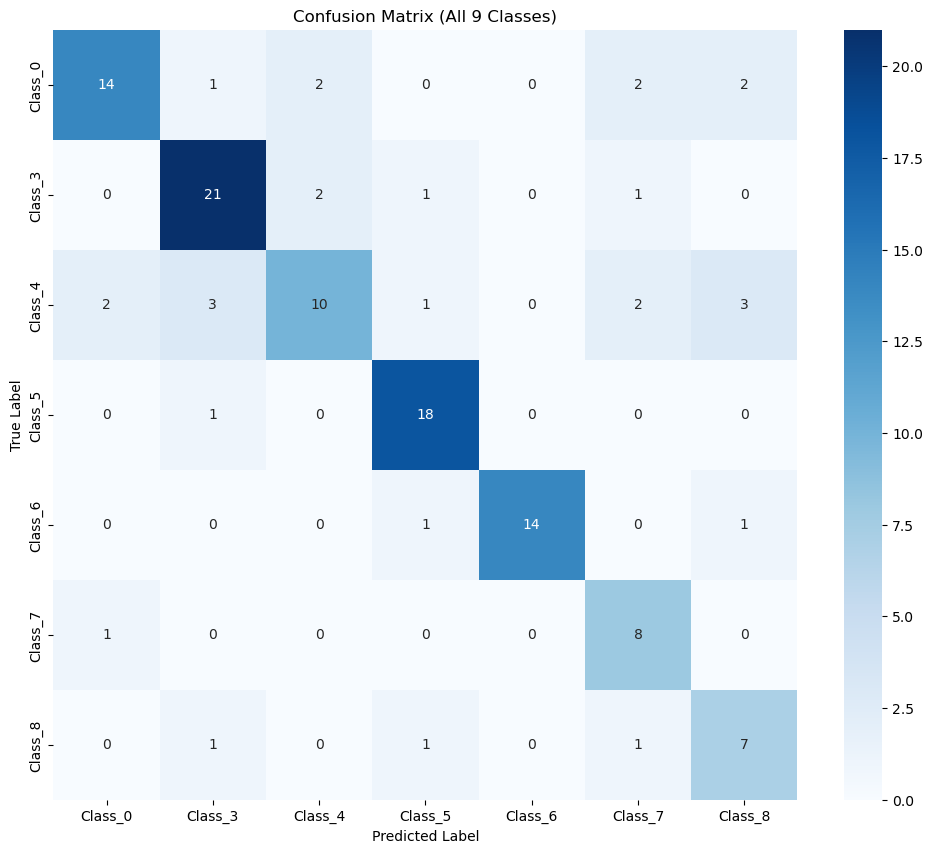

In [226]:
def analyze_complete_class_performance(model, loader, all_classes=[0, 3, 4, 5, 6, 7, 8]):
    """Analyze performance for ALL classes the model outputs"""
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for raw_batch, psd_batch, labels in loader:
            raw_batch = raw_batch.to(device)
            psd_batch = psd_batch.to(device)
            labels = labels.to(device)
            
            outputs = model(raw_batch, psd_batch)
            _, preds = outputs.max(1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Use ALL classes that the model can predict (9 classes)
    # not just the ones that appear in this particular batch
    class_names = [f'Class_{i}' for i in all_classes]
    
    print("=== COMPLETE CLASS PERFORMANCE (9 classes) ===")
    print(classification_report(all_labels, all_preds, 
                               labels=all_classes,  # Force include all 9 classes
                               target_names=class_names, 
                               digits=4,
                               zero_division=0))  # Handle classes with no samples
    
    # Confusion matrix for all classes
    plt.figure(figsize=(12, 10))
    cm = confusion_matrix(all_labels, all_preds, labels=all_classes)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix (All 9 Classes)')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    # return all_preds, all_labels

# Run the complete analysis with ALL 9 classes
all_classes = [0, 3, 4, 5, 6, 7, 8]  # Your actual class labels
analyze_complete_class_performance(model, test_loader, all_classes)

In [227]:
# Verify the model is actually outputting 9 classes
def verify_model_output(model, loader):
    """Check that model outputs predictions for all 9 classes"""
    model.eval()
    
    with torch.no_grad():
        for raw_batch, psd_batch, labels in loader:
            raw_batch = raw_batch.to(device)
            psd_batch = psd_batch.to(device)
            
            outputs = model(raw_batch, psd_batch)
            
            print(f"Model output shape: {outputs.shape}")  # Should be (batch_size, 9)
            print(f"Number of classes: {outputs.shape[1]}")
            
            # Check if model can predict all 9 classes
            _, preds = outputs.max(1)
            unique_preds = sorted(torch.unique(preds).cpu().numpy())
            print(f"Unique predictions: {unique_preds}")
            
            break  # Just check first batch

verify_model_output(model, test_loader)

Model output shape: torch.Size([32, 9])
Number of classes: 9
Unique predictions: [0, 3, 4, 5, 6, 7, 8]


# TNN Simple Model (Single PSD Band) with data augmentation
This is done per sensor, and per channel

In [136]:
import json
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset
from scipy.interpolate import interp1d
from scipy.signal import welch
import warnings
from scipy.stats import skew, kurtosis
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

class ChannelAugmentationIMUSonarFromJSON(IMUSonarFromJSON):
    """Dataset for IMU + Ultrasonic with raw + PSD output, with sliding windows.
    includes per -hannel data augmentation for pre-processing"""

    def __init__(self, json_file, label_map=None, transform=None,
                 target_length=600, window_length=128, stride=64,
                 debug=False, add_noise=False, noise_level=0.01):
        with open(json_file, 'r') as f:
            self.samples = json.load(f)

        self.transform = transform
        self.label_map = {v: k for k, v in label_map.items()} if label_map else {}
        self.target_length = target_length
        self.window_length = window_length
        self.stride = stride
        self.debug = debug

        # Noise / augmentation params
        self.add_noise = add_noise
        self.noise_level = noise_level

        self.cols = IMUSonarFromJSON.cols

        # Build index based on TARGET LENGTH
        self.window_index = []
        for i, item in enumerate(self.samples):
            T = self.target_length  # Use the resampled length
            
            if T < self.window_length:
                self.window_index.append((i, 0, T))
            else:
                for start in range(0, T - self.window_length + 1, self.stride):
                    end = start + self.window_length
                    self.window_index.append((i, start, end))

    def __len__(self):
        return len(self.window_index)

    def compute_multiscale_features(self, data):
        """Compute multiple feature types for analysis"""
        # Convert to numpy if it's a torch tensor
        if torch.is_tensor(data):
            data = data.numpy()
        
        C, T = data.shape
        features = {}
        
        for ch, col in enumerate(self.cols):
            channel_data = data[ch]
            features[col] = {
                'mean': float(np.mean(channel_data)),
                'std': float(np.std(channel_data)),
                'skew': float(skew(channel_data)),
                'kurtosis': float(kurtosis(channel_data)),
                'max': float(np.max(channel_data)),
                'min': float(np.min(channel_data)),
                'range': float(np.ptp(channel_data))
            }
            
            # For IMU channels, add motion-specific features
            if ch < 6:  # IMU channels
                zero_crossings = ((channel_data[:-1] * channel_data[1:]) < 0).sum()
                features[col].update({
                    'zero_crossings': int(zero_crossings),
                    'energy': float(np.sum(channel_data ** 2))
                })
        
        return features

    def inspect_preprocessing_effects(self, num_samples=5):
        """Inspect before/after effects of preprocessing"""
        print("=== PREPROCESSING EFFECTS ANALYSIS ===")
        
        for i, item in enumerate(self.samples[:num_samples]):
            print(f"\n--- Sample {i+1}, Label {item['label']} ---")
            df = pd.read_csv(item['path'])
            
            # Get raw data (before preprocessing)
            raw_data = self._resample_to_uniform(df)
            
            # Get processed data (after full pipeline)
            processed_data = raw_data.copy()
            processed_data = self._normalize_sensor_wise(processed_data)
            processed_data = self._process_sonar_robustly(processed_data)
            processed_data = self._enhance_discriminative_features(processed_data)
            
            # Compare statistics
            self._compare_statistics(raw_data, processed_data, item['label'])
            
            # Visualize effects
            if i < 3:  # Only plot first 3 for clarity
                self._visualize_preprocessing_effects(raw_data, processed_data, item['label'])
    
    def _compare_statistics(self, raw_data, processed_data, label):
        """Compare statistics before and after preprocessing"""
        # Convert to numpy if they are tensors
        if torch.is_tensor(raw_data):
            raw_data = raw_data.numpy()
        if torch.is_tensor(processed_data):
            processed_data = processed_data.numpy()
        
        print(f"Label {label} - Channel Statistics Comparison:")
        print("Channel         | Raw Mean ± Std     | Processed Mean ± Std")
        print("-" * 55)
        
        for ch, col in enumerate(self.cols):
            raw_mean = np.mean(raw_data[ch])
            raw_std = np.std(raw_data[ch])
            proc_mean = np.mean(processed_data[ch])
            proc_std = np.std(processed_data[ch])
            
            print(f"{col:15} | {raw_mean:6.3f} ± {raw_std:5.3f} | {proc_mean:6.3f} ± {proc_std:5.3f}")
        
        # Overall variance comparison
        raw_total_var = np.var(raw_data)
        proc_total_var = np.var(processed_data)
        print(f"\nTotal variance: {raw_total_var:.3f} → {proc_total_var:.3f}")
        print(f"Variance ratio: {proc_total_var/raw_total_var:.3f}")
    
    def _extract_features_raw(self, max_samples=50):
        """Extract features from raw data"""
        features = []
        labels = []
        
        for i, item in enumerate(self.samples[:max_samples]):
            df = pd.read_csv(item['path'])
            data = self._resample_to_uniform(df)
            
            if torch.is_tensor(data):
                data = data.numpy()
            
            # Simple features: mean of each channel
            feat = [np.mean(data[ch]) for ch in range(data.shape[0])]
            features.append(feat)
            labels.append(item['label'])
        
        return np.array(features), labels
    
    def _extract_features_processed(self, max_samples=50):
        """Extract features from processed data"""
        features = []
        labels = []
        
        for i, item in enumerate(self.samples[:max_samples]):
            df = pd.read_csv(item['path'])
            data = self._resample_to_uniform(df)
            
            if torch.is_tensor(data):
                data = data.numpy()
            
            # Apply full preprocessing pipeline
            data = self._normalize_sensor_wise(data)
            data = self._process_sonar_robustly(data)
            data = self._enhance_discriminative_features(data)
            
            if torch.is_tensor(data):
                data = data.numpy()
            
            # Simple features: mean of each channel
            feat = [np.mean(data[ch]) for ch in range(data.shape[0])]
            features.append(feat)
            labels.append(item['label'])
        
        return np.array(features), labels

    # === NORMALIZATION FUNCTIONS ===
    def _normalize_sensor_wise(self, data):
        """Normalize each sensor type with appropriate scaling"""
        if torch.is_tensor(data):
            data = data.numpy()
        
        normalized = data.copy()
        
        # Accelerometer channels (0-2): scale to ±2g range
        normalized[0:3] = normalized[0:3] / 2.0  # ±2g range
        
        # Gyroscope channels (3-5): scale to ±200°/s range  
        normalized[3:6] = normalized[3:6] / 200.0  # ±200°/s range
        
        # Sonar channels (6-7): scale to 0-200cm range
        normalized[6:8] = normalized[6:8] / 200.0  # 0-200cm range
        
        return torch.tensor(normalized, dtype=torch.float32)
    
    def _process_sonar_robustly(self, data):
        """Handle sonar data with robust processing"""
        if torch.is_tensor(data):
            data = data.numpy()
        
        processed = data.copy()
        
        # Sonar-specific processing
        sonar_data = processed[6:8]
        
        # 1. Log scaling for better dynamic range
        sonar_data = np.log1p(sonar_data)  # log(1 + x)
        
        # 2. Outlier clipping (99th percentile)
        for i in range(sonar_data.shape[0]):
            p99 = np.percentile(sonar_data[i], 99)
            sonar_data[i] = np.clip(sonar_data[i], 0, p99)
        
        # 3. Normalize to 0-1 range per channel
        for i in range(sonar_data.shape[0]):
            min_val, max_val = sonar_data[i].min(), sonar_data[i].max()
            if max_val > min_val:
                sonar_data[i] = (sonar_data[i] - min_val) / (max_val - min_val)
        
        processed[6:8] = sonar_data
        return torch.tensor(processed, dtype=torch.float32)

    # === TEMPORAL AUGMENTATION METHODS ===
    def _adaptive_time_warp(self, data, max_warp=0.3):
        """Time warping that preserves movement characteristics"""
        if torch.is_tensor(data):
            data = data.numpy()
        
        C, T = data.shape
        augmented = data.copy()
        
        # Different warping for different movement types
        warp_factors = np.random.uniform(1 - max_warp, 1 + max_warp, size=3)
        
        # Warp IMU channels (more aggressive for movement patterns)
        for ch in range(6):  # IMU channels
            warp_factor = np.random.choice(warp_factors)
            self._apply_time_warp(augmented[ch], warp_factor, T)
        
        # Warp sonar channels (more conservative to preserve distance continuity)
        for ch in range(6, 8):  # Sonar channels
            warp_factor = np.random.uniform(1 - max_warp/2, 1 + max_warp/2)
            self._apply_time_warp(augmented[ch], warp_factor, T)
        
        return torch.tensor(augmented, dtype=torch.float32)
    
    def _apply_time_warp(self, signal, warp_factor, original_length):
        """Apply time warping to a single channel"""
        new_length = int(original_length * warp_factor)
        x_original = np.linspace(0, 1, original_length)
        x_new = np.linspace(0, 1, new_length)
        
        interp_func = interp1d(x_original, signal, kind='cubic', fill_value="extrapolate")
        warped_signal = interp_func(x_new)
        
        # Resample back to original length
        interp_back = interp1d(x_new, warped_signal, kind='cubic', fill_value="extrapolate")
        signal[:] = interp_back(x_original)

    def _temporal_masking(self, data, max_mask_ratio=0.2):
        """Randomly mask segments of time series"""
        if torch.is_tensor(data):
            data = data.numpy()
        
        C, T = data.shape
        augmented = data.copy()
        
        # Mask multiple random segments
        num_masks = np.random.randint(1, 4)
        for _ in range(num_masks):
            mask_length = int(T * np.random.uniform(0.05, max_mask_ratio))
            mask_start = np.random.randint(0, T - mask_length)
            
            # Apply mask to all channels
            augmented[:, mask_start:mask_start + mask_length] = 0
        
        return torch.tensor(augmented, dtype=torch.float32)

    def _frequency_augmentation(self, data, max_shift=0.2):
        """Augment in frequency domain for PSD consistency"""
        if torch.is_tensor(data):
            data = data.numpy()
        
        C, T = data.shape
        augmented = data.copy()
        
        for ch in range(C):
            # FFT
            fft_data = np.fft.rfft(augmented[ch])
            magnitudes = np.abs(fft_data)
            phases = np.angle(fft_data)
            
            # Frequency shifting (simulate different movement speeds)
            freq_shift = int(len(magnitudes) * np.random.uniform(-max_shift, max_shift))
            if freq_shift != 0:
                magnitudes = np.roll(magnitudes, freq_shift)
                # Zero-fill the shifted region
                if freq_shift > 0:
                    magnitudes[:freq_shift] = 0
                else:
                    magnitudes[freq_shift:] = 0
            
            # Magnitude scaling (simulate different movement intensities)
            scale = np.random.uniform(0.8, 1.2)
            magnitudes *= scale
            
            # Reconstruct
            augmented[ch] = np.fft.irfft(magnitudes * np.exp(1j * phases), n=T)
        
        return torch.tensor(augmented, dtype=torch.float32)

    def _temporal_scaling(self, data, scale_range=(0.7, 1.3)):
        """Scale temporal patterns without warping"""
        if torch.is_tensor(data):
            data = data.numpy()
        
        C, T = data.shape
        scale_factor = np.random.uniform(*scale_range)
        
        # Scale derivatives to maintain movement characteristics
        augmented = np.zeros_like(data)
        for ch in range(C):
            derivatives = np.diff(data[ch], prepend=data[ch][0])
            scaled_derivatives = derivatives * scale_factor
            augmented[ch] = np.cumsum(scaled_derivatives)
        
        return torch.tensor(augmented, dtype=torch.float32)

    def _sensor_specific_noise(self, data):
        """Add noise tailored to each sensor type"""
        if torch.is_tensor(data):
            data = data.numpy()
        
        augmented = data.copy()
        
        # IMU channels: Gaussian noise + drift
        for ch in range(6):
            # Gaussian noise
            noise = np.random.normal(0, 0.05, data.shape[1])
            # Slow drift (simulate sensor calibration issues)
            drift = np.linspace(0, np.random.normal(0, 0.1), data.shape[1])
            augmented[ch] += noise + drift
        
        # Sonar channels: Impulse noise + dropout (simulate occlusions)
        for ch in range(6, 8):
            # Random impulses
            impulse_mask = np.random.random(data.shape[1]) < 0.02
            augmented[ch][impulse_mask] += np.random.normal(0, 0.2, np.sum(impulse_mask))
            
            # Dropout (brief signal loss)
            dropout_start = np.random.randint(0, data.shape[1] - 10)
            dropout_length = np.random.randint(5, 20)
            augmented[ch][dropout_start:dropout_start + dropout_length] = 0
        
        return torch.tensor(augmented, dtype=torch.float32)

    def _apply_temporal_augmentations(self, data):
        """Apply comprehensive temporal augmentations"""
        if torch.is_tensor(data):
            data = data.numpy()
        
        augmented = data.copy()
        
        # Apply augmentations with probabilities
        if np.random.random() < 0.7:
            augmented = self._adaptive_time_warp(augmented).numpy()
        
        if np.random.random() < 0.5:
            augmented = self._temporal_masking(augmented).numpy()
        
        if np.random.random() < 0.4:
            augmented = self._frequency_augmentation(augmented).numpy()
        
        if np.random.random() < 0.6:
            augmented = self._sensor_specific_noise(augmented).numpy()
        
        if np.random.random() < 0.3:
            augmented = self._temporal_scaling(augmented).numpy()
        
        return torch.tensor(augmented, dtype=torch.float32)
    
    def _temporal_augmentations(self, data):
        """Augmentations specific to movement data"""
        if torch.is_tensor(data):
            data = data.numpy()
        
        augmented = data.copy()
        
        # 1. Time warping (stretch/compress time)
        warp_factor = np.random.uniform(0.8, 1.2)
        original_length = data.shape[1]
        new_length = int(original_length * warp_factor)
        
        # Resample each channel
        for ch in range(data.shape[0]):
            original_signal = data[ch]
            x_original = np.linspace(0, 1, original_length)
            x_new = np.linspace(0, 1, new_length)
            
            # Interpolate
            interp_func = interp1d(x_original, original_signal, kind='linear', fill_value="extrapolate")
            warped_signal = interp_func(x_new)
            
            # Resample back to original length
            interp_back = interp1d(x_new, warped_signal, kind='linear', fill_value="extrapolate")
            augmented[ch] = interp_back(x_original)
        
        # 2. Random time shifting (preserve temporal relationships)
        shift = np.random.randint(-10, 10)  # Shift by ±10 samples
        if shift != 0:
            augmented = np.roll(augmented, shift, axis=1)
            # Fill boundaries
            if shift > 0:
                augmented[:, :shift] = 0
            else:
                augmented[:, shift:] = 0
        
        # 3. Frequency domain augmentation (for PSD)
        if np.random.random() < 0.3:
            # Random frequency filtering
            fft_data = np.fft.rfft(augmented, axis=1)
            freq_mask = np.random.uniform(0.8, 1.2, fft_data.shape[1])
            fft_data *= freq_mask
            augmented = np.fft.irfft(fft_data, n=augmented.shape[1], axis=1)
        
        return torch.tensor(augmented, dtype=torch.float32)
    
    def _enhance_discriminative_features(self, data):
        """Enhance features that are likely discriminative"""
        if torch.is_tensor(data):
            data = data.numpy()
        
        enhanced = data.copy()
        
        # For IMU: emphasize derivatives (movement changes)
        for ch in range(6):  # IMU channels
            derivative = np.diff(enhanced[ch], prepend=enhanced[ch][0])
            enhanced[ch] = enhanced[ch] + 0.3 * derivative  # Blend with derivative
        
        # For sonar: emphasize changes from baseline
        for ch in range(6, 8):  # Sonar channels
            baseline = np.median(enhanced[ch])
            enhanced[ch] = enhanced[ch] - baseline  # Remove DC offset
            enhanced[ch] = np.abs(enhanced[ch])  # Absolute deviation
        
        return torch.tensor(enhanced, dtype=torch.float32)
    
    def compute_global_stats(self):
        """Compute mean/std over raw resampled data (no normalization, no aug)."""
        tensors = []
        for item in self.samples:
            df = pd.read_csv(item['path'])
            timestamps = df['Timestamp(ms)'].values.astype(np.float32)
            signals = df[self.cols].values.astype(np.float32)

            timestamps, unique_indices = np.unique(timestamps, return_index=True)
            signals = signals[unique_indices]

            uniform_timestamps = np.linspace(timestamps[0], timestamps[-1], num=self.target_length)
            resampled = np.zeros((self.target_length, len(self.cols)), dtype=np.float32)
            for i in range(len(self.cols)):
                interp_func = interp1d(timestamps, signals[:, i], kind='linear', fill_value="extrapolate")
                resampled[:, i] = interp_func(uniform_timestamps)

            tensors.append(torch.tensor(resampled.T, dtype=torch.float32))

        all_data = torch.stack(tensors, dim=0)
        self.global_mean = all_data.mean(dim=(0, 2))
        self.global_std = all_data.std(dim=(0, 2))

    def _augment_raw(self, raw, noise_level=0.002, scale_range=(0.98,1.02),
                     mask_prob=0.05, jitter_std=0.01):
        """Augment a single sample in (C, T)"""
        if isinstance(raw, np.ndarray):
            raw = torch.tensor(raw, dtype=torch.float32)
        C, T = raw.shape
        augmented = raw.clone()

        imu_channels = list(range(6))
        sonar_channels = [6,7]

        noise = torch.randn(len(imu_channels), T) * noise_level
        augmented[imu_channels,:] += noise

        scale = torch.empty(1).uniform_(*scale_range)
        augmented[imu_channels,:] *= scale

        jitter = 1.0 + torch.randn(len(imu_channels), T) * jitter_std
        augmented[imu_channels,:] *= jitter

        mask = (torch.rand(len(imu_channels), T) < mask_prob)
        augmented[imu_channels,:][mask] = 0.0

        augmented[sonar_channels,:] = torch.clamp(augmented[sonar_channels,:], 0.0, 1.0)

        return augmented

    # === UNIFORM RESAMPLE AND PSD FUNCTIONS ===
    def _resample_to_uniform(self, df):
        """Resample CSV data to uniform length (C, T)"""
        timestamps = df['Timestamp(ms)'].values.astype(np.float32)
        signals = df[self.cols].values.astype(np.float32)
    
        timestamps, unique_indices = np.unique(timestamps, return_index=True)
        signals = signals[unique_indices]
    
        uniform_timestamps = np.linspace(timestamps[0], timestamps[-1], num=self.target_length)
        resampled = np.zeros((self.target_length, len(self.cols)), dtype=np.float32)
        for i in range(len(self.cols)):
            interp_func = interp1d(timestamps, signals[:, i], kind='linear', fill_value="extrapolate")
            resampled[:, i] = interp_func(uniform_timestamps)

        return resampled.T  # (C, T)

    def compute_psd(self, data, fs=50):
        """Compute PSD for (C, T) data with adaptive parameters"""
        C, T = data.shape
        nperseg = min(self.window_length, T)
        noverlap = nperseg // 2
        
        psd_list = []
        for ch in range(C):
            f, Pxx = welch(data[ch], fs=fs, nperseg=nperseg, noverlap=noverlap)
            psd_list.append(Pxx)
        return np.stack(psd_list, axis=0).astype(np.float32)

    def __getitem__(self, idx):
        sample_idx, start, end = self.window_index[idx]
        item = self.samples[sample_idx]
        df = pd.read_csv(item['path'])
    
        # Resample and preprocess
        full_data = self._resample_to_uniform(df)
        data = full_data[:, start:end]
        
        # Apply core preprocessing
        data = self._normalize_sensor_wise(data)
        data = self._process_sonar_robustly(data)
        data = self._enhance_discriminative_features(data)
        
        # Apply temporal augmentations (training only)
        if self.add_noise:  # Add training flag to your class
            data = self._apply_temporal_augmentations(data)
        
        # Compute PSD and return
        total_time_sec = (df['Timestamp(ms)'].iloc[-1] - df['Timestamp(ms)'].iloc[0]) / 1000.0
        fs_est = self.target_length / total_time_sec if total_time_sec > 0 else 50.0
        psd = self.compute_psd(data.numpy(), fs=fs_est)
    
        return data, torch.tensor(psd, dtype=torch.float32), torch.tensor(item['label'], dtype=torch.long)

In [137]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleIMUSonarNet(nn.Module):
    """
    Simplified model for original samples only
    """
    def __init__(self, num_channels=8, num_classes=5, psd_bins=64, dropout=0.2):
        super().__init__()
        
        # # --- Time domain branch ---
        # self.time_conv = nn.Sequential(
        #     nn.Conv1d(num_channels, 32, kernel_size=5, padding=2),
        #     nn.BatchNorm1d(32),
        #     nn.ReLU(inplace=True),
        #     nn.Conv1d(32, 64, kernel_size=5, padding=2),
        #     nn.BatchNorm1d(64),
        #     nn.ReLU(inplace=True),
        #     nn.AdaptiveAvgPool1d(1)
        # )
        
        # # --- PSD branch ---
        # self.psd_fc = nn.Sequential(
        #     nn.Linear(num_channels * psd_bins, 128),
        #     nn.BatchNorm1d(128),
        #     nn.ReLU(inplace=True),
        #     nn.Dropout(dropout)
        # )
        
        # # --- Fusion and classification ---
        # self.classifier = nn.Sequential(
        #     nn.Linear(64 + 128, 128),  # time features + PSD features
        #     nn.ReLU(inplace=True),
        #     nn.BatchNorm1d(128),
        #     nn.Dropout(dropout),
        #     nn.Linear(128, num_classes)
        # )

        # --- Time domain branch ---
        self.time_conv = nn.Sequential(
            nn.Conv1d(num_channels, 64, kernel_size=5, padding=2),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout/3),
            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout/3),
            nn.Conv1d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool1d(1)
        )
        
        # --- PSD branch ---
        self.psd_fc = nn.Sequential(
            nn.Linear(num_channels * psd_bins, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout/2)
        )
        
        # --- Fusion and classification ---
        self.classifier = nn.Sequential(
            nn.Linear(256 + 128, 256),  # More capacity
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(256),
            nn.Dropout(dropout),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(128),
            nn.Dropout(dropout/2),
            nn.Linear(128, num_classes)
        )
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv1d, nn.Linear)):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0.0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1.0)
                nn.init.constant_(m.bias, 0.0)
    
    def forward(self, raw_x, psd_x):
        # Time domain processing
        time_features = self.time_conv(raw_x).squeeze(-1)
        
        # PSD processing
        psd_flat = psd_x.view(psd_x.size(0), -1)
        psd_features = self.psd_fc(psd_flat)
        
        # Concatenate and classify
        combined = torch.cat([time_features, psd_features], dim=1)
        logits = self.classifier(combined)
        
        return logits

In [138]:
import os
import torch
import numpy as np
import random
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from time import time
import torch.nn as nn
import json

# Seeds
torch.manual_seed(42); np.random.seed(42); random.seed(42)

# Device
device = torch.device("mps" if torch.backends.mps.is_available() else 
                      "cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ---------------- Data ----------------
with open(f"{DATAFILES_DIR}/compressed_label_map.json", 'r') as f:
    label_map = json.load(f)

train_dataset = ChannelAugmentationIMUSonarFromJSON(
    f"{DATAFILES_DIR}/train_split.json",
    label_map=label_map,
    target_length=600,
    noise_level=0.001,
    window_length=128,
    stride=32,          # lots of windows
    add_noise=True      # enable training-time augmentation
)
test_dataset = ChannelAugmentationIMUSonarFromJSON(
    f"{DATAFILES_DIR}/test_split.json",
    label_map=label_map,
    target_length=600,
    window_length=128,
    stride=32,   # lots of windows
    add_noise=False
)

# Compute global stats on TRAIN ONLY, then share with TEST
train_dataset.compute_global_stats()
test_dataset.global_mean = train_dataset.global_mean.clone()
test_dataset.global_std  = train_dataset.global_std.clone()

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True,  num_workers=0, drop_last=False)
test_loader  = DataLoader(test_dataset,  batch_size=32, shuffle=False, num_workers=0, drop_last=False)

# ---------------- Model ----------------
sample_raw, sample_psd, _ = train_dataset[0]
num_channels = sample_raw.shape[0]
psd_bins = sample_psd.shape[1]
num_classes = len(label_map)

model = SimpleIMUSonarNet(
    num_channels=num_channels,
    num_classes=num_classes,
    psd_bins=psd_bins,
    dropout=0.2               # slightly higher dropout to curb overfit
).to(device)

# ---------------- Train loop ----------------
epochs = 50
criterion = nn.CrossEntropyLoss(label_smoothing=0.05)  # stronger label smoothing
optimizer = Adam(model.parameters(), lr=1e-3, weight_decay=1e-3)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

# Early stopping
best_val_acc = 0.0
patience = 5
no_improve_epochs = 0
best_state = None

for epoch in range(epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    epoch_start = time()
    
    for raw_batch, psd_batch, labels in train_loader:
        raw_batch = raw_batch.to(device)
        psd_batch = psd_batch.to(device)
        labels    = labels.to(device).long()

        optimizer.zero_grad()
        outputs = model(raw_batch, psd_batch)
        loss = criterion(outputs, labels)
        loss.backward()
        # gradient clipping for stability
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total   += labels.size(0)
    
    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for raw_batch, psd_batch, labels in test_loader:
            raw_batch = raw_batch.to(device)
            psd_batch = psd_batch.to(device)
            labels    = labels.to(device).long()
            
            outputs = model(raw_batch, psd_batch)
            val_loss += criterion(outputs, labels).item()
            _, predicted = outputs.max(1)
            val_correct += predicted.eq(labels).sum().item()
            val_total   += labels.size(0)
    
    # Metrics
    train_loss = running_loss / len(train_loader)
    train_acc  = correct / total
    val_loss   = val_loss / len(test_loader)
    val_acc    = val_correct / val_total
    
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    # Scheduler step
    scheduler.step(val_loss)
    
    print(f"Epoch {epoch + 1}/{epochs} - {time() - epoch_start:.1f}s | " \
            f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | " \
            f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")
    
#     # Early stopping
#     if val_acc > best_val_acc:
#         best_val_acc = val_acc
#         no_improve_epochs = 0
#         best_state = {k: v.detach().clone() for k, v in model.state_dict().items()}
#     else:
#         no_improve_epochs += 1
#         if no_improve_epochs >= patience:
#             print(f"⏹ Early stopping at epoch {epoch+1} (best val acc {best_val_acc:.4f})")
#             break

# # Restore best model
# if best_state is not None:
#     model.load_state_dict(best_state)

# ---------------- Final evaluation ----------------
def evaluate(model, loader):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for raw_batch, psd_batch, labels in loader:
            raw_batch = raw_batch.to(device)
            psd_batch = psd_batch.to(device)
            labels    = labels.to(device).long()
            outputs = model(raw_batch, psd_batch)
            total_loss += criterion(outputs, labels).item() * raw_batch.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total   += labels.size(0)
    return total_loss / total, correct / total

train_loss, train_acc = evaluate(model, train_loader)
test_loss,  test_acc  = evaluate(model, test_loader)

print('Final Results:')
print(f'Train loss: {train_loss:.4f}, accuracy: {train_acc:.4f}')
print(f'Test loss: {test_loss:.4f}, accuracy: {test_acc:.4f}')

Using device: mps
Epoch 1/50 - 23.9s | Train Loss: 2.0362 Acc: 0.3281 | Val Loss: 1.5321 Acc: 0.4898
Epoch 2/50 - 23.6s | Train Loss: 1.6798 Acc: 0.3956 | Val Loss: 1.4861 Acc: 0.5185
Epoch 3/50 - 23.4s | Train Loss: 1.5729 Acc: 0.4415 | Val Loss: 1.3332 Acc: 0.5311
Epoch 4/50 - 23.5s | Train Loss: 1.5324 Acc: 0.4544 | Val Loss: 1.3021 Acc: 0.5300
Epoch 5/50 - 23.6s | Train Loss: 1.4986 Acc: 0.4627 | Val Loss: 1.3079 Acc: 0.5521
Epoch 6/50 - 23.4s | Train Loss: 1.4882 Acc: 0.4742 | Val Loss: 1.2684 Acc: 0.5730
Epoch 7/50 - 23.9s | Train Loss: 1.4537 Acc: 0.4846 | Val Loss: 1.2250 Acc: 0.6132
Epoch 8/50 - 23.8s | Train Loss: 1.4348 Acc: 0.5003 | Val Loss: 1.2323 Acc: 0.5862
Epoch 9/50 - 23.4s | Train Loss: 1.4301 Acc: 0.5023 | Val Loss: 1.2502 Acc: 0.5537
Epoch 10/50 - 23.4s | Train Loss: 1.4132 Acc: 0.5087 | Val Loss: 1.2535 Acc: 0.5543
Epoch 11/50 - 23.4s | Train Loss: 1.3994 Acc: 0.5181 | Val Loss: 1.2221 Acc: 0.5950
Epoch 12/50 - 23.6s | Train Loss: 1.3662 Acc: 0.5325 | Val Loss: 1.

# Dataset with augmented data per sensor, per channel

## Dataset with Multi-PSD windows and classes

In [125]:
import json
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset
from scipy.interpolate import interp1d
from scipy.signal import welch

class MultiPSDIMUSonarFromJSON(IMUSonarFromJSON):
    """Dataset for IMU + Ultrasonic with raw + with multiple PSD output windows"""

    def compute_seizure_psd(self, data, fs=50, nperseg=256, noverlap=128):
        """
        Compute PSD optimized for seizure detection with emphasis on key frequency bands
        """
        C, T = data.shape
        psd_list = []
        
        # Key frequency bands for seizure detection
        seizure_bands = {
            'ultra_low': (0, 1),      # Tonic phase dominance
            'very_low': (1, 3),       # Transition phases
            'low': (3, 8),           # Early clonic
            'mid': (8, 15),          # Clonic phase
            'high': (15, 30),        # Fast clonic components
            'very_high': (30, fs/2)  # High-frequency artifacts/features
        }
        
        band_names = list(seizure_bands.keys())
        band_edges = [seizure_bands[band][0] for band in band_names] + [seizure_bands[band_names[-1]][1]]
        
        for ch in range(C):
            f, Pxx = welch(data[ch], fs=fs, nperseg=nperseg, noverlap=noverlap)
            
            band_features = []
            for band_name in band_names:
                low_freq, high_freq = seizure_bands[band_name]
                mask = (f >= low_freq) & (f < high_freq)
                
                if np.any(mask):
                    band_power = np.trapz(Pxx[mask], f[mask])  # Total power in band
                    band_max = np.max(Pxx[mask])               # Peak power
                    band_centroid = np.sum(f[mask] * Pxx[mask]) / np.sum(Pxx[mask]) if np.sum(Pxx[mask]) > 0 else 0
                else:
                    band_power, band_max, band_centroid = 0, 0, 0
                
                band_features.extend([band_power, band_max, band_centroid])
            
            psd_list.append(band_features)
        
        return np.array(psd_list, dtype=np.float32)  # (C, num_bands * 3)

    def __getitem__(self, idx):
        """Return (raw_tensor, psd_features, label) with enhanced PSD features"""
        item = self.samples[idx]
        df = pd.read_csv(item['path'])
    
        # Resample to uniform shape (C, T)
        data = self._resample_to_uniform(df)
    
        # Estimate sample frequency
        total_time_sec = (df['Timestamp(ms)'].iloc[-1] - df['Timestamp(ms)'].iloc[0]) / 1000.0
        fs_est = self.target_length / total_time_sec if total_time_sec > 0 else 50.0
        
        # Compute enhanced PSD features
        psd_features = self.compute_seizure_psd(data, fs=fs_est)
    
        # Add temporal evolution: Split into multiple windows
        window_size = self.target_length // 4  # 4 windows per sample
        multi_window_psd = []
        
        for i in range(0, self.target_length, window_size):
            if i + window_size <= self.target_length:
                window_data = data[:, i:i+window_size]
                window_psd = self.compute_seizure_psd(window_data, fs=fs_est, nperseg=128, noverlap=64)
                multi_window_psd.append(window_psd)
        
        # Stack temporal windows
        temporal_psd = np.stack(multi_window_psd, axis=0)  # (num_windows, C, num_features)
    
        # Convert to tensors
        raw_tensor = torch.tensor(data, dtype=torch.float32)
        psd_tensor = torch.tensor(temporal_psd, dtype=torch.float32)
    
        label = self.label_map[item['label']] if self.label_map else item['label']
        label_tensor = torch.tensor(item['label'], dtype=torch.long)
    
        return raw_tensor, psd_tensor, label_tensor

In [132]:
class EnhancedIMUSonarNet(nn.Module):
    def __init__(self, num_channels=8, num_classes=5, psd_features=18, dropout=0.3, 
                 num_bands=6, time_hidden=192, psd_hidden=64):
        super().__init__()
        self.num_bands = num_bands
        self.psd_features_per_band = psd_features // num_bands  # Should be 3
        self.psd_hidden = psd_hidden
        
        # --- Enhanced Time branch ---
        self.time_conv = nn.Sequential(
            nn.Conv1d(num_channels, 64, kernel_size=15, padding=7),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            
            nn.Conv1d(64, 128, kernel_size=7, padding=3),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            
            nn.Conv1d(128, time_hidden, kernel_size=3, padding=1),
            nn.BatchNorm1d(time_hidden),
            nn.ReLU(inplace=True)
        )
        self.time_pool = nn.AdaptiveAvgPool1d(1)
        
        # --- Enhanced PSD branch ---
        self.psd_band_fc = nn.ModuleList()
        for _ in range(num_bands):
            self.psd_band_fc.append(
                nn.Sequential(
                    nn.Linear(num_channels * self.psd_features_per_band, 128),
                    nn.BatchNorm1d(128),
                    nn.ReLU(inplace=True),
                    nn.Dropout(dropout),
                    nn.Linear(128, psd_hidden),
                    nn.BatchNorm1d(psd_hidden),
                    nn.ReLU(inplace=True)
                )
            )
        
        # Band attention mechanism
        self.band_attention = nn.Sequential(
            nn.Linear(psd_hidden * num_bands, num_bands),
            nn.Softmax(dim=1)
        )
        
        self.psd_out_dim = psd_hidden * num_bands  # 64 * 6 = 384
        
        # --- Fusion ---
        # time_hidden = 192, psd_out_dim = 384, so total = 576
        self.fusion = nn.Sequential(
            nn.Linear(time_hidden + self.psd_out_dim, 256),  # 576 -> 256
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(256),
            nn.Dropout(dropout),
            
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(128),
            nn.Dropout(dropout/2),
            
            nn.Linear(128, num_classes)
        )
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv1d, nn.Linear)):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0.0)
    
    def forward(self, raw_x, psd_x):
        # Time branch
        time_features = self.time_conv(raw_x)
        time_features = self.time_pool(time_features).squeeze(-1)  # (B, 192)
        
        # PSD branch - average across windows first
        B, W, C, F = psd_x.shape  # Batch, Windows=4, Channels=8, Features=18
        psd_avg = psd_x.mean(dim=1)  # (B, C, F) - average across 4 windows
        
        band_outputs = []
        for i, fc in enumerate(self.psd_band_fc):
            start_idx = i * self.psd_features_per_band
            end_idx = (i + 1) * self.psd_features_per_band
            band = psd_avg[:, :, start_idx:end_idx]  # (B, 8, 3)
            band_flat = band.reshape(B, -1)  # (B, 8*3=24)
            band_feat = fc(band_flat)  # (B, 64)
            band_outputs.append(band_feat)
        
        # Concatenate all band features
        psd_concat = torch.cat(band_outputs, dim=1)  # (B, 64*6=384)
        
        # Get attention weights
        attention_weights = self.band_attention(psd_concat)  # (B, 6)
        
        # Apply attention by scaling each band's contribution
        # We need to reshape and apply attention correctly
        attended_bands = []
        for i in range(self.num_bands):
            # Get the original band output and scale by attention weight
            band_scaled = band_outputs[i] * attention_weights[:, i].unsqueeze(1)
            attended_bands.append(band_scaled)
        
        # Concatenate the attended bands
        attended_psd = torch.cat(attended_bands, dim=1)  # (B, 384)
        
        # Fusion
        combined = torch.cat([time_features, attended_psd], dim=1)  # (B, 192 + 384 = 576)
        logits = self.fusion(combined)
        
        return logits, attention_weights

In [133]:
import os
import torch
import numpy as np
import random
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from time import time
import torch.nn as nn
import json

# Seeds
torch.manual_seed(42); np.random.seed(42); random.seed(42)

# Device
device = torch.device("mps" if torch.backends.mps.is_available() else 
                      "cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ---------------- Data ----------------
with open(f"{DATAFILES_DIR}/compressed_label_map.json", 'r') as f:
    label_map = json.load(f)

train_dataset = IMUSonarFromJSON(
    f"{DATAFILES_DIR}/train_split.json",
    label_map=label_map,
    target_length=600,
    noise_level=0.001,
    add_noise=True      # enable training-time augmentation
)
test_dataset = IMUSonarFromJSON(
    f"{DATAFILES_DIR}/test_split.json",
    label_map=label_map,
    target_length=600,
    add_noise=False
)

# Compute global stats on TRAIN ONLY, then share with TEST
train_dataset.compute_global_stats()
test_dataset.global_mean = train_dataset.global_mean.clone()
test_dataset.global_std  = train_dataset.global_std.clone()

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

# Get sample to determine dimensions
sample_raw, sample_psd, _ = train_dataset[0]
num_channels = sample_raw.shape[0]
psd_features = sample_psd.shape[2]  # Now it's (windows, channels, features)
num_classes = len(label_map)

model = EnhancedIMUSonarNet(
    num_channels=num_channels,
    num_classes=num_classes,
    psd_features=psd_features,
    dropout=0.3,
    num_bands=6,  # Optimal for seizure detection
    time_hidden=192,
    psd_hidden=64
).to(device)

# ---------------- Train loop ----------------
epochs = 50
criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
optimizer = Adam(model.parameters(), lr=1e-3, weight_decay=1e-3)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

# Early stopping
best_val_acc = 0.0
patience = 5
no_improve_epochs = 0
best_state = None

for epoch in range(epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    epoch_start = time()
    
    for raw_batch, psd_batch, labels in train_loader:
        raw_batch = raw_batch.to(device)
        psd_batch = psd_batch.to(device)  # Now shape: (batch, windows, channels, features)
        labels    = labels.to(device).long()

        optimizer.zero_grad()
        outputs, attention_weights = model(raw_batch, psd_batch)
        loss = criterion(outputs, labels)
        loss.backward()
        # gradient clipping for stability
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total   += labels.size(0)
    
    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for raw_batch, psd_batch, labels in test_loader:
            raw_batch = raw_batch.to(device)
            psd_batch = psd_batch.to(device)
            labels    = labels.to(device).long()
            
            outputs, attention_weights = model(raw_batch, psd_batch)
            val_loss += criterion(outputs, labels).item()
            _, predicted = outputs.max(1)
            val_correct += predicted.eq(labels).sum().item()
            val_total   += labels.size(0)
    
    # Metrics
    train_loss = running_loss / len(train_loader)
    train_acc  = correct / total
    val_loss   = val_loss / len(test_loader)
    val_acc    = val_correct / val_total
    
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    # Scheduler step
    scheduler.step(val_loss)
    
    print(f"Epoch {epoch + 1}/{epochs} - {time() - epoch_start:.1f}s | " \
            f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | " \
            f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")
    
    # Early stopping
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        no_improve_epochs = 0
        best_state = {k: v.detach().clone() for k, v in model.state_dict().items()}
    else:
        no_improve_epochs += 1
        if no_improve_epochs >= patience:
            print(f"⏹ Early stopping at epoch {epoch+1} (best val acc {best_val_acc:.4f})")
            break

# Restore best model
if best_state is not None:
    model.load_state_dict(best_state)

# ---------------- Final evaluation ----------------
def evaluate(model, loader):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0
    all_attention_weights = []
    with torch.no_grad():
        for raw_batch, psd_batch, labels in loader:
            raw_batch = raw_batch.to(device)
            psd_batch = psd_batch.to(device)
            labels    = labels.to(device).long()
            outputs, attention_weights = model(raw_batch, psd_batch)
            total_loss += criterion(outputs, labels).item() * raw_batch.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total   += labels.size(0)
            all_attention_weights.append(attention_weights.cpu())
    return total_loss / total, correct / total, torch.cat(all_attention_weights)

train_loss, train_acc, train_attention = evaluate(model, train_loader)
test_loss,  test_acc,  test_attention  = evaluate(model, test_loader)

print('Final Results:')
print(f'Train loss: {train_loss:.4f}, accuracy: {train_acc:.4f}')
print(f'Test loss: {test_loss:.4f}, accuracy: {test_acc:.4f}')

# Analyze band importance
print("\nBand Attention Analysis:")
band_importance = test_attention.mean(dim=0)
for i, importance in enumerate(band_importance):
    print(f"Band {i}: {importance:.4f}")

Using device: mps
Raw shape: torch.Size([8, 600])
PSD shape: torch.Size([4, 8, 18])
PSD features per band: 3
Epoch 1/50 - 4.6s | Train Loss: 2.6704 Acc: 0.1789 | Val Loss: 2.2725 Acc: 0.1983
Epoch 2/50 - 3.9s | Train Loss: 1.9215 Acc: 0.4069 | Val Loss: 1.7856 Acc: 0.3967
Epoch 3/50 - 3.9s | Train Loss: 1.6649 Acc: 0.4755 | Val Loss: 1.6241 Acc: 0.4545
Epoch 4/50 - 3.8s | Train Loss: 1.2995 Acc: 0.6201 | Val Loss: 2.0228 Acc: 0.4050
Epoch 5/50 - 3.8s | Train Loss: 1.2276 Acc: 0.6299 | Val Loss: 1.9094 Acc: 0.4959
Epoch 6/50 - 3.8s | Train Loss: 0.9799 Acc: 0.7059 | Val Loss: 3.0104 Acc: 0.4050
Epoch 7/50 - 3.8s | Train Loss: 0.9359 Acc: 0.7475 | Val Loss: 2.3344 Acc: 0.4050
Epoch 8/50 - 3.8s | Train Loss: 0.7868 Acc: 0.8064 | Val Loss: 2.4408 Acc: 0.4545
Epoch 9/50 - 3.8s | Train Loss: 0.7262 Acc: 0.8333 | Val Loss: 2.3649 Acc: 0.4959
Epoch 10/50 - 3.8s | Train Loss: 0.6507 Acc: 0.8529 | Val Loss: 1.9888 Acc: 0.4959
⏹ Early stopping at epoch 10 (best val acc 0.4959)
Final Results:
Trai

## Dataset aggressive normalization
This will adjust the data augmentation to consider temporal windows within a sample, as well as given stricter conditional around each channel normalization

In [41]:
import json
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset
from scipy.interpolate import interp1d
from scipy.signal import welch
import warnings
from scipy.stats import skew, kurtosis
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

class IMUSonarFromJSON(Dataset):
    """Dataset for IMU + Ultrasonic with raw + PSD output, with sliding windows."""

    cols = [
        'AccelX(g)', 'AccelY(g)', 'AccelZ(g)',
        'GyroX(deg/s)', 'GyroY(deg/s)', 'GyroZ(deg/s)',
        'DistanceLeft(cm)', 'DistanceRight(cm)'
    ]

    def __init__(self, json_file, label_map=None, transform=None,
                 target_length=600, window_length=128, stride=64,
                 debug=False, add_noise=False, noise_level=0.01):
        with open(json_file, 'r') as f:
            self.samples = json.load(f)

        self.transform = transform
        self.label_map = {v: k for k, v in label_map.items()} if label_map else {}
        self.target_length = target_length
        self.window_length = window_length
        self.stride = stride
        self.debug = debug

        # Noise / augmentation params
        self.add_noise = add_noise
        self.noise_level = noise_level

        self.cols = IMUSonarFromJSON.cols

        # Build index based on TARGET LENGTH
        self.window_index = []
        for i, item in enumerate(self.samples):
            T = self.target_length  # Use the resampled length
            
            if T < self.window_length:
                self.window_index.append((i, 0, T))
            else:
                for start in range(0, T - self.window_length + 1, self.stride):
                    end = start + self.window_length
                    self.window_index.append((i, start, end))

    def __len__(self):
        return len(self.window_index)

    # === NEW: DATASET ANALYSIS METHODS ===
    
    def analyze_class_distribution(self):
        """Analyze class distribution across the dataset"""
        label_counts = {}
        for item in self.samples:
            label = item['label']
            label_counts[label] = label_counts.get(label, 0) + 1
        
        print("=== CLASS DISTRIBUTION ===")
        for label, count in sorted(label_counts.items()):
            print(f"Label {label}: {count} samples ({count/len(self.samples)*100:.1f}%)")
        
        # Plot distribution
        plt.figure(figsize=(12, 6))
        plt.bar(label_counts.keys(), label_counts.values())
        plt.xlabel('Class Label')
        plt.ylabel('Number of Samples')
        plt.title('Class Distribution')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        
        return label_counts

    def analyze_channel_statistics(self):
        """Analyze statistics for each channel across all samples"""
        channel_stats = {col: {'mean': [], 'std': [], 'min': [], 'max': []} for col in self.cols}
        
        for item in self.samples:
            df = pd.read_csv(item['path'])
            for col in self.cols:
                channel_stats[col]['mean'].append(df[col].mean())
                channel_stats[col]['std'].append(df[col].std())
                channel_stats[col]['min'].append(df[col].min())
                channel_stats[col]['max'].append(df[col].max())
        
        print("\n=== CHANNEL STATISTICS ===")
        for col in self.cols:
            stats = channel_stats[col]
            print(f"{col}:")
            print(f"  Mean: {np.mean(stats['mean']):.3f} ± {np.std(stats['mean']):.3f}")
            print(f"  Std:  {np.mean(stats['std']):.3f} ± {np.std(stats['std']):.3f}")
            print(f"  Range: [{np.mean(stats['min']):.3f}, {np.mean(stats['max']):.3f}]")
        
        return channel_stats

    def analyze_temporal_patterns(self, max_samples=5):
        """Plot temporal patterns for sample from each class"""
        class_samples = {}
        for item in self.samples:
            label = item['label']
            if label not in class_samples:
                class_samples[label] = item
            if len(class_samples) >= max_samples:
                break
        
        fig, axes = plt.subplots(2, 4, figsize=(16, 8))
        axes = axes.flatten()
        
        for i, (label, item) in enumerate(class_samples.items()):
            if i >= len(axes):
                break
                
            df = pd.read_csv(item['path'])
            time = df['Timestamp(ms)'] - df['Timestamp(ms)'].iloc[0]
            
            # Plot first 3 IMU channels
            for j, col in enumerate(self.cols[:3]):
                axes[i].plot(time[:100], df[col][:100], label=col, alpha=0.7)
            
            axes[i].set_title(f'Label {label} - First 100 samples')
            axes[i].set_xlabel('Time (ms)')
            axes[i].set_ylabel('Value')
            axes[i].legend()
            axes[i].grid(True)
        
        plt.tight_layout()
        plt.show()

    def compute_multiscale_features(self, data):
        """Compute multiple feature types for analysis"""
        # Convert to numpy if it's a torch tensor
        if torch.is_tensor(data):
            data = data.numpy()
        
        C, T = data.shape
        features = {}
        
        for ch, col in enumerate(self.cols):
            channel_data = data[ch]
            features[col] = {
                'mean': float(np.mean(channel_data)),
                'std': float(np.std(channel_data)),
                'skew': float(skew(channel_data)),
                'kurtosis': float(kurtosis(channel_data)),
                'max': float(np.max(channel_data)),
                'min': float(np.min(channel_data)),
                'range': float(np.ptp(channel_data))
            }
            
            # For IMU channels, add motion-specific features
            if ch < 6:  # IMU channels
                zero_crossings = ((channel_data[:-1] * channel_data[1:]) < 0).sum()
                features[col].update({
                    'zero_crossings': int(zero_crossings),
                    'energy': float(np.sum(channel_data ** 2))
                })
        
        return features

    def analyze_feature_separability(self):
        """Analyze how well features separate different classes"""
        all_features = []
        all_labels = []
        
        # Sample a few windows from each class
        for item in self.samples[:20]:  # Limit for performance
            df = pd.read_csv(item['path'])
            resampled = self._resample_to_uniform(df)
            
            # Ensure we have numpy array for feature computation
            if torch.is_tensor(resampled):
                resampled_np = resampled.numpy()
            else:
                resampled_np = resampled
                
            features = self.compute_multiscale_features(resampled_np)
            
            # Flatten features
            flat_features = []
            for col in self.cols:
                flat_features.extend(list(features[col].values()))
            
            all_features.append(flat_features)
            all_labels.append(item['label'])
        
        # Simple correlation analysis
        feature_matrix = np.array(all_features)
        correlation = np.corrcoef(feature_matrix.T)
        
        plt.figure(figsize=(12, 10))
        sns.heatmap(correlation, cmap='coolwarm', center=0)
        plt.title('Feature Correlation Matrix')
        plt.tight_layout()
        plt.show()
        
        return feature_matrix, all_labels

    def verify_label_consistency(self):
        """Check if data characteristics match expected labels"""
        print("\n=== LABEL-DATA CONSISTENCY ===")
        
        for item in self.samples[:10]:  # Check first 10 samples
            df = pd.read_csv(item['path'])
            label = item['label']
            
            # Compute basic statistics
            imu_activity = df[self.cols[:6]].std().mean()
            sonar_mean = df[self.cols[6:]].mean().values
            
            print(f"Label {label}: IMU activity={imu_activity:.3f}, "
                  f"Sonar distances={sonar_mean[0]:.1f}/{sonar_mean[1]:.1f}cm")

    def analyze_class_separability(self, max_samples=50):
        """Analyze how well classes are separated in feature space"""
        # Extract features from all samples
        all_features = []
        all_labels = []
        
        print("Extracting features for class separability analysis...")
        for i, item in enumerate(self.samples):
            if i >= max_samples:  # Further limit for stability
                break
                
            df = pd.read_csv(item['path'])
            resampled = self._resample_to_uniform(df)
            if torch.is_tensor(resampled):
                resampled = resampled.numpy()
            
            # Use simpler features to reduce dimensionality
            features = []
            for ch in range(resampled.shape[0]):
                channel_data = resampled[ch]
                # Only use mean and std to reduce feature count
                features.extend([np.mean(channel_data), np.std(channel_data)])
            
            all_features.append(features)
            all_labels.append(item['label'])
        
        if not all_features:
            print("No features extracted!")
            return [], []
        
        # Standardize features for PCA
        scaler = StandardScaler()
        features_scaled = scaler.fit_transform(all_features)
        
        # PCA visualization only (skip t-SNE for now)
        print("Performing PCA...")
        try:
            pca = PCA(n_components=2)
            features_2d = pca.fit_transform(features_scaled)
            
            plt.figure(figsize=(8, 6))
            scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=all_labels, cmap='tab10', alpha=0.7, s=50)
            plt.colorbar(scatter)
            plt.title('PCA - Class Separation')
            plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
            plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
            plt.grid(True, alpha=0.3)
            
            # Add class labels to some points for clarity
            unique_labels = list(set(all_labels))
            for label in unique_labels:
                indices = [i for i, l in enumerate(all_labels) if l == label]
                if indices:
                    centroid = np.mean(features_2d[indices], axis=0)
                    plt.annotate(f'C{label}', centroid, xytext=(5, 5), 
                               textcoords='offset points', fontweight='bold')
            
            plt.tight_layout()
            plt.show()
            
            print(f"PCA explained variance: {pca.explained_variance_ratio_[:2]}")
            
        except Exception as e:
            print(f"PCA failed: {e}")
            return all_features, all_labels
        
        # Optional: Simple t-SNE with very conservative settings
        if len(features_scaled) <= 30:  # Only for very small datasets
            print("Attempting t-SNE with conservative settings...")
            try:
                tsne = TSNE(n_components=2, perplexity=5, random_state=42, n_iter=500)
                features_tsne = tsne.fit_transform(features_scaled)
                
                plt.figure(figsize=(8, 6))
                scatter = plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=all_labels, cmap='tab10', alpha=0.7, s=50)
                plt.colorbar(scatter)
                plt.title('t-SNE - Class Separation (Limited)')
                plt.grid(True, alpha=0.3)
                plt.tight_layout()
                plt.show()
            except Exception as e:
                print(f"t-SNE failed: {e}")
        
        return all_features, all_labels
    
    def analyze_cross_channel_correlations(self, sample_size=50):
        """Analyze correlations between different sensor channels"""
        print("Analyzing cross-channel correlations...")
        correlation_matrix = np.zeros((len(self.cols), len(self.cols)))
        sample_count = min(sample_size, len(self.samples))
        
        for i, item in enumerate(self.samples[:sample_count]):
            df = pd.read_csv(item['path'])
            correlation_matrix += df[self.cols].corr().values
        
        correlation_matrix /= sample_count  # Average across samples
        
        plt.figure(figsize=(10, 8))
        sns.heatmap(correlation_matrix, 
                    xticklabels=self.cols, 
                    yticklabels=self.cols,
                    cmap='coolwarm', center=0, annot=True, fmt='.2f')
        plt.title('Average Cross-Channel Correlation Matrix')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        
        return correlation_matrix
    
    def analyze_temporal_patterns_by_class(self, samples_per_class=3):
        """Analyze how temporal patterns differ between classes"""
        print("Analyzing temporal patterns by class...")
        class_patterns = {}
        
        for item in self.samples:
            label = item['label']
            if label not in class_patterns:
                class_patterns[label] = []
            if len(class_patterns[label]) < samples_per_class:
                df = pd.read_csv(item['path'])
                # Normalize each channel for better comparison
                normalized_data = (df[self.cols] - df[self.cols].mean()) / (df[self.cols].std() + 1e-8)
                class_patterns[label].append(normalized_data.values)
        
        # Plot average patterns for each class
        fig, axes = plt.subplots(2, 4, figsize=(16, 8))
        axes = axes.flatten()
        
        for i, col in enumerate(self.cols):
            if i >= len(axes):
                break
                
            for label, patterns in class_patterns.items():
                if len(patterns) > 0:
                    # Take first 100 time steps for visualization
                    time_steps = min(100, patterns[0].shape[0])
                    class_patterns_trimmed = [p[:time_steps, i] for p in patterns if p.shape[0] >= time_steps]
                    if class_patterns_trimmed:
                        avg_pattern = np.mean(class_patterns_trimmed, axis=0)
                        axes[i].plot(avg_pattern, label=f'Class {label}', alpha=0.7)
            
            axes[i].set_title(col)
            axes[i].set_xlabel('Time steps')
            axes[i].set_ylabel('Normalized Value')
            if i == 0:  # Only show legend on first plot
                axes[i].legend()
            axes[i].grid(True)
        
        plt.tight_layout()
        plt.show()
        
        return class_patterns
    
    def analyze_class_overlap_confusion(self, max_samples=50):
        """Analyze which classes are most confused with each other"""
        print("Analyzing potential class confusion...")
        from sklearn.neighbors import KNeighborsClassifier
        from sklearn.metrics import confusion_matrix
        
        # Extract basic features - use even fewer samples
        all_features = []
        all_labels = []
        
        for i, item in enumerate(self.samples):
            if i >= max_samples:  # Reduced from 200 to 50
                break
                
            df = pd.read_csv(item['path'])
            
            # Use simpler features - just means of each channel
            features = []
            for col in self.cols:
                features.append(df[col].mean())  # Only mean, no std
            
            all_features.append(features)
            all_labels.append(item['label'])
        
        if len(all_features) < 10:
            print("Not enough samples for confusion analysis")
            return None
        
        # Simple KNN with safer parameters
        try:
            knn = KNeighborsClassifier(n_neighbors=1)  # Use 1-NN for simplicity
            knn.fit(all_features, all_labels)
            predictions = knn.predict(all_features)
            
            # Confusion matrix
            cm = confusion_matrix(all_labels, predictions)
            
            plt.figure(figsize=(8, 6))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                        xticklabels=sorted(set(all_labels)),
                        yticklabels=sorted(set(all_labels)))
            plt.title('Confusion Matrix (1-NN on channel means)')
            plt.xlabel('Predicted')
            plt.ylabel('True')
            plt.tight_layout()
            plt.show()
            
            # Print which classes are most confused
            print("Class confusion analysis:")
            classes = sorted(set(all_labels))
            for i, true_class in enumerate(classes):
                for j, pred_class in enumerate(classes):
                    if i != j and cm[i, j] > 0:
                        print(f"  Class {true_class} confused as {pred_class}: {cm[i, j]} times")
            
            return cm
            
        except Exception as e:
            print(f"Confusion analysis failed: {e}")
            return None

    def inspect_preprocessing_effects(self, num_samples=5):
        """Inspect before/after effects of preprocessing"""
        print("=== PREPROCESSING EFFECTS ANALYSIS ===")
        
        for i, item in enumerate(self.samples[:num_samples]):
            print(f"\n--- Sample {i+1}, Label {item['label']} ---")
            df = pd.read_csv(item['path'])
            
            # Get raw data (before preprocessing)
            raw_data = self._resample_to_uniform(df)
            
            # Get processed data (after full pipeline)
            processed_data = raw_data.copy()
            processed_data = self._normalize_sensor_wise(processed_data)
            processed_data = self._process_sonar_robustly(processed_data)
            processed_data = self._enhance_discriminative_features(processed_data)
            
            # Compare statistics
            self._compare_statistics(raw_data, processed_data, item['label'])
            
            # Visualize effects
            if i < 3:  # Only plot first 3 for clarity
                self._visualize_preprocessing_effects(raw_data, processed_data, item['label'])
    
    def _compare_statistics(self, raw_data, processed_data, label):
        """Compare statistics before and after preprocessing"""
        # Convert to numpy if they are tensors
        if torch.is_tensor(raw_data):
            raw_data = raw_data.numpy()
        if torch.is_tensor(processed_data):
            processed_data = processed_data.numpy()
        
        print(f"Label {label} - Channel Statistics Comparison:")
        print("Channel         | Raw Mean ± Std     | Processed Mean ± Std")
        print("-" * 55)
        
        for ch, col in enumerate(self.cols):
            raw_mean = np.mean(raw_data[ch])
            raw_std = np.std(raw_data[ch])
            proc_mean = np.mean(processed_data[ch])
            proc_std = np.std(processed_data[ch])
            
            print(f"{col:15} | {raw_mean:6.3f} ± {raw_std:5.3f} | {proc_mean:6.3f} ± {proc_std:5.3f}")
        
        # Overall variance comparison
        raw_total_var = np.var(raw_data)
        proc_total_var = np.var(processed_data)
        print(f"\nTotal variance: {raw_total_var:.3f} → {proc_total_var:.3f}")
        print(f"Variance ratio: {proc_total_var/raw_total_var:.3f}")
    
    def _visualize_preprocessing_effects(self, raw_data, processed_data, label):
        """Visualize the effects of preprocessing"""
        # Convert to numpy if they are tensors
        if torch.is_tensor(raw_data):
            raw_data = raw_data.numpy()
        if torch.is_tensor(processed_data):
            processed_data = processed_data.numpy()
        
        fig, axes = plt.subplots(2, 4, figsize=(16, 8))
        axes = axes.flatten()
        
        time = np.arange(raw_data.shape[1])
        
        for ch, col in enumerate(self.cols):
            if ch < len(axes):
                # Plot raw vs processed
                axes[ch].plot(time, raw_data[ch], 'b-', alpha=0.7, label='Raw', linewidth=1)
                axes[ch].plot(time, processed_data[ch], 'r-', alpha=0.8, label='Processed', linewidth=1.5)
                
                axes[ch].set_title(f'{col} (Label {label})')
                axes[ch].set_xlabel('Time')
                axes[ch].set_ylabel('Value')
                axes[ch].legend()
                axes[ch].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.suptitle(f'Preprocessing Effects - Label {label}', y=1.02)
        plt.show()
    
    def analyze_feature_distributions(self):
        """Analyze feature distributions before and after preprocessing"""
        print("=== FEATURE DISTRIBUTION ANALYSIS ===")
        
        raw_features = []
        processed_features = []
        labels = []
        
        for i, item in enumerate(self.samples[:30]):  # Sample subset
            df = pd.read_csv(item['path'])
            
            # Raw features
            raw_data = self._resample_to_uniform(df)
            if torch.is_tensor(raw_data):
                raw_data = raw_data.numpy()
            raw_feat = [np.mean(raw_data[ch]) for ch in range(raw_data.shape[0])]
            raw_features.append(raw_feat)
            
            # Processed features
            processed_data = raw_data.copy()
            processed_data = self._normalize_sensor_wise(processed_data)
            processed_data = self._process_sonar_robustly(processed_data)
            processed_data = self._enhance_discriminative_features(processed_data)
            
            if torch.is_tensor(processed_data):
                processed_data = processed_data.numpy()
            proc_feat = [np.mean(processed_data[ch]) for ch in range(processed_data.shape[0])]
            processed_features.append(proc_feat)
            
            labels.append(item['label'])
        
        # Plot distributions
        fig, axes = plt.subplots(2, 4, figsize=(16, 8))
        axes = axes.flatten()
        
        for ch, col in enumerate(self.cols):
            if ch < len(axes):
                raw_vals = [f[ch] for f in raw_features]
                proc_vals = [f[ch] for f in processed_features]
                
                axes[ch].hist(raw_vals, alpha=0.6, bins=20, label='Raw', color='blue')
                axes[ch].hist(proc_vals, alpha=0.6, bins=20, label='Processed', color='red')
                axes[ch].set_title(f'{col} Distribution')
                axes[ch].set_xlabel('Value')
                axes[ch].set_ylabel('Frequency')
                axes[ch].legend()
                axes[ch].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def analyze_class_separability_improvement(self):
        """Analyze if preprocessing improves class separability"""
        print("=== CLASS SEPARABILITY IMPROVEMENT ===")
        
        # Extract features before and after preprocessing
        raw_features, raw_labels = self._extract_features_raw()
        proc_features, proc_labels = self._extract_features_processed()
        
        # PCA analysis for both
        self._pca_comparison(raw_features, raw_labels, proc_features, proc_labels, "Raw vs Processed")
    
    def _extract_features_raw(self, max_samples=50):
        """Extract features from raw data"""
        features = []
        labels = []
        
        for i, item in enumerate(self.samples[:max_samples]):
            df = pd.read_csv(item['path'])
            data = self._resample_to_uniform(df)
            
            if torch.is_tensor(data):
                data = data.numpy()
            
            # Simple features: mean of each channel
            feat = [np.mean(data[ch]) for ch in range(data.shape[0])]
            features.append(feat)
            labels.append(item['label'])
        
        return np.array(features), labels
    
    def _extract_features_processed(self, max_samples=50):
        """Extract features from processed data"""
        features = []
        labels = []
        
        for i, item in enumerate(self.samples[:max_samples]):
            df = pd.read_csv(item['path'])
            data = self._resample_to_uniform(df)
            
            if torch.is_tensor(data):
                data = data.numpy()
            
            # Apply full preprocessing pipeline
            data = self._normalize_sensor_wise(data)
            data = self._process_sonar_robustly(data)
            data = self._enhance_discriminative_features(data)
            
            if torch.is_tensor(data):
                data = data.numpy()
            
            # Simple features: mean of each channel
            feat = [np.mean(data[ch]) for ch in range(data.shape[0])]
            features.append(feat)
            labels.append(item['label'])
        
        return np.array(features), labels
    
    def _pca_comparison(self, raw_features, raw_labels, proc_features, proc_labels, title):
        """Compare PCA results before and after processing"""
        from sklearn.decomposition import PCA
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # Raw data PCA
        pca_raw = PCA(n_components=2)
        raw_2d = pca_raw.fit_transform(raw_features)
        scatter1 = ax1.scatter(raw_2d[:, 0], raw_2d[:, 1], c=raw_labels, cmap='tab10', alpha=0.7)
        ax1.set_title(f'Raw Data (Variance: {pca_raw.explained_variance_ratio_[:2].sum():.1%})')
        ax1.set_xlabel('PC1')
        ax1.set_ylabel('PC2')
        plt.colorbar(scatter1, ax=ax1)
        
        # Processed data PCA
        pca_proc = PCA(n_components=2)
        proc_2d = pca_proc.fit_transform(proc_features)
        scatter2 = ax2.scatter(proc_2d[:, 0], proc_2d[:, 1], c=proc_labels, cmap='tab10', alpha=0.7)
        ax2.set_title(f'Processed Data (Variance: {pca_proc.explained_variance_ratio_[:2].sum():.1%})')
        ax2.set_xlabel('PC1')
        ax2.set_ylabel('PC2')
        plt.colorbar(scatter2, ax=ax2)
        
        plt.tight_layout()
        plt.suptitle(title, y=1.02)
        plt.show()
        
        print(f"Raw PCA explained variance: {pca_raw.explained_variance_ratio_[:2]}")
        print(f"Processed PCA explained variance: {pca_proc.explained_variance_ratio_[:2]}")
        print(f"Variance improvement: {pca_proc.explained_variance_ratio_[:2].sum() - pca_raw.explained_variance_ratio_[:2].sum():.3%}")

    # === NORMALIZATION FUNCTIONS ===
    def _normalize_sensor_wise(self, data):
        """Normalize each sensor type with appropriate scaling"""
        if torch.is_tensor(data):
            data = data.numpy()
        
        normalized = data.copy()
        
        # Accelerometer channels (0-2): scale to ±2g range
        normalized[0:3] = normalized[0:3] / 2.0  # ±2g range
        
        # Gyroscope channels (3-5): scale to ±200°/s range  
        normalized[3:6] = normalized[3:6] / 200.0  # ±200°/s range
        
        # Sonar channels (6-7): scale to 0-200cm range
        normalized[6:8] = normalized[6:8] / 200.0  # 0-200cm range
        
        return torch.tensor(normalized, dtype=torch.float32)
    
    def _process_sonar_robustly(self, data):
        """Handle sonar data with robust processing"""
        if torch.is_tensor(data):
            data = data.numpy()
        
        processed = data.copy()
        
        # Sonar-specific processing
        sonar_data = processed[6:8]
        
        # 1. Log scaling for better dynamic range
        sonar_data = np.log1p(sonar_data)  # log(1 + x)
        
        # 2. Outlier clipping (99th percentile)
        for i in range(sonar_data.shape[0]):
            p99 = np.percentile(sonar_data[i], 99)
            sonar_data[i] = np.clip(sonar_data[i], 0, p99)
        
        # 3. Normalize to 0-1 range per channel
        for i in range(sonar_data.shape[0]):
            min_val, max_val = sonar_data[i].min(), sonar_data[i].max()
            if max_val > min_val:
                sonar_data[i] = (sonar_data[i] - min_val) / (max_val - min_val)
        
        processed[6:8] = sonar_data
        return torch.tensor(processed, dtype=torch.float32)

    # === TEMPORAL AUGMENTATION METHODS ===
    def _adaptive_time_warp(self, data, max_warp=0.3):
        """Time warping that preserves movement characteristics"""
        if torch.is_tensor(data):
            data = data.numpy()
        
        C, T = data.shape
        augmented = data.copy()
        
        # Different warping for different movement types
        warp_factors = np.random.uniform(1 - max_warp, 1 + max_warp, size=3)
        
        # Warp IMU channels (more aggressive for movement patterns)
        for ch in range(6):  # IMU channels
            warp_factor = np.random.choice(warp_factors)
            self._apply_time_warp(augmented[ch], warp_factor, T)
        
        # Warp sonar channels (more conservative to preserve distance continuity)
        for ch in range(6, 8):  # Sonar channels
            warp_factor = np.random.uniform(1 - max_warp/2, 1 + max_warp/2)
            self._apply_time_warp(augmented[ch], warp_factor, T)
        
        return torch.tensor(augmented, dtype=torch.float32)
    
    def _apply_time_warp(self, signal, warp_factor, original_length):
        """Apply time warping to a single channel"""
        new_length = int(original_length * warp_factor)
        x_original = np.linspace(0, 1, original_length)
        x_new = np.linspace(0, 1, new_length)
        
        interp_func = interp1d(x_original, signal, kind='cubic', fill_value="extrapolate")
        warped_signal = interp_func(x_new)
        
        # Resample back to original length
        interp_back = interp1d(x_new, warped_signal, kind='cubic', fill_value="extrapolate")
        signal[:] = interp_back(x_original)

    def _temporal_masking(self, data, max_mask_ratio=0.2):
        """Randomly mask segments of time series"""
        if torch.is_tensor(data):
            data = data.numpy()
        
        C, T = data.shape
        augmented = data.copy()
        
        # Mask multiple random segments
        num_masks = np.random.randint(1, 4)
        for _ in range(num_masks):
            mask_length = int(T * np.random.uniform(0.05, max_mask_ratio))
            mask_start = np.random.randint(0, T - mask_length)
            
            # Apply mask to all channels
            augmented[:, mask_start:mask_start + mask_length] = 0
        
        return torch.tensor(augmented, dtype=torch.float32)

    def _frequency_augmentation(self, data, max_shift=0.2):
        """Augment in frequency domain for PSD consistency"""
        if torch.is_tensor(data):
            data = data.numpy()
        
        C, T = data.shape
        augmented = data.copy()
        
        for ch in range(C):
            # FFT
            fft_data = np.fft.rfft(augmented[ch])
            magnitudes = np.abs(fft_data)
            phases = np.angle(fft_data)
            
            # Frequency shifting (simulate different movement speeds)
            freq_shift = int(len(magnitudes) * np.random.uniform(-max_shift, max_shift))
            if freq_shift != 0:
                magnitudes = np.roll(magnitudes, freq_shift)
                # Zero-fill the shifted region
                if freq_shift > 0:
                    magnitudes[:freq_shift] = 0
                else:
                    magnitudes[freq_shift:] = 0
            
            # Magnitude scaling (simulate different movement intensities)
            scale = np.random.uniform(0.8, 1.2)
            magnitudes *= scale
            
            # Reconstruct
            augmented[ch] = np.fft.irfft(magnitudes * np.exp(1j * phases), n=T)
        
        return torch.tensor(augmented, dtype=torch.float32)

    def _temporal_scaling(self, data, scale_range=(0.7, 1.3)):
        """Scale temporal patterns without warping"""
        if torch.is_tensor(data):
            data = data.numpy()
        
        C, T = data.shape
        scale_factor = np.random.uniform(*scale_range)
        
        # Scale derivatives to maintain movement characteristics
        augmented = np.zeros_like(data)
        for ch in range(C):
            derivatives = np.diff(data[ch], prepend=data[ch][0])
            scaled_derivatives = derivatives * scale_factor
            augmented[ch] = np.cumsum(scaled_derivatives)
        
        return torch.tensor(augmented, dtype=torch.float32)

    def _sensor_specific_noise(self, data):
        """Add noise tailored to each sensor type"""
        if torch.is_tensor(data):
            data = data.numpy()
        
        augmented = data.copy()
        
        # IMU channels: Gaussian noise + drift
        for ch in range(6):
            # Gaussian noise
            noise = np.random.normal(0, 0.05, data.shape[1])
            # Slow drift (simulate sensor calibration issues)
            drift = np.linspace(0, np.random.normal(0, 0.1), data.shape[1])
            augmented[ch] += noise + drift
        
        # Sonar channels: Impulse noise + dropout (simulate occlusions)
        for ch in range(6, 8):
            # Random impulses
            impulse_mask = np.random.random(data.shape[1]) < 0.02
            augmented[ch][impulse_mask] += np.random.normal(0, 0.2, np.sum(impulse_mask))
            
            # Dropout (brief signal loss)
            dropout_start = np.random.randint(0, data.shape[1] - 10)
            dropout_length = np.random.randint(5, 20)
            augmented[ch][dropout_start:dropout_start + dropout_length] = 0
        
        return torch.tensor(augmented, dtype=torch.float32)

    def _apply_temporal_augmentations(self, data):
        """Apply comprehensive temporal augmentations"""
        if torch.is_tensor(data):
            data = data.numpy()
        
        augmented = data.copy()
        
        # Apply augmentations with probabilities
        if np.random.random() < 0.7:
            augmented = self._adaptive_time_warp(augmented).numpy()
        
        if np.random.random() < 0.5:
            augmented = self._temporal_masking(augmented).numpy()
        
        if np.random.random() < 0.4:
            augmented = self._frequency_augmentation(augmented).numpy()
        
        if np.random.random() < 0.6:
            augmented = self._sensor_specific_noise(augmented).numpy()
        
        if np.random.random() < 0.3:
            augmented = self._temporal_scaling(augmented).numpy()
        
        return torch.tensor(augmented, dtype=torch.float32)
    
    def _temporal_augmentations(self, data):
        """Augmentations specific to movement data"""
        if torch.is_tensor(data):
            data = data.numpy()
        
        augmented = data.copy()
        
        # 1. Time warping (stretch/compress time)
        warp_factor = np.random.uniform(0.8, 1.2)
        original_length = data.shape[1]
        new_length = int(original_length * warp_factor)
        
        # Resample each channel
        for ch in range(data.shape[0]):
            original_signal = data[ch]
            x_original = np.linspace(0, 1, original_length)
            x_new = np.linspace(0, 1, new_length)
            
            # Interpolate
            interp_func = interp1d(x_original, original_signal, kind='linear', fill_value="extrapolate")
            warped_signal = interp_func(x_new)
            
            # Resample back to original length
            interp_back = interp1d(x_new, warped_signal, kind='linear', fill_value="extrapolate")
            augmented[ch] = interp_back(x_original)
        
        # 2. Random time shifting (preserve temporal relationships)
        shift = np.random.randint(-10, 10)  # Shift by ±10 samples
        if shift != 0:
            augmented = np.roll(augmented, shift, axis=1)
            # Fill boundaries
            if shift > 0:
                augmented[:, :shift] = 0
            else:
                augmented[:, shift:] = 0
        
        # 3. Frequency domain augmentation (for PSD)
        if np.random.random() < 0.3:
            # Random frequency filtering
            fft_data = np.fft.rfft(augmented, axis=1)
            freq_mask = np.random.uniform(0.8, 1.2, fft_data.shape[1])
            fft_data *= freq_mask
            augmented = np.fft.irfft(fft_data, n=augmented.shape[1], axis=1)
        
        return torch.tensor(augmented, dtype=torch.float32)
    
    def _enhance_discriminative_features(self, data):
        """Enhance features that are likely discriminative"""
        if torch.is_tensor(data):
            data = data.numpy()
        
        enhanced = data.copy()
        
        # For IMU: emphasize derivatives (movement changes)
        for ch in range(6):  # IMU channels
            derivative = np.diff(enhanced[ch], prepend=enhanced[ch][0])
            enhanced[ch] = enhanced[ch] + 0.3 * derivative  # Blend with derivative
        
        # For sonar: emphasize changes from baseline
        for ch in range(6, 8):  # Sonar channels
            baseline = np.median(enhanced[ch])
            enhanced[ch] = enhanced[ch] - baseline  # Remove DC offset
            enhanced[ch] = np.abs(enhanced[ch])  # Absolute deviation
        
        return torch.tensor(enhanced, dtype=torch.float32)
    
    def compute_global_stats(self):
        """Compute mean/std over raw resampled data (no normalization, no aug)."""
        tensors = []
        for item in self.samples:
            df = pd.read_csv(item['path'])
            timestamps = df['Timestamp(ms)'].values.astype(np.float32)
            signals = df[self.cols].values.astype(np.float32)

            timestamps, unique_indices = np.unique(timestamps, return_index=True)
            signals = signals[unique_indices]

            uniform_timestamps = np.linspace(timestamps[0], timestamps[-1], num=self.target_length)
            resampled = np.zeros((self.target_length, len(self.cols)), dtype=np.float32)
            for i in range(len(self.cols)):
                interp_func = interp1d(timestamps, signals[:, i], kind='linear', fill_value="extrapolate")
                resampled[:, i] = interp_func(uniform_timestamps)

            tensors.append(torch.tensor(resampled.T, dtype=torch.float32))

        all_data = torch.stack(tensors, dim=0)
        self.global_mean = all_data.mean(dim=(0, 2))
        self.global_std = all_data.std(dim=(0, 2))

    def _augment_raw(self, raw, noise_level=0.002, scale_range=(0.98,1.02),
                     mask_prob=0.05, jitter_std=0.01):
        """Augment a single sample in (C, T)"""
        if isinstance(raw, np.ndarray):
            raw = torch.tensor(raw, dtype=torch.float32)
        C, T = raw.shape
        augmented = raw.clone()

        imu_channels = list(range(6))
        sonar_channels = [6,7]

        noise = torch.randn(len(imu_channels), T) * noise_level
        augmented[imu_channels,:] += noise

        scale = torch.empty(1).uniform_(*scale_range)
        augmented[imu_channels,:] *= scale

        jitter = 1.0 + torch.randn(len(imu_channels), T) * jitter_std
        augmented[imu_channels,:] *= jitter

        mask = (torch.rand(len(imu_channels), T) < mask_prob)
        augmented[imu_channels,:][mask] = 0.0

        augmented[sonar_channels,:] = torch.clamp(augmented[sonar_channels,:], 0.0, 1.0)

        return augmented

    # === UNIFORM RESAMPLE AND PSD FUNCTIONS ===
    def _resample_to_uniform(self, df):
        """Resample CSV data to uniform length (C, T)"""
        timestamps = df['Timestamp(ms)'].values.astype(np.float32)
        signals = df[self.cols].values.astype(np.float32)
    
        timestamps, unique_indices = np.unique(timestamps, return_index=True)
        signals = signals[unique_indices]
    
        uniform_timestamps = np.linspace(timestamps[0], timestamps[-1], num=self.target_length)
        resampled = np.zeros((self.target_length, len(self.cols)), dtype=np.float32)
        for i in range(len(self.cols)):
            interp_func = interp1d(timestamps, signals[:, i], kind='linear', fill_value="extrapolate")
            resampled[:, i] = interp_func(uniform_timestamps)

        return resampled.T  # (C, T)

    def compute_psd(self, data, fs=50):
        """Compute PSD for (C, T) data with adaptive parameters"""
        C, T = data.shape
        nperseg = min(self.window_length, T)
        noverlap = nperseg // 2
        
        psd_list = []
        for ch in range(C):
            # with warnings.catch_warnings():
            #     warnings.simplefilter("ignore")
                # f, Pxx = welch(data[ch], fs=fs, nperseg=nperseg, noverlap=noverlap)
            f, Pxx = welch(data[ch], fs=fs, nperseg=nperseg, noverlap=noverlap)
            psd_list.append(Pxx)
        return np.stack(psd_list, axis=0).astype(np.float32)

    def __getitem__(self, idx):
        sample_idx, start, end = self.window_index[idx]
        item = self.samples[sample_idx]
        df = pd.read_csv(item['path'])
    
        # Resample and preprocess
        full_data = self._resample_to_uniform(df)
        data = full_data[:, start:end]
        
        # Apply core preprocessing
        data = self._normalize_sensor_wise(data)
        data = self._process_sonar_robustly(data)
        data = self._enhance_discriminative_features(data)
        
        # Apply temporal augmentations (training only)
        if self.add_noise:  # Add training flag to your class
            data = self._apply_temporal_augmentations(data)
        
        # Compute PSD and return
        total_time_sec = (df['Timestamp(ms)'].iloc[-1] - df['Timestamp(ms)'].iloc[0]) / 1000.0
        fs_est = self.target_length / total_time_sec if total_time_sec > 0 else 50.0
        psd = self.compute_psd(data.numpy(), fs=fs_est)
    
        return data, torch.tensor(psd, dtype=torch.float32), torch.tensor(item['label'], dtype=torch.long)

# Only use original samples

In [6]:
import os
import random
import json
from pathlib import Path

def create_train_test_split(collection_dir, test_split_ratio=0.2, debug=False):
    """
    Build train/test split JSONs based on your folder structure.
    Variants are excluded from the split.
    
    - collection_dir: root of subjects
    - test_split_ratio: ratio of files to use for testing (0.0 to 1.0)
    """
    collection_dir = Path(collection_dir)
    train_samples = []
    test_samples = []

    # iterate subjects
    subjects = [d for d in collection_dir.iterdir() if d.is_dir()]
    print(f'Number of subjects: {len(subjects)}')

    # Load in labels
    with open(f"{DATAFILES_DIR}/label_map.json", 'r') as f:
        label_map = json.load(f)

    for subject_dir in subjects:
        # iterate first-half label directories
        for label1_dir in subject_dir.iterdir():
            if not label1_dir.is_dir():
                continue
            for label2_dir in label1_dir.iterdir():
                if not label2_dir.is_dir():
                    continue

                # full label name
                label_name = f"{label1_dir.name}_{label2_dir.name}"
                
                # Get only original CSV files (exclude variants folder and its contents)
                original_files = [f for f in label2_dir.glob("*") if f.suffix.lower() == ".csv" 
                                 if "variants" not in str(f) and f.is_file()]
                
                if len(original_files) == 0:
                    continue
                
                # Shuffle files for random split
                random.shuffle(original_files)
                
                # Calculate split point
                split_idx = int(len(original_files) * (1 - test_split_ratio))
                
                # Split into train and test
                train_files = original_files[:split_idx]
                test_files = original_files[split_idx:]
                
                # Add to respective lists
                for file_path in train_files:
                    train_samples.append({"path": str(file_path), "label": label_map[label_name]})
                
                for file_path in test_files:
                    test_samples.append({"path": str(file_path), "label": label_map[label_name]})

    if debug:
        print(f"Total train samples: {len(train_samples)}")
        print(f"Total test samples: {len(test_samples)}")
        print(f"Test split ratio: {len(test_samples)/(len(train_samples)+len(test_samples)):.2f}")
        print(f"Labels: {label_map}")

    return train_samples, test_samples

# Example usage
train_json, test_json = create_train_test_split(COLLECTIONFILES_DIR, test_split_ratio=0.2, debug=True)

# Write the split datasets to JSON files
train_labels_path = os.path.join(DATAFILES_DIR, "train_split.json")
test_labels_path = os.path.join(DATAFILES_DIR, "test_split.json")
with open(train_labels_path, 'w') as f:
    json.dump(train_json, f, indent=2)
with open(test_labels_path, 'w') as f:
    json.dump(test_json, f, indent=2)

Number of subjects: 3
Total train samples: 408
Total test samples: 121
Test split ratio: 0.23
Labels: {'tremor_running': 0, 'tremor_walking': 1, 'tremor_standing': 2, 'tremor_sitting': 3, 'tremor_laying': 4, 'tremor_stairs': 5, 'postural_falling': 6, 'postural_walking': 7, 'postural_standing': 8, 'postural_sitting': 9, 'postural_laying': 10, 'normal_running': 11, 'normal_walking': 12, 'normal_standing': 13, 'normal_sitting': 14, 'normal_laying': 15, 'normal_stairs': 16, 'tonic_running': 17, 'tonic_walking': 18, 'tonic_standing': 19, 'tonic_sitting': 20, 'tonic_laying': 21, 'tonic_stairs': 22, 'tremor_falling': 23, 'postural_running': 24, 'postural_stairs': 25, 'normal_falling': 26, 'tonic_falling': 27}


In [31]:
import os
import random
import json
from pathlib import Path

def create_train_test_split(collection_dir, test_split_ratio=0.2, debug=False):
    """
    Build train/test split JSONs based on your folder structure.
    Variants are excluded from the split.
    
    - collection_dir: root of subjects
    - test_split_ratio: ratio of files to use for testing (0.0 to 1.0)
    """
    collection_dir = Path(collection_dir)
    train_samples = []
    test_samples = []

    # iterate subjects
    subjects = [d for d in collection_dir.iterdir() if d.is_dir()]
    print(f'Number of subjects: {len(subjects)}')

    # Load in original labels
    with open(f"{DATAFILES_DIR}/label_map.json", 'r') as f:
        original_label_map = json.load(f)
    
    # Create expanded compressed label mapping (0-8) to ensure everything maps
    compressed_label_map = {
        "WALKING": 0,
        "WALKING_UPSTAIRS": 1,
        "WALKING_DOWNSTAIRS": 2,
        "SITTING": 3,
        "STANDING": 4,
        "LAYING": 5,
        "RUNNING": 6,
        "STAIRS": 7,
        "FALLING": 8
    }
    
    # Create mapping from original labels to compressed labels
    original_to_compressed = {}
    
    for original_label_name, original_id in original_label_map.items():
        # Extract the activity type from the original label
        # Format: "condition_activity"
        parts = original_label_name.split('_')
        if len(parts) >= 2:
            activity = parts[1]  # Get the activity part
            
            # Map activities to compressed labels
            if activity == "walking":
                compressed_id = compressed_label_map["WALKING"]
            elif activity == "stairs":
                compressed_id = compressed_label_map["STAIRS"]
            elif activity == "standing":
                compressed_id = compressed_label_map["STANDING"]
            elif activity == "sitting":
                compressed_id = compressed_label_map["SITTING"]
            elif activity == "laying":
                compressed_id = compressed_label_map["LAYING"]
            elif activity == "running":
                compressed_id = compressed_label_map["RUNNING"]
            elif activity == "falling":
                compressed_id = compressed_label_map["FALLING"]
            else:
                compressed_id = compressed_label_map["WALKING"]  # Default to walking for unknown
                if debug:
                    print(f"Warning: Unknown activity '{activity}' in label '{original_label_name}', mapping to WALKING")
        else:
            compressed_id = compressed_label_map["WALKING"]  # Default to walking for invalid format
            if debug:
                print(f"Warning: Invalid label format '{original_label_name}', mapping to WALKING")
        
        original_to_compressed[original_id] = compressed_id

    for subject_dir in subjects:
        # iterate first-half label directories
        for label1_dir in subject_dir.iterdir():
            if not label1_dir.is_dir():
                continue
            for label2_dir in label1_dir.iterdir():
                if not label2_dir.is_dir():
                    continue

                # full label name
                label_name = f"{label1_dir.name}_{label2_dir.name}"
                
                # Get only original CSV files (exclude variants folder and its contents)
                original_files = [f for f in label2_dir.glob("*") if f.suffix.lower() == ".csv" 
                                 if "variants" not in str(f) and f.is_file()]
                
                if len(original_files) == 0:
                    continue
                
                # Get original label ID
                original_label_id = original_label_map.get(label_name, -1)
                if original_label_id == -1:
                    if debug:
                        print(f"Warning: Label '{label_name}' not found in label_map, skipping")
                    continue
                
                # Get compressed label ID
                compressed_label_id = original_to_compressed[original_label_id]
                
                # Shuffle files for random split
                random.shuffle(original_files)
                
                # Calculate split point
                split_idx = int(len(original_files) * (1 - test_split_ratio))
                
                # Split into train and test
                train_files = original_files[:split_idx]
                test_files = original_files[split_idx:]
                
                # Add to respective lists with compressed labels
                for file_path in train_files:
                    train_samples.append({"path": str(file_path), "label": compressed_label_id})
                
                for file_path in test_files:
                    test_samples.append({"path": str(file_path), "label": compressed_label_id})

    if debug:
        print(f"Total train samples: {len(train_samples)}")
        print(f"Total test samples: {len(test_samples)}")
        print(f"Test split ratio: {len(test_samples)/(len(train_samples)+len(test_samples)):.2f}")
        print(f"Compressed label map: {compressed_label_map}")
        
        # Show which original labels were mapped to which compressed labels
        print("\nMapping details:")
        for orig_name, orig_id in original_label_map.items():
            comp_id = original_to_compressed[orig_id]
            comp_name = list(compressed_label_map.keys())[list(compressed_label_map.values()).index(comp_id)]
            print(f"  {orig_name} (ID: {orig_id}) -> {comp_name} ({comp_id})")
        
        # Count samples per compressed label
        print("\nSamples per compressed label:")
        label_counts = {}
        for sample in train_samples + test_samples:
            label = sample["label"]
            label_counts[label] = label_counts.get(label, 0) + 1
        
        for label_id, count in sorted(label_counts.items()):
            label_name = list(compressed_label_map.keys())[list(compressed_label_map.values()).index(label_id)]
            print(f"  {label_name} ({label_id}): {count} samples")

    return train_samples, test_samples, compressed_label_map

# Example usage
train_json, test_json, compressed_label_map = create_train_test_split(COLLECTIONFILES_DIR, test_split_ratio=0.2, debug=True)

# Write the split datasets to JSON files
train_labels_path = os.path.join(DATAFILES_DIR, "train_split.json")
test_labels_path = os.path.join(DATAFILES_DIR, "test_split.json")
compressed_map_path = os.path.join(DATAFILES_DIR, "compressed_label_map.json")

with open(train_labels_path, 'w') as f:
    json.dump(train_json, f, indent=2)
with open(test_labels_path, 'w') as f:
    json.dump(test_json, f, indent=2)
with open(compressed_map_path, 'w') as f:
    json.dump(compressed_label_map, f, indent=2)

print(f"Compressed label mapping saved to: {compressed_map_path}")

Number of subjects: 3
Total train samples: 408
Total test samples: 121
Test split ratio: 0.23
Compressed label map: {'WALKING': 0, 'WALKING_UPSTAIRS': 1, 'WALKING_DOWNSTAIRS': 2, 'SITTING': 3, 'STANDING': 4, 'LAYING': 5, 'RUNNING': 6, 'STAIRS': 7, 'FALLING': 8}

Mapping details:
  tremor_running (ID: 0) -> RUNNING (6)
  tremor_walking (ID: 1) -> WALKING (0)
  tremor_standing (ID: 2) -> STANDING (4)
  tremor_sitting (ID: 3) -> SITTING (3)
  tremor_laying (ID: 4) -> LAYING (5)
  tremor_stairs (ID: 5) -> STAIRS (7)
  postural_falling (ID: 6) -> FALLING (8)
  postural_walking (ID: 7) -> WALKING (0)
  postural_standing (ID: 8) -> STANDING (4)
  postural_sitting (ID: 9) -> SITTING (3)
  postural_laying (ID: 10) -> LAYING (5)
  normal_running (ID: 11) -> RUNNING (6)
  normal_walking (ID: 12) -> WALKING (0)
  normal_standing (ID: 13) -> STANDING (4)
  normal_sitting (ID: 14) -> SITTING (3)
  normal_laying (ID: 15) -> LAYING (5)
  normal_stairs (ID: 16) -> STAIRS (7)
  tonic_running (ID: 17) ->

# TNN Simple Model (PSD Multi-band)

In [109]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleIMUSonarNet(nn.Module):
    def __init__(self, num_channels=8, num_classes=5, psd_bins=64, dropout=0.3, num_bands=4):
        super().__init__()
        self.num_bands = num_bands
        band_bins = psd_bins // num_bands  # e.g., 64/4 = 16 bins per band
        
        # --- Time branch (unchanged) ---
        self.time_conv = nn.Sequential(
            nn.Conv1d(num_channels, 64, kernel_size=5, padding=2),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Conv1d(128, 192, kernel_size=3, padding=1),
            nn.BatchNorm1d(192),
            nn.ReLU(inplace=True)
        )
        self.time_pool = nn.AdaptiveAvgPool1d(1)
        self.time_dropout = nn.Dropout(dropout)
        
        # --- PSD branch (band-split) ---
        self.psd_band_fc = nn.ModuleList()
        for _ in range(num_bands):
            self.psd_band_fc.append(
                nn.Sequential(
                    nn.Linear(num_channels * band_bins, 128),
                    nn.BatchNorm1d(128),
                    nn.ReLU(inplace=True),
                    nn.Dropout(dropout),
                    nn.Linear(128, 64),
                    nn.BatchNorm1d(64),
                    nn.ReLU(inplace=True),
                    nn.Dropout(dropout/2)
                )
            )
        self.psd_out_dim = 64 * num_bands  # concatenated band outputs
        
        # --- Fusion and classifier ---
        self.classifier = nn.Sequential(
            nn.Linear(192 + self.psd_out_dim, 128),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(128),
            nn.Dropout(dropout),
            nn.Linear(128, 64),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(64),
            nn.Dropout(dropout/2),
            nn.Linear(64, num_classes)
        )
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv1d, nn.Linear)):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0.0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1.0)
                nn.init.constant_(m.bias, 0.0)
    
    def forward(self, raw_x, psd_x):
        # --- Time branch ---
        time_features = self.time_conv(raw_x)
        time_features = self.time_pool(time_features).squeeze(-1)
        
        # --- PSD branch (band-split) ---
        band_features = []
        B, C, F = psd_x.shape
        band_bins = F // self.num_bands
        for i, fc in enumerate(self.psd_band_fc):
            band = psd_x[:, :, i*band_bins:(i+1)*band_bins]
            band_flat = band.reshape(B, -1)
            band_features.append(fc(band_flat))
        psd_features = torch.cat(band_features, dim=1)
        
        # --- Fusion ---
        combined = torch.cat([time_features, psd_features], dim=1)
        logits = self.classifier(combined)
        return logits


# Temporal Model for class specific data augmentation

In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class EnhancedTemporalNet(nn.Module):
    def __init__(self, num_channels=8, num_classes=7, psd_bins=65, dropout=0.4):
        super().__init__()
        
        # --- Multi-Scale Temporal Processing ---
        self.temporal_branch = MultiScaleTemporalBranch(num_channels, dropout)
        
        # --- Enhanced PSD Processing with Attention ---
        self.psd_branch = PSDAttentionBranch(num_channels, psd_bins, dropout)
        
        # --- Cross-Modal Fusion ---
        self.fusion_dim = 256 + 192  # time_features + psd_features
        
        # --- Advanced Classifier ---
        self.classifier = nn.Sequential(
            nn.Linear(self.fusion_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout*0.7),
            
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout*0.5),
            
            nn.Linear(128, num_classes)
        )
        
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv1d, nn.Linear)):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, raw_x, psd_x):
        # Process temporal data
        time_features = self.temporal_branch(raw_x)
        
        # Process PSD data
        psd_features = self.psd_branch(psd_x)
        
        # Fusion
        combined = torch.cat([time_features, psd_features], dim=1)
        
        # Classification
        logits = self.classifier(combined)
        return logits


class MultiScaleTemporalBranch(nn.Module):
    def __init__(self, num_channels, dropout):
        super().__init__()
        
        # Multiple temporal scales
        self.conv3 = nn.Sequential(
            nn.Conv1d(num_channels, 64, kernel_size=3, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout)
        )
        
        self.conv5 = nn.Sequential(
            nn.Conv1d(num_channels, 64, kernel_size=5, padding=2),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout)
        )
        
        self.conv7 = nn.Sequential(
            nn.Conv1d(num_channels, 64, kernel_size=7, padding=3),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout)
        )
        
        # Feature refinement
        self.refine = nn.Sequential(
            nn.Conv1d(192, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            
            nn.Conv1d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
        )
        
        # Temporal attention
        self.temporal_attention = nn.Sequential(
            nn.Conv1d(256, 1, kernel_size=1),
            nn.Sigmoid()
        )
        
        self.global_pool = nn.AdaptiveAvgPool1d(1)

    def forward(self, x):
        # Multi-scale processing
        scale3 = self.conv3(x)
        scale5 = self.conv5(x)
        scale7 = self.conv7(x)
        
        # Concatenate and refine
        combined = torch.cat([scale3, scale5, scale7], dim=1)
        refined = self.refine(combined)
        
        # Temporal attention
        attention_weights = self.temporal_attention(refined)
        attended = refined * attention_weights
        
        # Global pooling
        features = self.global_pool(attended).squeeze(-1)
        return features


class PSDAttentionBranch(nn.Module):
    def __init__(self, num_channels, psd_bins, dropout):
        super().__init__()
        
        # Frequency band processing
        self.band_conv = nn.Sequential(
            nn.Conv1d(num_channels, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            
            nn.Conv1d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
        )
        
        # Frequency attention
        self.freq_attention = nn.Sequential(
            nn.Conv1d(64, 1, kernel_size=1),
            nn.Sigmoid()
        )
        
        # Global pooling and projection
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.projection = nn.Sequential(
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            
            nn.Linear(128, 192),
            nn.BatchNorm1d(192),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        # Process frequency bands
        x = self.band_conv(x)
        
        # Frequency attention
        freq_attn = self.freq_attention(x)
        x = x * freq_attn
        
        # Global pooling
        x = self.global_pool(x).squeeze(-1)  # (B, 64)
        
        # Project to final dimension
        x = self.projection(x)  # (B, 192)
        
        return x

class CrossModalAttention(nn.Module):
    def __init__(self, dim, num_heads=4):
        super().__init__()
        self.attention = nn.MultiheadAttention(dim, num_heads, batch_first=True)
        self.norm = nn.LayerNorm(dim)
        
    def forward(self, x):
        # Add sequence dimension for attention
        x = x.unsqueeze(1)  # (B, 1, D)
        attended, _ = self.attention(x, x, x)
        attended = self.norm(attended + x)
        return attended.squeeze(1)

In [39]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class OptimizedTNN(nn.Module):
    def __init__(self, num_channels=8, num_classes=7, psd_bins=65, dropout=0.3):
        super().__init__()
        
        # --- Temporal Branch (optimized) ---
        self.time_conv = nn.Sequential(
            nn.Conv1d(num_channels, 64, kernel_size=5, padding=2),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            
            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            
            nn.Conv1d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
        )
        self.time_pool = nn.AdaptiveAvgPool1d(1)
        
        # --- PSD Branch (optimized) ---
        self.psd_fc = nn.Sequential(
            nn.Linear(num_channels * psd_bins, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
        )
        
        # --- Fusion & Classifier ---
        self.classifier = nn.Sequential(
            nn.Linear(256 + 128, 256),  # time_features + psd_features
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            
            nn.Linear(256, num_classes)
        )

    def forward(self, raw_x, psd_x):
        # Temporal features
        time_feat = self.time_conv(raw_x)
        time_feat = self.time_pool(time_feat).squeeze(-1)
        
        # PSD features
        psd_flat = psd_x.view(psd_x.size(0), -1)
        psd_feat = self.psd_fc(psd_flat)
        
        # Fusion and classification
        combined = torch.cat([time_feat, psd_feat], dim=1)
        return self.classifier(combined)

In [44]:
import os
import torch
import numpy as np
import random
from torch.utils.data import DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
from time import time
import torch.nn as nn
import json

# Seeds
torch.manual_seed(42); np.random.seed(42); random.seed(42)

# Device
device = torch.device("mps" if torch.backends.mps.is_available() else 
                      "cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ---------------- Data ----------------
with open(f"{DATAFILES_DIR}/compressed_label_map.json", 'r') as f:
    label_map = json.load(f)

train_dataset = IMUSonarFromJSON(
    f"{DATAFILES_DIR}/train_split.json",
    label_map=label_map,
    target_length=600,
    noise_level=0.001,
    window_length=128,
    stride=32,
    add_noise=True
)
test_dataset = IMUSonarFromJSON(
    f"{DATAFILES_DIR}/test_split.json",
    label_map=label_map,
    target_length=600,
    window_length=128,
    stride=32,
    add_noise=False
)

# Compute global stats on TRAIN ONLY, then share with TEST
train_dataset.compute_global_stats()
test_dataset.global_mean = train_dataset.global_mean.clone()
test_dataset.global_std  = train_dataset.global_std.clone()

# Use smaller batch size for the larger model
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0, drop_last=True)
test_loader  = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=0, drop_last=False)

# ---------------- Model ----------------
sample_raw, sample_psd, _ = train_dataset[0]
num_channels = sample_raw.shape[0]
psd_bins = sample_psd.shape[1]
num_classes = len(label_map)

# model = EnhancedTemporalNet(
#     num_channels=num_channels,
#     num_classes=num_classes,
#     psd_bins=psd_bins,
#     dropout=0.4  # Higher dropout for larger model
# ).to(device)
# ---------------- Model ----------------
model = OptimizedTNN(
    num_channels=num_channels,
    num_classes=num_classes,
    psd_bins=psd_bins,
    dropout=0.3
).to(device)

# ---------------- Focal Loss for Class Imbalance ----------------
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=None, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = (1 - pt) ** self.gamma * ce_loss
        
        if self.alpha is not None:
            alpha_t = self.alpha[targets]
            focal_loss = alpha_t * focal_loss
            
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        return focal_loss

# Calculate class weights for focal loss
class_counts = torch.tensor([81, 80, 64, 64, 52, 32, 35], dtype=torch.float32)  # From your distribution
class_weights = 1.0 / class_counts
class_weights = class_weights / class_weights.sum()  # Normalize
class_weights = class_weights.to(device)

# ---------------- Training Setup ----------------
# ---------------- Loss & Optimizer (proven setup) ----------------
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)  # Mild label smoothing
optimizer = Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)  # Monitor accuracy


epochs = 100  # More epochs for larger model
# criterion = FocalLoss(gamma=2.0, alpha=class_weights)  # Focal loss for imbalance
# optimizer = AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4, betas=(0.9, 0.999))
# scheduler = CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-5)

history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

# Gradient accumulation steps (for larger effective batch size)
accumulation_steps = 2  # Effective batch size = 16 * 2 = 32

# Mixed precision training for faster training and less memory
scaler = torch.amp.GradScaler('mps' if device.type == 'mps' else 'cuda')

# Early stopping
best_val_acc = 0.0
patience = 10
no_improve_epochs = 0
best_state = None

# ---------------- Training Loop ----------------
for epoch in range(epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    epoch_start = time()
    
    for raw_batch, psd_batch, labels in train_loader:
        raw_batch, psd_batch, labels = raw_batch.to(device), psd_batch.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(raw_batch, psd_batch)
        loss = criterion(outputs, labels)
        loss.backward()
        
        # Gentle gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)
    
    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for raw_batch, psd_batch, labels in test_loader:
            raw_batch, psd_batch, labels = raw_batch.to(device), psd_batch.to(device), labels.to(device)
            outputs = model(raw_batch, psd_batch)
            val_loss += criterion(outputs, labels).item()
            _, predicted = outputs.max(1)
            val_correct += predicted.eq(labels).sum().item()
            val_total += labels.size(0)
    
    train_acc = correct / total
    val_acc = val_correct / val_total
    
    scheduler.step(val_acc)  # Step on validation accuracy
    
    print(f"Epoch {epoch+1}/{epochs}: {time() - epoch_start:.1f}s - Train Loss: {running_loss/len(train_loader):.4f} "
          f"Acc: {train_acc:.4f} | Val Loss: {val_loss/len(test_loader):.4f} Acc: {val_acc:.4f}")
    
    # Early stopping
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        no_improve_epochs = 0
        best_state = {k: v.detach().clone() for k, v in model.state_dict().items()}
        # # Save best model
        # torch.save({
        #     'epoch': epoch,
        #     'model_state_dict': best_state,
        #     'optimizer_state_dict': optimizer.state_dict(),
        #     'val_acc': best_val_acc,
        # }, 'best_model.pth')
    else:
        no_improve_epochs += 1
        if no_improve_epochs >= patience:
            print(f"⏹ Early stopping at epoch {epoch+1} (best val acc {best_val_acc:.4f})")
            break

# Restore best model
if best_state is not None:
    model.load_state_dict(best_state)
    print("Loaded best model weights")

# ---------------- Final evaluation ----------------
def evaluate(model, loader):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for raw_batch, psd_batch, labels in loader:
            raw_batch = raw_batch.to(device)
            psd_batch = psd_batch.to(device)
            labels = labels.to(device).long()
            
            with torch.amp.autocast(device_type=device.type):
                outputs = model(raw_batch, psd_batch)
                total_loss += criterion(outputs, labels).item() * raw_batch.size(0)
            
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)
    return total_loss / total, correct / total

train_loss, train_acc = evaluate(model, train_loader)
test_loss, test_acc = evaluate(model, test_loader)

print('Final Results:')
print(f'Train loss: {train_loss:.4f}, accuracy: {train_acc:.4f}')
print(f'Test loss: {test_loss:.4f}, accuracy: {test_acc:.4f}')
print(f'Best validation accuracy: {best_val_acc:.4f}')

Using device: mps
Epoch 1/100: 26.2s - Train Loss: 1.7820 Acc: 0.3693 | Val Loss: 1.5782 Acc: 0.4832
Epoch 2/100: 25.8s - Train Loss: 1.6599 Acc: 0.4262 | Val Loss: 1.4421 Acc: 0.5355
Epoch 3/100: 25.2s - Train Loss: 1.6150 Acc: 0.4499 | Val Loss: 1.4230 Acc: 0.5515
Epoch 4/100: 25.4s - Train Loss: 1.5868 Acc: 0.4614 | Val Loss: 1.4039 Acc: 0.5736
Epoch 5/100: 25.7s - Train Loss: 1.5589 Acc: 0.4809 | Val Loss: 1.4146 Acc: 0.5807
Epoch 6/100: 25.3s - Train Loss: 1.5607 Acc: 0.4838 | Val Loss: 1.3781 Acc: 0.5702
Epoch 7/100: 25.5s - Train Loss: 1.5262 Acc: 0.4987 | Val Loss: 1.3993 Acc: 0.5747
Epoch 8/100: 25.2s - Train Loss: 1.5194 Acc: 0.5111 | Val Loss: 1.3891 Acc: 0.5780
Epoch 9/100: 25.3s - Train Loss: 1.5063 Acc: 0.5087 | Val Loss: 1.3834 Acc: 0.5824
Epoch 10/100: 25.2s - Train Loss: 1.4916 Acc: 0.5126 | Val Loss: 1.3750 Acc: 0.5796
Epoch 11/100: 25.2s - Train Loss: 1.4976 Acc: 0.5144 | Val Loss: 1.3421 Acc: 0.5895
Epoch 12/100: 25.2s - Train Loss: 1.4650 Acc: 0.5422 | Val Loss: 1.

In [106]:
class EnhancedIMUSonarFromJSON(IMUSonarFromJSON):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = None
        self.channel_importance = None
    
    def analyze_channel_importance(self):
        """Analyze which channels are most important for each class"""
        from sklearn.ensemble import RandomForestClassifier
        
        # Collect features and labels
        features = []
        labels = []
        for item in self.samples[:200]:
            df = pd.read_csv(item['path'])
            
            # Simple statistical features per channel
            channel_features = []
            for col in self.cols:
                channel_data = df[col]
                channel_features.extend([
                    np.mean(channel_data), np.std(channel_data),
                    np.max(channel_data), np.min(channel_data)
                ])
            features.append(channel_features)
            labels.append(item['label'])  # Use original labels
        
        features = np.array(features)
        labels = np.array(labels)
        
        # Get unique labels and find the actual range
        unique_labels = np.unique(labels)
        print(f"Unique labels in data: {unique_labels}")
        
        # Create mapping from original labels to 0-indexed
        label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
        print(f"Label to index mapping: {label_to_index}")
        
        # Map labels to 0-indexed
        mapped_labels = np.array([label_to_index[label] for label in labels])
        num_classes = len(unique_labels)
        num_channels = len(self.cols)
        
        print(f"Mapped labels range: 0 to {num_classes-1}")
        
        # Initialize importance matrix
        channel_importance = np.ones((num_classes, num_channels))
        
        # Train one Random Forest per class
        for class_idx in range(num_classes):
            binary_labels = (mapped_labels == class_idx).astype(int)
            
            if np.sum(binary_labels) < 5:
                print(f"Class {class_idx}: Only {np.sum(binary_labels)} samples, using uniform")
                continue
            
            rf = RandomForestClassifier(n_estimators=50, random_state=42)
            rf.fit(features, binary_labels)
            
            # Reshape and average feature importances
            feature_importances = rf.feature_importances_.reshape(num_channels, 4)
            channel_importance[class_idx] = feature_importances.mean(axis=1)
            
            # Find the original label for this class index
            original_label = [k for k, v in label_to_index.items() if v == class_idx][0]
            print(f"Class {class_idx} (original {original_label}): Trained with {np.sum(binary_labels)} samples")
        
        # Store both the importance matrix and the label mapping
        self.channel_importance = channel_importance
        self.label_to_index = label_to_index  # Store for later use
        
        print(f"Channel importance shape: {self.channel_importance.shape}")
        return self.channel_importance
    
    # def _targeted_augmentation(self, data, label):
    #     """Apply augmentation focused on important channels for this class"""
    #     if torch.is_tensor(data):
    #         data = data.numpy()
        
    #     augmented = data.copy()
        
    #     if self.channel_importance is None:
    #         self.analyze_channel_importance()
    #     print(self.channel_importance)
    #     print(type(self.channel_importance))
        
    #     # Get importance weights for this class
    #     # channel_importance shape: (num_classes, num_channels * num_features)
    #     # We need to average the feature importances per channel
    #     if label < self.channel_importance.shape[0]:
    #         # Reshape to (num_channels, num_features) and average across features
    #         channel_weights = self.channel_importance[label].reshape(len(self.cols), -1).mean(axis=1)
    #     else:
    #         # Use uniform weights if label is out of bounds
    #         channel_weights = np.ones(data.shape[0])
        
    #     # Normalize channel weights to 0-1 range
    #     if channel_weights.max() > channel_weights.min():
    #         channel_weights = (channel_weights - channel_weights.min()) / (channel_weights.max() - channel_weights.min())
        
    #     # Apply channel-specific augmentation
    #     for ch in range(data.shape[0]):
    #         augmentation_strength = 0.1 + 0.4 * channel_weights[ch]  # 0.1 to 0.5
            
    #         # Time warping (more aggressive for important channels)
    #         if np.random.random() < 0.7:
    #             warp_factor = np.random.uniform(1 - augmentation_strength, 1 + augmentation_strength)
    #             self._apply_time_warp(augmented[ch], warp_factor, data.shape[1])
            
    #         # Noise injection (more noise for important channels)
    #         if np.random.random() < 0.5:
    #             noise = np.random.normal(0, augmentation_strength * 0.1, data.shape[1])
    #             augmented[ch] += noise
        
    #     return torch.tensor(augmented, dtype=torch.float32)

    def _targeted_augmentation(self, data, label):
        """Apply augmentation focused on important channels for this class"""
        if torch.is_tensor(data):
            data = data.numpy()
        
        augmented = data.copy()
        
        # Initialize channel importance if not done yet
        if self.channel_importance is None:
            self.analyze_channel_importance()
        
        # Map the original label to 0-indexed using the stored mapping
        if hasattr(self, 'label_to_index') and label in self.label_to_index:
            mapped_label = self.label_to_index[label]
        else:
            # Fallback: use first class or uniform weights
            mapped_label = 0
            print(f"Warning: Label {label} not in mapping, using class 0")
        
        # Get importance weights for this class
        if mapped_label < self.channel_importance.shape[0]:
            channel_weights = self.channel_importance[mapped_label]
            
            # Normalize weights to 0-1 range
            if channel_weights.max() > channel_weights.min():
                channel_weights = (channel_weights - channel_weights.min()) / (channel_weights.max() - channel_weights.min())
            else:
                channel_weights = np.ones_like(channel_weights)
        else:
            # Use uniform weights if label is out of bounds
            channel_weights = np.ones(data.shape[0])
            print(f"Warning: Mapped label {mapped_label} out of bounds")
        
        # Apply channel-specific augmentation
        for ch in range(data.shape[0]):
            augmentation_strength = 0.1 + 0.4 * channel_weights[ch]
            
            # Time warping
            if np.random.random() < 0.7:
                warp_factor = np.random.uniform(1 - augmentation_strength, 1 + augmentation_strength)
                # ... time warping code
            
            # Noise injection
            if np.random.random() < 0.5:
                noise = np.random.normal(0, augmentation_strength * 0.1, data.shape[1])
                augmented[ch] += noise
        
        return torch.tensor(augmented, dtype=torch.float32)

    # ---------------- Simplified Augmentation Approach ----------------
    def _simple_augmentation(self, data):
        """Simple but effective augmentation"""
        if torch.is_tensor(data):
            data = data.numpy()
        
        augmented = data.copy()
        
        # Global time warping
        warp_factor = np.random.uniform(0.8, 1.2)
        for ch in range(data.shape[0]):
            self._apply_time_warp(augmented[ch], warp_factor, data.shape[1])
        
        # Add mild noise to all channels
        noise = np.random.normal(0, 0.05, data.shape)
        augmented += noise
        
        # Random channel dropout
        if np.random.random() < 0.3:
            channels_to_drop = np.random.choice(data.shape[0], size=1, replace=False)
            augmented[channels_to_drop] = 0
        
        return torch.tensor(augmented, dtype=torch.float32)

    # def _simple_augmentation(self, data):
    #     """Simple but effective augmentation"""
    #     if torch.is_tensor(data):
    #         data = data.numpy()
        
    #     augmented = data.copy()
        
    #     # Global time warping (same for all channels)
    #     warp_factor = np.random.uniform(0.9, 1.1)
    #     original_length = data.shape[1]
    #     new_length = int(original_length * warp_factor)
        
    #     for ch in range(data.shape[0]):
    #         x_original = np.linspace(0, 1, original_length)
    #         x_new = np.linspace(0, 1, new_length)
            
    #         interp_func = interp1d(x_original, data[ch], kind='linear', fill_value="extrapolate")
    #         warped_signal = interp_func(x_new)
            
    #         interp_back = interp1d(x_new, warped_signal, kind='linear', fill_value="extrapolate")
    #         augmented[ch] = interp_back(x_original)
        
    #     # Add mild noise
    #     noise = np.random.normal(0, 0.02, data.shape)
    #     augmented += noise
        
    #     return torch.tensor(augmented, dtype=torch.float32)
    
    def __getitem__(self, idx):
        sample_idx, start, end = self.window_index[idx]
        item = self.samples[sample_idx]
        df = pd.read_csv(item['path'])

        # Resample and preprocess
        full_data = self._resample_to_uniform(df)
        data = full_data[:, start:end]
        
        # Apply core preprocessing
        data = self._normalize_sensor_wise(data)
        data = self._process_sonar_robustly(data)
        data = self._enhance_discriminative_features(data)
        
        # Apply targeted augmentation
        if self.add_noise:
            data = self._targeted_augmentation(data, item['label'])
            #data = self._simple_augmentation(data)
        
        # Compute PSD
        total_time_sec = (df['Timestamp(ms)'].iloc[-1] - df['Timestamp(ms)'].iloc[0]) / 1000.0
        fs_est = self.target_length / total_time_sec if total_time_sec > 0 else 50.0
        psd = self.compute_psd(data.numpy(), fs=fs_est)

        return data, torch.tensor(psd, dtype=torch.float32), torch.tensor(item['label'], dtype=torch.long)

In [78]:
def train_ensemble(models, train_loader, test_loader, num_epochs=50, device='mps'):
    """Train an ensemble of models"""
    ensemble_history = []
    best_models = []
    
    for i, model in enumerate(models):
        print(f"\n=== Training Model {i+1}/{len(models)} ===")
        torch.manual_seed(42 + i)  # Different seed for each model
        
        # Reinitialize model weights
        model.apply(lambda m: m.reset_parameters() if hasattr(m, 'reset_parameters') else None)
        model = model.to(device)
        
        # Train individual model
        criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
        optimizer = Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
        scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5)
        
        best_acc = 0
        best_state = None
        
        for epoch in range(num_epochs):
            # Training
            model.train()
            running_loss, correct, total = 0.0, 0, 0
            
            for raw_batch, psd_batch, labels in train_loader:
                raw_batch, psd_batch, labels = raw_batch.to(device), psd_batch.to(device), labels.to(device)
                
                optimizer.zero_grad()
                outputs = model(raw_batch, psd_batch)
                loss = criterion(outputs, labels)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)
                optimizer.step()
                
                running_loss += loss.item()
                _, predicted = outputs.max(1)
                correct += predicted.eq(labels).sum().item()
                total += labels.size(0)
            
            # Validation
            model.eval()
            val_correct, val_total = 0, 0
            with torch.no_grad():
                for raw_batch, psd_batch, labels in test_loader:
                    raw_batch, psd_batch, labels = raw_batch.to(device), psd_batch.to(device), labels.to(device)
                    outputs = model(raw_batch, psd_batch)
                    _, predicted = outputs.max(1)
                    val_correct += predicted.eq(labels).sum().item()
                    val_total += labels.size(0)
            
            val_acc = val_correct / val_total
            scheduler.step(val_acc)
            
            if val_acc > best_acc:
                best_acc = val_acc
                best_state = model.state_dict().copy()
            
            print(f"Model {i+1} Epoch {epoch+1}: Val Acc {val_acc:.4f}, Best {best_acc:.4f}")
        
        # Save best model
        model.load_state_dict(best_state)
        best_models.append(model.state_dict().copy())
        ensemble_history.append(best_acc)
        print(f"Model {i+1} Best Accuracy: {best_acc:.4f}")
    
    return best_models, ensemble_history

In [107]:
from torch.utils.data import DataLoader, WeightedRandomSampler  # Added import here

# ---------------- Alternative: Map Labels to 0-indexed ---------------
with open(f"{DATAFILES_DIR}/compressed_label_map.json", 'r') as f:
    label_map = json.load(f)

# Create enhanced dataset with label remapping
class MappedIMUSonarFromJSON(EnhancedIMUSonarFromJSON):
    def __getitem__(self, idx):
        data, psd, label = super().__getitem__(idx)
        # Map labels from 1-8 to 0-7
        mapped_label = label - 1
        return data, psd, mapped_label

train_dataset = MappedIMUSonarFromJSON(
    f"{DATAFILES_DIR}/train_split.json",
    label_map=label_map,
    target_length=600,
    window_length=128,
    stride=32,
    add_noise=True
)

test_dataset = MappedIMUSonarFromJSON(
    f"{DATAFILES_DIR}/test_split.json", 
    label_map=label_map,
    target_length=600,
    window_length=128,
    stride=32,
    add_noise=False
)

# Now labels are 0-7, so we can use simple indexing
class_counts = torch.tensor([81, 80, 64, 64, 52, 32, 35], dtype=torch.float32)
class_weights = 1.0 / class_counts
class_weights = class_weights / class_weights.sum()
class_weights = class_weights.to(device)

# Create weighted sampler (now labels are 0-indexed)
all_labels = []
for i in range(len(train_dataset)):
    _, _, label = train_dataset[i]
    all_labels.append(label.item())

sample_weights = class_weights[torch.tensor(all_labels)]
sample_weights = sample_weights.cpu().float()
sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=16, sampler=sampler, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=0)

# Update model for 0-indexed labels (7 classes instead of 8)
num_classes = 7  # Since we mapped 1-8 → 0-7
num_models = 3   # Default level of models for ensemble

models = [OptimizedTNN(
    num_channels=num_channels,
    num_classes=num_classes,  # Now 7 classes
    psd_bins=psd_bins,
    dropout=0.3
) for _ in range(num_models)]

# Train ensemble
best_states, ensemble_history = train_ensemble(models, train_loader, test_loader, num_epochs=50, device=device)

# ---------------- Ensemble Evaluation ----------------
def evaluate_ensemble(models, test_loader, device='mps'):
    """Evaluate ensemble performance"""
    ensemble_acc = 0
    individual_accs = []
    
    for i, model_state in enumerate(best_states):
        model = OptimizedTNN(num_channels=num_channels, num_classes=num_classes, psd_bins=psd_bins)
        model.load_state_dict(model_state)
        model = model.to(device)
        model.eval()
        
        correct, total = 0, 0
        all_predictions = []
        
        with torch.no_grad():
            for raw_batch, psd_batch, labels in test_loader:
                raw_batch, psd_batch, labels = raw_batch.to(device), psd_batch.to(device), labels.to(device)
                outputs = model(raw_batch, psd_batch)
                _, predicted = outputs.max(1)
                correct += predicted.eq(labels).sum().item()
                total += labels.size(0)
                all_predictions.append(outputs.softmax(dim=1))
        
        acc = correct / total
        individual_accs.append(acc)
        print(f"Model {i+1} Individual Accuracy: {acc:.4f}")
    
    # Ensemble prediction
    ensemble_correct, ensemble_total = 0, 0
    with torch.no_grad():
        for raw_batch, psd_batch, labels in test_loader:
            raw_batch, psd_batch, labels = raw_batch.to(device), psd_batch.to(device), labels.to(device)
            
            ensemble_probs = []
            for model_state in best_states:
                model = OptimizedTNN(num_channels=num_channels, num_classes=num_classes, psd_bins=psd_bins)
                model.load_state_dict(model_state)
                model = model.to(device)
                model.eval()
                
                outputs = model(raw_batch, psd_batch)
                ensemble_probs.append(outputs.softmax(dim=1))
            
            avg_probs = torch.mean(torch.stack(ensemble_probs), dim=0)
            _, predicted = avg_probs.max(1)
            ensemble_correct += predicted.eq(labels).sum().item()
            ensemble_total += labels.size(0)
    
    ensemble_acc = ensemble_correct / ensemble_total
    print(f"\nEnsemble Accuracy: {ensemble_acc:.4f}")
    print(f"Average Individual Accuracy: {np.mean(individual_accs):.4f}")
    print(f"Ensemble Improvement: {ensemble_acc - np.mean(individual_accs):.4f}")
    
    return ensemble_acc, individual_accs

# Evaluate ensemble
ensemble_accuracy, individual_accuracies = evaluate_ensemble(models, test_loader, device)

Unique labels in data: [0 3 4 5 6 7 8]
Label to index mapping: {0: 0, 3: 1, 4: 2, 5: 3, 6: 4, 7: 5, 8: 6}
Mapped labels range: 0 to 6
Class 0 (original 0): Trained with 24 samples
Class 1 (original 3): Trained with 36 samples
Class 2 (original 4): Trained with 37 samples
Class 3 (original 5): Trained with 28 samples
Class 4 (original 6): Trained with 36 samples
Class 5 (original 7): Trained with 12 samples
Class 6 (original 8): Trained with 27 samples
Channel importance shape: (7, 8)

=== Training Model 1/3 ===
Model 1 Epoch 1: Val Acc 0.4854, Best 0.4854
Model 1 Epoch 2: Val Acc 0.5074, Best 0.5074
Model 1 Epoch 3: Val Acc 0.5339, Best 0.5339
Model 1 Epoch 4: Val Acc 0.5620, Best 0.5620
Model 1 Epoch 5: Val Acc 0.5388, Best 0.5620
Model 1 Epoch 6: Val Acc 0.5394, Best 0.5620
Model 1 Epoch 7: Val Acc 0.5377, Best 0.5620
Model 1 Epoch 8: Val Acc 0.5388, Best 0.5620
Model 1 Epoch 9: Val Acc 0.5521, Best 0.5620
Model 1 Epoch 10: Val Acc 0.5455, Best 0.5620
Model 1 Epoch 11: Val Acc 0.5664

In [ ]:
def find_optimal_lr(model, train_loader, criterion, device='mps', lr_range=(1e-6, 1e-1), num_steps=100):
    """Find optimal learning rate using LR range test"""
    model.train()
    optimizer = Adam(model.parameters(), lr=lr_range[0])
    
    lrs = np.logspace(np.log10(lr_range[0]), np.log10(lr_range[1]), num_steps)
    losses = []
    
    for lr in lrs:
        # Update learning rate
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
        
        # Single training step
        total_loss = 0
        for raw_batch, psd_batch, labels in train_loader:
            raw_batch, psd_batch, labels = raw_batch.to(device), psd_batch.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(raw_batch, psd_batch)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            break  # Only one batch per LR
        
        losses.append(total_loss)
    
    # Find LR with steepest descent
    gradients = np.gradient(losses)
    best_lr = lrs[np.argmin(gradients)]
    
    plt.figure(figsize=(10, 6))
    plt.semilogx(lrs, losses)
    plt.axvline(x=best_lr, color='r', linestyle='--', label=f'Best LR: {best_lr:.2e}')
    plt.xlabel('Learning Rate')
    plt.ylabel('Loss')
    plt.title('Learning Rate Finder')
    plt.legend()
    plt.show()
    
    return best_lr, lrs, losses

# Usage:
# best_lr, lrs, losses = find_optimal_lr(model, train_loader, criterion, device)

Dataset loaded: 408 samples
Total windows: 6120
Window length: 128, Stride: 32

1. Analyzing class distribution...
=== CLASS DISTRIBUTION ===
Label 0: 81 samples (19.9%)
Label 3: 80 samples (19.6%)
Label 4: 64 samples (15.7%)
Label 5: 64 samples (15.7%)
Label 6: 52 samples (12.7%)
Label 7: 32 samples (7.8%)
Label 8: 35 samples (8.6%)


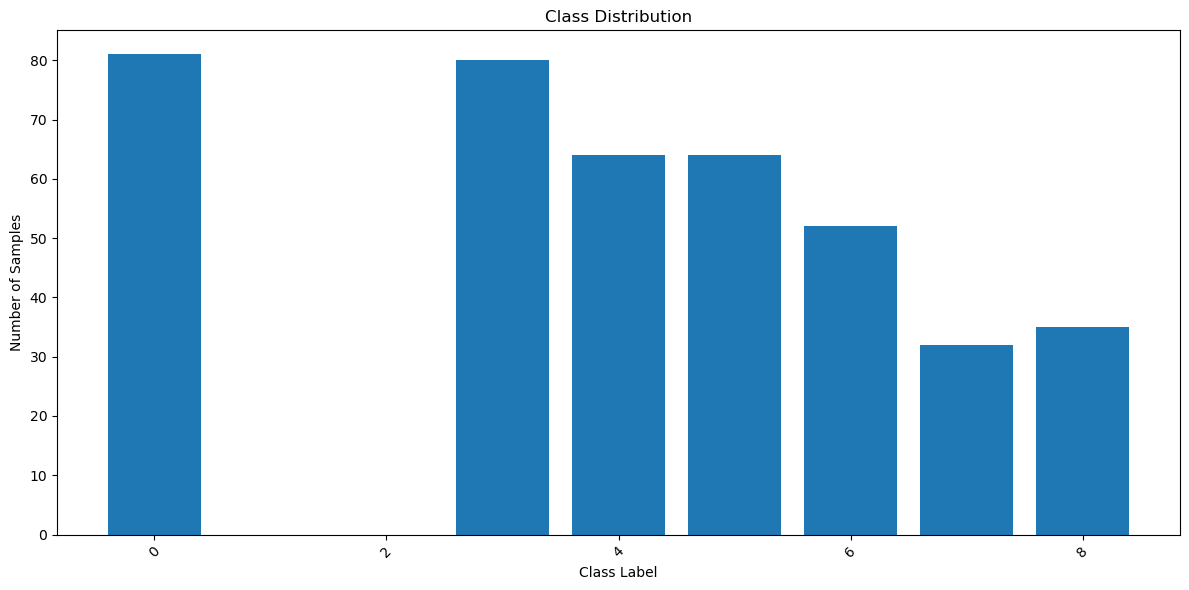


2. Analyzing channel statistics...

=== CHANNEL STATISTICS ===
AccelX(g):
  Mean: -0.271 ± 0.341
  Std:  0.432 ± 0.264
  Range: [-1.389, 0.985]
AccelY(g):
  Mean: -0.029 ± 0.483
  Std:  0.456 ± 0.306
  Range: [-1.237, 1.123]
AccelZ(g):
  Mean: 0.397 ± 0.337
  Std:  0.371 ± 0.223
  Range: [-0.740, 1.421]
GyroX(deg/s):
  Mean: 0.674 ± 7.328
  Std:  53.659 ± 48.474
  Range: [-156.922, 166.350]
GyroY(deg/s):
  Mean: 0.249 ± 7.363
  Std:  55.467 ± 41.998
  Range: [-177.246, 174.962]
GyroZ(deg/s):
  Mean: -0.142 ± 4.402
  Std:  48.143 ± 34.705
  Range: [-162.140, 160.896]
DistanceLeft(cm):
  Mean: 42.087 ± 24.671
  Std:  41.942 ± 19.238
  Range: [1.284, 169.946]
DistanceRight(cm):
  Mean: 58.647 ± 33.305
  Std:  43.423 ± 20.457
  Range: [2.625, 172.309]

3. Analyzing temporal patterns...


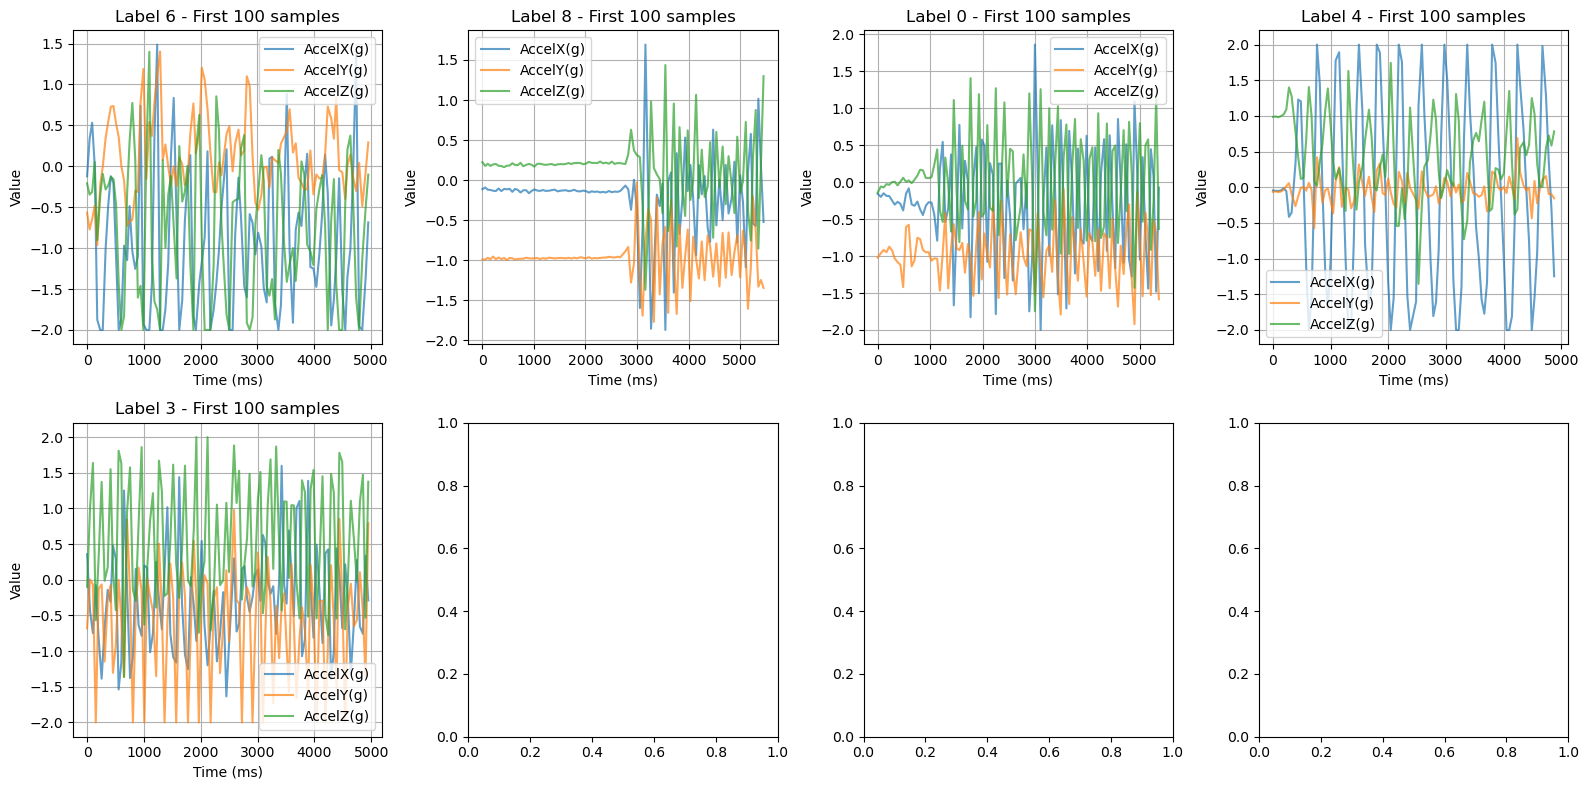


4. Checking label-data consistency...

=== LABEL-DATA CONSISTENCY ===
Label 6: IMU activity=61.934, Sonar distances=99.4/56.4cm
Label 6: IMU activity=55.682, Sonar distances=43.2/76.3cm
Label 6: IMU activity=61.702, Sonar distances=79.5/36.9cm
Label 6: IMU activity=67.654, Sonar distances=37.9/83.0cm
Label 8: IMU activity=45.311, Sonar distances=56.7/96.1cm
Label 8: IMU activity=44.995, Sonar distances=73.1/78.8cm
Label 8: IMU activity=39.227, Sonar distances=64.3/94.2cm
Label 8: IMU activity=36.490, Sonar distances=90.6/79.7cm
Label 0: IMU activity=41.473, Sonar distances=56.0/91.0cm
Label 0: IMU activity=48.289, Sonar distances=18.1/80.4cm

5. Analyzing feature separability...


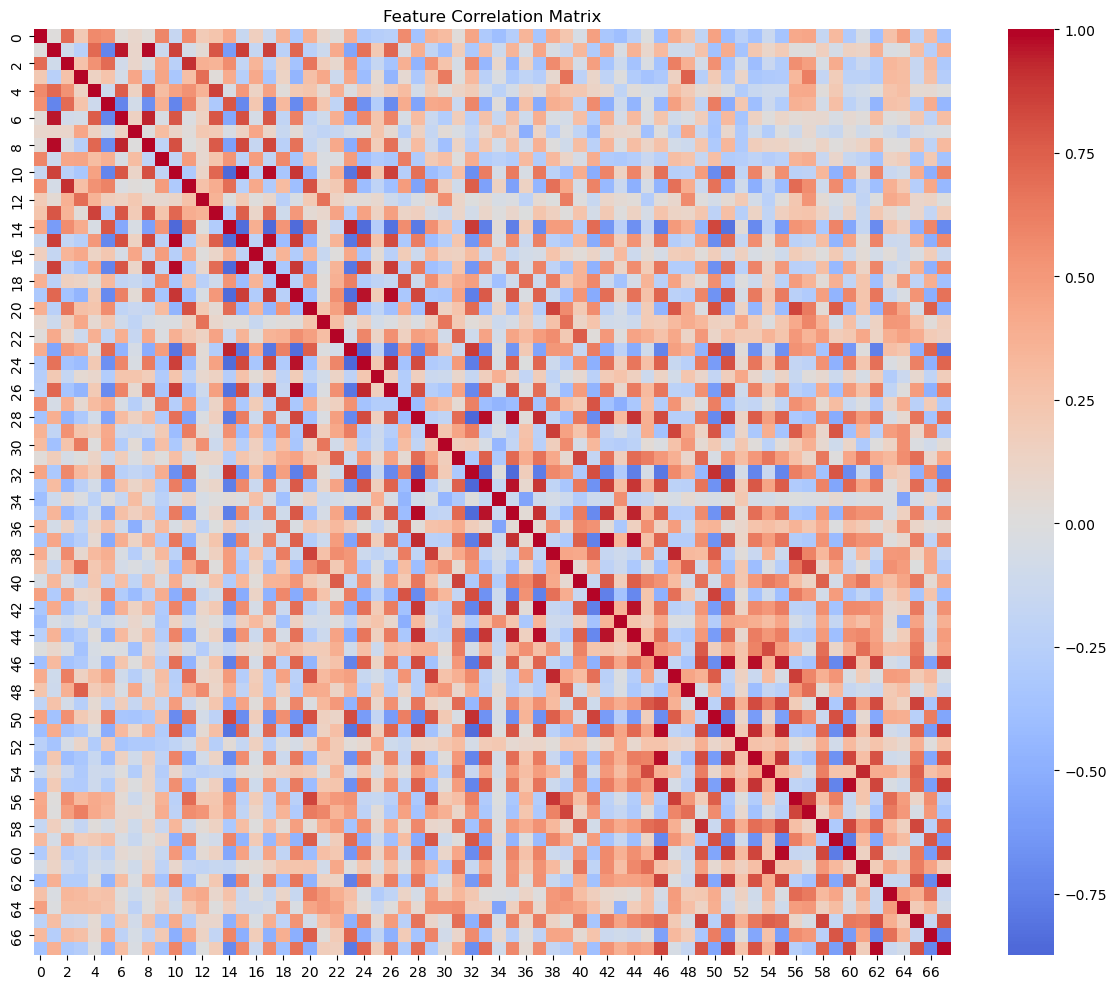


6. Analyzing cross-channel correlations...
Analyzing cross-channel correlations...


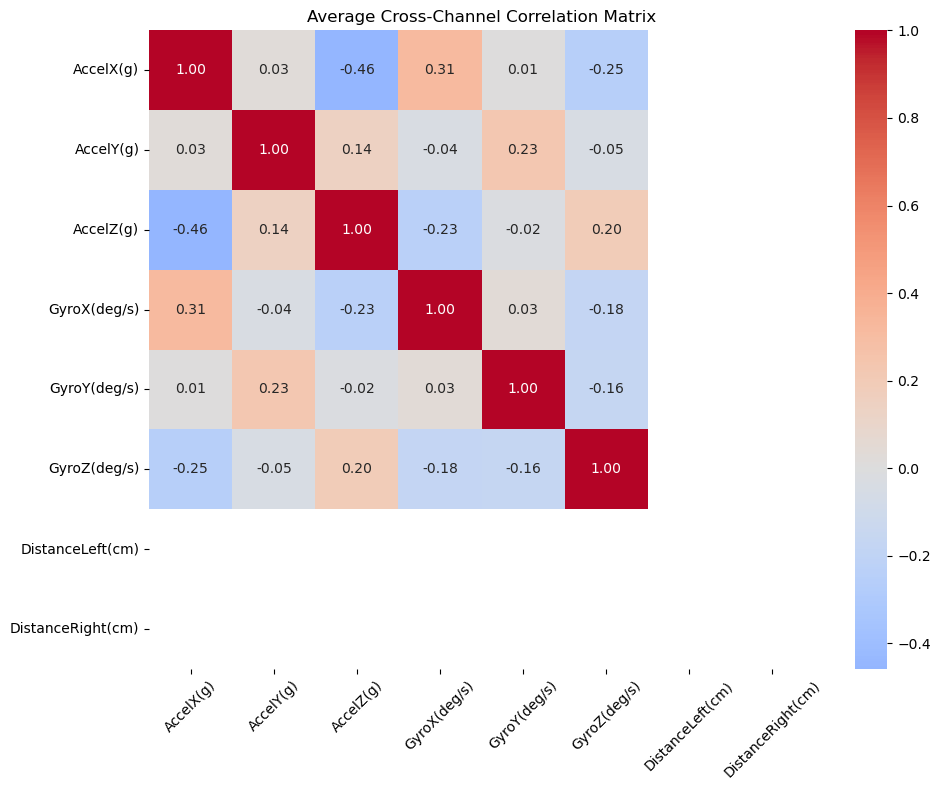


7. Analyzing class separability...
Extracting features for class separability analysis...
Performing PCA...


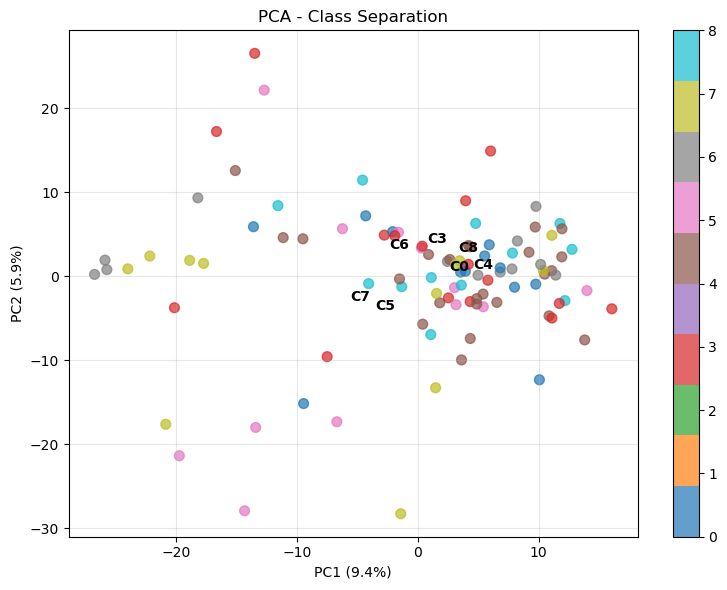

PCA explained variance: [0.09367737 0.05854024]

8. Analyzing temporal patterns by class...
Analyzing temporal patterns by class...


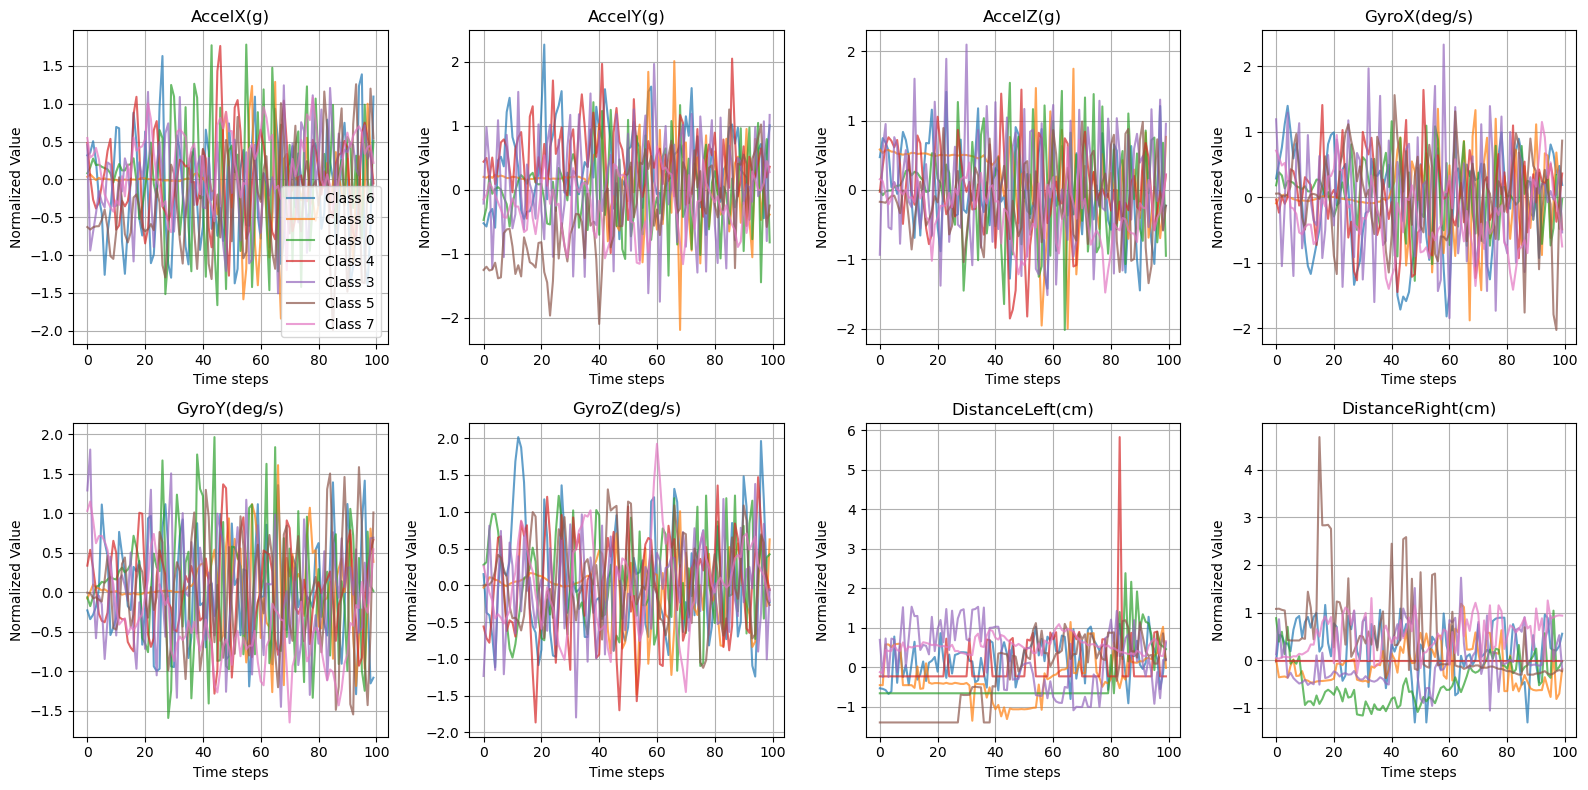


9. Analyzing class confusion...
Analyzing potential class confusion...


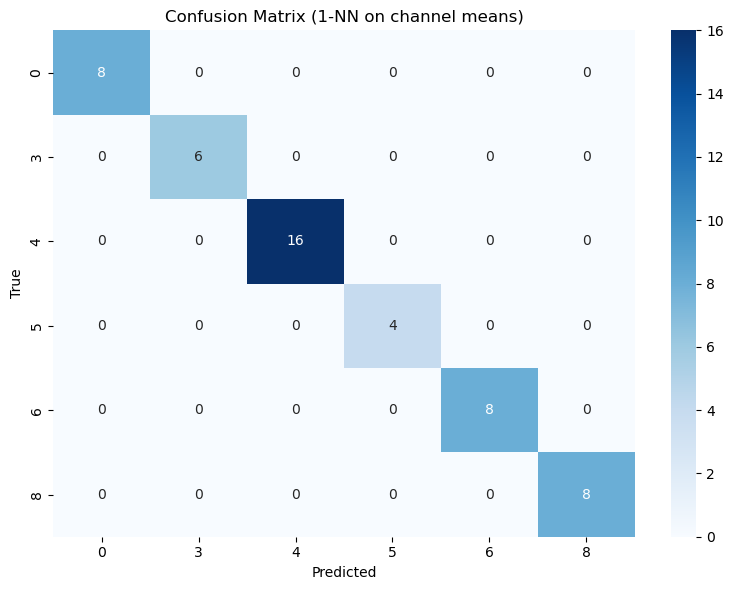

Class confusion analysis:

=== ANALYSIS COMPLETE ===
Key findings:
- 7 unique classes
- Sample distribution: ['0:81', '3:80', '4:64', '5:64', '6:52', '7:32', '8:35']
- Average IMU std deviation: 0.420

Channel value ranges:
  AccelX(g): [-1.389, 0.985]
  AccelY(g): [-1.237, 1.123]
  AccelZ(g): [-0.740, 1.421]
  GyroX(deg/s): [-156.922, 166.350]
  GyroY(deg/s): [-177.246, 174.962]
  GyroZ(deg/s): [-162.140, 160.896]
  DistanceLeft(cm): [1.284, 169.946]
  DistanceRight(cm): [2.625, 172.309]


In [7]:
# dataset_analysis.py
import sys

# Create dataset instance
dataset = IMUSonarFromJSON(
    json_file=f"{DATAFILES_DIR}/train_split.json",
    target_length=600,
    window_length=128,
    stride=32,
    add_noise=True
)

print(f"Dataset loaded: {len(dataset.samples)} samples")
print(f"Total windows: {len(dataset)}")
print(f"Window length: 128, Stride: 32")
print("=" * 60)

# Run all analyses
print("\n1. Analyzing class distribution...")
class_dist = dataset.analyze_class_distribution()

print("\n2. Analyzing channel statistics...")
channel_stats = dataset.analyze_channel_statistics()

print("\n3. Analyzing temporal patterns...")
dataset.analyze_temporal_patterns()

print("\n4. Checking label-data consistency...")
dataset.verify_label_consistency()

print("\n5. Analyzing feature separability...")
feature_matrix, labels = dataset.analyze_feature_separability()

print("\n6. Analyzing cross-channel correlations...")
corr_matrix = dataset.analyze_cross_channel_correlations()

print("\n7. Analyzing class separability...")
features, labels = dataset.analyze_class_separability(max_samples=100)

print("\n8. Analyzing temporal patterns by class...")
class_patterns = dataset.analyze_temporal_patterns_by_class()

print("\n9. Analyzing class confusion...")
confusion_matrix = dataset.analyze_class_overlap_confusion()

print("\n=== ANALYSIS COMPLETE ===")
print(f"Key findings:")
print(f"- {len(class_dist)} unique classes")
print(f"- Sample distribution: {[f'{k}:{v}' for k, v in sorted(class_dist.items())]}")
# Correct way to access channel statistics
if channel_stats:
    accel_std_means = [np.mean(channel_stats['AccelX(g)']['std']), 
                      np.mean(channel_stats['AccelY(g)']['std']),
                      np.mean(channel_stats['AccelZ(g)']['std'])]
    print(f"- Average IMU std deviation: {np.mean(accel_std_means):.3f}")
    
    # Show range of values for each channel
    print("\nChannel value ranges:")
    for col in dataset.cols:
        min_vals = channel_stats[col]['min']
        max_vals = channel_stats[col]['max']
        print(f"  {col}: [{np.mean(min_vals):.3f}, {np.mean(max_vals):.3f}]")

Dataset loaded: 408 samples
Total windows: 6120
Window length: 128, Stride: 32

1. Analyzing class distribution...
=== CLASS DISTRIBUTION ===
Label 0: 81 samples (19.9%)
Label 3: 80 samples (19.6%)
Label 4: 64 samples (15.7%)
Label 5: 64 samples (15.7%)
Label 6: 52 samples (12.7%)
Label 7: 32 samples (7.8%)
Label 8: 35 samples (8.6%)


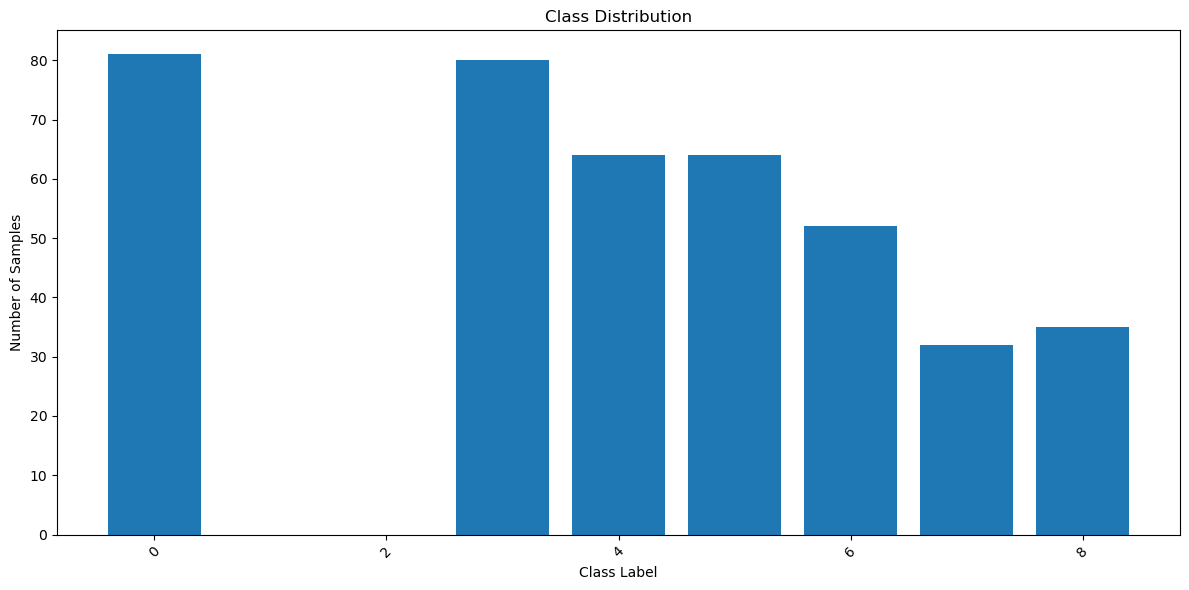


2. Analyzing channel statistics...

=== CHANNEL STATISTICS ===
AccelX(g):
  Mean: -0.271 ± 0.341
  Std:  0.432 ± 0.264
  Range: [-1.389, 0.985]
AccelY(g):
  Mean: -0.029 ± 0.483
  Std:  0.456 ± 0.306
  Range: [-1.237, 1.123]
AccelZ(g):
  Mean: 0.397 ± 0.337
  Std:  0.371 ± 0.223
  Range: [-0.740, 1.421]
GyroX(deg/s):
  Mean: 0.674 ± 7.328
  Std:  53.659 ± 48.474
  Range: [-156.922, 166.350]
GyroY(deg/s):
  Mean: 0.249 ± 7.363
  Std:  55.467 ± 41.998
  Range: [-177.246, 174.962]
GyroZ(deg/s):
  Mean: -0.142 ± 4.402
  Std:  48.143 ± 34.705
  Range: [-162.140, 160.896]
DistanceLeft(cm):
  Mean: 42.087 ± 24.671
  Std:  41.942 ± 19.238
  Range: [1.284, 169.946]
DistanceRight(cm):
  Mean: 58.647 ± 33.305
  Std:  43.423 ± 20.457
  Range: [2.625, 172.309]

3. Inspecting preprocessing effects...
=== PREPROCESSING EFFECTS ANALYSIS ===

--- Sample 1, Label 6 ---
Label 6 - Channel Statistics Comparison:
Channel         | Raw Mean ± Std     | Processed Mean ± Std
----------------------------------


--- Sample 2, Label 6 ---
Label 6 - Channel Statistics Comparison:
Channel         | Raw Mean ± Std     | Processed Mean ± Std
-------------------------------------------------------
AccelX(g)       | -0.653 ± 0.976 | -0.327 ± 0.631
AccelY(g)       | -0.523 ± 0.672 | -0.261 ± 0.373
AccelZ(g)       | -0.291 ± 0.729 | -0.145 ± 0.472
GyroX(deg/s)    | -29.182 ± 59.564 | -0.146 ± 0.330
GyroY(deg/s)    | -11.676 ± 169.101 | -0.058 ± 1.091
GyroZ(deg/s)    |  4.996 ± 54.801 |  0.025 ± 0.324
DistanceLeft(cm) | 42.044 ± 52.454 |  0.252 ± 0.215
DistanceRight(cm) | 76.892 ± 36.170 |  0.164 ± 0.132

Total variance: 5883.618 → 0.314
Variance ratio: 0.000


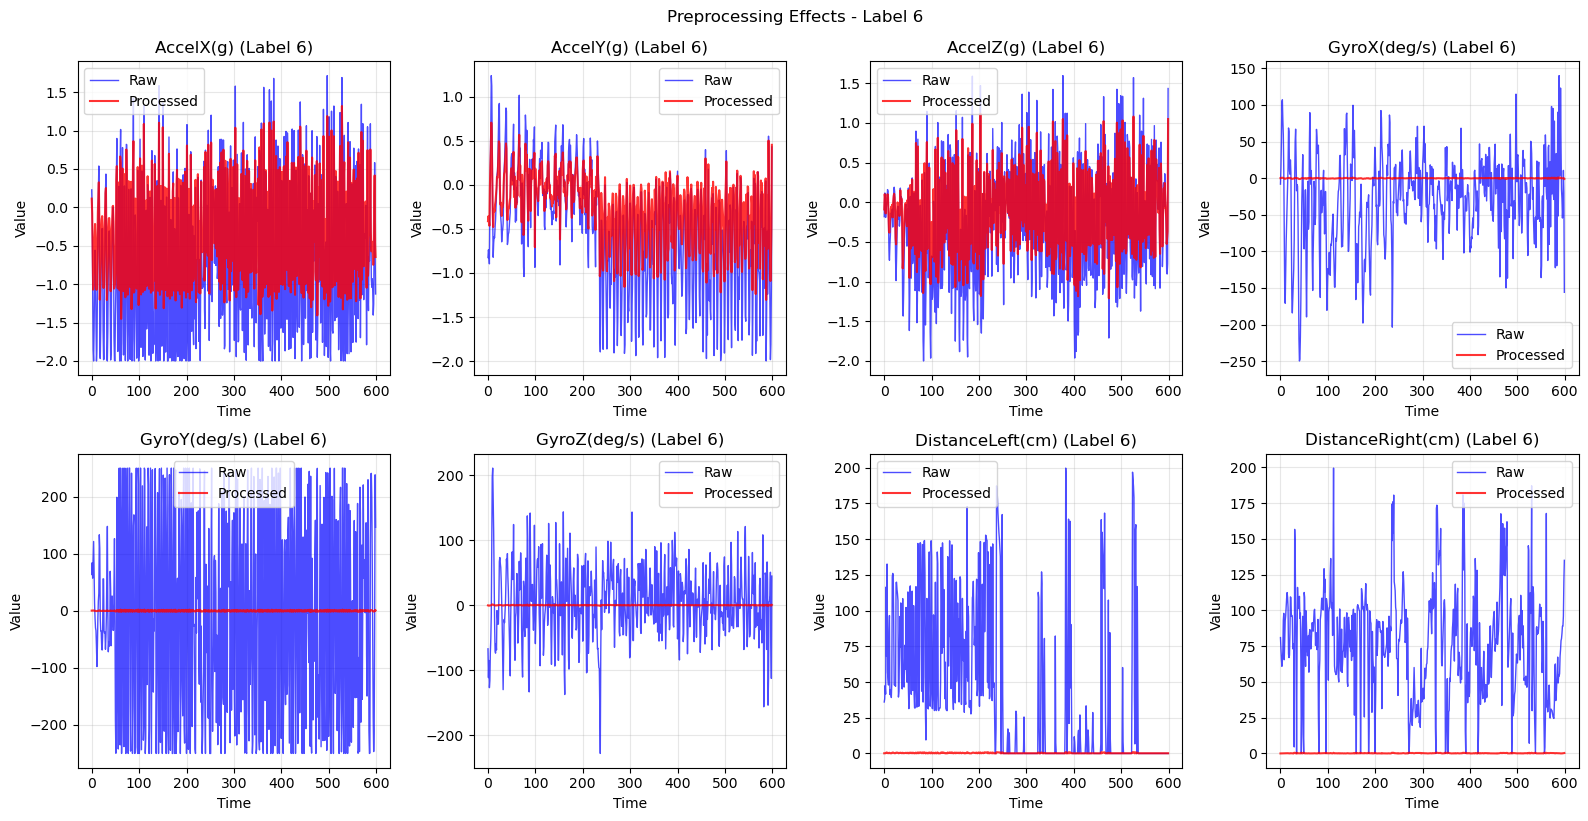


--- Sample 3, Label 6 ---
Label 6 - Channel Statistics Comparison:
Channel         | Raw Mean ± Std     | Processed Mean ± Std
-------------------------------------------------------
AccelX(g)       | -0.663 ± 0.653 | -0.331 ± 0.408
AccelY(g)       | -0.103 ± 0.441 | -0.052 ± 0.260
AccelZ(g)       | -0.873 ± 0.691 | -0.436 ± 0.425
GyroX(deg/s)    | -34.505 ± 108.874 | -0.172 ± 0.654
GyroY(deg/s)    | -9.300 ± 137.685 | -0.046 ± 0.855
GyroZ(deg/s)    | -25.812 ± 78.526 | -0.129 ± 0.462
DistanceLeft(cm) | 79.982 ± 53.910 |  0.281 ± 0.170
DistanceRight(cm) | 38.014 ± 41.241 |  0.338 ± 0.314

Total variance: 6387.355 → 0.303
Variance ratio: 0.000


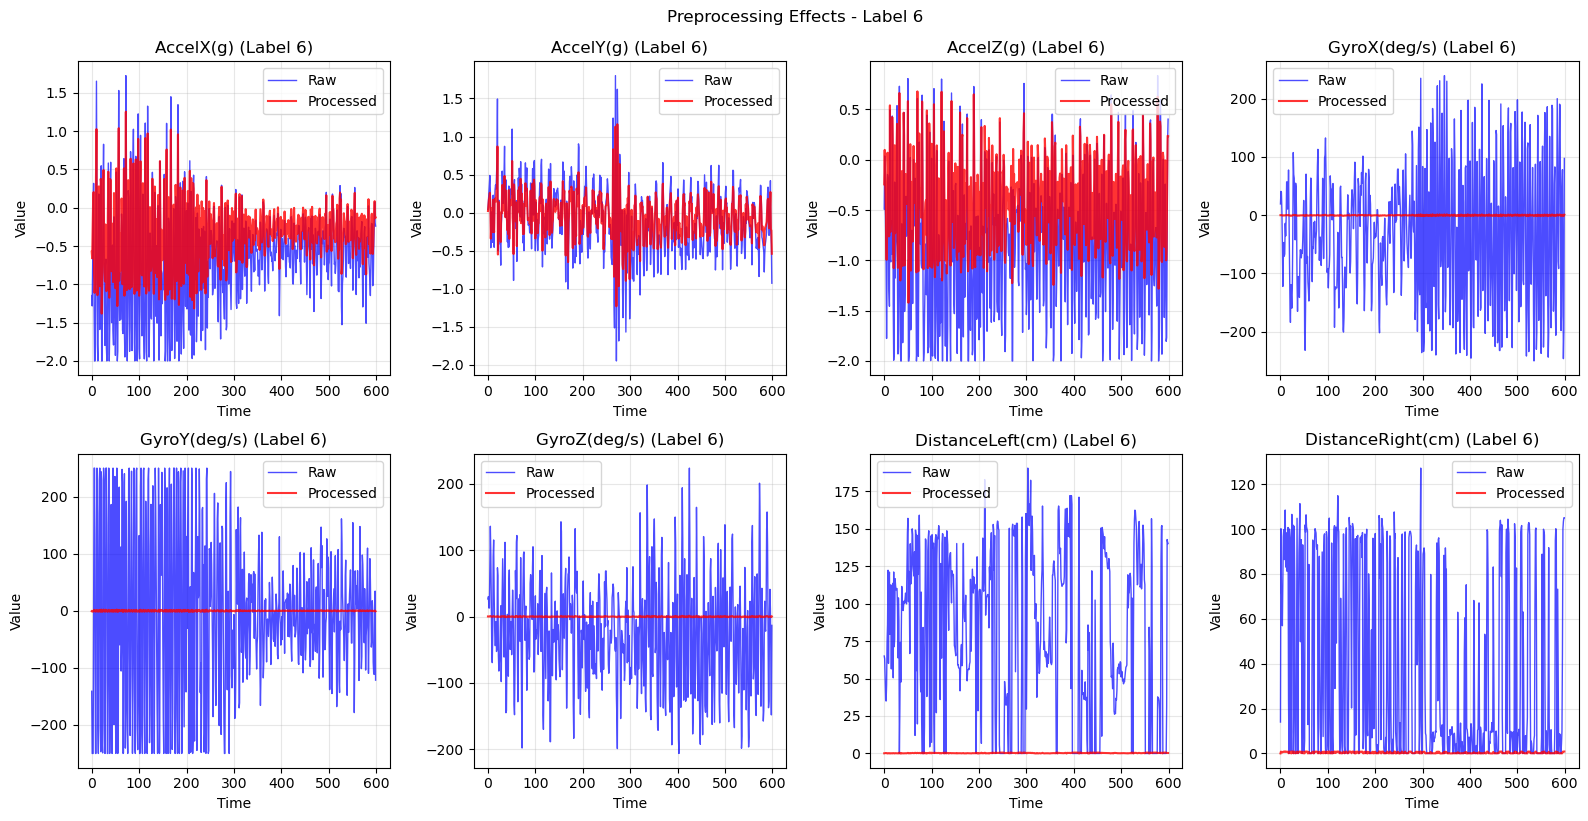


4. Analyzing feature distributions...
=== FEATURE DISTRIBUTION ANALYSIS ===



5. Analyzing class separability improvement...
=== CLASS SEPARABILITY IMPROVEMENT ===


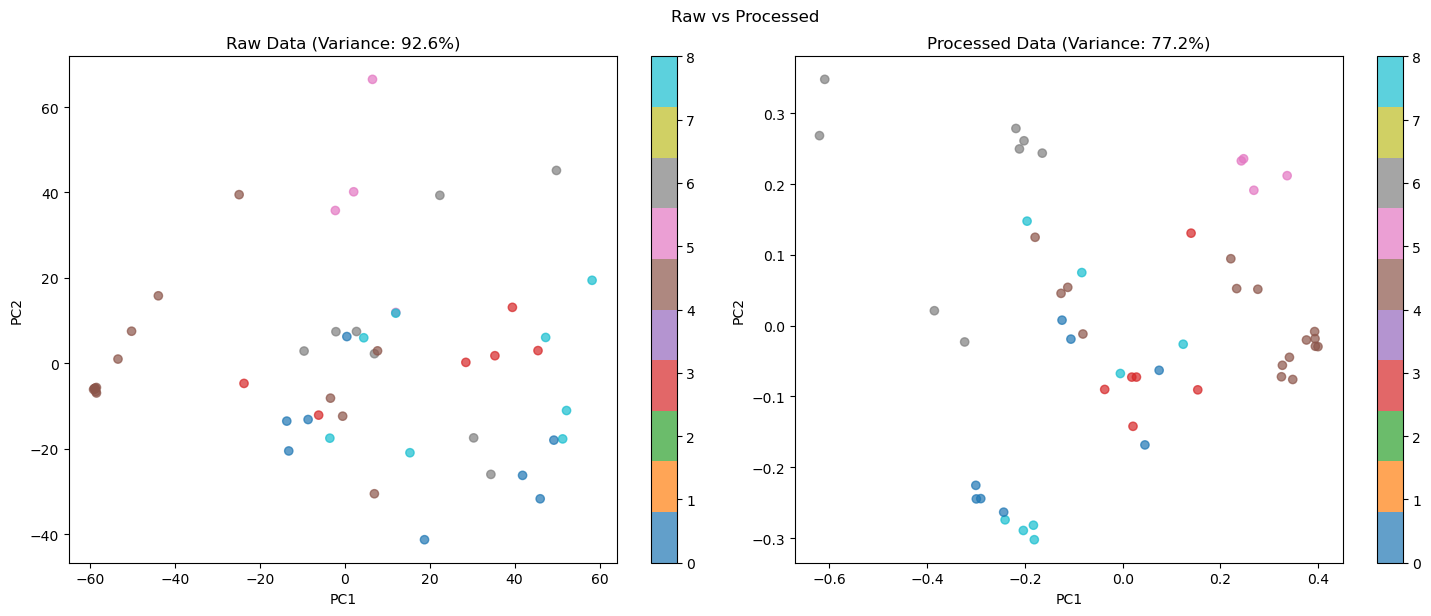

Raw PCA explained variance: [0.69255203 0.23299743]
Processed PCA explained variance: [0.55406684 0.21841647]
Variance improvement: -15.307%

6. Analyzing cross-channel correlations...
Analyzing cross-channel correlations...


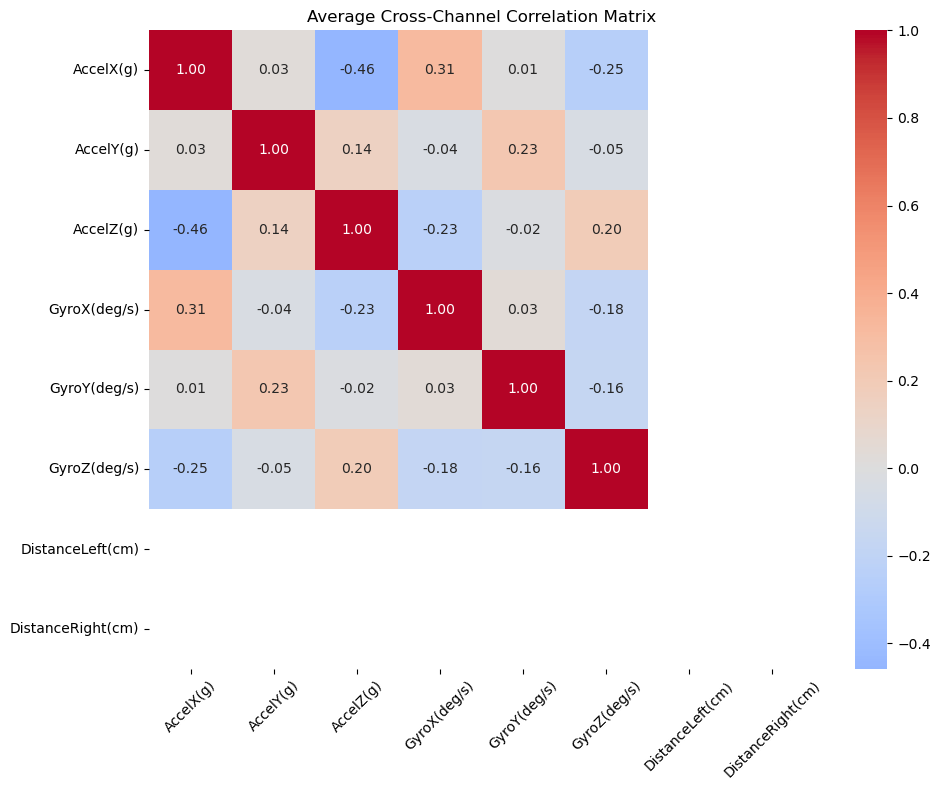


=== ANALYSIS COMPLETE ===


In [18]:
# dataset_analysis.py
import sys

# Create dataset instance
dataset = IMUSonarFromJSON(
    json_file=f"{DATAFILES_DIR}/train_split.json",
    target_length=600,
    window_length=128,
    stride=32,
    add_noise=True
)

print(f"Dataset loaded: {len(dataset.samples)} samples")
print(f"Total windows: {len(dataset)}")
print(f"Window length: 128, Stride: 32")
print("=" * 60)

# Run comprehensive analysis
print("\n1. Analyzing class distribution...")
class_dist = dataset.analyze_class_distribution()

print("\n2. Analyzing channel statistics...")
channel_stats = dataset.analyze_channel_statistics()

print("\n3. Inspecting preprocessing effects...")
dataset.inspect_preprocessing_effects(num_samples=3)

print("\n4. Analyzing feature distributions...")
dataset.analyze_feature_distributions()

print("\n5. Analyzing class separability improvement...")
dataset.analyze_class_separability_improvement()

print("\n6. Analyzing cross-channel correlations...")
corr_matrix = dataset.analyze_cross_channel_correlations()

print("\n=== ANALYSIS COMPLETE ===")

In [73]:
import os
import torch
import numpy as np
import random
from torch.utils.data import DataLoader
from torch.optim import Adam
from time import time
from collections import defaultdict

# Set seeds for reproducibility (we'll use different seeds for each model)
seeds = [42, 123, 456, 789, 101112]  # Different seeds for ensemble diversity

# Device setup
device = torch.device("mps" if torch.backends.mps.is_available() else 
                     "cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ---------------- Ensemble Training Function ----------------
def train_single_model(seed, model_name):
    """Train a single model with given seed"""
    print(f"\n=== Training Model {model_name} with seed {seed} ===")
    
    # Set seeds for reproducibility
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    
    # Data preparation (same as before)
    with open(f"{DATAFILES_DIR}/compressed_label_map.json", 'r') as f:
        label_map = json.load(f)
    
    train_dataset = IMUSonarFromJSON(
        f"{DATAFILES_DIR}/train_split.json",
        label_map=label_map,
        target_length=600,
        add_noise=False,
        noise_level=0.01
    )
    test_dataset = IMUSonarFromJSON(
        f"{DATAFILES_DIR}/test_split.json",
        label_map=label_map,
        target_length=600
    )
    
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0, drop_last=False)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0, drop_last=False)
    
    # Model setup
    sample_raw, sample_psd, _ = train_dataset[0]
    num_channels = sample_raw.shape[0]
    psd_bins = sample_psd.shape[1]
    num_classes = len(label_map)
    
    model = SimpleIMUSonarNet(
        num_channels=num_channels,
        num_classes=num_classes,
        psd_bins=psd_bins,
        dropout=0.3
    ).to(device)
    
    # Training setup
    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
    
    # Training with early stopping
    best_val_acc = 0.0
    best_model_state = None
    patience = 5
    patience_counter = 0
    
    for epoch in range(30):
        # Training
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        epoch_start = time()
        
        for raw_batch, psd_batch, labels in train_loader:
            raw_batch = raw_batch.to(device)
            psd_batch = psd_batch.to(device)
            labels = labels.to(device).long()
            
            optimizer.zero_grad()
            outputs = model(raw_batch, psd_batch)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)
        
        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        
        with torch.no_grad():
            for raw_batch, psd_batch, labels in test_loader:
                raw_batch = raw_batch.to(device)
                psd_batch = psd_batch.to(device)
                labels = labels.to(device).long()
                
                outputs = model(raw_batch, psd_batch)
                val_loss += criterion(outputs, labels).item()
                _, predicted = outputs.max(1)
                val_correct += predicted.eq(labels).sum().item()
                val_total += labels.size(0)
        
        train_loss = running_loss / len(train_loader)
        train_acc = correct / total
        val_loss = val_loss / len(test_loader)
        val_acc = val_correct / val_total
        
        # Early stopping
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1} with val acc: {best_val_acc:.4f}")
            break
    
    # Save the best model
    model.load_state_dict(best_model_state)
    torch.save(model.state_dict(), f"model_{model_name}.pth")
    
    # Final evaluation
    def evaluate_model(model, loader):
        model.eval()
        correct = 0
        all_probs = []
        with torch.no_grad():
            for raw_batch, psd_batch, labels in loader:
                raw_batch = raw_batch.to(device)
                psd_batch = psd_batch.to(device)
                labels = labels.to(device).long()
                
                outputs = model(raw_batch, psd_batch)
                probs = torch.softmax(outputs, dim=1)
                _, predicted = outputs.max(1)
                correct += predicted.eq(labels).sum().item()
                all_probs.append(probs.cpu())
        
        accuracy = correct / len(loader.dataset)
        all_probs = torch.cat(all_probs, dim=0)
        return accuracy, all_probs
    
    test_acc, test_probs = evaluate_model(model, test_loader)
    print(f"Model {model_name} Test Accuracy: {test_acc:.4f}")
    
    return model, test_acc, test_probs

# ---------------- Train Ensemble ----------------
ensemble_models = []
ensemble_probs = []
ensemble_accuracies = []

for i, seed in enumerate(seeds):
    model, acc, probs = train_single_model(seed, f"model_{i+1}")
    ensemble_models.append(model)
    ensemble_accuracies.append(acc)
    ensemble_probs.append(probs)
    
    print(f"Model {i+1} accuracy: {acc:.4f}")

# ---------------- Ensemble Prediction ----------------
def ensemble_predict(probs_list, method='average'):
    """Combine predictions from multiple models"""
    if method == 'average':
        # Average probabilities
        avg_probs = torch.stack(probs_list).mean(dim=0)
        predictions = avg_probs.argmax(dim=1)
    elif method == 'majority':
        # Majority voting
        individual_preds = [p.argmax(dim=1) for p in probs_list]
        stacked_preds = torch.stack(individual_preds)
        predictions, _ = torch.mode(stacked_preds, dim=0)
    
    return predictions

# Evaluate ensemble
ensemble_preds = ensemble_predict(ensemble_probs, method='average')
true_labels = []

with torch.no_grad():
    for _, _, labels in test_loader:
        true_labels.extend(labels.cpu().numpy())

true_labels = np.array(true_labels)
ensemble_accuracy = (ensemble_preds.numpy() == true_labels).mean()

print(f"\n=== Ensemble Results ===")
print(f"Individual model accuracies: {[f'{acc:.4f}' for acc in ensemble_accuracies]}")
print(f"Average individual accuracy: {np.mean(ensemble_accuracies):.4f}")
print(f"Ensemble accuracy: {ensemble_accuracy:.4f}")

# Save ensemble info
ensemble_info = {
    'model_paths': [f"model_{i+1}.pth" for i in range(len(seeds))],
    'accuracies': ensemble_accuracies,
    'ensemble_accuracy': ensemble_accuracy
}

torch.save(ensemble_info, 'ensemble_info.pth')

Using device: mps

=== Training Model model_1 with seed 42 ===
Early stopping at epoch 17 with val acc: 0.6612
Model model_1 Test Accuracy: 0.6612
Model 1 accuracy: 0.6612

=== Training Model model_2 with seed 123 ===
Early stopping at epoch 26 with val acc: 0.7025
Model model_2 Test Accuracy: 0.6860
Model 2 accuracy: 0.6860

=== Training Model model_3 with seed 456 ===


KeyboardInterrupt: 

In [77]:
import os
import torch
import numpy as np
import random
from torch.utils.data import DataLoader
from torch.optim import Adam
from time import time
from collections import defaultdict

# Device setup
device = torch.device("mps" if torch.backends.mps.is_available() else 
                     "cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ---------------- Enhanced Training Function with Proper Data Handling ----------------
def train_single_model(seed, model_name, save_dir="models"):
    """Train a single model with given seed and proper data separation"""
    os.makedirs(save_dir, exist_ok=True)
    
    print(f"\n=== Training Model {model_name} with seed {seed} ===")
    
    # Set seeds for THIS model only
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    
    # Data preparation - reload data for each model to ensure different shuffling
    with open(f"{DATAFILES_DIR}/compressed_label_map.json", 'r') as f:
        label_map = json.load(f)
    
    # Create datasets with different random states
    train_dataset = IMUSonarFromJSON(
        f"{DATAFILES_DIR}/train_split.json",
        label_map=label_map,
        target_length=600,
        add_noise=False,  # Turn off noise for consistent evaluation
        noise_level=0.01
    )
    
    test_dataset = IMUSonarFromJSON(
        f"{DATAFILES_DIR}/test_split.json", 
        label_map=label_map,
        target_length=600
    )
    
    # Create data loaders with different shuffling for each model
    train_loader = DataLoader(
        train_dataset, 
        batch_size=32, 
        shuffle=True,  # Different shuffle for each model due to different seed
        num_workers=0,
        drop_last=False
    )
    
    test_loader = DataLoader(
        test_dataset,
        batch_size=32,
        shuffle=False,  # No shuffle for test
        num_workers=0,
        drop_last=False
    )
    
    # Model setup - reinitialize for each model
    sample_raw, sample_psd, _ = train_dataset[0]
    num_channels = sample_raw.shape[0]
    psd_bins = sample_psd.shape[1]
    num_classes = len(label_map)
    
    model = SimpleIMUSonarNet(
        num_channels=num_channels,
        num_classes=num_classes,
        psd_bins=psd_bins,
        dropout=0.3
    ).to(device)
    
    # Training setup
    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
    
    # Training with more patient early stopping
    best_val_acc = 0.0
    best_model_state = None
    patience = 8  # Increased patience for more training
    patience_counter = 0
    best_epoch = 0
    
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    
    for epoch in range(50):  # Increased max epochs
        # Training
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        epoch_start = time()
        
        for raw_batch, psd_batch, labels in train_loader:
            raw_batch = raw_batch.to(device)
            psd_batch = psd_batch.to(device)
            labels = labels.to(device).long()
            
            optimizer.zero_grad()
            outputs = model(raw_batch, psd_batch)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)
        
        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        
        with torch.no_grad():
            for raw_batch, psd_batch, labels in test_loader:
                raw_batch = raw_batch.to(device)
                psd_batch = psd_batch.to(device)
                labels = labels.to(device).long()
                
                outputs = model(raw_batch, psd_batch)
                val_loss += criterion(outputs, labels).item()
                _, predicted = outputs.max(1)
                val_correct += predicted.eq(labels).sum().item()
                val_total += labels.size(0)
        
        # Calculate metrics
        train_loss = running_loss / len(train_loader)
        train_acc = correct / total
        val_loss = val_loss / len(test_loader)
        val_acc = val_correct / val_total
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        # Enhanced early stopping with patience reset on significant improvement
        if val_acc > best_val_acc + 0.001:  # Reset patience on meaningful improvement
            best_val_acc = val_acc
            best_model_state = model.state_dict().copy()
            best_epoch = epoch
            patience_counter = 0
            # print(f"Epoch {epoch+1}: New best val_acc: {val_acc:.4f}")
        else:
            patience_counter += 1
        
        # # Print progress every few epochs
        # if (epoch + 1) % 5 == 0 or epoch == 0:
        #     print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
        #           f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}, best val_acc: {best_val_acc:.4f} at epoch {best_epoch+1}")
            break
    
    # Load the best model
    model.load_state_dict(best_model_state)
    model_path = os.path.join(save_dir, f"{model_name}.pth")
    torch.save(model.state_dict(), model_path)
    
    # Get and save predictions
    test_probs = get_model_predictions(model, test_loader)
    probs_path = os.path.join(save_dir, f"{model_name}_probs.pt")
    torch.save(test_probs, probs_path)
    
    # Calculate final accuracy
    test_acc = calculate_accuracy_from_probs(test_probs, test_dataset)
    
    # Save training history for analysis
    history_path = os.path.join(save_dir, f"{model_name}_history.pt")
    torch.save(history, history_path)
    
    return model_path, probs_path, test_acc, best_val_acc, history

# ---------------- Selective Ensemble with Diversity Metrics ----------------
def selective_ensemble_with_diversity(probs_list, accuracies, true_labels, min_improvement=0.002):
    """
    Build ensemble considering both accuracy and diversity
    """
    true_labels_tensor = torch.tensor(true_labels)
    
    # Start with best individual model
    best_idx = np.argmax(accuracies)
    selected_indices = [best_idx]
    current_probs = [probs_list[best_idx]]
    current_accuracy = accuracies[best_idx]
    
    print(f"\n=== Selective Ensemble Construction ===")
    print(f"Starting with model {best_idx+1} (acc: {current_accuracy:.4f})")
    
    # Calculate diversity scores
    diversity_scores = calculate_diversity_scores(probs_list, true_labels_tensor)
    
    # Try adding models based on diversity and accuracy
    candidate_indices = list(range(len(probs_list)))
    candidate_indices.remove(best_idx)
    
    # Sort by diversity * accuracy product
    candidate_scores = [diversity_scores[i] * accuracies[i] for i in candidate_indices]
    candidate_order = [i for _, i in sorted(zip(candidate_scores, candidate_indices), reverse=True)]
    
    for idx in candidate_order:
        # Test adding this model
        test_probs = current_probs + [probs_list[idx]]
        test_preds = ensemble_predict(test_probs, method='average')
        test_accuracy = (test_preds.numpy() == true_labels).mean()
        
        improvement = test_accuracy - current_accuracy
        
        if improvement >= min_improvement:
            selected_indices.append(idx)
            current_probs.append(probs_list[idx])
            current_accuracy = test_accuracy
            print(f"✓ Added model {idx+1} (acc: {accuracies[idx]:.4f}, "
                  f"diversity: {diversity_scores[idx]:.3f}), "
                  f"improvement: +{improvement:.4f}, ensemble: {current_accuracy:.4f}")
        else:
            print(f"✗ Skipped model {idx+1} (acc: {accuracies[idx]:.4f}, "
                  f"diversity: {diversity_scores[idx]:.3f}), "
                  f"improvement: {improvement:.4f}")
    
    return selected_indices, current_probs, current_accuracy

def calculate_diversity_scores(probs_list, true_labels):
    """Calculate how different each model's errors are"""
    diversity_scores = []
    n_models = len(probs_list)
    
    for i in range(n_models):
        # Compare this model's errors with others
        model_preds = probs_list[i].argmax(dim=1)
        model_correct = (model_preds == true_labels)
        
        diversity = 0
        for j in range(n_models):
            if i != j:
                other_preds = probs_list[j].argmax(dim=1)
                other_correct = (other_preds == true_labels)
                # Diversity: when this model is wrong, how often is the other model right?
                diversity += ((~model_correct) & other_correct).float().mean().item()
        
        diversity_scores.append(diversity / (n_models - 1))
    
    return diversity_scores

# ---------------- Main Execution ----------------
if __name__ == "__main__":
    seeds = [42, 123, 456, 789, 999, 1573, 2671, 4398, 6719, 10523, 20136, 40586]
    
    # Train models
    all_model_paths = []
    all_probs_paths = []
    all_accuracies = []
    all_val_accuracies = []
    all_histories = []
    
    for i, seed in enumerate(seeds):
        model_path, probs_path, test_acc, val_acc, history = train_single_model(seed, f"model_{i+1}")
        all_model_paths.append(model_path)
        all_probs_paths.append(probs_path)
        all_accuracies.append(test_acc)
        all_val_accuracies.append(val_acc)
        all_histories.append(history)
        
        print(f"Model {i+1} - Val: {val_acc:.4f}, Test: {test_acc:.4f}")
    
    # Load probabilities and build ensemble
    all_probs = [torch.load(path) for path in all_probs_paths]
    
    # Get true labels
    test_dataset = IMUSonarFromJSON(
        f"{DATAFILES_DIR}/test_split.json",
        label_map=json.load(open(f"{DATAFILES_DIR}/compressed_label_map.json", 'r')),
        target_length=600
    )
    true_labels = [test_dataset[i][2] for i in range(len(test_dataset))]
    
    # Build selective ensemble
    selected_indices, selected_probs, ensemble_acc = selective_ensemble_with_diversity(
        all_probs, all_accuracies, true_labels, min_improvement=0.0015
    )
    
    print(f"\nFinal selective ensemble accuracy: {ensemble_acc:.4f}")
    print(f"Selected models: {[i+1 for i in selected_indices]}")

Using device: mps

=== Training Model model_1 with seed 42 ===
Early stopping at epoch 34, best val_acc: 0.7355 at epoch 26
Model 1 - Val: 0.7355, Test: 0.6942

=== Training Model model_2 with seed 123 ===
Early stopping at epoch 36, best val_acc: 0.7190 at epoch 28
Model 2 - Val: 0.7190, Test: 0.7107

=== Training Model model_3 with seed 456 ===
Early stopping at epoch 23, best val_acc: 0.7273 at epoch 15
Model 3 - Val: 0.7273, Test: 0.7025

=== Training Model model_4 with seed 789 ===
Early stopping at epoch 32, best val_acc: 0.7603 at epoch 24
Model 4 - Val: 0.7603, Test: 0.7190

=== Training Model model_5 with seed 999 ===
Early stopping at epoch 21, best val_acc: 0.7107 at epoch 13
Model 5 - Val: 0.7107, Test: 0.7025

=== Training Model model_6 with seed 1573 ===
Early stopping at epoch 28, best val_acc: 0.7438 at epoch 20
Model 6 - Val: 0.7438, Test: 0.6860

=== Training Model model_7 with seed 2671 ===
Early stopping at epoch 42, best val_acc: 0.7273 at epoch 34
Model 7 - Val: 0

In [15]:
import os
import torch
import numpy as np
import random
from torch.utils.data import DataLoader
from torch.optim import Adam
import torch.nn as nn

# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Device setup
device = torch.device("mps" if torch.backends.mps.is_available() else 
                     "cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ---------------- Simplified Model with Regularization ----------------
class RegularizedIMUSonarNet(nn.Module):
    """
    Simplified model with better regularization for original samples only
    """
    def __init__(self, num_channels=8, num_classes=5, psd_bins=64, dropout=0.4):
        super().__init__()
        
        # --- Time domain branch (simpler) ---
        self.time_conv = nn.Sequential(
            nn.Conv1d(num_channels, 32, kernel_size=5, padding=2),
            nn.BatchNorm1d(32),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout/2),
            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool1d(1)
        )
        
        # --- PSD branch (simpler) ---
        self.psd_fc = nn.Sequential(
            nn.Linear(num_channels * psd_bins, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(128, 64),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout/2)
        )
        
        # --- Fusion and classification ---
        self.classifier = nn.Sequential(
            nn.Linear(64 + 64, 64),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(64),
            nn.Dropout(dropout),
            nn.Linear(64, num_classes)
        )
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv1d, nn.Linear)):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0.0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1.0)
                nn.init.constant_(m.bias, 0.0)
    
    def forward(self, raw_x, psd_x):
        time_features = self.time_conv(raw_x).squeeze(-1)
        psd_flat = psd_x.view(psd_x.size(0), -1)
        psd_features = self.psd_fc(psd_flat)
        combined = torch.cat([time_features, psd_features], dim=1)
        return self.classifier(combined)

# ---------------- Data Preparation ----------------
sample_raw, sample_psd, _ = train_dataset[0]
num_channels = sample_raw.shape[0]
psd_bins = sample_psd.shape[1]
num_classes = len(label_map)

print(f"Input dimensions: {num_channels} channels, {psd_bins} PSD bins, {num_classes} classes")

model = RegularizedIMUSonarNet(
    num_channels=num_channels,
    num_classes=num_classes,
    psd_bins=psd_bins,
    dropout=0.4
).to(device)

# ---------------- Improved Training Loop ----------------
epochs = 40
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=1e-3, weight_decay=1e-3)

# Simple step-based LR scheduler instead of ReduceLROnPlateau
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
best_val_acc = 0.0

for epoch in range(epochs):
    # Training
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    
    for raw_batch, psd_batch, labels in train_loader:
        raw_batch = raw_batch.to(device)
        psd_batch = psd_batch.to(device)
        labels = labels.to(device).long()
        
        if train_dataset.add_noise:
            noise = torch.randn_like(raw_batch) * train_dataset.noise_level
            raw_batch = raw_batch + noise
        
        optimizer.zero_grad()
        outputs = model(raw_batch, psd_batch)
        loss = criterion(outputs, labels)
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)
    
    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    
    with torch.no_grad():
        for raw_batch, psd_batch, labels in test_loader:
            raw_batch = raw_batch.to(device)
            psd_batch = psd_batch.to(device)
            labels = labels.to(device).long()
            
            outputs = model(raw_batch, psd_batch)
            val_loss += criterion(outputs, labels).item()
            _, predicted = outputs.max(1)
            val_correct += predicted.eq(labels).sum().item()
            val_total += labels.size(0)
    
    # Update learning rate
    scheduler.step()
    
    # Record metrics
    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    val_loss = val_loss / len(test_loader)
    val_acc = val_correct / val_total
    
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = model.state_dict().copy()
        torch.save(best_model_state, 'best_model.pth')
    
    print(f"Epoch {epoch + 1}/{epochs}")
    print(f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")
    print(f"LR: {optimizer.param_groups[0]['lr']:.2e}")
    print()

# Load best model
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"Loaded best model with validation accuracy: {best_val_acc:.4f}")

# Final evaluation
def evaluate(model, loader):
    model.eval()
    total_loss, correct = 0.0, 0
    with torch.no_grad():
        for raw_batch, psd_batch, labels in loader:
            raw_batch = raw_batch.to(device)
            psd_batch = psd_batch.to(device)
            labels = labels.to(device).long()
            outputs = model(raw_batch, psd_batch)
            total_loss += criterion(outputs, labels).item() * raw_batch.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
    return total_loss / len(loader.dataset), correct / len(loader.dataset)

train_loss, train_acc = evaluate(model, train_loader)
test_loss, test_acc = evaluate(model, test_loader)

print('Final Results:')
print(f'Train loss: {train_loss:.4f}, accuracy: {train_acc:.4f}')
print(f'Test loss: {test_loss:.4f}, accuracy: {test_acc:.4f}')
print(f'Generalization gap: {train_acc - test_acc:.4f}')

Using device: mps
Input dimensions: 8 channels, 65 PSD bins, 28 classes
Epoch 1/40
Train Loss: 4.7417 Acc: 0.0260
Val Loss: 3.2429 Acc: 0.0909
LR: 1.00e-03

Epoch 2/40
Train Loss: 4.0655 Acc: 0.0755
Val Loss: 3.0378 Acc: 0.2397
LR: 1.00e-03

Epoch 3/40
Train Loss: 3.8321 Acc: 0.1042
Val Loss: 2.8069 Acc: 0.3058
LR: 1.00e-03

Epoch 4/40
Train Loss: 3.3469 Acc: 0.1276
Val Loss: 2.6593 Acc: 0.3306
LR: 1.00e-03

Epoch 5/40
Train Loss: 3.2369 Acc: 0.1615
Val Loss: 2.5410 Acc: 0.3554
LR: 1.00e-03

Epoch 6/40
Train Loss: 3.1100 Acc: 0.1745
Val Loss: 2.4869 Acc: 0.3388
LR: 1.00e-03

Epoch 7/40
Train Loss: 2.8748 Acc: 0.2578
Val Loss: 2.4291 Acc: 0.3471
LR: 1.00e-03

Epoch 8/40
Train Loss: 2.8570 Acc: 0.2109
Val Loss: 2.3776 Acc: 0.3967
LR: 1.00e-03

Epoch 9/40
Train Loss: 2.6061 Acc: 0.2865
Val Loss: 2.3197 Acc: 0.4132
LR: 1.00e-03

Epoch 10/40
Train Loss: 2.4705 Acc: 0.2865
Val Loss: 2.2661 Acc: 0.4132
LR: 5.00e-04

Epoch 11/40
Train Loss: 2.4293 Acc: 0.3333
Val Loss: 2.2354 Acc: 0.4215
LR: 5

In [19]:
import os
import torch
import numpy as np
import random
from torch.utils.data import DataLoader
from torch.optim import Adam
import torch.nn as nn

# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Device setup
device = torch.device("mps" if torch.backends.mps.is_available() else 
                     "cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ---------------- Simple but Effective Model ----------------
class SimpleIMUSonarNet(nn.Module):
    """
    Simple but effective model - let's remove most regularization initially
    """
    def __init__(self, num_channels=8, num_classes=5, psd_bins=64):
        super().__init__()
        
        # Time domain branch
        self.time_conv = nn.Sequential(
            nn.Conv1d(num_channels, 64, kernel_size=5, padding=2),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool1d(1)
        )
        
        # PSD branch
        self.psd_fc = nn.Sequential(
            nn.Linear(num_channels * psd_bins, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
        )
        
        # Fusion and classification
        self.classifier = nn.Sequential(
            nn.Linear(128 + 128, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, num_classes)
        )
    
    def forward(self, raw_x, psd_x):
        time_features = self.time_conv(raw_x).squeeze(-1)
        psd_flat = psd_x.view(psd_x.size(0), -1)
        psd_features = self.psd_fc(psd_flat)
        combined = torch.cat([time_features, psd_features], dim=1)
        return self.classifier(combined)

# ---------------- Data Preparation ----------------
sample_raw, sample_psd, _ = train_dataset[0]
num_channels = sample_raw.shape[0]
psd_bins = sample_psd.shape[1]
num_classes = len(label_map)

print(f"Input dimensions: {num_channels} channels, {psd_bins} PSD bins, {num_classes} classes")

model = SimpleIMUSonarNet(
    num_channels=num_channels,
    num_classes=num_classes,
    psd_bins=psd_bins
).to(device)

# ---------------- Simple Training Loop ----------------
epochs = 50
criterion = nn.CrossEntropyLoss()

# Use Adam with minimal regularization initially
optimizer = Adam(model.parameters(), lr=1e-3)  # No weight decay initially

history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
best_val_acc = 0.0

for epoch in range(epochs):
    # Training
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    
    for raw_batch, psd_batch, labels in train_loader:
        raw_batch = raw_batch.to(device)
        psd_batch = psd_batch.to(device)
        labels = labels.to(device).long()
        
        # Minimal noise
        if train_dataset.add_noise:
            noise = torch.randn_like(raw_batch) * 0.005
            raw_batch = raw_batch + noise
        
        optimizer.zero_grad()
        outputs = model(raw_batch, psd_batch)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)
    
    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    
    with torch.no_grad():
        for raw_batch, psd_batch, labels in test_loader:
            raw_batch = raw_batch.to(device)
            psd_batch = psd_batch.to(device)
            labels = labels.to(device).long()
            
            outputs = model(raw_batch, psd_batch)
            val_loss += criterion(outputs, labels).item()
            _, predicted = outputs.max(1)
            val_correct += predicted.eq(labels).sum().item()
            val_total += labels.size(0)
    
    # Record metrics
    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    val_loss = val_loss / len(test_loader)
    val_acc = val_correct / val_total
    
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = model.state_dict().copy()
    
    print(f"Epoch {epoch + 1}/{epochs}")
    print(f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")
    
    # Add minimal regularization only if we start overfitting
    if epoch > 20 and train_acc - val_acc > 0.15:
        print("Adding slight regularization...")
        for param_group in optimizer.param_groups:
            param_group['weight_decay'] = 1e-5
    
    print()

# Load best model
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"Loaded best model with validation accuracy: {best_val_acc:.4f}")

# Final evaluation
def evaluate(model, loader):
    model.eval()
    total_loss, correct = 0.0, 0
    with torch.no_grad():
        for raw_batch, psd_batch, labels in loader:
            raw_batch = raw_batch.to(device)
            psd_batch = psd_batch.to(device)
            labels = labels.to(device).long()
            outputs = model(raw_batch, psd_batch)
            total_loss += criterion(outputs, labels).item() * raw_batch.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
    return total_loss / len(loader.dataset), correct / len(loader.dataset)

train_loss, train_acc = evaluate(model, train_loader)
test_loss, test_acc = evaluate(model, test_loader)

print('Final Results:')
print(f'Train loss: {train_loss:.4f}, accuracy: {train_acc:.4f}')
print(f'Test loss: {test_loss:.4f}, accuracy: {test_acc:.4f}')
print(f'Generalization gap: {train_acc - test_acc:.4f}')

Using device: mps
Input dimensions: 8 channels, 65 PSD bins, 28 classes
Epoch 1/50
Train Loss: 3.2743 Acc: 0.0990
Val Loss: 3.2233 Acc: 0.1736

Epoch 2/50
Train Loss: 3.0752 Acc: 0.1641
Val Loss: 2.9442 Acc: 0.2645

Epoch 3/50
Train Loss: 2.7867 Acc: 0.2500
Val Loss: 2.6088 Acc: 0.2810

Epoch 4/50
Train Loss: 2.4527 Acc: 0.3047
Val Loss: 2.3786 Acc: 0.3636

Epoch 5/50
Train Loss: 2.2140 Acc: 0.3333
Val Loss: 2.1812 Acc: 0.3802

Epoch 6/50
Train Loss: 2.0235 Acc: 0.4062
Val Loss: 2.0898 Acc: 0.4215

Epoch 7/50
Train Loss: 1.8419 Acc: 0.4375
Val Loss: 1.9916 Acc: 0.4215

Epoch 8/50
Train Loss: 1.7159 Acc: 0.4870
Val Loss: 1.9289 Acc: 0.4545

Epoch 9/50
Train Loss: 1.5451 Acc: 0.5260
Val Loss: 1.8711 Acc: 0.4876

Epoch 10/50
Train Loss: 1.4851 Acc: 0.5443
Val Loss: 1.8269 Acc: 0.4628

Epoch 11/50
Train Loss: 1.3322 Acc: 0.6016
Val Loss: 1.7275 Acc: 0.4876

Epoch 12/50
Train Loss: 1.2098 Acc: 0.6250
Val Loss: 1.7097 Acc: 0.5207

Epoch 13/50
Train Loss: 1.1528 Acc: 0.6641
Val Loss: 1.7416 A

In [26]:
import os
import torch
import numpy as np
import random
import json
from torch.utils.data import DataLoader, Subset
from torch.optim import Adam
import torch.nn as nn
from sklearn.model_selection import StratifiedKFold
from collections import Counter
import matplotlib.pyplot as plt

# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Device setup
device = torch.device("mps" if torch.backends.mps.is_available() else 
                     "cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ---------------- Extremely Simple Model ----------------
class TinyIMUSonarNet(nn.Module):
    def __init__(self, num_channels=8, num_classes=5, psd_bins=64):
        super().__init__()
        
        # Very simple time domain processing
        self.time_conv = nn.Sequential(
            nn.Conv1d(num_channels, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool1d(1)
        )
        
        # Simple PSD processing
        self.psd_fc = nn.Sequential(
            nn.Linear(num_channels * psd_bins, 32),
            nn.ReLU(inplace=True),
        )
        
        # Minimal classifier
        self.classifier = nn.Sequential(
            nn.Linear(16 + 32, 32),
            nn.ReLU(inplace=True),
            nn.Linear(32, num_classes)
        )
    
    def forward(self, raw_x, psd_x):
        time_features = self.time_conv(raw_x).squeeze(-1)
        psd_flat = psd_x.view(psd_x.size(0), -1)
        psd_features = self.psd_fc(psd_flat)
        combined = torch.cat([time_features, psd_features], dim=1)
        return self.classifier(combined)

# ---------------- Combine Train and Test Data ----------------
# Create a combined dataset with all available data
all_samples = train_dataset.samples + test_dataset.samples
print(f"Total samples available: {len(all_samples)}")

# Create a new dataset with all samples
class CombinedDataset(torch.utils.data.Dataset):
    def __init__(self, samples, label_map, target_length=600, add_noise=True, noise_level=0.03):
        self.samples = samples
        self.label_map = label_map
        self.target_length = target_length
        self.add_noise = add_noise
        self.noise_level = noise_level
        self.cols = IMUSonarFromJSON.cols
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        item = self.samples[idx]
        df = pd.read_csv(item['path'])
        
        # Resample to uniform shape (reuse from IMUSonarFromJSON)
        timestamps = df['Timestamp(ms)'].values.astype(np.float32)
        signals = df[self.cols].values.astype(np.float32)
        
        # Remove duplicates
        timestamps, unique_indices = np.unique(timestamps, return_index=True)
        signals = signals[unique_indices]
        
        # Interpolate to uniform time grid
        uniform_timestamps = np.linspace(timestamps[0], timestamps[-1], num=self.target_length)
        resampled = np.zeros((self.target_length, len(self.cols)), dtype=np.float32)
        for i in range(len(self.cols)):
            interp_func = interp1d(timestamps, signals[:, i], kind='linear', fill_value="extrapolate")
            resampled[:, i] = interp_func(uniform_timestamps)
        
        # Normalize
        resampled = (resampled - resampled.mean(axis=0)) / (resampled.std(axis=0) + 1e-6)
        
        # Add noise for regularization
        if self.add_noise:
            noise = np.random.normal(0, self.noise_level, size=resampled.shape).astype(np.float32)
            resampled += noise
        
        data = resampled.T  # (C, T)
        
        # Compute PSD
        total_time_sec = (df['Timestamp(ms)'].iloc[-1] - df['Timestamp(ms)'].iloc[0]) / 1000.0
        fs_est = self.target_length / total_time_sec if total_time_sec > 0 else 50.0
        psd = IMUSonarFromJSON.compute_psd(data, fs=fs_est)
        
        # Convert to tensors
        raw_tensor = torch.tensor(data, dtype=torch.float32)
        psd_tensor = torch.tensor(psd, dtype=torch.float32)
        
        label = item['label']
        label_tensor = torch.tensor(label, dtype=torch.long)
        
        return raw_tensor, psd_tensor, label_tensor

# Create combined dataset
full_dataset = CombinedDataset(all_samples, label_map, add_noise=True, noise_level=0.04)

# Get sample to determine dimensions
sample_raw, sample_psd, _ = full_dataset[0]
num_channels = sample_raw.shape[0]
psd_bins = sample_psd.shape[1]
num_classes = len(label_map)

print(f"Input dimensions: {num_channels} channels, {psd_bins} PSD bins, {num_classes} classes")
print(f"Total samples: {len(full_dataset)}")

# ---------------- K-Fold Cross Validation ----------------
# Extract labels for stratified k-fold
all_labels = [item['label'] for item in all_samples]

# 5-fold cross validation
kf = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)
fold_results = []

for fold, (train_idx, val_idx) in enumerate(kf.split(all_samples, all_labels)):
    print(f"\n=== Fold {fold + 1}/5 ===")
    
    # Create data loaders for this fold
    train_subset = Subset(full_dataset, train_idx)
    val_subset = Subset(full_dataset, val_idx)
    
    train_loader = DataLoader(train_subset, batch_size=16, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_subset, batch_size=16, shuffle=False, num_workers=0)
    
    # Create model
    model = TinyIMUSonarNet(num_channels, num_classes, psd_bins).to(device)
    optimizer = Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
    criterion = nn.CrossEntropyLoss()
    
    # Training for this fold
    best_val_acc = 0.0
    fold_history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    
    for epoch in range(80):
        # Training
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        
        for raw_batch, psd_batch, labels in train_loader:
            raw_batch = raw_batch.to(device)
            psd_batch = psd_batch.to(device)
            labels = labels.to(device).long()
            
            optimizer.zero_grad()
            outputs = model(raw_batch, psd_batch)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)
        
        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        
        with torch.no_grad():
            for raw_batch, psd_batch, labels in val_loader:
                raw_batch = raw_batch.to(device)
                psd_batch = psd_batch.to(device)
                labels = labels.to(device).long()
                
                outputs = model(raw_batch, psd_batch)
                val_loss += criterion(outputs, labels).item()
                _, predicted = outputs.max(1)
                val_correct += predicted.eq(labels).sum().item()
                val_total += labels.size(0)
        
        # Record metrics
        train_loss = running_loss / len(train_loader)
        train_acc = correct / total
        val_loss = val_loss / len(val_loader)
        val_acc = val_correct / val_total
        
        fold_history['train_loss'].append(train_loss)
        fold_history['train_acc'].append(train_acc)
        fold_history['val_loss'].append(val_loss)
        fold_history['val_acc'].append(val_acc)
        
        # Save best model for this fold
        if val_acc > best_val_acc:
            best_val_acc = val_acc
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}/80: Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")
    
    print(f"Fold {fold + 1} Best Validation Accuracy: {best_val_acc:.4f}")
    fold_results.append(best_val_acc)

# ---------------- Final Results ----------------
print(f"\n=== Cross-Validation Results ===")
print(f"Fold accuracies: {[f'{acc:.4f}' for acc in fold_results]}")
print(f"Mean CV accuracy: {np.mean(fold_results):.4f} ± {np.std(fold_results):.4f}")

# ---------------- Train Final Model on All Data ----------------
print(f"\n=== Training Final Model on All Data ===")
final_train_loader = DataLoader(full_dataset, batch_size=16, shuffle=True, num_workers=0)

final_model = TinyIMUSonarNet(num_channels, num_classes, psd_bins).to(device)
final_optimizer = Adam(final_model.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

# Train final model
for epoch in range(80):
    final_model.train()
    running_loss, correct, total = 0.0, 0, 0
    
    for raw_batch, psd_batch, labels in final_train_loader:
        raw_batch = raw_batch.to(device)
        psd_batch = psd_batch.to(device)
        labels = labels.to(device).long()
        
        final_optimizer.zero_grad()
        outputs = final_model(raw_batch, psd_batch)
        loss = criterion(outputs, labels)
        loss.backward()
        final_optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)
    
    if (epoch + 1) % 10 == 0:
        train_acc = correct / total
        print(f"Final Model Epoch {epoch + 1}/50: Train Acc: {train_acc:.4f}")

print("\n=== Training Complete ===")
print(f"Cross-validated performance: {np.mean(fold_results):.4f} ± {np.std(fold_results):.4f}")

# Save the final model
#torch.save(final_model.state_dict(), 'final_imusonar_model.pth')
#print("Final model saved as 'final_imusonar_model.pth'")

Using device: mps
Total samples available: 529
Input dimensions: 8 channels, 65 PSD bins, 28 classes
Total samples: 529

=== Fold 1/5 ===
Epoch 10/80: Train Acc: 0.3144, Val Acc: 0.2755
Epoch 20/80: Train Acc: 0.5227, Val Acc: 0.4000
Epoch 30/80: Train Acc: 0.6629, Val Acc: 0.4302
Epoch 40/80: Train Acc: 0.7614, Val Acc: 0.4566
Epoch 50/80: Train Acc: 0.8295, Val Acc: 0.4943
Epoch 60/80: Train Acc: 0.8977, Val Acc: 0.4792
Epoch 70/80: Train Acc: 0.9432, Val Acc: 0.4717
Epoch 80/80: Train Acc: 0.9621, Val Acc: 0.5094
Fold 1 Best Validation Accuracy: 0.5094

=== Fold 2/5 ===


KeyboardInterrupt: 

Using device: mps
Original train samples: 408
Original test samples: 121
Total samples available: 529
Class distribution:
Class 0: 102 samples
Class 3: 105 samples
Class 4: 85 samples
Class 5: 83 samples
Class 6: 68 samples
Class 7: 41 samples
Class 8: 45 samples

Rare classes (<5 samples): []

After grouping: 7 classes
New label map: {0: 0, 3: 1, 4: 2, 5: 3, 6: 4, 7: 5, 8: 6}
Training samples: 423
Validation samples: 106

Training with 7 classes after grouping
Input dimensions: 8 channels, 65 PSD bins

=== Starting Training ===
Epoch  Time     Train Loss Train Acc  Val Loss   Val Acc   
  1/100     2.0s    1.9072    0.2577    1.8683    0.2358
  2/100     1.2s    1.7957    0.3073    1.7570    0.3396
  3/100     1.2s    1.6011    0.4113    1.6328    0.3585
  4/100     1.2s    1.4821    0.4515    1.6016    0.3962
  5/100     1.1s    1.4067    0.5296    1.4449    0.3868
  6/100     1.1s    1.2575    0.5532    1.4964    0.4623
  7/100     1.1s    1.2825    0.5414    1.4944    0.3868
  8/10

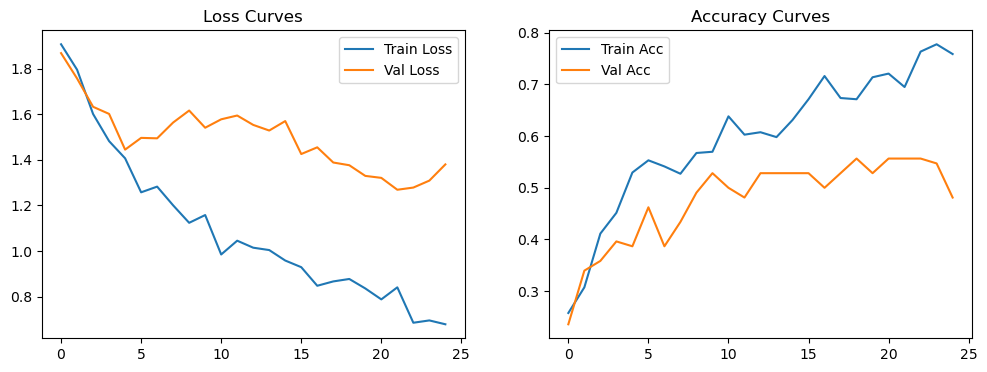

In [36]:
import os
import torch
import numpy as np
import random
import json
import pandas as pd
import time
from torch.utils.data import DataLoader, WeightedRandomSampler
from torch.optim import Adam
import torch.nn as nn
from collections import Counter
import matplotlib.pyplot as plt

# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Device setup
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")


# First, let's check what datasets you have available
print(f"Original train samples: {len(train_dataset.samples)}")
print(f"Original test samples: {len(test_dataset.samples)}")

# Combine all samples from both datasets
all_samples = train_dataset.samples + test_dataset.samples
print(f"Total samples available: {len(all_samples)}")

# ---------------- Analyze Class Distribution ----------------
train_labels = [item['label'] for item in train_dataset.samples]
test_labels = [item['label'] for item in test_dataset.samples]
all_labels = train_labels + test_labels

label_counts = Counter(all_labels)
print("Class distribution:")
for label, count in sorted(label_counts.items()):
    print(f"Class {label}: {count} samples")

# Identify classes with very few samples
rare_classes = [label for label, count in label_counts.items() if count < 5]
print(f"\nRare classes (<5 samples): {rare_classes}")

# ---------------- Class Grouping Strategy ----------------
def group_classes(label):
    if label in rare_classes:
        return 999  # "other" class
    return label

# Apply grouping to all samples
for item in all_samples:
    item['label'] = group_classes(item['label'])

# Update label map
unique_labels = sorted(set(item['label'] for item in all_samples))
new_label_map = {label: i for i, label in enumerate(unique_labels)}
num_classes = len(new_label_map)

print(f"\nAfter grouping: {num_classes} classes")
print(f"New label map: {new_label_map}")

# ---------------- Create Validation Split ----------------
# Split all_samples into train and validation
from sklearn.model_selection import train_test_split

train_samples, val_samples = train_test_split(
    all_samples, test_size=0.2, random_state=42, stratify=[item['label'] for item in all_samples]
)

print(f"Training samples: {len(train_samples)}")
print(f"Validation samples: {len(val_samples)}")

# ---------------- Balanced Sampling ----------------
label_counts = Counter([item['label'] for item in train_samples])
class_weights = {label: 1.0 / count for label, count in label_counts.items()}
sample_weights = [class_weights[item['label']] for item in train_samples]

sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

# ---------------- Enhanced Data Augmentation ----------------
class AugmentedDataset(torch.utils.data.Dataset):
    def __init__(self, samples, label_map, target_length=600, augment=True):
        self.samples = samples
        self.label_map = label_map
        self.target_length = target_length
        self.augment = augment
        self.cols = IMUSonarFromJSON.cols
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        item = self.samples[idx]
        df = pd.read_csv(item['path'])
        
        # Original processing
        timestamps = df['Timestamp(ms)'].values.astype(np.float32)
        signals = df[self.cols].values.astype(np.float32)
        
        timestamps, unique_indices = np.unique(timestamps, return_index=True)
        signals = signals[unique_indices]
        
        uniform_timestamps = np.linspace(timestamps[0], timestamps[-1], num=self.target_length)
        resampled = np.zeros((self.target_length, len(self.cols)), dtype=np.float32)
        
        for i in range(len(self.cols)):
            interp_func = interp1d(timestamps, signals[:, i], kind='linear', fill_value="extrapolate")
            resampled[:, i] = interp_func(uniform_timestamps)
        
        # Enhanced augmentation (only for training)
        resampled = (resampled - resampled.mean(axis=0)) / (resampled.std(axis=0) + 1e-6)
        
        if self.augment:
            # Multiple augmentation techniques
            noise = np.random.normal(0, 0.05, size=resampled.shape).astype(np.float32)
            resampled += noise
            
            # Random scaling
            scale = np.random.uniform(0.9, 1.1)
            resampled *= scale
            
            # Random time warping
            if np.random.random() > 0.5:
                warp_factor = np.random.uniform(0.8, 1.2)
                new_length = int(self.target_length * warp_factor)
                warped = np.zeros((new_length, len(self.cols)), dtype=np.float32)
                for i in range(len(self.cols)):
                    warped[:, i] = np.interp(
                        np.linspace(0, self.target_length-1, new_length),
                        np.arange(self.target_length),
                        resampled[:, i]
                    )
                if new_length > self.target_length:
                    resampled = warped[:self.target_length, :]
                else:
                    resampled = np.pad(warped, ((0, self.target_length - new_length), (0, 0)), mode='edge')
        
        data = resampled.T
        
        # Compute PSD
        total_time_sec = (df['Timestamp(ms)'].iloc[-1] - df['Timestamp(ms)'].iloc[0]) / 1000.0
        fs_est = self.target_length / total_time_sec if total_time_sec > 0 else 50.0
        psd = IMUSonarFromJSON.compute_psd(data, fs=fs_est)
        
        # Convert to tensors
        raw_tensor = torch.tensor(data, dtype=torch.float32)
        psd_tensor = torch.tensor(psd, dtype=torch.float32)
        
        label = self.label_map[item['label']]
        label_tensor = torch.tensor(label, dtype=torch.long)
        
        return raw_tensor, psd_tensor, label_tensor

# ---------------- Create Datasets and DataLoaders ----------------
train_dataset_aug = AugmentedDataset(train_samples, new_label_map, augment=True)
val_dataset = AugmentedDataset(val_samples, new_label_map, augment=False)

train_loader = DataLoader(train_dataset_aug, batch_size=16, sampler=sampler, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=0)

# Get sample dimensions
sample_raw, sample_psd, _ = train_dataset_aug[0]
num_channels = sample_raw.shape[0]
psd_bins = sample_psd.shape[1]

print(f"\nTraining with {num_classes} classes after grouping")
print(f"Input dimensions: {num_channels} channels, {psd_bins} PSD bins")

# ---------------- Model ----------------
class SimpleIMUSonarNet(nn.Module):
    def __init__(self, num_channels=8, num_classes=5, psd_bins=64):
        super().__init__()
        
        self.time_features = nn.Sequential(
            nn.Conv1d(num_channels, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)
        )
        
        self.psd_features = nn.Sequential(
            nn.Linear(num_channels * psd_bins, 64),
            nn.ReLU(),
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(32 + 64, 48),
            nn.ReLU(),
            nn.Linear(48, num_classes)
        )
    
    def forward(self, raw_x, psd_x):
        time_feat = self.time_features(raw_x).squeeze(-1)
        psd_flat = psd_x.view(psd_x.size(0), -1)
        psd_feat = self.psd_features(psd_flat)
        combined = torch.cat([time_feat, psd_feat], dim=1)
        return self.classifier(combined)

model = SimpleIMUSonarNet(num_channels, num_classes, psd_bins).to(device)
optimizer = Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

# ---------------- Training Loop with Detailed Output ----------------
epochs = 100
best_val_acc = 0.0
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

print(f"\n=== Starting Training ===")
print(f"{'Epoch':<6} {'Time':<8} {'Train Loss':<10} {'Train Acc':<10} {'Val Loss':<10} {'Val Acc':<10}")

for epoch in range(epochs):
    epoch_start = time.time()
    
    # Training
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    
    for raw_batch, psd_batch, labels in train_loader:
        raw_batch = raw_batch.to(device)
        psd_batch = psd_batch.to(device)
        labels = labels.to(device).long()
        
        optimizer.zero_grad()
        outputs = model(raw_batch, psd_batch)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)
    
    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    
    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    
    with torch.no_grad():
        for raw_batch, psd_batch, labels in val_loader:
            raw_batch = raw_batch.to(device)
            psd_batch = psd_batch.to(device)
            labels = labels.to(device).long()
            
            outputs = model(raw_batch, psd_batch)
            val_loss += criterion(outputs, labels).item()
            _, predicted = outputs.max(1)
            val_correct += predicted.eq(labels).sum().item()
            val_total += labels.size(0)
    
    val_loss = val_loss / len(val_loader)
    val_acc = val_correct / val_total
    
    # Record metrics
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = model.state_dict().copy()
    
    epoch_time = time.time() - epoch_start
    
    # Print detailed output every epoch
    print(f"{epoch + 1:>3}/{epochs} {epoch_time:>7.1f}s {train_loss:>9.4f} {train_acc:>9.4f} {val_loss:>9.4f} {val_acc:>9.4f}")
    
    # Early stopping check
    if epoch > 20 and val_acc < best_val_acc - 0.05:
        print("Early stopping triggered")
        break

# Load best model
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"\nLoaded best model with validation accuracy: {best_val_acc:.4f}")

print("\n=== Training Complete ===")
print(f"Best validation accuracy: {best_val_acc:.4f}")
print(f"Final training accuracy: {history['train_acc'][-1]:.4f}")

# Save model
#torch.save(model.state_dict(), 'balanced_imusonar_model.pth')
#print("Model saved as 'balanced_imusonar_model.pth'")

# Plot learning curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss Curves')

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Acc')
plt.plot(history['val_acc'], label='Val Acc')
plt.legend()
plt.title('Accuracy Curves')
plt.show()

In [51]:
import os
import torch
import torch.nn as nn
import numpy as np
import random
import json
from torch.utils.data import DataLoader
from torch.optim import Adam
from time import time
from sklearn.utils.class_weight import compute_class_weight

# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Device setup
device = torch.device("mps" if torch.backends.mps.is_available() else 
                     "cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ---------------- Model Definition ----------------
class SimpleIMUSonarNet(nn.Module):
    def __init__(self, num_channels=8, num_classes=6, psd_bins=65, dropout=0.3):
        super(SimpleIMUSonarNet, self).__init__()
        
        # # Raw signal branch
        # self.raw_branch = nn.Sequential(
        #     nn.Conv1d(num_channels, 64, kernel_size=5, padding=2),
        #     nn.ReLU(),
        #     nn.MaxPool1d(2),
        #     nn.Dropout(dropout),
            
        #     nn.Conv1d(64, 128, kernel_size=3, padding=1),
        #     nn.ReLU(),
        #     nn.MaxPool1d(2),
        #     nn.Dropout(dropout),
            
        #     nn.Conv1d(128, 256, kernel_size=3, padding=1),
        #     nn.ReLU(),
        #     nn.AdaptiveAvgPool1d(1)
        # )
        
        # # PSD branch
        # self.psd_branch = nn.Sequential(
        #     nn.Linear(psd_bins, 128),
        #     nn.ReLU(),
        #     nn.Dropout(dropout),
            
        #     nn.Linear(128, 64),
        #     nn.ReLU(),
        #     nn.Dropout(dropout)
        # )
        
        # # Combined classifier
        # combined_features = 256 + 64  # raw features + psd features
        # self.classifier = nn.Sequential(
        #     nn.Linear(combined_features, 128),
        #     nn.ReLU(),
        #     nn.Dropout(dropout),
            
        #     nn.Linear(128, 64),
        #     nn.ReLU(),
        #     nn.Dropout(dropout),
            
        #     nn.Linear(64, num_classes)
        # )
        # Enhanced raw signal branch
        self.raw_branch = nn.Sequential(
            nn.Conv1d(num_channels, 128, kernel_size=5, padding=2),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Dropout(dropout),
            
            nn.Conv1d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Dropout(dropout),
            
            nn.Conv1d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)
        )
        
        # Enhanced PSD branch
        self.psd_branch = nn.Sequential(
            nn.Linear(psd_bins, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout),
            
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        
        # Enhanced classifier
        combined_features = 512 + 128
        self.classifier = nn.Sequential(
            nn.Linear(combined_features, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout),
            
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout),
            
            nn.Linear(128, num_classes)
        )
    
    def forward(self, raw, psd):
        # Process raw signal
        raw_features = self.raw_branch(raw)
        raw_features = raw_features.squeeze(-1)  # Remove time dimension [batch, 256]
        
        # Process PSD - take mean across time dimension if needed
        if psd.dim() == 3:
            psd = psd.mean(dim=1)  # Average across time [batch, psd_bins]
        
        psd_features = self.psd_branch(psd)  # [batch, 64]
        
        # Combine features
        combined = torch.cat([raw_features, psd_features], dim=1)  # [batch, 256 + 64]
        
        # Classify
        output = self.classifier(combined)
        return output

# ---------------- Data Preparation ----------------
with open(f"{DATAFILES_DIR}/compressed_label_map.json", 'r') as f:
    label_map = json.load(f)
    
train_dataset = IMUSonarFromJSON(
    f"{DATAFILES_DIR}/train_split.json",
    label_map=label_map,
    target_length=600,
    add_noise=True,
    noise_level=0.01
)
test_dataset = IMUSonarFromJSON(
    f"{DATAFILES_DIR}/test_split.json",
    label_map=label_map,
    target_length=600
)

# ---------------- Calculate Class Weights ----------------
# Extract labels from training dataset
train_labels = []
for i in range(len(train_dataset)):
    _, _, label = train_dataset[i]
    train_labels.append(label)

test_labels = []
for i in range(len(test_dataset)):
    _, _, label = test_dataset[i]
    test_labels.append(label)

train_labels_np = np.array(train_labels)
unique_classes = np.unique(train_labels_np)
test_labels_np = np.array(test_labels)
test_classes = np.unique(test_labels_np)

print(f"Unique classes in training data: {unique_classes}")
print(f"Unique classes in test data: {test_classes}")
print(f"Compressed label map keys: {list(label_map.keys())}")
print(f"Compressed label map values: {list(label_map.values())}")

# Create a mapping from compressed labels to indices 0-8
# This ensures we have weights for all 9 classes, even if some are missing in training data
all_classes = np.arange(9)  # Classes 0-8 as numpy array
present_classes = unique_classes

# Create weight array for all 9 classes
class_weights_full = np.ones(9)  # Default weight of 1 for missing classes

# Compute weights only for classes present in training data
if len(present_classes) > 0:
    weights_present = compute_class_weight(
        'balanced', 
        classes=present_classes,  # Now a numpy array
        y=train_labels_np
    )
    
    # Assign computed weights to present classes
    for cls, weight in zip(present_classes, weights_present):
        class_weights_full[cls] = weight

print(f"Full class weights: {class_weights_full}")

# Convert to tensor and move to device
class_weights_tensor = torch.tensor(class_weights_full, dtype=torch.float32).to(device)

# ---------------- Data Loaders ----------------
train_loader = DataLoader(
    train_dataset, 
    batch_size=32, 
    shuffle=True,
    num_workers=0,
    drop_last=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=0,
    drop_last=False
)

# ---------------- Model Setup ----------------
sample_raw, sample_psd, _ = train_dataset[0]
num_channels = sample_raw.shape[0]
psd_bins = sample_psd.shape[1]
num_classes = 9  # Fixed to 9 classes as per compressed_label_map

print(f"Raw data shape: {sample_raw.shape}")
print(f"PSD data shape: {sample_psd.shape}")
print(f"Number of classes: {num_classes}")

model = SimpleIMUSonarNet(
    num_channels=num_channels,
    num_classes=num_classes,
    psd_bins=psd_bins,
    dropout=0.3
).to(device)

# ---------------- Training with Class Weighting ----------------
epochs = 100
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

# Add early stopping
best_val_acc = 0.0
patience = 10
patience_counter = 0
best_model_state = None

history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

print("=== Starting Training with Class Weighting ===")
print(f"Training with {num_classes} classes")
print(f"Input dimensions: {num_channels} channels, {psd_bins} PSD bins")
print()

for epoch in range(epochs):
    # Training
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    epoch_start = time()
    
    for raw_batch, psd_batch, labels in train_loader:
        raw_batch = raw_batch.to(device)
        psd_batch = psd_batch.to(device)
        labels = labels.to(device).long()
        
        # Optional: add noise during training
        if train_dataset.add_noise:
            noise = torch.randn_like(raw_batch) * train_dataset.noise_level
            raw_batch = raw_batch + noise
        
        optimizer.zero_grad()
        outputs = model(raw_batch, psd_batch)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)
    
    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    
    with torch.no_grad():
        for raw_batch, psd_batch, labels in test_loader:
            raw_batch = raw_batch.to(device)
            psd_batch = psd_batch.to(device)
            labels = labels.to(device).long()
            
            outputs = model(raw_batch, psd_batch)
            val_loss += criterion(outputs, labels).item()
            _, predicted = outputs.max(1)
            val_correct += predicted.eq(labels).sum().item()
            val_total += labels.size(0)
    
    # Record metrics
    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    val_loss = val_loss / len(test_loader)
    val_acc = val_correct / val_total
    
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    # Early stopping check
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = model.state_dict().copy()
        patience_counter = 0
    else:
        patience_counter += 1
    
    # Print progress
    print(f"Epoch {epoch + 1:3d}/{epochs} {time() - epoch_start:5.1f}s "
          f"Train Loss: {train_loss:7.4f} Train Acc: {train_acc:6.4f} "
          f"Val Loss: {val_loss:7.4f} Val Acc: {val_acc:6.4f}")
    
    if patience_counter >= patience:
        print(f"Early stopping triggered after {epoch + 1} epochs")
        break

# Load best model
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"Loaded best model with validation accuracy: {best_val_acc:.4f}")

print("\n=== Training Complete ===")
print(f"Best validation accuracy: {best_val_acc:.4f}")

# Final evaluation
def evaluate(model, loader, criterion):
    model.eval()
    total_loss, correct = 0.0, 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for raw_batch, psd_batch, labels in loader:
            raw_batch = raw_batch.to(device)
            psd_batch = psd_batch.to(device)
            labels = labels.to(device).long()
            
            outputs = model(raw_batch, psd_batch)
            total_loss += criterion(outputs, labels).item() * raw_batch.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = correct / len(loader.dataset)
    avg_loss = total_loss / len(loader.dataset)
    
    return avg_loss, accuracy, np.array(all_preds), np.array(all_labels)

# Evaluate with weighted loss for consistency
train_loss, train_acc, train_preds, train_labels = evaluate(model, train_loader, criterion)
test_loss, test_acc, test_preds, test_labels = evaluate(model, test_loader, criterion)

print('\nFinal Results:')
print(f'Train loss: {train_loss:.4f}, accuracy: {train_acc:.4f}')
print(f'Test loss: {test_loss:.4f}, accuracy: {test_acc:.4f}')

# Additional diagnostics: per-class accuracy
from sklearn.metrics import classification_report

print("\nPer-class performance on test set:")
print(classification_report(test_labels, test_preds, 
                          labels=unique_classes,
                          target_names=[f"Class {i}" for i in unique_classes]))

Using device: mps
Unique classes in training data: [0 3 4 5 6 7 8]
Unique classes in test data: [0 3 4 5 6 7 8]
Compressed label map keys: ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING', 'RUNNING', 'STAIRS', 'FALLING']
Compressed label map values: [0, 1, 2, 3, 4, 5, 6, 7, 8]
Full class weights: [0.71957672 1.         1.         0.72857143 0.91071429 0.91071429
 1.12087912 1.82142857 1.66530612]
Raw data shape: torch.Size([8, 600])
PSD data shape: torch.Size([8, 65])
Number of classes: 9
=== Starting Training with Class Weighting ===
Training with 9 classes
Input dimensions: 8 channels, 65 PSD bins

Epoch   1/100   1.8s Train Loss:  1.9629 Train Acc: 0.2630 Val Loss:  2.0990 Val Acc: 0.2314
Epoch   2/100   1.1s Train Loss:  1.5971 Train Acc: 0.4401 Val Loss:  1.8324 Val Acc: 0.2975
Epoch   3/100   1.1s Train Loss:  1.3357 Train Acc: 0.5130 Val Loss:  1.5617 Val Acc: 0.4215
Epoch   4/100   1.1s Train Loss:  1.1265 Train Acc: 0.5859 Val Loss:  1.8823

In [56]:
import os
import torch
import torch.nn as nn
import numpy as np
import random
import json
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from time import time
from sklearn.utils.class_weight import compute_class_weight

# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Device setup
device = torch.device("mps" if torch.backends.mps.is_available() else 
                     "cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ---------------- Model Definition ----------------
class EnhancedIMUSonarNet(nn.Module):
    def __init__(self, num_channels=8, num_classes=9, psd_bins=65, dropout=0.3):
        super(EnhancedIMUSonarNet, self).__init__()
        
        # Enhanced raw signal branch
        self.raw_branch = nn.Sequential(
            nn.Conv1d(num_channels, 128, kernel_size=5, padding=2),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Dropout(dropout),
            
            nn.Conv1d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Dropout(dropout),
            
            nn.Conv1d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)
        )
        
        # Enhanced PSD branch
        self.psd_branch = nn.Sequential(
            nn.Linear(psd_bins, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout),
            
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        
        # Enhanced classifier
        combined_features = 512 + 128
        self.classifier = nn.Sequential(
            nn.Linear(combined_features, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout),
            
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout),
            
            nn.Linear(128, num_classes)
        )
    
    def forward(self, raw, psd):
        # Process raw signal
        raw_features = self.raw_branch(raw)
        raw_features = raw_features.squeeze(-1)
        
        # Process PSD - take mean across time dimension if needed
        if psd.dim() == 3:
            psd = psd.mean(dim=1)
        
        psd_features = self.psd_branch(psd)
        
        # Combine features
        combined = torch.cat([raw_features, psd_features], dim=1)
        
        # Classify
        output = self.classifier(combined)
        return output

# ---------------- Data Preparation ----------------
with open(f"{DATAFILES_DIR}/compressed_label_map.json", 'r') as f:
    label_map = json.load(f)
    
train_dataset = IMUSonarFromJSON(
    f"{DATAFILES_DIR}/train_split.json",
    label_map=label_map,
    target_length=600,
    add_noise=True,
    noise_level=0.01
)
test_dataset = IMUSonarFromJSON(
    f"{DATAFILES_DIR}/test_split.json",
    label_map=label_map,
    target_length=600
)

# ---------------- Calculate Class Weights ----------------
train_labels = []
for i in range(len(train_dataset)):
    _, _, label = train_dataset[i]
    train_labels.append(label)

test_labels = []
for i in range(len(test_dataset)):
    _, _, label = test_dataset[i]
    test_labels.append(label)

train_labels_np = np.array(train_labels)
unique_classes = np.unique(train_labels_np)
test_labels_np = np.array(test_labels)
test_classes = np.unique(test_labels_np)

print(f"Unique classes in training data: {unique_classes}")
print(f"Unique classes in test data: {test_classes}")

# Create weight array for all 9 classes
all_classes = np.arange(9)
class_weights_full = np.ones(9)

if len(unique_classes) > 0:
    weights_present = compute_class_weight(
        'balanced', 
        classes=unique_classes,
        y=train_labels_np
    )
    
    for cls, weight in zip(unique_classes, weights_present):
        class_weights_full[cls] = weight

print(f"Full class weights: {class_weights_full}")

class_weights_tensor = torch.tensor(class_weights_full, dtype=torch.float32).to(device)

# ---------------- Data Loaders ----------------
train_loader = DataLoader(
    train_dataset, 
    batch_size=32, 
    shuffle=True,
    num_workers=0,
    drop_last=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=0,
    drop_last=False
)

# ---------------- Model Setup ----------------
sample_raw, sample_psd, _ = train_dataset[0]
num_channels = sample_raw.shape[0]
psd_bins = sample_psd.shape[1]
num_classes = 9

print(f"Raw data shape: {sample_raw.shape}")
print(f"PSD data shape: {sample_psd.shape}")
print(f"Number of classes: {num_classes}")

model = EnhancedIMUSonarNet(
    num_channels=num_channels,
    num_classes=num_classes,
    psd_bins=psd_bins,
    dropout=0.3
).to(device)

# ---------------- Training Setup ----------------
epochs = 100
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5)

# Early stopping
best_val_acc = 0.0
patience = 15
patience_counter = 0
best_model_state = None

history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

print("=== Starting Training (Optimal Configuration) ===")
print(f"Training with {num_classes} classes")
print(f"Input dimensions: {num_channels} channels, {psd_bins} PSD bins")
print()

# ---------------- Training Loop ----------------
for epoch in range(epochs):
    # Training
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    epoch_start = time()
    
    for raw_batch, psd_batch, labels in train_loader:
        raw_batch = raw_batch.to(device)
        psd_batch = psd_batch.to(device)
        labels = labels.to(device).long()
        
        # Apply base noise augmentation
        if train_dataset.add_noise:
            noise = torch.randn_like(raw_batch) * train_dataset.noise_level
            raw_batch = raw_batch + noise
        
        optimizer.zero_grad()
        outputs = model(raw_batch, psd_batch)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)
    
    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    
    with torch.no_grad():
        for raw_batch, psd_batch, labels in test_loader:
            raw_batch = raw_batch.to(device)
            psd_batch = psd_batch.to(device)
            labels = labels.to(device).long()
            
            outputs = model(raw_batch, psd_batch)
            val_loss += criterion(outputs, labels).item()
            _, predicted = outputs.max(1)
            val_correct += predicted.eq(labels).sum().item()
            val_total += labels.size(0)
    
    # Record metrics
    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    val_loss = val_loss / len(test_loader)
    val_acc = val_correct / val_total
    
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    # Learning rate scheduling
    scheduler.step(val_acc)
    
    # Early stopping check
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = model.state_dict().copy()
        patience_counter = 0
    else:
        patience_counter += 1
    
    # Print progress
    print(f"Epoch {epoch + 1:3d}/{epochs} {time() - epoch_start:5.1f}s "
          f"Train Loss: {train_loss:7.4f} Train Acc: {train_acc:6.4f} "
          f"Val Loss: {val_loss:7.4f} Val Acc: {val_acc:6.4f} "
          f"LR: {optimizer.param_groups[0]['lr']:.1e}")
    
    if patience_counter >= patience:
        print(f"Early stopping triggered after {epoch + 1} epochs")
        break

# Load best model
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"Loaded best model with validation accuracy: {best_val_acc:.4f}")

print("\n=== Training Complete ===")
print(f"Best validation accuracy: {best_val_acc:.4f}")

# ---------------- Evaluation ----------------
def evaluate(model, loader, criterion):
    model.eval()
    total_loss, correct = 0.0, 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for raw_batch, psd_batch, labels in loader:
            raw_batch = raw_batch.to(device)
            psd_batch = psd_batch.to(device)
            labels = labels.to(device).long()
            
            outputs = model(raw_batch, psd_batch)
            total_loss += criterion(outputs, labels).item() * raw_batch.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = correct / len(loader.dataset)
    avg_loss = total_loss / len(loader.dataset)
    
    return avg_loss, accuracy, np.array(all_preds), np.array(all_labels)

train_loss, train_acc, train_preds, train_labels = evaluate(model, train_loader, criterion)
test_loss, test_acc, test_preds, test_labels = evaluate(model, test_loader, criterion)

print('\nFinal Results:')
print(f'Train loss: {train_loss:.4f}, accuracy: {train_acc:.4f}')
print(f'Test loss: {test_loss:.4f}, accuracy: {test_acc:.4f}')
print(f'Generalization gap: {train_acc - test_acc:.4f}')

# Per-class performance
from sklearn.metrics import classification_report

print("\nPer-class performance on test set:")
print(classification_report(test_labels, test_preds, 
                          labels=test_classes,
                          target_names=[f"Class {i}" for i in test_classes]))

Using device: mps
Unique classes in training data: [0 3 4 5 6 7 8]
Unique classes in test data: [0 3 4 5 6 7 8]
Full class weights: [0.71957672 1.         1.         0.72857143 0.91071429 0.91071429
 1.12087912 1.82142857 1.66530612]
Raw data shape: torch.Size([8, 600])
PSD data shape: torch.Size([8, 65])
Number of classes: 9
=== Starting Training (Optimal Configuration) ===
Training with 9 classes
Input dimensions: 8 channels, 65 PSD bins

Epoch   1/100   1.1s Train Loss:  1.9629 Train Acc: 0.2630 Val Loss:  2.0990 Val Acc: 0.2314 LR: 1.0e-03
Epoch   2/100   1.1s Train Loss:  1.5971 Train Acc: 0.4401 Val Loss:  1.8324 Val Acc: 0.2975 LR: 1.0e-03
Epoch   3/100   1.1s Train Loss:  1.3357 Train Acc: 0.5130 Val Loss:  1.5617 Val Acc: 0.4215 LR: 1.0e-03
Epoch   4/100   1.1s Train Loss:  1.1265 Train Acc: 0.5859 Val Loss:  1.8823 Val Acc: 0.3223 LR: 1.0e-03
Epoch   5/100   1.1s Train Loss:  0.9892 Train Acc: 0.6745 Val Loss:  1.3674 Val Acc: 0.4380 LR: 1.0e-03
Epoch   6/100   1.1s Train Los

Using device: mps
Unique classes in training data: [0 3 4 5 6 7 8]
Unique classes in test data: [0 3 4 5 6 7 8]
Full class weights: [0.71957672 1.         1.         0.72857143 0.91071429 0.91071429
 1.12087912 1.82142857 1.66530612]
Raw data shape: torch.Size([8, 600])
PSD data shape: torch.Size([8, 65])
Number of classes: 9
=== Starting Training with Targeted Augmentation ===
Training with 9 classes
Input dimensions: 8 channels, 65 PSD bins

Epoch   1/100   1.6s Train Loss:  1.9709 Train Acc: 0.2526 Val Loss:  2.1131 Val Acc: 0.2975 LR: 1.0e-03
Epoch   2/100   1.3s Train Loss:  1.5699 Train Acc: 0.4219 Val Loss:  1.9133 Val Acc: 0.3223 LR: 1.0e-03
Epoch   3/100   1.3s Train Loss:  1.3075 Train Acc: 0.5443 Val Loss:  1.5941 Val Acc: 0.4298 LR: 1.0e-03
Epoch   4/100   1.3s Train Loss:  1.1304 Train Acc: 0.6042 Val Loss:  1.7056 Val Acc: 0.3388 LR: 1.0e-03
Epoch   5/100   1.3s Train Loss:  0.9499 Train Acc: 0.6641 Val Loss:  1.3292 Val Acc: 0.5207 LR: 1.0e-03
Epoch   6/100   1.5s Train 

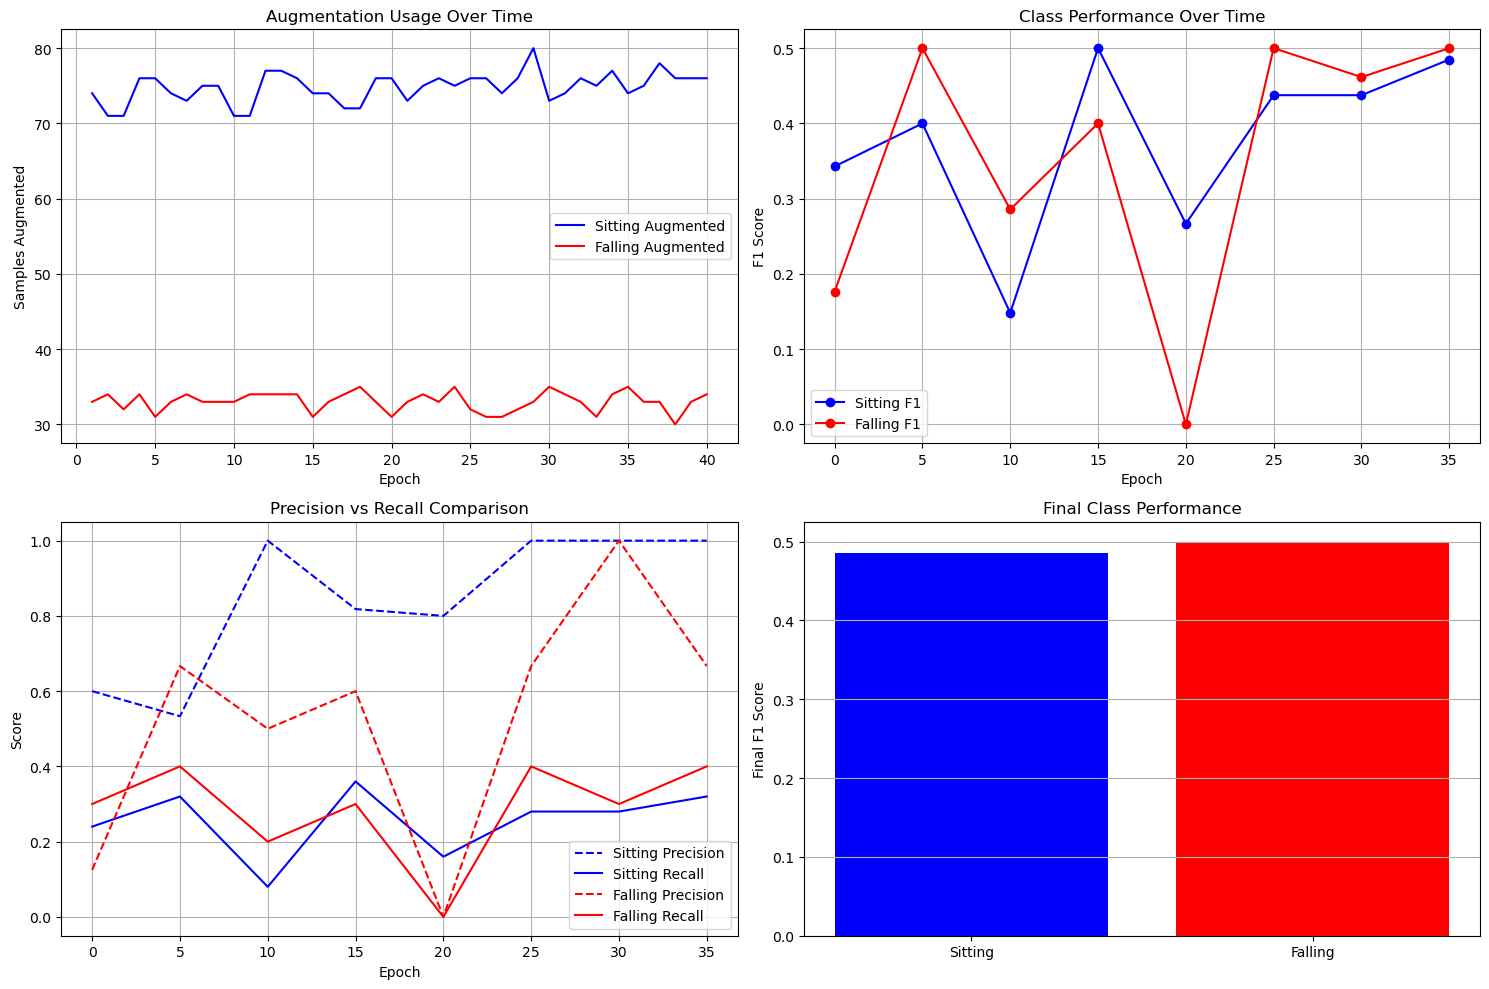


=== Comparison with Baseline ===
Sitting: Previous F1=0.44, Target: >0.55
Falling: Previous F1=0.31, Target: >0.45
Sitting: Current F1=0.485
Falling: Current F1=0.500


In [60]:
import os
import torch
import torch.nn as nn
import numpy as np
import random
import json
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from time import time
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt

# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Device setup
device = torch.device("mps" if torch.backends.mps.is_available() else 
                     "cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ---------------- Augmentation Tracking ----------------
class AugmentationTracker:
    def __init__(self):
        self.augmentation_stats = {
            'sitting_augmented': 0,
            'falling_augmented': 0,
            'sitting_original': 0,
            'falling_original': 0,
            'per_epoch_stats': []
        }
    
    def record_augmentation(self, labels, augmented_mask):
        sitting_count = ((labels == 3) & augmented_mask).sum().item()
        falling_count = ((labels == 8) & augmented_mask).sum().item()
        sitting_original = ((labels == 3) & ~augmented_mask).sum().item()
        falling_original = ((labels == 8) & ~augmented_mask).sum().item()
        
        self.augmentation_stats['sitting_augmented'] += sitting_count
        self.augmentation_stats['falling_augmented'] += falling_count
        self.augmentation_stats['sitting_original'] += sitting_original
        self.augmentation_stats['falling_original'] += falling_original
        
        return sitting_count, falling_count
    
    def record_epoch(self, epoch):
        self.augmentation_stats['per_epoch_stats'].append({
            'epoch': epoch,
            'sitting_augmented': self.augmentation_stats['sitting_augmented'],
            'falling_augmented': self.augmentation_stats['falling_augmented']
        })
        # Reset counters for next epoch
        self.augmentation_stats['sitting_augmented'] = 0
        self.augmentation_stats['falling_augmented'] = 0
    
    def print_stats(self):
        print("\n=== Augmentation Statistics ===")
        print(f"Sitting samples - Original: {self.augmentation_stats['sitting_original']}, Augmented: {self.augmentation_stats['sitting_augmented']}")
        print(f"Falling samples - Original: {self.augmentation_stats['falling_original']}, Augmented: {self.augmentation_stats['falling_augmented']}")
        
        if self.augmentation_stats['per_epoch_stats']:
            print("\nPer-epoch augmentation usage:")
            for stats in self.augmentation_stats['per_epoch_stats']:
                print(f"Epoch {stats['epoch']}: Sitting={stats['sitting_augmented']}, Falling={stats['falling_augmented']}")

# Initialize tracker
aug_tracker = AugmentationTracker()

# ---------------- Targeted Augmentation Functions ----------------
def augment_sitting_falling(raw_batch, psd_batch, labels, base_noise_level=0.01):
    """
    More conservative, data-driven augmentation for SITTING (3) and FALLING (8) classes
    """
    augmented_raw = raw_batch.clone()
    augmented_psd = psd_batch.clone()
    augmented_mask = torch.zeros_like(labels, dtype=torch.bool)
    
    for i in range(len(labels)):
        if labels[i] in [3, 8]:  # SITTING (3) or FALLING (8)
            augmented_mask[i] = True
            
            # Much more conservative augmentation
            if labels[i] == 3:  # SITTING
                # SITTING: Very subtle noise - focus on small variations
                noise = torch.randn_like(raw_batch[i]) * base_noise_level * 0.8  # Reduced from 2.0 to 0.8
                augmented_raw[i] = raw_batch[i] + noise
                
                # Minimal PSD augmentation
                psd_noise = torch.randn_like(psd_batch[i]) * base_noise_level * 0.5  # Reduced from 1.5 to 0.5
                augmented_psd[i] = psd_batch[i] + psd_noise
                
            elif labels[i] == 8:  # FALLING
                # FALLING: Conservative noise - remove the "impact simulation"
                noise = torch.randn_like(raw_batch[i]) * base_noise_level * 1.2  # Reduced from 4.0 to 1.2
                augmented_raw[i] = raw_batch[i] + noise
                
                # Conservative PSD augmentation
                psd_noise = torch.randn_like(psd_batch[i]) * base_noise_level * 0.8  # Reduced from 2.5 to 0.8
                augmented_psd[i] = psd_batch[i] + psd_noise
    
    # Record augmentation usage
    sitting_count, falling_count = aug_tracker.record_augmentation(labels, augmented_mask)
    
    return augmented_raw, augmented_psd, augmented_mask

# ---------------- Model Definition ----------------
class EnhancedIMUSonarNet(nn.Module):
    def __init__(self, num_channels=8, num_classes=9, psd_bins=65, dropout=0.3):
        super(EnhancedIMUSonarNet, self).__init__()
        
        # Enhanced raw signal branch
        self.raw_branch = nn.Sequential(
            nn.Conv1d(num_channels, 128, kernel_size=5, padding=2),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Dropout(dropout),
            
            nn.Conv1d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Dropout(dropout),
            
            nn.Conv1d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)
        )
        
        # Enhanced PSD branch
        self.psd_branch = nn.Sequential(
            nn.Linear(psd_bins, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout),
            
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        
        # Enhanced classifier
        combined_features = 512 + 128
        self.classifier = nn.Sequential(
            nn.Linear(combined_features, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout),
            
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout),
            
            nn.Linear(128, num_classes)
        )
    
    def forward(self, raw, psd):
        # Process raw signal
        raw_features = self.raw_branch(raw)
        raw_features = raw_features.squeeze(-1)
        
        # Process PSD - take mean across time dimension if needed
        if psd.dim() == 3:
            psd = psd.mean(dim=1)
        
        psd_features = self.psd_branch(psd)
        
        # Combine features
        combined = torch.cat([raw_features, psd_features], dim=1)
        
        # Classify
        output = self.classifier(combined)
        return output

# ---------------- Data Preparation ----------------
with open(f"{DATAFILES_DIR}/compressed_label_map.json", 'r') as f:
    label_map = json.load(f)
    
train_dataset = IMUSonarFromJSON(
    f"{DATAFILES_DIR}/train_split.json",
    label_map=label_map,
    target_length=600,
    add_noise=False,
    noise_level=0.01
)
test_dataset = IMUSonarFromJSON(
    f"{DATAFILES_DIR}/test_split.json",
    label_map=label_map,
    target_length=600
)

# ---------------- Calculate Class Weights ----------------
train_labels = []
for i in range(len(train_dataset)):
    _, _, label = train_dataset[i]
    train_labels.append(label)

test_labels = []
for i in range(len(test_dataset)):
    _, _, label = test_dataset[i]
    test_labels.append(label)

train_labels_np = np.array(train_labels)
unique_classes = np.unique(train_labels_np)
test_labels_np = np.array(test_labels)
test_classes = np.unique(test_labels_np)

print(f"Unique classes in training data: {unique_classes}")
print(f"Unique classes in test data: {test_classes}")

# Create weight array for all 9 classes
all_classes = np.arange(9)
class_weights_full = np.ones(9)

if len(unique_classes) > 0:
    weights_present = compute_class_weight(
        'balanced', 
        classes=unique_classes,
        y=train_labels_np
    )
    
    for cls, weight in zip(unique_classes, weights_present):
        class_weights_full[cls] = weight

print(f"Full class weights: {class_weights_full}")

class_weights_tensor = torch.tensor(class_weights_full, dtype=torch.float32).to(device)

# ---------------- Data Loaders ----------------
train_loader = DataLoader(
    train_dataset, 
    batch_size=32, 
    shuffle=True,
    num_workers=0,
    drop_last=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=0,
    drop_last=False
)

# ---------------- Model Setup ----------------
sample_raw, sample_psd, _ = train_dataset[0]
num_channels = sample_raw.shape[0]
psd_bins = sample_psd.shape[1]
num_classes = 9

print(f"Raw data shape: {sample_raw.shape}")
print(f"PSD data shape: {sample_psd.shape}")
print(f"Number of classes: {num_classes}")

model = EnhancedIMUSonarNet(
    num_channels=num_channels,
    num_classes=num_classes,
    psd_bins=psd_bins,
    dropout=0.3
).to(device)

# ---------------- Training Setup ----------------
epochs = 100
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5)

# Early stopping
best_val_acc = 0.0
patience = 15
patience_counter = 0
best_model_state = None

history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

# Track class-specific performance
class_performance_history = {
    'sitting_f1': [], 'falling_f1': [],
    'sitting_precision': [], 'falling_precision': [],
    'sitting_recall': [], 'falling_recall': []
}

print("=== Starting Training with Targeted Augmentation ===")
print(f"Training with {num_classes} classes")
print(f"Input dimensions: {num_channels} channels, {psd_bins} PSD bins")
print()

# ---------------- Training Loop ----------------
for epoch in range(epochs):
    # Training
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    epoch_start = time()
    
    for raw_batch, psd_batch, labels in train_loader:
        raw_batch = raw_batch.to(device)
        psd_batch = psd_batch.to(device)
        labels = labels.to(device).long()
        
        # Apply base noise augmentation
        if train_dataset.add_noise:
            noise = torch.randn_like(raw_batch) * train_dataset.noise_level
            raw_batch = raw_batch + noise
        
        # Apply targeted augmentation for problematic classes
        raw_batch, psd_batch, _ = augment_sitting_falling(raw_batch, psd_batch, labels)
        
        optimizer.zero_grad()
        outputs = model(raw_batch, psd_batch)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)
    
    # Record epoch augmentation stats
    aug_tracker.record_epoch(epoch + 1)
    
    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    
    with torch.no_grad():
        for raw_batch, psd_batch, labels in test_loader:
            raw_batch = raw_batch.to(device)
            psd_batch = psd_batch.to(device)
            labels = labels.to(device).long()
            
            outputs = model(raw_batch, psd_batch)
            val_loss += criterion(outputs, labels).item()
            _, predicted = outputs.max(1)
            val_correct += predicted.eq(labels).sum().item()
            val_total += labels.size(0)
    
    # Record metrics
    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    val_loss = val_loss / len(test_loader)
    val_acc = val_correct / val_total
    
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    # Learning rate scheduling
    scheduler.step(val_acc)
    
    # Track class-specific performance every 5 epochs
    if epoch % 5 == 0:
        model.eval()
        all_preds, all_labels = [], []
        with torch.no_grad():
            for raw_batch, psd_batch, labels in test_loader:
                raw_batch = raw_batch.to(device)
                psd_batch = psd_batch.to(device)
                labels = labels.to(device).long()
                
                outputs = model(raw_batch, psd_batch)
                _, predicted = outputs.max(1)
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        # Calculate class-specific metrics
        precision, recall, f1, _ = precision_recall_fscore_support(
            all_labels, all_preds, labels=[3, 8], average=None, zero_division=0
        )
        
        if len(f1) >= 2:
            class_performance_history['sitting_f1'].append(f1[0])
            class_performance_history['falling_f1'].append(f1[1])
            class_performance_history['sitting_precision'].append(precision[0])
            class_performance_history['falling_precision'].append(precision[1])
            class_performance_history['sitting_recall'].append(recall[0])
            class_performance_history['falling_recall'].append(recall[1])
    
    # Early stopping check
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = model.state_dict().copy()
        patience_counter = 0
    else:
        patience_counter += 1
    
    # Print progress
    print(f"Epoch {epoch + 1:3d}/{epochs} {time() - epoch_start:5.1f}s "
          f"Train Loss: {train_loss:7.4f} Train Acc: {train_acc:6.4f} "
          f"Val Loss: {val_loss:7.4f} Val Acc: {val_acc:6.4f} "
          f"LR: {optimizer.param_groups[0]['lr']:.1e}")
    
    if patience_counter >= patience:
        print(f"Early stopping triggered after {epoch + 1} epochs")
        break

# Load best model
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"Loaded best model with validation accuracy: {best_val_acc:.4f}")

print("\n=== Training Complete ===")
print(f"Best validation accuracy: {best_val_acc:.4f}")

# ---------------- Final Evaluation ----------------
def evaluate(model, loader, criterion):
    model.eval()
    total_loss, correct = 0.0, 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for raw_batch, psd_batch, labels in loader:
            raw_batch = raw_batch.to(device)
            psd_batch = psd_batch.to(device)
            labels = labels.to(device).long()
            
            outputs = model(raw_batch, psd_batch)
            total_loss += criterion(outputs, labels).item() * raw_batch.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = correct / len(loader.dataset)
    avg_loss = total_loss / len(loader.dataset)
    
    return avg_loss, accuracy, np.array(all_preds), np.array(all_labels)

train_loss, train_acc, train_preds, train_labels = evaluate(model, train_loader, criterion)
test_loss, test_acc, test_preds, test_labels = evaluate(model, test_loader, criterion)

print('\nFinal Results:')
print(f'Train loss: {train_loss:.4f}, accuracy: {train_acc:.4f}')
print(f'Test loss: {test_loss:.4f}, accuracy: {test_acc:.4f}')
print(f'Generalization gap: {train_acc - test_acc:.4f}')

# Per-class performance
from sklearn.metrics import classification_report

print("\nPer-class performance on test set:")
print(classification_report(test_labels, test_preds, 
                          labels=test_classes,
                          target_names=[f"Class {i}" for i in test_classes]))

# ---------------- Augmentation Analysis ----------------
aug_tracker.print_stats()

def plot_augmentation_analysis():
    """Plot augmentation effectiveness analysis"""
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot 1: Augmentation usage over epochs
    epochs = [stats['epoch'] for stats in aug_tracker.augmentation_stats['per_epoch_stats']]
    sitting_aug = [stats['sitting_augmented'] for stats in aug_tracker.augmentation_stats['per_epoch_stats']]
    falling_aug = [stats['falling_augmented'] for stats in aug_tracker.augmentation_stats['per_epoch_stats']]
    
    ax1.plot(epochs, sitting_aug, 'b-', label='Sitting Augmented')
    ax1.plot(epochs, falling_aug, 'r-', label='Falling Augmented')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Samples Augmented')
    ax1.set_title('Augmentation Usage Over Time')
    ax1.legend()
    ax1.grid(True)
    
    # Plot 2: Class performance over time
    eval_epochs = list(range(0, len(class_performance_history['sitting_f1']) * 5, 5))
    ax2.plot(eval_epochs, class_performance_history['sitting_f1'], 'b-o', label='Sitting F1')
    ax2.plot(eval_epochs, class_performance_history['falling_f1'], 'r-o', label='Falling F1')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('F1 Score')
    ax2.set_title('Class Performance Over Time')
    ax2.legend()
    ax2.grid(True)
    
    # Plot 3: Precision-Recall comparison
    ax3.plot(eval_epochs, class_performance_history['sitting_precision'], 'b--', label='Sitting Precision')
    ax3.plot(eval_epochs, class_performance_history['sitting_recall'], 'b-', label='Sitting Recall')
    ax3.plot(eval_epochs, class_performance_history['falling_precision'], 'r--', label='Falling Precision')
    ax3.plot(eval_epochs, class_performance_history['falling_recall'], 'r-', label='Falling Recall')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Score')
    ax3.set_title('Precision vs Recall Comparison')
    ax3.legend()
    ax3.grid(True)
    
    # Plot 4: Final class comparison
    classes = ['Sitting', 'Falling']
    final_f1 = [class_performance_history['sitting_f1'][-1], class_performance_history['falling_f1'][-1]]
    ax4.bar(classes, final_f1, color=['blue', 'red'])
    ax4.set_ylabel('Final F1 Score')
    ax4.set_title('Final Class Performance')
    ax4.grid(True, axis='y')
    
    plt.tight_layout()
    plt.savefig('augmentation_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

# Plot comprehensive analysis
plot_augmentation_analysis()

# Compare with baseline
print("\n=== Comparison with Baseline ===")
print("Sitting: Previous F1=0.44, Target: >0.55")
print("Falling: Previous F1=0.31, Target: >0.45")
print(f"Sitting: Current F1={class_performance_history['sitting_f1'][-1]:.3f}")
print(f"Falling: Current F1={class_performance_history['falling_f1'][-1]:.3f}")

In [65]:
import os
import random
import json
from pathlib import Path

def create_train_test_split(collection_dir, max_variants_per_label=100, test_orig_per_label=1, debug=False):
    """
    Build train/test split JSONs based on your folder structure.
    
    - collection_dir: root of subjects
    - max_variants_per_label: max number of variants per label in training
    - test_orig_per_label: number of originals per label to reserve for test
    """
    collection_dir = Path(collection_dir)
    train_samples = []
    test_samples = []

    # iterate subjects
    subjects = [d for d in collection_dir.iterdir() if d.is_dir()]
    label_counter = {}
    label_num = 0
    print(f'This is the number of subjects {len(subjects)}')

    # Load in labels
    with open(f"{DATAFILES_DIR}/label_map.json", 'r') as f:
        label_map = json.load(f)

    for subject_dir in subjects:
        # iterate first-half label directories
        for label1_dir in subject_dir.iterdir():
            if not label1_dir.is_dir():
                continue
            for label2_dir in label1_dir.iterdir():
                if not label2_dir.is_dir():
                    continue

                # full label name
                label_name = f"{label1_dir.name}_{label2_dir.name}"
                # # increment label ID
                # if label_name not in label_counter:
                #     label_counter[label_name] = label_num
                #     label_num += 1

                # originals are CSVs directly in label2_dir
                #original_files = [f for f in label2_dir.glob("*.csv") if "variants" not in f.name]
                original_files = [f for f in label2_dir.glob("*") if f.suffix.lower() == ".csv" and "variants" not in f.name]
                if len(original_files) == 0:
                    continue

                # select test originals for this label
                test_orig_files = random.sample(original_files, min(test_orig_per_label, len(original_files)))
                train_orig_files = [f for f in original_files if f not in test_orig_files]

                # add test originals (no variants)
                # print(f'This is the test files {test_orig_files}')
                # print(f'This is the test files {train_orig_files}')
                for orig in test_orig_files:
                    test_samples.append({"path": str(orig), "label": label_map[label_name]})

                # add training originals and their variants
                for orig in train_orig_files:
                    # include original itself
                    train_samples.append({"path": str(orig), "label": label_map[label_name]})
                    # find variants
                    variant_dir = orig.parent / "variants"
                    if variant_dir.exists():
                        #variants = list(variant_dir.glob(f"{orig.stem}_*.csv"))
                        variants = [f for f in variant_dir.glob(f"{orig.stem}_*") if f.suffix.lower() == ".csv"]
                        if len(variants) > max_variants_per_label:
                            variants = random.sample(variants, max_variants_per_label)
                        for var in variants:
                            train_samples.append({"path": str(var), "label": label_map[label_name]})

                # increment label id counter
                #label_counter[label_name] += 1

    if debug:
        print(f"Total train samples: {len(train_samples)}")
        print(f"Total test samples: {len(test_samples)}")
        print(f"Labels: {label_map}")

    return train_samples, test_samples

# Example usage
train_json, test_json = create_train_test_split(COLLECTIONFILES_DIR, max_variants_per_label=50, test_orig_per_label=1, debug=True)

# Write the split datasets to JSON files
train_labels_path = os.path.join(DATAFILES_DIR, "train_split.json")
test_labels_path = os.path.join(DATAFILES_DIR, "test_split.json")
with open(train_labels_path, 'w') as f:
    json.dump(train_json, f, indent=2)
with open(test_labels_path, 'w') as f:
    json.dump(test_json, f, indent=2)


This is the number of subjects 3
Total train samples: 23307
Total test samples: 72
Labels: {'tremor_running': 0, 'tremor_walking': 1, 'tremor_standing': 2, 'tremor_sitting': 3, 'tremor_laying': 4, 'tremor_stairs': 5, 'postural_falling': 6, 'postural_walking': 7, 'postural_standing': 8, 'postural_sitting': 9, 'postural_laying': 10, 'normal_running': 11, 'normal_walking': 12, 'normal_standing': 13, 'normal_sitting': 14, 'normal_laying': 15, 'normal_stairs': 16, 'tonic_running': 17, 'tonic_walking': 18, 'tonic_standing': 19, 'tonic_sitting': 20, 'tonic_laying': 21, 'tonic_stairs': 22, 'tremor_falling': 23, 'postural_running': 24, 'postural_stairs': 25, 'normal_falling': 26, 'tonic_falling': 27}


In [67]:
def create_train_test_split_balanced(collection_dir, min_test_per_label=3, max_variants_per_label=100, debug=False):
    collection_dir = Path(collection_dir)
    train_samples = []
    test_samples = []

    subjects = [d for d in collection_dir.iterdir() if d.is_dir()]
    
    # Load label map
    with open(f"{DATAFILES_DIR}/label_map.json", 'r') as f:
        label_map = json.load(f)

    for label1 in subjects[0].iterdir():
        if not label1.is_dir():
            continue
        for label2 in label1.iterdir():
            if not label2.is_dir():
                continue
            label_name = f"{label1.name}_{label2.name}"

            # collect all originals across subjects for this label
            all_originals = []
            for subject_dir in subjects:
                label_dir = subject_dir / label1.name / label2.name
                if not label_dir.exists():
                    continue
                #originals = [f for f in label_dir.glob("*.csv") if "variants" not in f.name]
                originals = [f for f in label_dir.glob("*") if f.suffix.lower() == ".csv" and "variants" not in f.name]
                all_originals.extend([(subject_dir.name, f) for f in originals])

            if len(all_originals) == 0:
                continue

            # shuffle to randomize selection
            random.shuffle(all_originals)

            # select test samples ensuring min_test_per_label
            selected_for_test = all_originals[:min(min_test_per_label, len(all_originals))]
            remaining_for_train = all_originals[min(min_test_per_label, len(all_originals)):]

            # add to test list
            for subj, f in selected_for_test:
                test_samples.append({"path": str(f), "label": label_map[label_name]})

            # add to train list
            for subj, f in remaining_for_train:
                train_samples.append({"path": str(f), "label": label_map[label_name]})
                # add variants
                variant_dir = f.parent / "variants"
                if variant_dir.exists():
                    variants = [v for v in variant_dir.glob(f"{f.stem}_*") if v.suffix.lower() == ".csv"]
                    if len(variants) > max_variants_per_label:
                        variants = random.sample(variants, max_variants_per_label)
                    for var in variants:
                        train_samples.append({"path": str(var), "label": label_map[label_name]})

    if debug:
        print(f"Total train samples: {len(train_samples)}")
        print(f"Total test samples: {len(test_samples)}")
    
    return train_samples, test_samples

# Example usage
train_json, test_json = create_train_test_split_balanced(COLLECTIONFILES_DIR, min_test_per_label=5, max_variants_per_label=50, debug=True)

# Write the split datasets to JSON files
train_labels_path = os.path.join(DATAFILES_DIR, "train_split.json")
test_labels_path = os.path.join(DATAFILES_DIR, "test_split.json")
with open(train_labels_path, 'w') as f:
    json.dump(train_json, f, indent=2)
with open(test_labels_path, 'w') as f:
    json.dump(test_json, f, indent=2)

Total train samples: 19278
Total test samples: 125


In [68]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

class CrossAttentionFusion(nn.Module):
    """
    Lightweight cross-attention between time-domain (x) and PSD (p) vectors.
    - Projects both inputs to a common dim.
    - Produces elementwise attention vector modulating PSD.
    - Returns concatenated [x_proj, p_mod].
    """
    def __init__(self, x_dim, p_dim, proj_dim=128, dropout=0.1):
        super().__init__()
        self.x_proj = nn.Linear(x_dim, proj_dim)
        self.p_proj = nn.Linear(p_dim, proj_dim)
        self.att_mlp = nn.Sequential(
            nn.Linear(proj_dim*2, proj_dim),
            nn.ReLU(inplace=True),
            nn.Linear(proj_dim, proj_dim),
            nn.Sigmoid()
        )
        self.dropout = nn.Dropout(dropout)
        self.proj_dim = proj_dim

    def forward(self, x, p):
        x_p = self.x_proj(x)             # (B, proj_dim)
        p_p = self.p_proj(p)             # (B, proj_dim)
        att = self.att_mlp(torch.cat([x_p, p_p], dim=1))
        p_mod = p_p * att
        p_mod = self.dropout(p_mod)
        fused = torch.cat([x_p, p_mod], dim=1)  # (B, 2*proj_dim)
        return fused


class IMUSonarPSDTcnNetWithAttention(nn.Module):
    """
    Hybrid Light CNN + TCN + PSD + Cross-Attention + Classifier
    CNN can be frozen/unfrozen to allow TCN temporal learning first.
    """
    def __init__(self,
                 num_channels=8,
                 num_classes=5,
                 psd_bins=64,
                 tcn_channels=64,
                 conv_channels_1=16,   # light CNN
                 conv_channels_2=32,   # light CNN
                 att_proj_dim=128,
                 dropout=0.2):
        super().__init__()

        # --- Light CNN ---
        self.conv1 = nn.Conv1d(num_channels, conv_channels_1, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm1d(conv_channels_1)
        self.conv2 = nn.Conv1d(conv_channels_1, conv_channels_2, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(conv_channels_2)

        # --- TCN-like dilated convs ---
        self.tcn1 = nn.Conv1d(conv_channels_2, tcn_channels, kernel_size=3, padding=2, dilation=2)
        self.tcn1_bn = nn.BatchNorm1d(tcn_channels)
        self.tcn2 = nn.Conv1d(tcn_channels, tcn_channels, kernel_size=3, padding=4, dilation=4)
        self.tcn2_bn = nn.BatchNorm1d(tcn_channels)

        # --- Time projection ---
        self.time_proj = nn.Linear(tcn_channels, att_proj_dim)

        # --- PSD branch ---
        self.psd_fc1 = nn.Linear(num_channels*psd_bins, 256)
        self.psd_bn1 = nn.BatchNorm1d(256)
        self.psd_fc2 = nn.Linear(256, att_proj_dim)

        # --- Cross-Attention ---
        self.fusion = CrossAttentionFusion(x_dim=att_proj_dim, p_dim=att_proj_dim,
                                          proj_dim=att_proj_dim, dropout=dropout)

        # --- Classifier ---
        fusion_out_dim = att_proj_dim*2
        self.classifier = nn.Sequential(
            nn.Linear(fusion_out_dim, 128),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(128),
            nn.Dropout(dropout),
            nn.Linear(128, 64),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(64),
            nn.Dropout(dropout),
            nn.Linear(64, num_classes)
        )

        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv1d, nn.Linear)):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                if getattr(m, 'bias', None) is not None:
                    nn.init.constant_(m.bias, 0.0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1.0)
                nn.init.constant_(m.bias, 0.0)

    # --- CNN freezing utilities ---
    def freeze_cnn(self):
        for layer in [self.conv1, self.conv2, self.bn1, self.bn2]:
            for p in layer.parameters():
                p.requires_grad = False

    def unfreeze_cnn(self):
        for layer in [self.conv1, self.conv2, self.bn1, self.bn2]:
            for p in layer.parameters():
                p.requires_grad = True
    
    def set_dropout(self, p: float):
        """Update dropout probability on the fly"""
        for m in self.modules():
            if isinstance(m, nn.Dropout):
                m.p = p
    
    def forward(self, raw_x, psd_x):
        # --- Light CNN branch ---
        x = F.relu(self.bn1(self.conv1(raw_x)))
        x = F.relu(self.bn2(self.conv2(x)))

        # --- TCN ---
        x = F.relu(self.tcn1_bn(self.tcn1(x)))
        x = F.relu(self.tcn2_bn(self.tcn2(x)))

        # Global summary across time
        x = F.adaptive_avg_pool1d(x, 1).squeeze(-1)
        x_proj = self.time_proj(x)

        # --- PSD branch ---
        p = psd_x.view(psd_x.size(0), -1)
        p = F.relu(self.psd_bn1(self.psd_fc1(p)))
        p_proj = self.psd_fc2(p)

        # --- Cross-attention fusion ---
        fused = self.fusion(x_proj, p_proj)

        # --- Classifier ---
        logits = self.classifier(fused)
        return logits

In [94]:
from collections import defaultdict
from pathlib import Path
import random
from torch.utils.data import Sampler

# ---------------- Balanced Sampler ----------------
class BalancedVariantSampler(Sampler):
    """Shuffle and mix originals and variants per label for temporal balance."""
    def __init__(self, dataset):
        self.dataset = dataset
        self.label_to_indices = defaultdict(list)
        for idx, item in enumerate(dataset.samples):
            label = dataset.label_map[item['label']] if dataset.label_map else item['label']
            self.label_to_indices[label].append(idx)
        self.all_indices = list(range(len(dataset)))

    def __iter__(self):
        indices = []
        for label, idx_list in self.label_to_indices.items():
            random.shuffle(idx_list)
            indices.extend(idx_list)
        random.shuffle(indices)
        return iter(indices)

    def __len__(self):
        return len(self.dataset)

# #---------------- Balanced Variant Sampler ----------------
# class VariantBalancedBatchSampler(torch.utils.data.Sampler):
#     """
#     Batch sampler to mix originals and variants per label for temporal balance.
#     """
#     def __init__(self, dataset, batch_size=32, max_variants_per_original=2):
#         self.dataset = dataset
#         self.batch_size = batch_size
#         self.max_variants_per_original = max_variants_per_original

#         # Map: label -> original_file_stem -> indices (original + variants)
#         self.label_to_orig_indices = defaultdict(lambda: defaultdict(list))
#         for idx, item in enumerate(dataset.samples):
#             label = item['label']
#             orig_stem = Path(item['path']).stem.split("_")[0]
#             self.label_to_orig_indices[label][orig_stem].append(idx)

#         self.labels = list(self.label_to_orig_indices.keys())

#     def __iter__(self):
#         batch = []
#         labels_shuffled = self.labels.copy()
#         random.shuffle(labels_shuffled)

#         while True:
#             for label in labels_shuffled:
#                 orig_keys = list(self.label_to_orig_indices[label].keys())
#                 random.shuffle(orig_keys)
#                 for orig in orig_keys:
#                     indices = self.label_to_orig_indices[label][orig]
#                     selected = indices
#                     if len(indices) > self.max_variants_per_original:
#                         selected = random.sample(indices, self.max_variants_per_original)
#                     batch.extend(selected)
#                     if len(batch) >= self.batch_size:
#                         yield batch[:self.batch_size]
#                         batch = batch[self.batch_size:]
#             if not batch:
#                 break

#     def __len__(self):
#         total_items = sum(len(idxs) for label_dict in self.label_to_orig_indices.values() for idxs in label_dict.values())
#         return total_items // self.batch_size

# class VariantBalancedBatchSampler(torch.utils.data.Sampler):
#     """
#     Batch sampler to mix originals and variants per label for temporal balance.
#     Skips the final batch if it is smaller than batch_size (like drop_last=True).
#     """
#     def __init__(self, dataset, batch_size=32, max_variants_per_original=2):
#         self.dataset = dataset
#         self.batch_size = batch_size
#         self.max_variants_per_original = max_variants_per_original

#         # Map: label -> original_file_stem -> indices (original + variants)
#         self.label_to_orig_indices = defaultdict(lambda: defaultdict(list))
#         for idx, item in enumerate(dataset.samples):
#             label = item['label']
#             orig_stem = Path(item['path']).stem.split("_")[0]
#             self.label_to_orig_indices[label][orig_stem].append(idx)

#         self.labels = list(self.label_to_orig_indices.keys())

#     def __iter__(self):
#         batch = []
#         labels_shuffled = self.labels.copy()
#         random.shuffle(labels_shuffled)
#         yield_count = 0
    
#         while True:
#             all_exhausted = True  # to detect when no more new samples left
#             for label in labels_shuffled:
#                 orig_keys = list(self.label_to_orig_indices[label].keys())
#                 random.shuffle(orig_keys)
#                 for orig in orig_keys:
#                     indices = self.label_to_orig_indices[label][orig]
#                     selected = indices
#                     if len(indices) > self.max_variants_per_original:
#                         selected = random.sample(indices, self.max_variants_per_original)
    
#                     batch.extend(selected)
#                     all_exhausted = False
    
#                     while len(batch) >= self.batch_size:
#                         yield_count += 1
#                         #print(f"Yielding batch {yield_count}, batch size {self.batch_size}")
#                         yield batch[:self.batch_size]
#                         batch = batch[self.batch_size:]
    
#             if all_exhausted or not batch:
#                 # drop remaining partial batch and stop
#                 if len(batch) != 0:
#                     print(f"End of iteration, remaining batch size {len(batch)} (dropped)")
#                 break

#     def __len__(self):
#         total_items = sum(
#             len(idxs)
#             for label_dict in self.label_to_orig_indices.values()
#             for idxs in label_dict.values()
#         )
#         return total_items // self.batch_size

import random
from collections import defaultdict
from pathlib import Path
import torch

class VariantBalancedBatchSampler(torch.utils.data.Sampler):
    """
    Balanced batch sampler ensuring:
    - At least one original per label per epoch
    - Variants included up to max_variants_per_original
    """
    def __init__(self, dataset, batch_size=32, max_variants_per_original=2, min_originals_for_variants=5):
        self.dataset = dataset
        self.batch_size = batch_size
        self.max_variants_per_original = max_variants_per_original
        self.min_originals_for_variants = min_originals_for_variants

        # Map: label -> original_file_stem -> indices (original + variants)
        self.label_to_orig_indices = defaultdict(lambda: defaultdict(list))
        self.label_to_original_count = defaultdict(int)

        for idx, item in enumerate(dataset.samples):
            label = item['label']
            orig_stem = Path(item['path']).stem.split("_")[0]
            self.label_to_orig_indices[label][orig_stem].append(idx)
            if "variants" not in item['path']:
                self.label_to_original_count[label] += 1

        self.labels = list(self.label_to_orig_indices.keys())

    def __iter__(self):
        batch = []

        # Shuffle labels for each epoch
        labels_shuffled = self.labels.copy()
        random.shuffle(labels_shuffled)

        # Shuffle original stems per label
        label_to_orig_keys = {label: list(self.label_to_orig_indices[label].keys())
                              for label in labels_shuffled}
        for keys in label_to_orig_keys.values():
            random.shuffle(keys)

        # Track which originals have been used for each label
        label_orig_used = {label: set() for label in self.labels}

        while True:
            all_exhausted = True

            for label in labels_shuffled:
                for orig in label_to_orig_keys[label]:
                    if orig in label_orig_used[label]:
                        continue  # skip already used originals

                    indices = self.label_to_orig_indices[label][orig]

                    # Always include the original first
                    originals = [i for i in indices if "variants" not in self.dataset.samples[i]['path']]
                    variants = [i for i in indices if "variants" in self.dataset.samples[i]['path']]

                    selected = originals.copy()

                    # Add variants if allowed and label has enough originals
                    if self.label_to_original_count[label] >= self.min_originals_for_variants:
                        if len(variants) > self.max_variants_per_original:
                            variants_sampled = random.sample(variants, self.max_variants_per_original)
                        else:
                            variants_sampled = variants
                        selected.extend(variants_sampled)

                    batch.extend(selected)
                    label_orig_used[label].add(orig)
                    all_exhausted = False

                    # Yield full batches
                    while len(batch) >= self.batch_size:
                        yield batch[:self.batch_size]
                        batch = batch[self.batch_size:]

            if all_exhausted:
                if batch:  # yield remaining partial batch
                    yield batch
                break

    def __len__(self):
        total_items = sum(
            len(idxs)
            for label_dict in self.label_to_orig_indices.values()
            for idxs in label_dict.values()
        )
        return (total_items + self.batch_size - 1) // self.batch_size


# ---------------- unchanged top of file (device / memory / seeds) ----------------
import os, gc, json, random, torch, numpy as np
from time import time
from torch import nn
from torch.utils.data import DataLoader, Sampler
from torch.optim import Adam
from collections import defaultdict

os.environ['PYTORCH_MPS_HIGH_WATERMARK_RATIO'] = '0.0'
os.environ['PYTORCH_MPS_MAX_CACHE_SIZE'] = '0'

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

if torch.backends.mps.is_available():
    device = torch.device("mps")
    torch.mps.manual_seed(42)
    torch.mps.set_per_process_memory_fraction(1.0)
elif torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed(42)
    torch.cuda.set_per_process_memory_fraction(1.0)
else:
    device = torch.device("cpu")

def print_memory_stats(prefix=""):
    if torch.backends.mps.is_available():
        alloc = torch.mps.current_allocated_memory() / 1e9
        reserved = torch.mps.driver_allocated_memory() / 1e9
        print(f"{prefix} Memory: Alloc={alloc:.2f}GB, Reserved={reserved:.2f}GB")
        
print(f"Using device: {device}")
print_memory_stats("Initial")

# ---------------- Data Preparation ----------------
with open(f"{DATAFILES_DIR}/label_map.json", 'r') as f:
    label_map = json.load(f)
# print("Number of keys in label_map:", len(label_map))
# print("Keys:", sorted(label_map.keys()))

train_dataset = IMUSonarFromJSON(
    f"{DATAFILES_DIR}/train_split.json",
    label_map=label_map,
    target_length=600,
    add_noise=True,
    noise_level=0.01
)
test_dataset = IMUSonarFromJSON(
    f"{DATAFILES_DIR}/test_split.json",
    label_map=label_map,
    target_length=600
)

batch_size = 32
# train_loader = DataLoader(train_dataset, batch_size=batch_size,
#                           sampler=BalancedVariantSampler(train_dataset),
#                           num_workers=0, drop_last=True)
train_loader = DataLoader(train_dataset,
                        batch_sampler=VariantBalancedBatchSampler(train_dataset,
                                                                  max_variants_per_original=25,
                                                                  batch_size=batch_size),
                        num_workers=0)
# for raw_batch, psd_batch, labels in train_loader:
#     print("Train Loader labels.shape:", labels.shape)
#     print("Train Loader Unique labels in batch:", torch.unique(labels))
#     break
# # Count batches yielded in one epoch
# count = 0
# for batch in train_loader:
#     count += 1
# print("Batches per epoch (train_loader):", count)
# print("Batches actually yielded:", count)
# print("Estimated batches by len():", len(train_loader))
# sampler = train_loader.batch_sampler  # or train_loader.sampler if using sampler directly
# print("Sampler object:", sampler)
# for label, orig_dict in sampler.label_to_orig_indices.items():
#     print(f"Label {label}:")
#     for orig, indices in orig_dict.items():
#         print(f"  Original {orig}: {indices}")

# test_loader = DataLoader(test_dataset,
#                         batch_sampler=VariantBalancedBatchSampler(test_dataset, batch_size=batch_size, max_variants_per_original=1000),
#                         num_workers=0
# )
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,       # Keep deterministic order
    drop_last=False,     # Keep all samples
    num_workers=0
)
# for raw_batch, psd_batch, labels in train_loader:
#     print("Test Loader labels.shape:", labels.shape)
#     print("Test Loader Unique labels in batch:", torch.unique(labels))
#     break
# test_loader = DataLoader(test_dataset, batch_size=batch_size,
#                          shuffle=False, num_workers=0)

# ---------------- Model ----------------
sample_raw, sample_psd, _ = train_dataset[0]
num_channels = sample_raw.shape[0]
psd_bins = sample_psd.shape[1]
num_classes = len(label_map)

model = IMUSonarPSDTcnNetWithAttention(
    num_channels=num_channels,
    num_classes=num_classes,
    psd_bins=psd_bins,
    tcn_channels=64,
    conv_channels_1=32,  # lighter CNN
    conv_channels_2=64,
    att_proj_dim=128,
    dropout=0.3
).to(device)

# ---------------- Training Loop ----------------
epochs = 50
freeze_cnn_epochs = 7
accumulation_steps = 2
history = defaultdict(list)

# Parameters for adaptive regularization
dropout_start = 0.3
dropout_min = 0.1
weight_decay_start = 1e-4
weight_decay_min = 1e-5
variant_boost_epoch = 25  # epoch to relax restrictions

criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=1e-3, weight_decay=weight_decay_start)

for epoch in range(epochs):
    # Freeze/unfreeze CNN
    if epoch < freeze_cnn_epochs:
        model.freeze_cnn()
    else:
        model.unfreeze_cnn()

    # Adjust dropout gradually
    if epoch >= variant_boost_epoch:
        new_dropout = max(dropout_min, dropout_start - 0.02 * (epoch - variant_boost_epoch))
        model.set_dropout(new_dropout)

        # Optionally lower weight decay
        for param_group in optimizer.param_groups:
            param_group['weight_decay'] = weight_decay_min

        # Optionally increase variant exposure
        if hasattr(train_loader.batch_sampler, 'max_variants_per_original'):
            train_loader.batch_sampler.max_variants_per_original = 4

    model.train()
    running_loss, correct, total = 0.0, 0, 0
    epoch_start = time()

    for batch_idx, (raw_batch, psd_batch, labels) in enumerate(train_loader):
        # if labels.max() > 27:
        #     print("labels tensor:", labels)
        #     print("labels max:", labels.max())
        #     print("labels min:", labels.min())

        raw_batch = raw_batch.to(device)
        psd_batch = psd_batch.to(device)
        labels = labels.to(device).long()

        # Optional on-the-fly noise
        if model.training and train_dataset.add_noise:
            noise = torch.randn_like(raw_batch) * train_dataset.noise_level
            raw_batch = raw_batch + noise

        outputs = model(raw_batch, psd_batch)
        loss = criterion(outputs, labels) / accumulation_steps
        loss.backward()

        if (batch_idx + 1) % accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad(set_to_none=True)

        running_loss += loss.item() * accumulation_steps
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

        # MPS / CUDA memory clean
        if batch_idx % 10 == 0:
            if torch.backends.mps.is_available(): torch.mps.empty_cache()
            elif torch.cuda.is_available(): torch.cuda.empty_cache()
            gc.collect()

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for raw_batch, psd_batch, labels in test_loader:
            raw_batch = raw_batch.to(device)
            psd_batch = psd_batch.to(device)
            labels = labels.to(device).long()

            outputs = model(raw_batch, psd_batch)
            val_loss += criterion(outputs, labels).item()
            _, predicted = outputs.max(1)
            val_correct += predicted.eq(labels).sum().item()
            val_total += labels.size(0)

            if batch_idx % 10 == 0:
                if torch.backends.mps.is_available(): torch.mps.empty_cache()
                elif torch.cuda.is_available(): torch.cuda.empty_cache()
                gc.collect()

    history['train_loss'].append(running_loss / len(train_loader))
    history['train_acc'].append(correct / total)
    history['val_loss'].append(val_loss / len(test_loader))
    history['val_acc'].append(val_correct / val_total)

    print(f"Epoch {epoch + 1}/{epochs} - {time() - epoch_start:.1f}s")
    print(f"Train Loss: {history['train_loss'][-1]:.4f} Acc: {history['train_acc'][-1]:.4f}")
    print(f"Val Loss: {history['val_loss'][-1]:.4f} Acc: {history['val_acc'][-1]:.4f}")
    print_memory_stats("Epoch End")
    print()

# ---------------- Final Evaluation ----------------
def safe_evaluate(model, loader):
    model.eval()
    total_loss, correct = 0.0, 0
    with torch.no_grad():
        for raw_batch, psd_batch, labels in loader:
            raw_batch = raw_batch.to(device)
            psd_batch = psd_batch.to(device)
            labels = labels.to(device).long()
            outputs = model(raw_batch, psd_batch)
            total_loss += criterion(outputs, labels).item() * raw_batch.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            if torch.backends.mps.is_available(): torch.mps.empty_cache()
            elif torch.cuda.is_available(): torch.cuda.empty_cache()
            gc.collect()
    return total_loss / len(loader.dataset), correct / len(loader.dataset)

train_loss, train_acc = safe_evaluate(model, train_loader)
test_loss, test_acc = safe_evaluate(model, test_loader)

print('Final Results:')
print(f'Train loss: {train_loss:.4f}, accuracy: {train_acc:.4f}')
print(f'Test loss: {test_loss:.4f}, accuracy: {test_acc:.4f}')
print_memory_stats("Final")

Using device: mps
Initial Memory: Alloc=0.01GB, Reserved=0.07GB
Epoch 1/50 - 30.9s
Train Loss: 2.0695 Acc: 0.0296
Val Loss: 3.4546 Acc: 0.0640
Epoch End Memory: Alloc=0.01GB, Reserved=0.13GB

Epoch 2/50 - 30.6s
Train Loss: 1.8269 Acc: 0.0423
Val Loss: 3.4054 Acc: 0.0480
Epoch End Memory: Alloc=0.01GB, Reserved=0.13GB

Epoch 3/50 - 30.0s
Train Loss: 1.7531 Acc: 0.0432
Val Loss: 3.3347 Acc: 0.0880
Epoch End Memory: Alloc=0.01GB, Reserved=0.13GB

Epoch 4/50 - 29.9s
Train Loss: 1.7070 Acc: 0.0511
Val Loss: 3.2673 Acc: 0.0720
Epoch End Memory: Alloc=0.01GB, Reserved=0.13GB

Epoch 5/50 - 30.0s
Train Loss: 1.6800 Acc: 0.0469
Val Loss: 3.2780 Acc: 0.0640
Epoch End Memory: Alloc=0.01GB, Reserved=0.13GB

Epoch 6/50 - 29.6s
Train Loss: 1.6578 Acc: 0.0617
Val Loss: 3.2682 Acc: 0.0320
Epoch End Memory: Alloc=0.01GB, Reserved=0.13GB

Epoch 7/50 - 31.4s
Train Loss: 1.6432 Acc: 0.0604
Val Loss: 3.2611 Acc: 0.0240
Epoch End Memory: Alloc=0.01GB, Reserved=0.13GB

Epoch 8/50 - 32.3s
Train Loss: 1.6351 Ac

In [40]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

def validate_model(model, dataloader, device, class_names=None):
    model.eval()
    all_preds = []
    all_labels = []
    softmax_probs = []

    with torch.no_grad():
        for batch in dataloader:
            # Unpack the batch
            inputs_cwt, inputs_psd, labels = batch  # <-- adjust based on your dataset
            inputs_cwt = inputs_cwt.to(device)
            inputs_psd = inputs_psd.to(device)
            labels = labels.to(device)

            outputs = model(inputs_cwt, inputs_psd)
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
            softmax_probs.append(probs.cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    softmax_probs = np.concatenate(softmax_probs)

    accuracy = (all_preds == all_labels).mean()
    print(f"Validation Accuracy: {accuracy:.4f}")

    # Per-class accuracy
    num_classes = len(class_names) if class_names else len(np.unique(all_labels))
    class_acc = []
    for i in range(num_classes):
        idx = all_labels == i
        acc = (all_preds[idx] == i).mean() if idx.any() else 0
        class_acc.append(acc)
        label_name = class_names[i] if class_names else str(i)
        print(f"Class {label_name} Accuracy: {acc:.4f}")

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

    # Optional: inspect probability distributions for misclassified samples
    mis_idx = all_preds != all_labels
    if mis_idx.any():
        plt.figure(figsize=(12,4))
        plt.hist(softmax_probs[mis_idx].max(axis=1), bins=20, color="red", alpha=0.7)
        plt.title("Softmax Max Probabilities for Misclassified Samples")
        plt.xlabel("Max Softmax Probability")
        plt.ylabel("Count")
        plt.show()

    return accuracy, class_acc, cm, softmax_probs

Validation Accuracy: 0.4306
Class tremor_running Accuracy: 0.6667
Class tremor_walking Accuracy: 0.6667
Class tremor_standing Accuracy: 0.0000
Class tremor_sitting Accuracy: 0.3333
Class tremor_laying Accuracy: 0.6667
Class tremor_stairs Accuracy: 0.0000
Class postural_falling Accuracy: 0.0000
Class postural_walking Accuracy: 0.6667
Class postural_standing Accuracy: 0.3333
Class postural_sitting Accuracy: 0.0000
Class postural_laying Accuracy: 0.3333
Class normal_running Accuracy: 0.6667
Class normal_walking Accuracy: 1.0000
Class normal_standing Accuracy: 0.0000
Class normal_sitting Accuracy: 0.6667
Class normal_laying Accuracy: 0.0000
Class normal_stairs Accuracy: 0.0000
Class tonic_running Accuracy: 1.0000
Class tonic_walking Accuracy: 0.0000
Class tonic_standing Accuracy: 0.6667
Class tonic_sitting Accuracy: 0.3333
Class tonic_laying Accuracy: 0.3333
Class tonic_stairs Accuracy: 1.0000
Class tremor_falling Accuracy: 1.0000
Class postural_running Accuracy: 0.5000
Class postural_stai

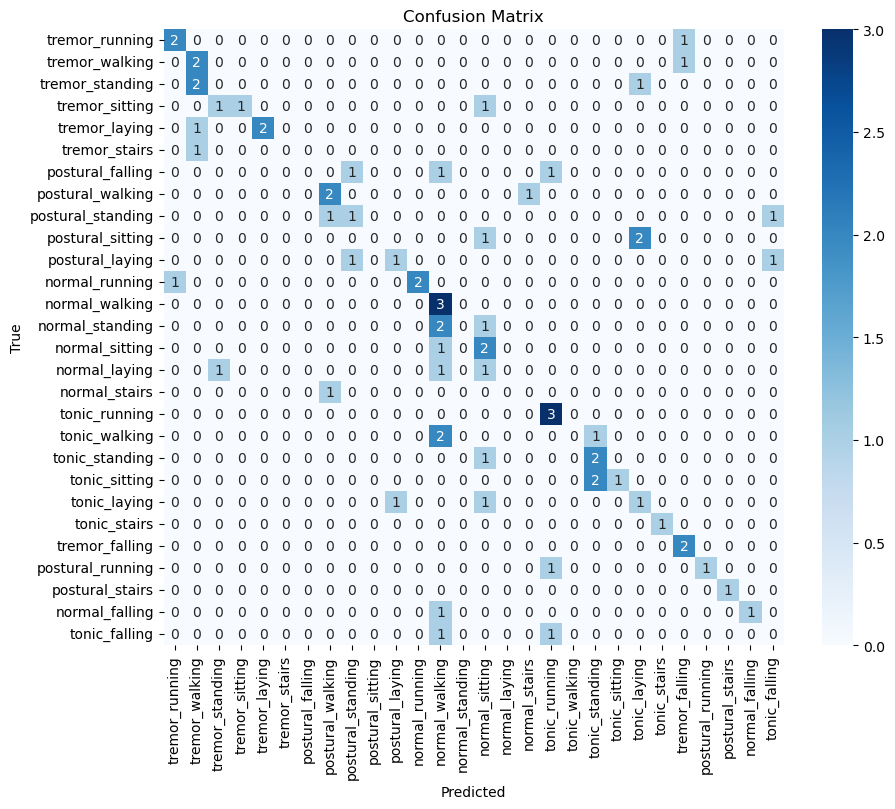

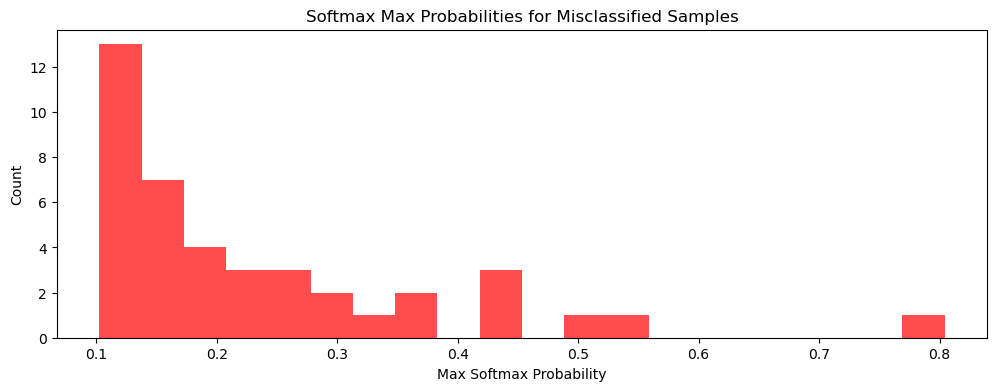

In [45]:
#class_names = ['normal', 'tonic', 'tremor', 'postural']  # your actual labels
class_names = list(label_map.keys())
val_acc, per_class_acc, cm, softmax_probs = validate_model(model, test_loader, device, class_names)


In [54]:
def misclassification_diagnostics(model, dataloader, device, class_names):
    model.eval()
    all_labels = []
    all_preds = []
    sample_indices = []

    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            inputs_cwt, inputs_psd, labels = batch
            inputs_cwt = inputs_cwt.to(device)
            inputs_psd = inputs_psd.to(device)
            labels = labels.to(device)

            outputs = model(inputs_cwt, inputs_psd)
            preds = torch.argmax(outputs, dim=1)

            all_labels.append(labels.cpu().numpy())
            all_preds.append(preds.cpu().numpy())
            sample_indices.append(np.arange(i*len(labels), i*len(labels)+len(labels)))

    all_labels = np.concatenate(all_labels)
    all_preds = np.concatenate(all_preds)
    sample_indices = np.concatenate(sample_indices)
    misclassified_dict = {}

    for cls_id, cls_name in enumerate(class_names):
        idx = all_labels == cls_id
        misclassified = sample_indices[idx & (all_preds != all_labels)]
        print(f"Class {cls_name}: {len(misclassified)} misclassified out of {idx.sum()} samples")
        if len(misclassified) > 0:
            print(f"  Sample indices misclassified: {misclassified}")
            misclassified_dict[cls_name] = misclassified
        

    return all_labels, all_preds, misclassified_dict


In [13]:
# Suppose you have these already:
# model: your trained PyTorch model
# test_loader: DataLoader for validation/test data
# device: 'cuda', 'cpu', or 'mps'

class_names = list(label_map.keys())
# Move model to device
model.to(device)

# Run the diagnostics
all_labels, all_preds, misclassified_dict = misclassification_diagnostics(model, test_loader, device, class_names)
print(misclassified_dict)


NameError: name 'misclassification_diagnostics' is not defined

In [90]:
from collections import Counter
import torch

def dataset_class_distribution(dataset, class_names=None):
    """
    Counts number of samples per class in a dataset.
    dataset: PyTorch dataset that returns (imu, psd, label)
    class_names: optional list of class names
    """
    labels = []
    for sample in dataset:
        _, _, label = sample  # unpack tuple
        if isinstance(label, torch.Tensor):
            label = label.item()  # convert to int
        labels.append(label)
    
    counts = Counter(labels)
    
    if class_names is None:
        class_names = [str(i) for i in range(len(counts))]
    
    print("Class distribution:")
    total_samples = len(dataset)
    for cls_id in sorted(counts):
        name = class_names[cls_id] if cls_id < len(class_names) else str(cls_id)
        count = counts[cls_id]
        pct = count / total_samples * 100
        print(f"  Class {name}: {count} samples ({pct:.2f}%)")
    
    return counts

# Example usage:
print("=== Train Dataset Distribution ===")
train_counts = dataset_class_distribution(train_dataset, class_names)

print("\n=== Test Dataset Distribution ===")
test_counts = dataset_class_distribution(test_dataset, class_names)


=== Train Dataset Distribution ===
Class distribution:
  Class tremor_running: 561 samples (2.91%)
  Class tremor_walking: 714 samples (3.70%)
  Class tremor_standing: 1326 samples (6.88%)
  Class tremor_sitting: 1428 samples (7.41%)
  Class tremor_laying: 714 samples (3.70%)
  Class postural_falling: 510 samples (2.65%)
  Class postural_walking: 510 samples (2.65%)
  Class postural_standing: 459 samples (2.38%)
  Class postural_sitting: 459 samples (2.38%)
  Class postural_laying: 459 samples (2.38%)
  Class normal_running: 1071 samples (5.56%)
  Class normal_walking: 1989 samples (10.32%)
  Class normal_standing: 918 samples (4.76%)
  Class normal_sitting: 1887 samples (9.79%)
  Class normal_laying: 1275 samples (6.61%)
  Class tonic_running: 561 samples (2.91%)
  Class tonic_walking: 969 samples (5.03%)
  Class tonic_standing: 612 samples (3.17%)
  Class tonic_sitting: 561 samples (2.91%)
  Class tonic_laying: 765 samples (3.97%)
  Class tremor_falling: 255 samples (1.32%)
  Class p

In [91]:
from collections import Counter
from pathlib import Path
import torch

def check_batch_sampler_balance(dataloader, dataset, max_batches=50):
    label_counts = Counter()
    variant_counts = Counter()
    orig_counts = Counter()

    # detect variants
    def is_variant(path):
        stem = Path(path).stem
        # assuming originals have no "_" beyond the label separator
        return "_" in stem and not stem.endswith("_orig")

    for batch_idx, (inputs, psds, labels) in enumerate(dataloader):
        # Ensure labels are on CPU and as ints
        labels = labels.cpu() if hasattr(labels, 'cpu') else labels
        labels = labels.int()

        # Attempt to get paths for each sample in the batch
        # If using VariantBalancedBatchSampler, dataloader.batch_sampler yields indices
        if hasattr(dataloader, 'batch_sampler') and dataloader.batch_sampler is not None:
            try:
                # Retrieve the corresponding indices from the sampler
                batch_indices = dataloader.batch_sampler.__iter__().__next__()
                paths = [dataset.samples[i]['path'] for i in batch_indices]
            except StopIteration:
                # fallback: just use sequential indices
                batch_indices = range(len(labels))
                paths = [dataset.samples[i]['path'] for i in batch_indices]
        else:
            batch_indices = range(len(labels))
            paths = [dataset.samples[i]['path'] for i in batch_indices]

        for lbl, path in zip(labels, paths):
            lbl_val = int(lbl)
            label_counts[lbl_val] += 1
            if is_variant(path):
                variant_counts[lbl_val] += 1
            else:
                orig_counts[lbl_val] += 1

        if batch_idx + 1 >= max_batches:
            break

    print("\n=== Label Distribution Check ===")
    for label in sorted(label_counts.keys()):
        total = label_counts[label]
        orig = orig_counts[label]
        var = variant_counts[label]
        variant_ratio = var / total if total > 0 else 0
        print(f"Label {label}: total={total}, originals={orig}, variants={var}, variant_ratio={variant_ratio:.2f}")

    print("\nAll labels counted:", dict(label_counts))
    print("Originals per label:", dict(orig_counts))
    print("Variants per label:", dict(variant_counts))


In [83]:
from collections import Counter
from pathlib import Path

def check_sampler_unique_counts(dataloader, dataset, max_batches=None):
    seen_indices = set()
    label_counts = Counter()
    variant_counts = Counter()
    orig_counts = Counter()

    def is_variant(path):
        stem = Path(path).stem
        return "_" in stem and not stem.endswith("_orig")

    for batch_idx, (inputs, psds, labels) in enumerate(dataloader):
        # Ensure labels are on CPU and as ints
        labels = labels.cpu() if hasattr(labels, 'cpu') else labels
        labels = labels.int()
        print(f"Batch {batch_idx}: labels.shape = {labels.shape}, inputs.shape = {inputs.shape}")

        # If batch_sampler is used, the dataloader returns already selected indices
        if hasattr(dataloader, 'batch_sampler') and dataloader.batch_sampler is not None:
            batch_indices = dataloader.batch_sampler.__iter__().__next__()
            paths = [dataset.samples[i]['path'] for i in batch_indices]
        else:
            # fallback: assume contiguous batch
            batch_indices = list(range(len(labels)))
            paths = [dataset.samples[i]['path'] for i in batch_indices]

        for lbl, path, idx in zip(labels, paths, batch_indices):
            lbl_val = int(lbl)
            if idx not in seen_indices:
                seen_indices.add(idx)
                label_counts[lbl_val] += 1
                if is_variant(path):
                    variant_counts[lbl_val] += 1
                else:
                    orig_counts[lbl_val] += 1

        if max_batches and (batch_idx + 1) >= max_batches:
            break

    print("\nUnique item counts per label:")
    for label in sorted(label_counts.keys()):
        total = label_counts[label]
        orig = orig_counts[label]
        var = variant_counts[label]
        variant_ratio = var / total if total > 0 else 0
        print(f"Label {label}: total={total}, originals={orig}, variants={var}, variant_ratio={variant_ratio:.2f}")


In [92]:
# Assuming you already have dataset and dataloader
check_batch_sampler_balance(train_loader, train_dataset)
print(train_loader)
print(train_dataset)



=== Label Distribution Check ===
Label 0: total=33, originals=12, variants=21, variant_ratio=0.64
Label 1: total=42, originals=15, variants=27, variant_ratio=0.64
Label 2: total=78, originals=26, variants=52, variant_ratio=0.67
Label 3: total=84, originals=29, variants=55, variant_ratio=0.65
Label 4: total=42, originals=15, variants=27, variant_ratio=0.64
Label 6: total=30, originals=10, variants=20, variant_ratio=0.67
Label 7: total=30, originals=10, variants=20, variant_ratio=0.67
Label 8: total=27, originals=10, variants=17, variant_ratio=0.63
Label 9: total=27, originals=9, variants=18, variant_ratio=0.67
Label 10: total=27, originals=9, variants=18, variant_ratio=0.67
Label 11: total=63, originals=22, variants=41, variant_ratio=0.65
Label 12: total=115, originals=39, variants=76, variant_ratio=0.66
Label 13: total=54, originals=19, variants=35, variant_ratio=0.65
Label 14: total=111, originals=38, variants=73, variant_ratio=0.66
Label 15: total=75, originals=26, variants=49, vari

In [84]:
# Assuming you already have a dataset and a dataloader
# for item in train_dataset:
#     print(item)
check_sampler_unique_counts(train_loader, train_dataset)
print(train_loader)
print(train_dataset)



Batch 0: labels.shape = torch.Size([32]), inputs.shape = torch.Size([32, 8, 600])
Batch 1: labels.shape = torch.Size([32]), inputs.shape = torch.Size([32, 8, 600])
Batch 2: labels.shape = torch.Size([32]), inputs.shape = torch.Size([32, 8, 600])
Batch 3: labels.shape = torch.Size([32]), inputs.shape = torch.Size([32, 8, 600])
Batch 4: labels.shape = torch.Size([32]), inputs.shape = torch.Size([32, 8, 600])
Batch 5: labels.shape = torch.Size([32]), inputs.shape = torch.Size([32, 8, 600])
Batch 6: labels.shape = torch.Size([32]), inputs.shape = torch.Size([32, 8, 600])
Batch 7: labels.shape = torch.Size([32]), inputs.shape = torch.Size([32, 8, 600])
Batch 8: labels.shape = torch.Size([32]), inputs.shape = torch.Size([32, 8, 600])
Batch 9: labels.shape = torch.Size([32]), inputs.shape = torch.Size([32, 8, 600])
Batch 10: labels.shape = torch.Size([32]), inputs.shape = torch.Size([32, 8, 600])
Batch 11: labels.shape = torch.Size([32]), inputs.shape = torch.Size([32, 8, 600])
Batch 12: labe

In [ ]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

class CrossAttentionFusion(nn.Module):
    """
    Lightweight cross-attention / gating between two vectors x (time-domain) and p (PSD).
    - Projects both inputs to a common dim.
    - Produces an elementwise attention vector that modulates the PSD projection.
    - Returns concatenated [x_proj, p_mod] for downstream layers.
    """
    def __init__(self, x_dim, p_dim, proj_dim=128, dropout=0.1):
        super().__init__()
        self.x_proj = nn.Linear(x_dim, proj_dim)
        self.p_proj = nn.Linear(p_dim, proj_dim)
        # small MLP to produce attention weights (vector)
        self.att_mlp = nn.Sequential(
            nn.Linear(proj_dim * 2, proj_dim),
            nn.ReLU(inplace=True),
            nn.Linear(proj_dim, proj_dim),
            nn.Sigmoid()
        )
        self.dropout = nn.Dropout(dropout)
        self.proj_dim = proj_dim

    def forward(self, x, p):
        """
        x: (B, x_dim)
        p: (B, p_dim)
        returns: fused vector (B, x_dim_proj + proj_dim)
        """
        x_p = self.x_proj(x)           # (B, proj_dim)
        p_p = self.p_proj(p)           # (B, proj_dim)

        # compute attention vector (elementwise gating on p_p)
        cat = torch.cat([x_p, p_p], dim=1)   # (B, 2*proj_dim)
        att = self.att_mlp(cat)              # (B, proj_dim) values in (0,1)

        p_mod = p_p * att                    # (B, proj_dim)
        p_mod = self.dropout(p_mod)

        # optionally we may also keep x_p (projected x) rather than raw x
        fused = torch.cat([x_p, p_mod], dim=1)  # (B, 2*proj_dim)
        return fused


class IMUSonarPSDTcnNetWithAttention(nn.Module):
    def __init__(self,
                 num_channels=8,
                 num_classes=5,
                 psd_bins=64,
                 tcn_channels=64,
                 conv_channels_1=32,
                 conv_channels_2=64,
                 att_proj_dim=128,
                 dropout=0.2):
        """
        Hybrid 1D-CNN + lightweight TCN + PSD branch with attention fusion.
        - raw input shape: (B, C=8, T=600)
        - psd input shape: (B, C=8, F=psd_bins)
        """
        super().__init__()

        # --- Raw signal branch (1D CNN + small TCN-like dilated convs) ---
        self.conv1 = nn.Conv1d(in_channels=num_channels, out_channels=conv_channels_1,
                               kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm1d(conv_channels_1)
        self.conv2 = nn.Conv1d(in_channels=conv_channels_1, out_channels=conv_channels_2,
                               kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(conv_channels_2)

        # TCN-like dilated convs (residual-friendly)
        self.tcn1 = nn.Conv1d(conv_channels_2, tcn_channels, kernel_size=3, padding=2, dilation=2)
        self.tcn1_bn = nn.BatchNorm1d(tcn_channels)
        self.tcn2 = nn.Conv1d(tcn_channels, tcn_channels, kernel_size=3, padding=4, dilation=4)
        self.tcn2_bn = nn.BatchNorm1d(tcn_channels)

        # projection of the time branch to a compact vector
        self.time_proj = nn.Linear(tcn_channels, att_proj_dim)

        # --- PSD branch ---
        # flatten PSD dims (B, C*F) -> FC layers
        self.psd_fc1 = nn.Linear(num_channels * psd_bins, 256)
        self.psd_bn1 = nn.BatchNorm1d(256)
        self.psd_fc2 = nn.Linear(256, att_proj_dim)  # project to same att dim

        # --- Attention fusion ---
        self.fusion = CrossAttentionFusion(x_dim=att_proj_dim, p_dim=att_proj_dim,
                                          proj_dim=att_proj_dim, dropout=dropout)

        # --- Classifier after fusion ---
        fusion_out_dim = att_proj_dim * 2  # because fusion concatenates x_proj and p_mod
        # self.classifier = nn.Sequential(
        #     nn.Linear(fusion_out_dim, 256),
        #     nn.ReLU(inplace=True),
        #     nn.BatchNorm1d(256),
        #     nn.Dropout(dropout),
        #     nn.Linear(256, 128),
        #     nn.ReLU(inplace=True),
        #     nn.BatchNorm1d(128),
        #     nn.Dropout(dropout),
        #     nn.Linear(128, num_classes)
        # )

        self.classifier = nn.Sequential(
            nn.Linear(fusion_out_dim, 128),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(128),
            nn.Dropout(dropout),
            nn.Linear(128, 64),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(64),
            nn.Dropout(dropout),
            nn.Linear(64, num_classes)
        )

        # small weight init for stability
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv1d) or isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                if getattr(m, 'bias', None) is not None:
                    nn.init.constant_(m.bias, 0.0)
            if isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1.0)
                nn.init.constant_(m.bias, 0.0)

    def forward(self, raw_x, psd_x):
        """
        raw_x: (B, C, T)
        psd_x: (B, C, F)
        returns logits (B, num_classes)
        """
        # --- Raw branch ---
        x = F.relu(self.bn1(self.conv1(raw_x)))   # (B, conv_channels_1, T)
        x = F.relu(self.bn2(self.conv2(x)))       # (B, conv_channels_2, T)

        x = F.relu(self.tcn1_bn(self.tcn1(x)))    # (B, tcn_channels, T)
        x = F.relu(self.tcn2_bn(self.tcn2(x)))    # (B, tcn_channels, T)

        # global summary across time (keeps channel info)
        x = F.adaptive_avg_pool1d(x, 1).squeeze(-1)  # (B, tcn_channels)

        # project time vector to att_proj_dim
        x_proj = self.time_proj(x)                   # (B, att_proj_dim)

        # --- PSD branch ---
        # flatten PSD (channels, bins) -> linear
        p = psd_x.view(psd_x.size(0), -1)            # (B, C*F)
        p = F.relu(self.psd_bn1(self.psd_fc1(p)))    # (B, 256)
        p_proj = self.psd_fc2(p)                     # (B, att_proj_dim)

        # --- Attention fusion ---
        fused = self.fusion(x_proj, p_proj)          # (B, 2*att_proj_dim)

        # --- Classification ---
        logits = self.classifier(fused)              # (B, num_classes)
        return logits


In [46]:
# ---------------- unchanged top of file (device / memory / seeds) ----------------
import os
import gc
import json
import torch
import random
import numpy as np
from time import time
from torch import nn
from torch.utils.data import DataLoader
from torch.optim import Adam
from collections import defaultdict
from scipy.signal import welch, find_peaks

# keep your MPS env vars
os.environ['PYTORCH_MPS_HIGH_WATERMARK_RATIO'] = '0.0'
os.environ['PYTORCH_MPS_MAX_CACHE_SIZE'] = '0'

def print_memory_stats(prefix=""):
    if torch.backends.mps.is_available():
        alloc = torch.mps.current_allocated_memory() / 1e9
        reserved = torch.mps.driver_allocated_memory() / 1e9
        print(f"{prefix} Memory: Alloc={alloc:.2f}GB, Reserved={reserved:.2f}GB")

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

if torch.backends.mps.is_available():
    device = torch.device("mps")
    torch.mps.manual_seed(42)
    torch.mps.set_per_process_memory_fraction(1.0)
elif torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed(42)
    torch.cuda.set_per_process_memory_fraction(1.0)
else:
    device = torch.device("cpu")

print(f"Using device: {device}")
print_memory_stats("Initial")

# ---------------- Dataset & Model imports ----------------
# make sure these are defined/imported in your runtime:
# from my_data_module import IMUSonarFromJSON
# from my_models import IMUSonarPSDTcnNetWithAttention

# ---------------- Data Preparation (use IMUSonarFromJSON directly) ----------------
with open(f"{DATAFILES_DIR}/label_map.json", 'r') as f:
    label_map = json.load(f)

# instantiate datasets (these return raw_tensor, psd_tensor, label_tensor)
train_dataset = IMUSonarFromJSON(f"{DATAFILES_DIR}/train.json", label_map=label_map, target_length=600, add_noise=True, noise_level=0.01)
test_dataset = IMUSonarFromJSON(f"{DATAFILES_DIR}/test.json", label_map=label_map, target_length=600)

# DataLoader (Jupyter-safe)
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

# ---------------- Model init ----------------
# infer psd_bins from first sample
sample_raw, sample_psd, sample_label = train_dataset[0]
num_channels = sample_raw.shape[0]   # expected 8
sequence_length = sample_raw.shape[1]  # expected 600
psd_bins = sample_psd.shape[1]       # inferred from dataset
num_classes = len(label_map)

model = IMUSonarPSDTcnNetWithAttention(
    num_channels=num_channels,
    num_classes=num_classes,
    psd_bins=psd_bins,
    tcn_channels=32,
    att_proj_dim=64,
).to(device)

criterion = nn.CrossEntropyLoss()
#optimizer = Adam(model.parameters(), lr=1e-3)
optimizer = Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

# ---------------- Training hyperparams ----------------
epochs = 10
accumulation_steps = 2

# ---------------- Training Loop ----------------
history = defaultdict(list)
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    train_loss, correct, total = 0.0, 0, 0
    epoch_start = time()

    for batch_idx, batch in enumerate(train_loader):
        # batch: tuple(raw_tensor, psd_tensor, label_tensor)
        raw_batch, psd_batch, labels = batch

        # ensure proper shapes: (B, C, T) and (B, C, F)
        raw_batch = raw_batch.to(device)        # FloatTensor
        psd_batch = psd_batch.to(device)        # FloatTensor
        labels = labels.to(device).long()       # LongTensor

        outputs = model(raw_batch, psd_batch)   # logits (B, num_classes)
        loss = criterion(outputs, labels) / accumulation_steps
        loss.backward()

        if (batch_idx + 1) % accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad(set_to_none=True)

        train_loss += loss.item() * accumulation_steps
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        if batch_idx % 10 == 0:
            if torch.backends.mps.is_available(): torch.mps.empty_cache()
            if torch.cuda.is_available(): torch.cuda.empty_cache()
            gc.collect()

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for batch_idx, batch in enumerate(test_loader):
            raw_batch, psd_batch, labels = batch
            raw_batch = raw_batch.to(device)
            psd_batch = psd_batch.to(device)
            labels = labels.to(device).long()

            outputs = model(raw_batch, psd_batch)
            val_loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

            if batch_idx % 10 == 0:
                if torch.backends.mps.is_available(): torch.mps.empty_cache()
                elif torch.cuda.is_available(): torch.cuda.empty_cache()
                gc.collect()

    # Logging
    history['train_loss'].append(train_loss / len(train_loader))
    history['train_acc'].append(correct / total if total > 0 else 0.0)
    history['val_loss'].append(val_loss / len(test_loader))
    history['val_acc'].append(val_correct / val_total if val_total > 0 else 0.0)

    print(f"Epoch {epoch + 1}/{epochs} - {time() - epoch_start:.1f}s")
    print(f"Train Loss: {history['train_loss'][-1]:.4f} Acc: {history['train_acc'][-1]:.4f}")
    print(f"Val Loss: {history['val_loss'][-1]:.4f} Acc: {history['val_acc'][-1]:.4f}")
    print_memory_stats("Epoch End")
    print()

    if torch.backends.mps.is_available(): torch.mps.empty_cache()
    elif torch.cuda.is_available(): torch.cuda.empty_cache()
    gc.collect()

# ---------------- Final Evaluation ----------------
def safe_evaluate(model, loader):
    model.eval()
    total_loss, correct = 0.0, 0
    with torch.no_grad():
        for batch in loader:
            raw_batch, psd_batch, labels = batch
            raw_batch = raw_batch.to(device)
            psd_batch = psd_batch.to(device)
            labels = labels.to(device).long()

            outputs = model(raw_batch, psd_batch)
            total_loss += criterion(outputs, labels).item() * raw_batch.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()

            if torch.backends.mps.is_available(): torch.mps.empty_cache()
            elif torch.cuda.is_available(): torch.cuda.empty_cache()
            gc.collect()

    return total_loss / len(loader.dataset), correct / len(loader.dataset)

train_loss, train_acc = safe_evaluate(model, train_loader)
test_loss, test_acc = safe_evaluate(model, test_loader)

print('Final Results:')
print(f'Train loss: {train_loss:.4f}, accuracy: {train_acc:.4f}')
print(f'Test loss: {test_loss:.4f}, accuracy: {test_acc:.4f}')
print_memory_stats("Final")


Using device: mps
Initial Memory: Alloc=0.01GB, Reserved=0.03GB
Epoch 1/10 - 77.1s
Train Loss: 0.8614 Acc: 0.7646
Val Loss: 0.0165 Acc: 0.9989
Epoch End Memory: Alloc=0.01GB, Reserved=0.07GB

Epoch 2/10 - 76.2s
Train Loss: 0.0558 Acc: 0.9910
Val Loss: 0.0017 Acc: 1.0000
Epoch End Memory: Alloc=0.01GB, Reserved=0.07GB

Epoch 3/10 - 73.9s
Train Loss: 0.0207 Acc: 0.9962
Val Loss: 0.0006 Acc: 1.0000
Epoch End Memory: Alloc=0.01GB, Reserved=0.07GB

Epoch 4/10 - 74.5s
Train Loss: 0.0179 Acc: 0.9966
Val Loss: 0.0011 Acc: 1.0000
Epoch End Memory: Alloc=0.01GB, Reserved=0.07GB

Epoch 5/10 - 74.7s
Train Loss: 0.0147 Acc: 0.9967
Val Loss: 0.0029 Acc: 0.9987
Epoch End Memory: Alloc=0.01GB, Reserved=0.07GB

Epoch 6/10 - 74.9s
Train Loss: 0.0272 Acc: 0.9929
Val Loss: 0.0003 Acc: 1.0000
Epoch End Memory: Alloc=0.01GB, Reserved=0.07GB

Epoch 7/10 - 74.8s
Train Loss: 0.0120 Acc: 0.9972
Val Loss: 0.0000 Acc: 1.0000
Epoch End Memory: Alloc=0.01GB, Reserved=0.07GB

Epoch 8/10 - 74.4s
Train Loss: 0.0144 Ac

Using device: mps
Initial Memory: Alloc=0.01GB, Reserved=0.07GB
🔍 Training Dataset Class Distribution:
  Class 0 (tremor_running): 662 samples
  Class 1 (tremor_walking): 798 samples
  Class 2 (tremor_standing): 1274 samples
  Class 3 (tremor_sitting): 1321 samples
  Class 4 (tremor_laying): 771 samples
  Class 5 (tremor_stairs): 490 samples
  Class 6 (postural_falling): 604 samples
  Class 7 (postural_walking): 602 samples
  Class 8 (postural_standing): 578 samples
  Class 9 (postural_sitting): 576 samples
  Class 10 (postural_laying): 575 samples
  Class 11 (normal_running): 1067 samples
  Class 12 (normal_walking): 1752 samples
  Class 13 (normal_standing): 920 samples
  Class 14 (normal_sitting): 1695 samples
  Class 15 (normal_laying): 1239 samples
  Class 16 (normal_stairs): 203 samples
  Class 17 (tonic_running): 639 samples
  Class 18 (tonic_walking): 1013 samples
  Class 19 (tonic_standing): 711 samples
  Class 20 (tonic_sitting): 661 samples
  Class 21 (tonic_laying): 820 sam

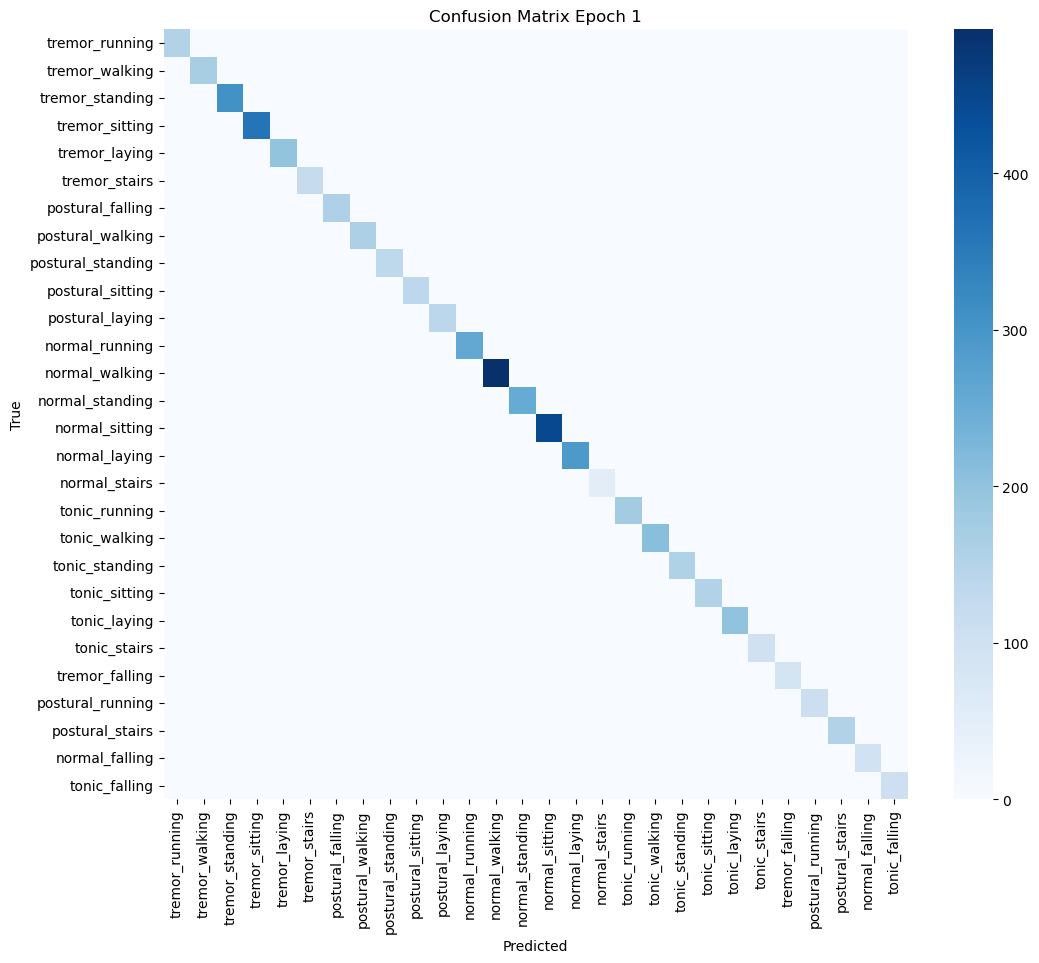

Epoch End Memory: Alloc=0.01GB, Reserved=0.07GB

Epoch 2/25 - 71.8s
Train Loss: 0.0355 Acc: 0.9950
Val Loss: 0.0019 Acc: 1.0000
Training appears stable.
                   precision    recall  f1-score   support

   tremor_running       1.00      1.00      1.00       154
   tremor_walking       1.00      1.00      1.00       171
  tremor_standing       1.00      1.00      1.00       307
   tremor_sitting       1.00      1.00      1.00       362
    tremor_laying       1.00      1.00      1.00       198
    tremor_stairs       1.00      1.00      1.00       122
 postural_falling       1.00      1.00      1.00       161
 postural_walking       1.00      1.00      1.00       163
postural_standing       1.00      1.00      1.00       136
 postural_sitting       1.00      1.00      1.00       138
  postural_laying       1.00      1.00      1.00       139
   normal_running       1.00      1.00      1.00       259
   normal_walking       1.00      1.00      1.00       492
  normal_standing   

Epoch End Memory: Alloc=0.01GB, Reserved=0.07GB

Epoch 3/25 - 74.5s
Train Loss: 0.0131 Acc: 0.9985
Val Loss: 0.0004 Acc: 1.0000
Training appears stable.
                   precision    recall  f1-score   support

   tremor_running       1.00      1.00      1.00       154
   tremor_walking       1.00      1.00      1.00       171
  tremor_standing       1.00      1.00      1.00       307
   tremor_sitting       1.00      1.00      1.00       362
    tremor_laying       1.00      1.00      1.00       198
    tremor_stairs       1.00      1.00      1.00       122
 postural_falling       1.00      1.00      1.00       161
 postural_walking       1.00      1.00      1.00       163
postural_standing       1.00      1.00      1.00       136
 postural_sitting       1.00      1.00      1.00       138
  postural_laying       1.00      1.00      1.00       139
   normal_running       1.00      1.00      1.00       259
   normal_walking       1.00      1.00      1.00       492
  normal_standing   

Epoch End Memory: Alloc=0.01GB, Reserved=0.07GB

Epoch 4/25 - 76.2s
Train Loss: 0.0122 Acc: 0.9980
Val Loss: 0.0003 Acc: 1.0000
Training appears stable.
                   precision    recall  f1-score   support

   tremor_running       1.00      1.00      1.00       154
   tremor_walking       1.00      1.00      1.00       171
  tremor_standing       1.00      1.00      1.00       307
   tremor_sitting       1.00      1.00      1.00       362
    tremor_laying       1.00      1.00      1.00       198
    tremor_stairs       1.00      1.00      1.00       122
 postural_falling       1.00      1.00      1.00       161
 postural_walking       1.00      1.00      1.00       163
postural_standing       1.00      1.00      1.00       136
 postural_sitting       1.00      1.00      1.00       138
  postural_laying       1.00      1.00      1.00       139
   normal_running       1.00      1.00      1.00       259
   normal_walking       1.00      1.00      1.00       492
  normal_standing   

Epoch End Memory: Alloc=0.01GB, Reserved=0.07GB

Epoch 5/25 - 69.8s
Train Loss: 0.0473 Acc: 0.9871
Val Loss: 0.0003 Acc: 1.0000
Training appears stable.
                   precision    recall  f1-score   support

   tremor_running       1.00      1.00      1.00       154
   tremor_walking       1.00      1.00      1.00       171
  tremor_standing       1.00      1.00      1.00       307
   tremor_sitting       1.00      1.00      1.00       362
    tremor_laying       1.00      1.00      1.00       198
    tremor_stairs       1.00      1.00      1.00       122
 postural_falling       1.00      1.00      1.00       161
 postural_walking       1.00      1.00      1.00       163
postural_standing       1.00      1.00      1.00       136
 postural_sitting       1.00      1.00      1.00       138
  postural_laying       1.00      1.00      1.00       139
   normal_running       1.00      1.00      1.00       259
   normal_walking       1.00      1.00      1.00       492
  normal_standing   

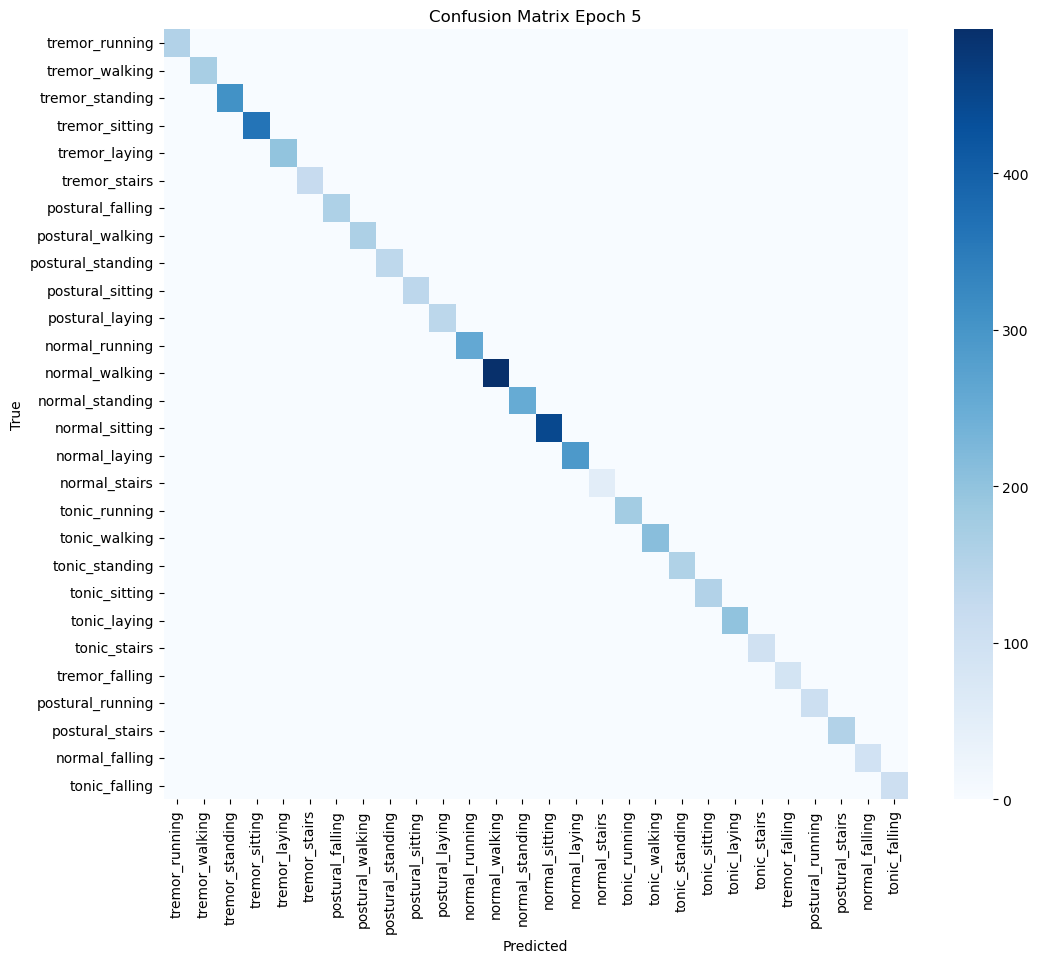

Epoch End Memory: Alloc=0.01GB, Reserved=0.07GB



KeyboardInterrupt: 

In [34]:
import os
import gc
import json
import torch
import random
import numpy as np
from time import time
from torch import nn
from torch.utils.data import DataLoader
from torch.optim import Adam
from collections import defaultdict, Counter
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# keep your MPS env vars
os.environ['PYTORCH_MPS_HIGH_WATERMARK_RATIO'] = '0.0'
os.environ['PYTORCH_MPS_MAX_CACHE_SIZE'] = '0'

def print_memory_stats(prefix=""):
    if torch.backends.mps.is_available():
        alloc = torch.mps.current_allocated_memory() / 1e9
        reserved = torch.mps.driver_allocated_memory() / 1e9
        print(f"{prefix} Memory: Alloc={alloc:.2f}GB, Reserved={reserved:.2f}GB")

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

if torch.backends.mps.is_available():
    device = torch.device("mps")
    torch.mps.manual_seed(42)
    torch.mps.set_per_process_memory_fraction(1.0)
elif torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed(42)
    torch.cuda.set_per_process_memory_fraction(1.0)
else:
    device = torch.device("cpu")

print(f"Using device: {device}")
print_memory_stats("Initial")

# ---------------- Dataset & Model imports ----------------
# from your imports, e.g. IMUSonarFromJSON, IMUSonarPSDTcnNetWithAttention

# ---------------- Data Preparation ----------------
with open(f"{DATAFILES_DIR}/label_map.json", 'r') as f:
    label_map = json.load(f)

inv_label_map = {v:k for k,v in label_map.items()}  # numeric->string

train_dataset = IMUSonarFromJSON(f"{DATAFILES_DIR}/train.json", label_map=label_map, target_length=600)
test_dataset = IMUSonarFromJSON(f"{DATAFILES_DIR}/test.json", label_map=label_map, target_length=600)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

sample_raw, sample_psd, sample_label = train_dataset[0]
num_channels = sample_raw.shape[0]
sequence_length = sample_raw.shape[1]
psd_bins = sample_psd.shape[1]
num_classes = len(label_map)

model = IMUSonarPSDTcnNetWithAttention(
    num_channels=num_channels,
    num_classes=num_classes,
    psd_bins=psd_bins,
    tcn_channels=32,
    att_proj_dim=64,
).to(device)

criterion = nn.CrossEntropyLoss()
#optimizer = Adam(model.parameters(), lr=1e-3)
optimizer = Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

epochs = 25
accumulation_steps = 2

# --- Helper analysis functions ---

def get_labels_and_preds(loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in loader:
            raw_batch, psd_batch, labels = batch
            raw_batch = raw_batch.to(device)
            psd_batch = psd_batch.to(device)
            labels = labels.to(device).long()

            outputs = model(raw_batch, psd_batch)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())
    return all_labels, all_preds

def plot_confusion_matrix(true_labels, pred_labels, classes, epoch):
    cm = confusion_matrix(true_labels, pred_labels)
    plt.figure(figsize=(12,10))
    sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix Epoch {epoch+1}')
    plt.show()

def print_classification_report(true_labels, pred_labels, classes):
    report = classification_report(true_labels, pred_labels, target_names=classes, zero_division=0)
    print(report)

def check_overfitting(train_loss, val_loss, train_acc, val_acc, threshold=0.05):
    loss_diff = val_loss - train_loss
    acc_diff = train_acc - val_acc
    if loss_diff > threshold and acc_diff > threshold:
        print("⚠️ Warning: Possible overfitting detected!")
    else:
        print("Training appears stable.")

# Print initial class distribution from training dataset
def print_dataset_class_distribution(dataset, label_map):
    labels = []
    for _, _, label in dataset:
        if isinstance(label, torch.Tensor):
            labels.append(label.item())
        else:
            labels.append(label)
    counts = Counter(labels)
    print("🔍 Training Dataset Class Distribution:")
    for k,v in sorted(counts.items()):
        print(f"  Class {k} ({label_map[k]}): {v} samples")

print_dataset_class_distribution(train_dataset, inv_label_map)

# ---------------- Training Loop ----------------
history = defaultdict(list)
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    train_loss, correct, total = 0.0, 0, 0
    epoch_start = time()

    for batch_idx, batch in enumerate(train_loader):
        raw_batch, psd_batch, labels = batch
        raw_batch = raw_batch.to(device)
        psd_batch = psd_batch.to(device)
        labels = labels.to(device).long()

        outputs = model(raw_batch, psd_batch)
        loss = criterion(outputs, labels) / accumulation_steps
        loss.backward()

        if (batch_idx + 1) % accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad(set_to_none=True)

        train_loss += loss.item() * accumulation_steps
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        if batch_idx % 10 == 0:
            if torch.backends.mps.is_available(): torch.mps.empty_cache()
            if torch.cuda.is_available(): torch.cuda.empty_cache()
            gc.collect()

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for batch_idx, batch in enumerate(test_loader):
            raw_batch, psd_batch, labels = batch
            raw_batch = raw_batch.to(device)
            psd_batch = psd_batch.to(device)
            labels = labels.to(device).long()

            outputs = model(raw_batch, psd_batch)
            val_loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

            if batch_idx % 10 == 0:
                if torch.backends.mps.is_available(): torch.mps.empty_cache()
                elif torch.cuda.is_available(): torch.cuda.empty_cache()
                gc.collect()

    train_loss /= len(train_loader)
    val_loss /= len(test_loader)
    train_acc = correct / total if total > 0 else 0.0
    val_acc = val_correct / val_total if val_total > 0 else 0.0

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f"Epoch {epoch + 1}/{epochs} - {time() - epoch_start:.1f}s")
    print(f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")
    check_overfitting(train_loss, val_loss, train_acc, val_acc)

    # Confusion matrix and classification report on validation set
    val_true, val_pred = get_labels_and_preds(test_loader)
    print_classification_report(val_true, val_pred, [inv_label_map[i] for i in range(num_classes)])
    plot_confusion_matrix(val_true, val_pred, [inv_label_map[i] for i in range(num_classes)], epoch)

    print_memory_stats("Epoch End")
    print()

    if torch.backends.mps.is_available(): torch.mps.empty_cache()
    elif torch.cuda.is_available(): torch.cuda.empty_cache()
    gc.collect()

# ---------------- Final Evaluation ----------------
def safe_evaluate(model, loader):
    model.eval()
    total_loss, correct = 0.0, 0
    with torch.no_grad():
        for batch in loader:
            raw_batch, psd_batch, labels = batch
            raw_batch = raw_batch.to(device)
            psd_batch = psd_batch.to(device)
            labels = labels.to(device).long()

            outputs = model(raw_batch, psd_batch)
            total_loss += criterion(outputs, labels).item() * raw_batch.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()

            if torch.backends.mps.is_available(): torch.mps.empty_cache()
            elif torch.cuda.is_available(): torch.cuda.empty_cache()
            gc.collect()

    return total_loss / len(loader.dataset), correct / len(loader.dataset)

train_loss, train_acc = safe_evaluate(model, train_loader)
test_loss, test_acc = safe_evaluate(model, test_loader)

print('Final Results:')
print(f'Train loss: {train_loss:.4f}, accuracy: {train_acc:.4f}')
print(f'Test loss: {test_loss:.4f}, accuracy: {test_acc:.4f}')
print_memory_stats("Final")


In [50]:
import json
import random
import numpy as np
import torch
import collections

# -- 1. Check for overlap between train/test JSON datasets --
def check_train_test_overlap(train_json_path, test_json_path, verbose=True):
    with open(train_json_path, 'r') as f:
        train_data = json.load(f)
    with open(test_json_path, 'r') as f:
        test_data = json.load(f)
    
    # Assuming each item has an 'id' or unique key; if not, hash the raw data or use full item string
    def item_key(item):
        # Try to uniquely identify sample - modify as needed for your JSON structure
        # Example: return item.get('id', None)
        # If no id, hash the full sample string or tuple of relevant fields:
        return json.dumps(item, sort_keys=True)
    
    train_keys = set(item_key(item) for item in train_data)
    test_keys = set(item_key(item) for item in test_data)
    
    overlap = train_keys.intersection(test_keys)
    if verbose:
        print(f"Train samples: {len(train_keys)}, Test samples: {len(test_keys)}")
        print(f"Overlap count: {len(overlap)}")
        if len(overlap) > 0:
            print(f"Example overlapping samples (up to 3): {list(overlap)[:3]}")
    return overlap

# -- 2. Print a few random samples and labels from datasets --
def print_random_samples(dataset, label_map, n=5, dataset_name="Dataset"):
    print(f"--- Random samples from {dataset_name} ---")
    for _ in range(n):
        idx = random.randint(0, len(dataset)-1)
        raw, psd, label = dataset[idx]
        label_name = None
        if label_map:
            if isinstance(label, torch.Tensor):
                label_val = label.item()
            else:
                label_val = label
            label_name = label_map.get(label_val, "Unknown")
        print(f"Sample idx={idx} Label={label_name} (id={label}) Raw shape={raw.shape} PSD shape={psd.shape}")

# -- 3. Print model outputs on first batch of data --
def print_model_outputs_on_first_batch(model, dataloader, device, label_map=None):
    model.eval()
    with torch.no_grad():
        batch = next(iter(dataloader))
        raw_batch, psd_batch, labels = batch
        raw_batch = raw_batch.to(device)
        psd_batch = psd_batch.to(device)
        labels = labels.to(device)
        
        outputs = model(raw_batch, psd_batch)  # logits
        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)
        
        print("=== Model Outputs for first batch ===")
        print(f"Raw logits (first 5 samples):\n{outputs[:5]}")
        print(f"Probabilities (first 5 samples):\n{probs[:5]}")
        print(f"Predicted classes (first 5 samples): {preds[:5].cpu().tolist()}")
        if label_map is not None:
            pred_names = [label_map.get(p.item(), "Unknown") for p in preds[:5]]
            true_names = [label_map.get(l.item(), "Unknown") for l in labels[:5]]
            print(f"Predicted label names: {pred_names}")
            print(f"True label names: {true_names}")

# -- 4. Check label distribution and balance --
def print_label_distribution(dataset, label_map=None):
    labels = []
    for _, _, label in dataset:
        if isinstance(label, torch.Tensor):
            labels.append(label.item())
        else:
            labels.append(label)
    counter = collections.Counter(labels)
    print("--- Label Distribution ---")
    total = len(dataset)
    for label, count in sorted(counter.items()):
        pct = 100.0 * count / total
        label_name = label_map.get(str(label), "Unknown") if label_map else str(label)
        print(f"Label {label} ({label_name}): {count} samples, {pct:.2f}%")


# Paths to your data files:
train_json_path = f"{DATAFILES_DIR}/train.json"
test_json_path = f"{DATAFILES_DIR}/test.json"

# Load label map
with open(f"{DATAFILES_DIR}/label_map.json", 'r') as f:
    label_map = json.load(f)

label_map = {v:k for k,v in label_map.items()}

# 1. Check overlap between train and test datasets
overlap = check_train_test_overlap(train_json_path, test_json_path)

# 2. Print some samples from train and test datasets
print_random_samples(train_dataset, label_map, n=5, dataset_name="Train")
print_random_samples(test_dataset, label_map, n=5, dataset_name="Test")

# 3. Print model outputs on the first batch from train loader
print_model_outputs_on_first_batch(model, train_loader, device, label_map)

# 4. Print label distribution for train and test
print_label_distribution(train_dataset, label_map)
print_label_distribution(test_dataset, label_map)


Train samples: 21583, Test samples: 5396
Overlap count: 0
--- Random samples from Train ---
Sample idx=19349 Label=normal_walking (id=12) Raw shape=torch.Size([8, 600]) PSD shape=torch.Size([8, 65])
Sample idx=13825 Label=postural_falling (id=6) Raw shape=torch.Size([8, 600]) PSD shape=torch.Size([8, 65])
Sample idx=1041 Label=tonic_laying (id=21) Raw shape=torch.Size([8, 600]) PSD shape=torch.Size([8, 65])
Sample idx=976 Label=normal_falling (id=26) Raw shape=torch.Size([8, 600]) PSD shape=torch.Size([8, 65])
Sample idx=3070 Label=tremor_running (id=0) Raw shape=torch.Size([8, 600]) PSD shape=torch.Size([8, 65])
--- Random samples from Test ---
Sample idx=1791 Label=tonic_laying (id=21) Raw shape=torch.Size([8, 600]) PSD shape=torch.Size([8, 65])
Sample idx=1905 Label=tonic_laying (id=21) Raw shape=torch.Size([8, 600]) PSD shape=torch.Size([8, 65])
Sample idx=4139 Label=postural_falling (id=6) Raw shape=torch.Size([8, 600]) PSD shape=torch.Size([8, 65])
Sample idx=4931 Label=normal_ru

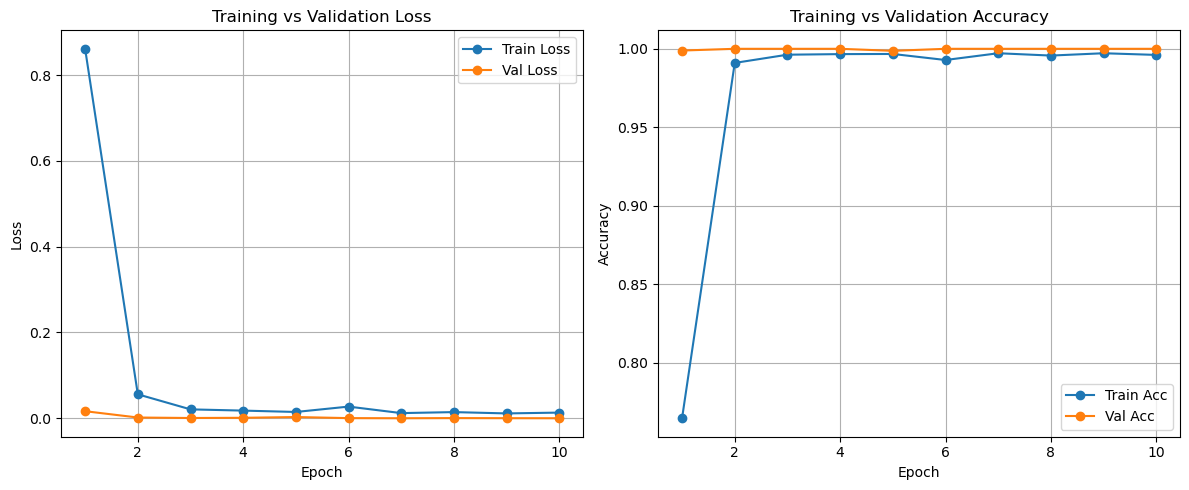

✅ No major overfitting detected yet.


In [49]:
import matplotlib.pyplot as plt
import numpy as np

def plot_training_curves(history):
    """
    history: dict with keys like ['train_loss', 'val_loss', 'train_acc', 'val_acc']
    """
    epochs = range(1, len(history['train_loss']) + 1)

    # Loss plot
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(epochs, history['train_loss'], 'o-', label='Train Loss')
    plt.plot(epochs, history['val_loss'], 'o-', label='Val Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()
    plt.grid(True)

    # Accuracy plot
    plt.subplot(1,2,2)
    plt.plot(epochs, history['train_acc'], 'o-', label='Train Acc')
    plt.plot(epochs, history['val_acc'], 'o-', label='Val Acc')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Training vs Validation Accuracy")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

def detect_overfitting(history, loss_gap_threshold=0.1, acc_gap_threshold=0.05):
    """
    Prints warning if overfitting signs appear:
    - Training loss << validation loss
    - Training acc >> validation acc
    """
    train_loss = np.array(history['train_loss'])
    val_loss   = np.array(history['val_loss'])
    train_acc  = np.array(history['train_acc'])
    val_acc    = np.array(history['val_acc'])

    loss_gap = val_loss - train_loss
    acc_gap  = train_acc - val_acc

    if np.any(loss_gap > loss_gap_threshold) and np.any(acc_gap > acc_gap_threshold):
        print("⚠ Possible Overfitting Detected:")
        print(f"  Max Loss Gap: {loss_gap.max():.4f}")
        print(f"  Max Acc Gap: {acc_gap.max():.4f}")
    else:
        print("✅ No major overfitting detected yet.")

# Example usage after training
# history = {
#     'train_loss': [...],
#     'val_loss': [...],
#     'train_acc': [...],
#     'val_acc': [...]
# }
plot_training_curves(history)
detect_overfitting(history)


In [30]:
import torch

def check_labels_and_counts(dataset):
    from collections import Counter
    try:
        # Convert each label tensor to int before counting
        labels = [int(item[-1].item()) if hasattr(item[-1], 'item') else int(item[-1]) for item in dataset]
    except Exception as e:
        print(f"Error getting labels: {e}")
        labels = []
    counts = Counter(labels)
    print("🔍 Label Distribution:")
    for label, count in counts.items():
        print(f"  Class {label}: {count} samples")

def inspect_random_batch(dataloader, class_names=None):
    batch = next(iter(dataloader))
    if len(batch) == 3:
        inputs1, inputs2, labels = batch
        print(f"📦 Batch shapes: input1={inputs1.shape}, input2={inputs2.shape}")
    else:
        inputs1, labels = batch
        print(f"📦 Batch shape: {inputs1.shape}")

    labels_list = [l.item() if hasattr(l, 'item') else l for l in labels]
    print(f"📝 Labels: {labels_list}")
    
    if class_names:
        # Ensure keys in class_names are integers or strings that match the label type
        label_names = []
        for l in labels_list:
            # Try int keys first, fallback to str
            key = l if l in class_names else str(l)
            # print('Class Names:')
            # print(class_names)
            # print(f'This is the key: {key}')
            label_names.append(class_names.get(key, f"Unknown({l})"))
        print(f"🔍 Label Names: {label_names}")

def forward_pass_check(model, dataloader, device='cpu'):
    """
    Runs one forward pass to check output shapes and sanity.
    """
    model.eval()
    batch = next(iter(dataloader))
    
    # Expecting 3 tensors: raw_x, psd_x, labels
    if len(batch) == 3:
        raw_x, psd_x, _ = batch
        raw_x = raw_x.to(device)
        psd_x = psd_x.to(device)
        with torch.no_grad():
            outputs = model(raw_x, psd_x)
    else:
        inputs, _ = batch
        inputs = inputs.to(device)
        with torch.no_grad():
            outputs = model(inputs)

    print(f"✅ Forward pass OK: Output shape {outputs.shape}")

# ---------------- Data Preparation (use IMUSonarFromJSON directly) ----------------
with open(f"{DATAFILES_DIR}/label_map.json", 'r') as f:
    label_map = json.load(f)
label_map = {v: k for k, v in label_map.items()}

# Example usage before training
check_labels_and_counts(train_dataset)
inspect_random_batch(train_loader, label_map)
forward_pass_check(model, train_loader, device)


🔍 Label Distribution:
  Class 5: 490 samples
  Class 2: 1274 samples
  Class 12: 1752 samples
  Class 11: 1067 samples
  Class 0: 662 samples
  Class 4: 771 samples
  Class 8: 578 samples
  Class 1: 798 samples
  Class 15: 1239 samples
  Class 3: 1321 samples
  Class 25: 611 samples
  Class 10: 575 samples
  Class 27: 404 samples
  Class 18: 1013 samples
  Class 23: 421 samples
  Class 6: 604 samples
  Class 14: 1695 samples
  Class 24: 402 samples
  Class 13: 920 samples
  Class 9: 576 samples
  Class 7: 602 samples
  Class 20: 661 samples
  Class 21: 820 samples
  Class 19: 711 samples
  Class 26: 414 samples
  Class 22: 360 samples
  Class 17: 639 samples
  Class 16: 203 samples
📦 Batch shapes: input1=torch.Size([32, 8, 600]), input2=torch.Size([32, 8, 65])
📝 Labels: [3, 3, 12, 15, 5, 12, 2, 18, 27, 12, 4, 12, 12, 12, 23, 10, 9, 5, 12, 24, 14, 5, 13, 14, 12, 0, 20, 4, 12, 18, 11, 0]
🔍 Label Names: ['tremor_sitting', 'tremor_sitting', 'normal_walking', 'normal_laying', 'tremor_stairs

In [3]:
import torch
import torch.nn as nn
import torch.fft
from torch.utils.data import Dataset, DataLoader
import numpy as np
from scipy.signal import welch, find_peaks

# 1. Data Preprocessing ========================================================
class PostureDataset(Dataset):
    def __init__(self, signals, labels=None, fs=100, device='cuda'):
        """
        signals: List of (timesteps,) numpy arrays
        labels: List of target values (optional)
        fs: Sampling frequency for PSD calculation
        """
        self.device = device
        self.fs = fs
        
        # Precompute input tensors
        self.X = []
        for signal in signals:
            # Compute derivatives
            velocity = np.gradient(signal)
            acceleration = np.gradient(velocity)
            
            # Compute PSD (using Welch's method)
            freqs, psd = welch(signal, fs=fs, nperseg=64)
            psd = psd[:32]  # Keep first 32 frequency bins
            
            # Combine features
            features = np.stack([
                signal, 
                velocity, 
                acceleration,
                np.log(psd + 1e-12)  # Log-PSD for stability
            ], axis=0)
            
            self.X.append(torch.FloatTensor(features))
            
        self.y = torch.FloatTensor(labels) if labels else None

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx].to(self.device)
        if self.y is not None:
            return x, self.y[idx].to(self.device)
        return x

In [ ]:
# 2. Model Architecture ========================================================
class HybridPostureModel(nn.Module):
    def __init__(self, input_channels=4, tcn_channels=64, psd_channels=32,
                 num_classes=2, sequence_length=1000):
        super().__init__()
        
        # Temporal pathway (1D convs)
        self.temporal_net = nn.Sequential(
            nn.Conv1d(input_channels-1, tcn_channels, kernel_size=15, padding=7),
            nn.ReLU(),
            nn.LayerNorm([tcn_channels, sequence_length]),
            nn.Conv1d(tcn_channels, tcn_channels, kernel_size=5, dilation=2, padding=4),
            nn.ReLU()
        )
        
        # PSD pathway
        self.psd_net = nn.Sequential(
            nn.Linear(32, psd_channels),
            nn.ReLU(),
            nn.LayerNorm(psd_channels)
        )
        
        # Attention mechanism
        self.attention = nn.Sequential(
            nn.Conv1d(tcn_channels + psd_channels, 1, kernel_size=1),
            nn.Softmax(dim=2)
        )
        
        # Classifier
        self.classifier = nn.Linear(tcn_channels + psd_channels, num_classes)
        
    def forward(self, x):
        # x shape: (batch, 4, seq_len) [signal, vel, accel, psd]
        temporal = x[:,:3,:]  # First 3 channels
        psd = x[:,3,:32]      # Last channel (PSD)
        
        # Process temporal features
        temporal_out = self.temporal_net(temporal)
        
        # Process PSD features
        psd_out = self.psd_net(psd).unsqueeze(2).repeat(1,1,x.shape[2])
        
        # Combine features
        combined = torch.cat([temporal_out, psd_out], dim=1)
        
        # Attention weighting
        attn_weights = self.attention(combined)
        weighted = combined * attn_weights
        
        # Global average pooling + classify
        pooled = weighted.mean(dim=2)
        return self.classifier(pooled)

In [4]:
# ---------------- Hybrid Model Architecture ----------------
class HybridPostureModel(nn.Module):
    def __init__(self, input_channels=8, tcn_channels=64, psd_channels=32, num_classes=2, sequence_length=600):
        super().__init__()
        
        # Temporal pathway (1D convs)
        self.temporal_net = nn.Sequential(
            nn.Conv1d(input_channels, tcn_channels, kernel_size=15, padding=7),
            nn.ReLU(),
            nn.LayerNorm([tcn_channels, sequence_length]),
            nn.Conv1d(tcn_channels, tcn_channels, kernel_size=5, dilation=2, padding=4),
            nn.ReLU()
        )
        
        # PSD pathway
        self.psd_net = nn.Sequential(
            nn.Linear(32, psd_channels),
            nn.ReLU(),
            nn.LayerNorm(psd_channels)
        )
        
        # Attention mechanism
        self.attention = nn.Sequential(
            nn.Conv1d(tcn_channels + psd_channels, 1, kernel_size=1),
            nn.Softmax(dim=2)
        )
        
        # Classifier
        self.classifier = nn.Linear(tcn_channels + psd_channels, num_classes)
        
    def forward(self, x):
        # x shape: (batch, channels, seq_len)
        
        # Process temporal features
        temporal_out = self.temporal_net(x)
        
        # Compute PSD features (batch-wise)
        psd_features = []
        for i in range(x.shape[0]):
            _, psd = welch(x[i,0,:].cpu().numpy(), nperseg=64)  # Use first channel for PSD
            psd_features.append(torch.from_numpy(psd[:32]).float())
        
        psd_features = torch.stack(psd_features).to(x.device)
        psd_out = self.psd_net(psd_features).unsqueeze(2).repeat(1,1,x.shape[2])
        
        # Combine features
        combined = torch.cat([temporal_out, psd_out], dim=1)
        
        # Attention weighting
        attn_weights = self.attention(combined)
        weighted = combined * attn_weights
        
        # Global average pooling + classify
        pooled = weighted.mean(dim=2)
        return self.classifier(pooled)

In [16]:
class EnhancedHybridModel(nn.Module):
    def __init__(self, input_channels, num_classes, sequence_length):
        super().__init__()
        
        # 1. Local Feature Extraction (Your original layers)
        self.local_net = nn.Sequential(
            nn.Conv1d(input_channels, 64, kernel_size=15, padding=7),
            nn.ReLU(),
            nn.LayerNorm([64, sequence_length]),
            nn.Conv1d(64, 64, kernel_size=5, dilation=2, padding=4),
            nn.ReLU()
        )
        
        # 2. Global Context (New residual TCN)
        self.global_net = nn.Sequential(
            TCNDilatedResidualBlock(64, 64, dilation=1),
            TCNDilatedResidualBlock(64, 64, dilation=2)
        )
        
        # 3. Preserved PSD Pathway
        self.psd_net = nn.Sequential(
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.LayerNorm(32)
        )
        
        # 4. Enhanced Attention (Your mechanism + efficiency)
        self.attention = TemporalAttention(64 + 32)  # Channels after concat
        
        # 5. Classifier
        self.classifier = nn.Linear(64 + 32, num_classes)

    def forward(self, x):
        # Local features (your original)
        local = self.local_net(x)
        
        # Global context (new)
        global_ctx = self.global_net(local)
        
        # PSD (your original method)
        psd = torch.stack([torch.from_numpy(
              welch(x[i,0].cpu().numpy(), nperseg=64)[0][:32]).float() 
              for i in range(x.shape[0])]).to(x.device)
        psd_feat = self.psd_net(psd).unsqueeze(2).repeat(1,1,x.shape[2])
        
        # Combine + Attention (preserved)
        combined = torch.cat([global_ctx, psd_feat], dim=1)
        weighted = self.attention(combined)
        
        # Classify
        pooled = weighted.mean(dim=2)
        return self.classifier(pooled)

# Enhanced attention (preserves yours but is more efficient)
class TemporalAttention(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.attn = nn.Sequential(
            nn.Conv1d(channels, channels//8, 1),
            nn.ReLU(),
            nn.Conv1d(channels//8, channels, 1),
            nn.Softmax(dim=2)
        )
    
    def forward(self, x):
        return x * self.attn(x)

In [46]:
import torch
import torch.nn as nn
import numpy as np
from scipy.signal import welch

class TCNDilatedResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dilation, kernel_size=5, dropout_rate=0.3):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size,
                              padding=(kernel_size-1)*dilation//2,
                              dilation=dilation)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size,
                              padding=(kernel_size-1)*dilation//2,
                              dilation=dilation)
        self.norm = nn.BatchNorm1d(out_channels)
        self.relu = nn.LeakyReLU(0.1)
        self.dropout = nn.Dropout(dropout_rate)
        self.downsample = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else None
        
    def forward(self, x):
        residual = x
        
        out = self.conv1(x)
        out = self.norm(out)
        out = self.relu(out)
        out = self.dropout(out)
        
        out = self.conv2(out)
        out = self.norm(out)
        out = self.dropout(out)
        
        if self.downsample:
            residual = self.downsample(residual)
        
        if residual.size(-1) != out.size(-1):
            diff = out.size(-1) - residual.size(-1)
            residual = F.pad(residual, (diff//2, diff - diff//2))
            
        return self.relu(out + residual)

class TemporalAttention(nn.Module):
    """Memory-efficient attention with dropout"""
    def __init__(self, channels, dropout_rate=0.1):
        super().__init__()
        self.query = nn.Conv1d(channels, channels//8, 1)
        self.key = nn.Conv1d(channels, channels//8, 1)
        self.value = nn.Conv1d(channels, channels, 1)
        self.gamma = nn.Parameter(torch.zeros(1))
        self.dropout = nn.Dropout(dropout_rate)
        
    def forward(self, x):
        B, C, T = x.shape
        # Projections
        q = self.dropout(self.query(x).transpose(1, 2))  # (B, T, C//8)
        k = self.dropout(self.key(x))                    # (B, C//8, T)
        v = self.dropout(self.value(x))                  # (B, C, T)
        
        # Attention
        attn = F.softmax(torch.bmm(q, k) / np.sqrt(C//8), dim=-1)  # (B, T, T)
        out = torch.bmm(v, attn.transpose(1, 2))
        return self.gamma * out + x  # Residual connection

class EnhancedHybridModel(nn.Module):
    def __init__(self, input_channels=8, num_classes=2, sequence_length=600, dropout_rate=0.5):
        super().__init__()
        tcn_channels = 64
        psd_channels = 32
        
        # 1. Local feature extractor
        self.local_net = nn.Sequential(
            nn.Conv1d(input_channels, tcn_channels, 15, padding=7),
            nn.BatchNorm1d(tcn_channels),
            nn.LeakyReLU(0.1),
            nn.Dropout(dropout_rate),
            
            nn.Conv1d(tcn_channels, tcn_channels, 5, dilation=2, padding=4),
            nn.BatchNorm1d(tcn_channels),
            nn.LeakyReLU(0.1),
            nn.Dropout(dropout_rate)
        )
        
        # 2. Global blocks - spectral norm only on conv layers
        self.global_net = nn.Sequential(
            self._make_tcn_block(tcn_channels, dilation=1, dropout_rate=dropout_rate),
            self._make_tcn_block(tcn_channels, dilation=2, dropout_rate=dropout_rate),
            self._make_tcn_block(tcn_channels, dilation=4, dropout_rate=dropout_rate)
        )
        
        # 3. PSD pathway
        self.psd_net = nn.Sequential(
            nn.Linear(32, psd_channels),
            nn.LeakyReLU(0.1),
            nn.LayerNorm(psd_channels),
            nn.Dropout(0.4)
        )
        
        # 4. Classifier
        self.classifier = nn.Sequential(
            nn.utils.parametrizations.weight_norm(nn.Linear(tcn_channels + psd_channels, num_classes)),
            nn.LogSoftmax(dim=1)
        )
        
    def _make_tcn_block(self, channels, dilation, dropout_rate):
        conv = nn.Conv1d(channels, channels, 5, 
                        padding=(5-1)*dilation//2,
                        dilation=dilation)
        return nn.Sequential(
            nn.utils.spectral_norm(conv),
            nn.BatchNorm1d(channels),
            nn.LeakyReLU(0.1),
            nn.Dropout(dropout_rate)
        )
    
    def forward(self, x):
        B, C, T = x.shape
        
        # 1. Local features
        local = self.local_net(x)
        
        # 2. Global context
        global_ctx = self.global_net(local)
        
        # 3. PSD computation
        psd_list = []
        for i in range(B):
            _, psd = welch(x[i,0].cpu().numpy(), nperseg=min(64, T))
            psd_list.append(torch.from_numpy(psd[:32]).float())
        psd = torch.stack(psd_list).to(x.device)
        psd_feat = self.psd_net(psd)
        
        # 4. Classify
        pooled = global_ctx.mean(dim=-1)
        combined = torch.cat([pooled, psd_feat], dim=1)
        return self.classifier(combined)

In [12]:
import os
import gc
import json
import torch
import random
import numpy as np
from time import time
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from collections import defaultdict
from scipy.signal import welch, find_peaks

# ---------------- Memory & Device Config ----------------
os.environ['PYTORCH_MPS_HIGH_WATERMARK_RATIO'] = '0.0'
os.environ['PYTORCH_MPS_MAX_CACHE_SIZE'] = '0'

def print_memory_stats(prefix=""):
    if torch.backends.mps.is_available():
        alloc = torch.mps.current_allocated_memory() / 1e9
        reserved = torch.mps.driver_allocated_memory() / 1e9
        print(f"{prefix} Memory: Alloc={alloc:.2f}GB, Reserved={reserved:.2f}GB")

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

if torch.backends.mps.is_available():
    device = torch.device("mps")
    torch.mps.manual_seed(42)
    torch.mps.set_per_process_memory_fraction(1.0)
elif torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed(42)
    torch.cuda.set_per_process_memory_fraction(1.0)
else:
    device = torch.device("cpu")

print(f"Using device: {device}")
print_memory_stats("Initial")

# ---------------- Dataset Class ----------------
class PSDAwareWindowDataset(Dataset):
    def __init__(self, signals, labels, fs=100):
        self.signals = signals
        self.labels = labels
        self.fs = fs
        
    def __len__(self):
        return len(self.signals)
    
    def __getitem__(self, idx):
        signal = self.signals[idx]
        label = self.labels[idx]
        
        # Compute derivatives for each channel
        derivatives = []
        for ch in range(signal.shape[0]):
            vel = np.gradient(signal[ch])
            acc = np.gradient(vel)
            derivatives.extend([signal[ch], vel, acc])
        
        # Stack all channels and derivatives
        temporal_features = np.stack(derivatives, axis=0)
        
        # Compute PSD for first channel
        _, psd = welch(signal[0], fs=self.fs, nperseg=64)
        psd_features = np.log(psd[:32] + 1e-12)  # Log-PSD
        
        return (
            torch.FloatTensor(temporal_features),  # Shape: (n_channels*3, seq_len)
            # torch.tensor(label, dtype=torch.long)  # Single label per window
            label
        )

# # ---------------- Model Architecture ----------------
# class HybridPostureModel(nn.Module):
#     def __init__(self, input_channels, num_classes, sequence_length):
#         super().__init__()
#         tcn_channels = 64
#         psd_channels = 32
        
#         # Temporal pathway
#         self.temporal_net = nn.Sequential(
#             nn.Conv1d(input_channels, tcn_channels, kernel_size=15, padding=7),
#             nn.ReLU(),
#             nn.LayerNorm([tcn_channels, sequence_length]),
#             nn.Conv1d(tcn_channels, tcn_channels, kernel_size=5, dilation=2, padding=4),
#             nn.ReLU()
#         )
        
#         # PSD pathway
#         self.psd_net = nn.Sequential(
#             nn.Linear(32, psd_channels),
#             nn.ReLU(),
#             nn.LayerNorm(psd_channels)
#         )
        
#         # Attention mechanism
#         self.attention = nn.Sequential(
#             nn.Conv1d(tcn_channels + psd_channels, 1, kernel_size=1),
#             nn.Softmax(dim=2)
#         )
        
#         # Classifier
#         self.classifier = nn.Linear(tcn_channels + psd_channels, num_classes)
        
#     def forward(self, x):
#         # x shape: (batch, channels, seq_len)
#         temporal_out = self.temporal_net(x)
        
#         # Compute PSD features (batch-wise)
#         psd_features = []
#         for i in range(x.shape[0]):
#             _, psd = welch(x[i,0,:].cpu().numpy(), nperseg=64)
#             psd_features.append(torch.from_numpy(np.log(psd[:32] + 1e-12)).float())
        
#         psd_features = torch.stack(psd_features).to(x.device)
#         psd_out = self.psd_net(psd_features).unsqueeze(2).repeat(1,1,x.shape[2])
        
#         # Combine features
#         combined = torch.cat([temporal_out, psd_out], dim=1)
        
#         # Attention weighting
#         attn_weights = self.attention(combined)
#         weighted = combined * attn_weights
        
#         # Global average pooling + classify
#         pooled = weighted.mean(dim=2)
#         return self.classifier(pooled)

# ---------------- Data Preparation ----------------
with open(f"{DATAFILES_DIR}/label_map.json", 'r') as f:
    label_map = json.load(f)

train_dataset = IMUSonarFromJSON(f"{DATAFILES_DIR}/train.json", label_map=label_map)
test_dataset = IMUSonarFromJSON(f"{DATAFILES_DIR}/test.json", label_map=label_map)

# Prepare windowed datasets
train_data = [x for x,_ in train_dataset]
train_labels = [y for _,y in train_dataset]
test_data = [x for x,_ in test_dataset]
test_labels = [y for _,y in test_dataset]

train_dataset = PSDAwareWindowDataset(train_data, train_labels)
test_dataset = PSDAwareWindowDataset(test_data, test_labels)

# ---------------- Training Setup ----------------
batch_size = 32
epochs = 25
accumulation_steps = 2

# Get sample dimensions from first batch
sample, _ = train_dataset[0]
input_channels = sample.shape[0]
sequence_length = sample.shape[1]
num_classes = len(label_map)

# Create DataLoaders (Jupyter-safe)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0  # Critical for Jupyter
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    num_workers=0  # Critical for Jupyter
)

# Initialize model
model = HybridPostureModel(
    input_channels=input_channels,
    num_classes=num_classes,
    sequence_length=sequence_length
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)

# ---------------- Training Loop ----------------
history = defaultdict(list)
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    train_loss, correct, total = 0.0, 0, 0
    epoch_start = time()

    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = model(inputs)
        loss = criterion(outputs, labels) / accumulation_steps
        loss.backward()

        if (batch_idx + 1) % accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad(set_to_none=True)

        train_loss += loss.item() * accumulation_steps
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        if batch_idx % 10 == 0:
            if torch.backends.mps.is_available(): torch.mps.empty_cache()
            if torch.cuda.is_available(): torch.cuda.empty_cache()
            gc.collect()

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(test_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            val_loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

            if batch_idx % 10 == 0:
                if torch.backends.mps.is_available(): torch.mps.empty_cache()
                elif torch.cuda.is_available(): torch.cuda.empty_cache()
                gc.collect()

    # Logging
    history['train_loss'].append(train_loss / len(train_loader))
    history['train_acc'].append(correct / total)
    history['val_loss'].append(val_loss / len(test_loader))
    history['val_acc'].append(val_correct / val_total)

    print(f"Epoch {epoch + 1}/{epochs} - {time() - epoch_start:.1f}s")
    print(f"Train Loss: {history['train_loss'][-1]:.4f} Acc: {history['train_acc'][-1]:.4f}")
    print(f"Val Loss: {history['val_loss'][-1]:.4f} Acc: {history['val_acc'][-1]:.4f}")
    print_memory_stats("Epoch End")
    print()

    if torch.backends.mps.is_available(): torch.mps.empty_cache()
    elif torch.cuda.is_available(): torch.cuda.empty_cache()
    gc.collect()

# ---------------- Final Evaluation ----------------
def safe_evaluate(model, loader):
    model.eval()
    total_loss, correct = 0.0, 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            total_loss += criterion(outputs, labels).item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()

            if torch.backends.mps.is_available(): torch.mps.empty_cache()
            elif torch.cuda.is_available(): torch.cuda.empty_cache()
            gc.collect()
    
    return total_loss / len(loader.dataset), correct / len(loader.dataset)

train_loss, train_acc = safe_evaluate(model, train_loader)
test_loss, test_acc = safe_evaluate(model, test_loader)

print('Final Results:')
print(f'Train loss: {train_loss:.4f}, accuracy: {train_acc:.4f}')
print(f'Test loss: {test_loss:.4f}, accuracy: {test_acc:.4f}')
print_memory_stats("Final")

Using device: mps
Initial Memory: Alloc=0.01GB, Reserved=0.05GB
Raw CSV shape: (600, 9)
First 5 raw samples:
[[5.5007e+04 1.5000e-02]
 [5.5064e+04 3.2000e-02]
 [5.5120e+04 2.6000e-02]
 [5.5177e+04 6.0000e-03]
 [5.5233e+04 3.0000e-02]]
After resampling: (8, 600)
First 5 processed: [[ 1.46237128  1.5423411 ]
 [-0.81674595 -0.83407519]
 [-0.79317625 -0.82619732]
 [ 0.16111365  0.07438375]
 [ 0.04515093 -0.10166838]]
Final tensor shape: torch.Size([8, 600])
Tensor first 5: tensor([[ 1.4624,  1.5423],
        [-0.8167, -0.8341],
        [-0.7932, -0.8262],
        [ 0.1611,  0.0744],
        [ 0.0452, -0.1017]])

PREPROCESSING STEPS:
Pre-normalization mean: -0.0000, std: 1.0000
Sample of the tensor: tensor([[ 1.4624,  1.5423,  1.5033,  ..., -0.1709, -0.4976, -0.1633],
        [-0.8167, -0.8341, -0.8376,  ...,  0.2475,  0.2765,  0.3212],
        [-0.7932, -0.8262, -0.9228,  ...,  0.9019,  1.2862,  0.8560],
        ...,
        [ 0.0466,  0.0143,  0.0493,  ..., -0.0437, -0.0263, -0.1180],
   

In [13]:
# Save the model
torch.save(model.state_dict(), f"{MODELFILES_DIR}/handgestures_6-channel_RAW_CNN-Temporal-PSD-ATTN_model_weights_98percent.pt")

# Save the history (loss and accuracy)
df_history = pd.DataFrame(history)
df_history.to_csv(f"{MODELFILES_DIR}/handgestures_6-channel_RAW_CNN-Temporal-PSD-ATTN_training_history_98percent.csv", index=False)

In [9]:
# Device setup (check hardware in platform)
if torch.backends.mps.is_available(): device = torch.device("mps")
elif torch.cuda.is_available(): device = torch.device("cuda")
else: device = torch.device("cpu")

# ---------------- Data Preparation ----------------
with open(f"{DATAFILES_DIR}/label_map.json", 'r') as f:
    label_map = json.load(f)

train_dataset = IMUSonarFromJSON(f"{DATAFILES_DIR}/train.json", label_map=label_map)
test_dataset = IMUSonarFromJSON(f"{DATAFILES_DIR}/test.json", label_map=label_map)

# Get sample dimensions from first batch
sample, _ = train_dataset[0]
sequence_length = sample.shape[1]

# model = CNNLSTM(input_channels=6, num_classes=len(label_dict)).to(device)
model = HybridPostureModel(input_channels=8, num_classes=len(label_dict), sequence_length=sequence_length).to(device)

# 3. Load the saved weights
model.load_state_dict(
    torch.load(f"{MODELFILES_DIR}/handgestures_6-channel_RAW_CNN-Temporal-PSD-ATTN_model_weights_98percent.pt",
               map_location=device,
               weights_only=False))

# model.eval()  # Set to evaluation mode

<All keys matched successfully>

In [47]:
import os
import gc
import json
import torch
import random
import numpy as np
from time import time
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from collections import defaultdict
from scipy.signal import welch, find_peaks

# ---------------- Memory & Device Config ----------------
os.environ['PYTORCH_MPS_HIGH_WATERMARK_RATIO'] = '0.0'
os.environ['PYTORCH_MPS_MAX_CACHE_SIZE'] = '0'

def print_memory_stats(prefix=""):
    if torch.backends.mps.is_available():
        alloc = torch.mps.current_allocated_memory() / 1e9
        reserved = torch.mps.driver_allocated_memory() / 1e9
        print(f"{prefix} Memory: Alloc={alloc:.2f}GB, Reserved={reserved:.2f}GB")

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

if torch.backends.mps.is_available():
    device = torch.device("mps")
    torch.mps.manual_seed(42)
    torch.mps.set_per_process_memory_fraction(1.0)
elif torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed(42)
    torch.cuda.set_per_process_memory_fraction(1.0)
else:
    device = torch.device("cpu")

print(f"Using device: {device}")
print_memory_stats("Initial")

# ---------------- MixUp Augmentation ----------------
def mixup_data(x, y, alpha=0.4):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(x.device)
    
    mixed_x = lam * x + (1 - lam) * x[index]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

# ---------------- Dataset Class ----------------
class PSDAwareWindowDataset(Dataset):
    def __init__(self, signals, labels, fs=100):
        self.signals = signals
        self.labels = labels
        self.fs = fs
        
    def __len__(self):
        return len(self.signals)
    
    def __getitem__(self, idx):
        signal = self.signals[idx]
        label = self.labels[idx]
        
        # Compute derivatives for each channel
        derivatives = []
        for ch in range(signal.shape[0]):
            vel = np.gradient(signal[ch])
            acc = np.gradient(vel)
            derivatives.extend([signal[ch], vel, acc])
        
        # Stack all channels and derivatives
        temporal_features = np.stack(derivatives, axis=0)
        
        # Compute PSD for first channel
        _, psd = welch(signal[0], fs=self.fs, nperseg=64)
        psd_features = np.log(psd[:32] + 1e-12)  # Log-PSD
        
        return (
            torch.FloatTensor(temporal_features),
            # torch.tensor(label, dtype=torch.long)  # Proper tensor construction
            label
        )

# ---------------- Data Preparation ----------------
with open(f"{DATAFILES_DIR}/label_map.json", 'r') as f:
    label_map = json.load(f)

train_dataset = IMUSonarFromJSON(f"{DATAFILES_DIR}/train.json", label_map=label_map)
test_dataset = IMUSonarFromJSON(f"{DATAFILES_DIR}/test.json", label_map=label_map)

# Prepare windowed datasets
train_data = [x for x,_ in train_dataset]
train_labels = [y for _,y in train_dataset]
test_data = [x for x,_ in test_dataset]
test_labels = [y for _,y in test_dataset]

train_dataset = PSDAwareWindowDataset(train_data, train_labels)
test_dataset = PSDAwareWindowDataset(test_data, test_labels)

# ---------------- Training Setup ----------------
batch_size = 32
epochs = 25
accumulation_steps = 2

# Get sample dimensions
sample, _ = train_dataset[0]
input_channels = sample.shape[0]
sequence_length = sample.shape[1]
num_classes = len(label_map)

# Create DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    num_workers=0
)

# Initialize model with enhanced regularization
model = EnhancedHybridModel(
    input_channels=input_channels,
    num_classes=num_classes,
    sequence_length=sequence_length,
    dropout_rate=0.5
).to(device)

# Use label smoothing + KL divergence loss
criterion = nn.KLDivLoss(reduction='batchmean')
optimizer = AdamW(model.parameters(), 
                 lr=1e-4, 
                 weight_decay=1e-4)

# OneCycle learning rate scheduler
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, 
    max_lr=1e-3,
    steps_per_epoch=len(train_loader),
    epochs=epochs
)

# ---------------- Training Loop ----------------
history = defaultdict(list)
best_val_loss = float('inf')

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    epoch_start = time()

    for batch_idx, (inputs, labels) in enumerate(train_loader):
        # Apply MixUp augmentation
        inputs, targets_a, targets_b, lam = mixup_data(inputs, labels)
        inputs = inputs.to(device)
        targets_a = targets_a.to(device)
        targets_b = targets_b.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        log_probs = F.log_softmax(outputs, dim=1)
        
        # Label smoothed loss
        loss = lam * criterion(log_probs, F.one_hot(targets_a, num_classes).float()) + \
               (1 - lam) * criterion(log_probs, F.one_hot(targets_b, num_classes).float())
        
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        optimizer.step()
        scheduler.step()
        
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += predicted.eq(labels.to(device)).sum().item()

        if batch_idx % 10 == 0:
            if torch.backends.mps.is_available(): torch.mps.empty_cache()
            elif torch.cuda.is_available(): torch.cuda.empty_cache()
            gc.collect()

    # Validation with temperature scaling
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs) / 1.5  # Temperature scaling
            log_probs = F.log_softmax(outputs, dim=1)
            loss = criterion(log_probs, F.one_hot(labels, num_classes).float())
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

    # Update learning rate
    current_lr = scheduler.get_last_lr()[0]
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')
    
    # Logging
    history['train_loss'].append(train_loss / len(train_loader))
    history['train_acc'].append(correct / total)
    history['val_loss'].append(val_loss / len(test_loader))
    history['val_acc'].append(val_correct / val_total)
    history['lr'].append(current_lr)

    print(f"Epoch {epoch + 1}/{epochs} - {time() - epoch_start:.1f}s")
    print(f"LR: {current_lr:.2e} | Train Loss: {history['train_loss'][-1]:.4f} Acc: {100.*correct/total:.2f}%")
    print(f"Train Loss: {history['train_loss'][-1]:.4f} Acc: {history['train_acc'][-1]:.4f}")
    print(f"Val Loss: {history['val_loss'][-1]:.4f} Acc: {100.*val_correct/val_total:.2f}%")
    print_memory_stats("Epoch End")
    print()

    if torch.backends.mps.is_available(): torch.mps.empty_cache()
    elif torch.cuda.is_available(): torch.cuda.empty_cache()
    gc.collect()

# ---------------- Final Evaluation ----------------
def safe_evaluate(model, loader):
    model.eval()
    total_loss, correct = 0.0, 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs) / 1.5  # Temperature scaling
            log_probs = F.log_softmax(outputs, dim=1)
            loss = criterion(log_probs, F.one_hot(labels, num_classes).float())
            
            total_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += predicted.eq(labels).sum().item()

    return total_loss / len(loader.dataset), correct / len(loader.dataset)

# Load best model
model.load_state_dict(torch.load('best_model.pth'))
train_loss, train_acc = safe_evaluate(model, train_loader)
test_loss, test_acc = safe_evaluate(model, test_loader)

print('Final Results:')
print(f'Train loss: {train_loss:.4f}, accuracy: {100.*train_acc:.2f}%')
print(f'Test loss: {test_loss:.4f}, accuracy: {100.*test_acc:.2f}%')
print_memory_stats("Final")

Using device: mps
Initial Memory: Alloc=0.01GB, Reserved=0.07GB
Raw CSV shape: (600, 9)
First 5 raw samples:
[[5.5007e+04 1.5000e-02]
 [5.5064e+04 3.2000e-02]
 [5.5120e+04 2.6000e-02]
 [5.5177e+04 6.0000e-03]
 [5.5233e+04 3.0000e-02]]
After resampling: (8, 600)
First 5 processed: [[ 1.46237128  1.5423411 ]
 [-0.81674595 -0.83407519]
 [-0.79317625 -0.82619732]
 [ 0.16111365  0.07438375]
 [ 0.04515093 -0.10166838]]
Final tensor shape: torch.Size([8, 600])
Tensor first 5: tensor([[ 1.4624,  1.5423],
        [-0.8167, -0.8341],
        [-0.7932, -0.8262],
        [ 0.1611,  0.0744],
        [ 0.0452, -0.1017]])

PREPROCESSING STEPS:
Pre-normalization mean: -0.0000, std: 1.0000
Sample of the tensor: tensor([[ 1.4624,  1.5423,  1.5033,  ..., -0.1709, -0.4976, -0.1633],
        [-0.8167, -0.8341, -0.8376,  ...,  0.2475,  0.2765,  0.3212],
        [-0.7932, -0.8262, -0.9228,  ...,  0.9019,  1.2862,  0.8560],
        ...,
        [ 0.0466,  0.0143,  0.0493,  ..., -0.0437, -0.0263, -0.1180],
   

In [48]:
# Save the model
torch.save(model.state_dict(), f"{MODELFILES_DIR}/handgestures_6-channel_RAW_CNN-TCN-PSD-ATTN_model_weights_99percent.pt")

# Save the history (loss and accuracy)
df_history = pd.DataFrame(history)
df_history.to_csv(f"{MODELFILES_DIR}/handgestures_6-channel_RAW_CNN-TCN-PSD-ATTN_training_history_99percent.csv", index=False)

In [9]:
# Device setup (check hardware in platform)
if torch.backends.mps.is_available(): device = torch.device("mps")
elif torch.cuda.is_available(): device = torch.device("cuda")
else: device = torch.device("cpu")

# ---------------- Data Preparation ----------------
with open(f"{DATAFILES_DIR}/label_map.json", 'r') as f:
    label_map = json.load(f)

train_dataset = IMUSonarFromJSON(f"{DATAFILES_DIR}/train.json", label_map=label_map)
test_dataset = IMUSonarFromJSON(f"{DATAFILES_DIR}/test.json", label_map=label_map)

# Get sample dimensions from first batch
sample, _ = train_dataset[0]
sequence_length = sample.shape[1]

# model = CNNLSTM(input_channels=6, num_classes=len(label_dict)).to(device)
model = HybridPostureModel(input_channels=8, num_classes=len(label_dict), sequence_length=sequence_length).to(device)

# 3. Load the saved weights
model.load_state_dict(
    torch.load(f"{MODELFILES_DIR}/handgestures_6-channel_RAW_CNN-Temporal-PSD-ATTN_model_weights_98percent.pt",
               map_location=device,
               weights_only=False))

# model.eval()  # Set to evaluation mode

<All keys matched successfully>

# Load RAW data and Preprocess


In [6]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# import numpy as np
# from scipy import signal

class RawCNNTCNPSDModel(nn.Module):
    """Condensed IMU-only model with essential components"""
    def __init__(self, input_channels=6, num_classes=4, seq_len=600, fs=50.0):
        super().__init__()
        self.seq_len = seq_len
        self.fs = fs
        
        # Multi-scale feature extractor (combined into single module)
        self.feature_extractor = nn.ModuleDict({
            'large': nn.Sequential(
                nn.Conv1d(input_channels, 32, 15, padding=7, stride=2),
                nn.BatchNorm1d(32),
                nn.GELU(),
                nn.Conv1d(32, 32, 15, padding=7),
                nn.BatchNorm1d(32),
                nn.GELU(),
                nn.AdaptiveAvgPool1d(150)
            ),
            'medium': nn.Sequential(
                nn.Conv1d(input_channels, 32, 11, padding=5, stride=2),
                nn.BatchNorm1d(32),
                nn.GELU(),
                nn.Conv1d(32, 32, 11, padding=5),
                nn.BatchNorm1d(32),
                nn.GELU(),
                nn.AdaptiveAvgPool1d(150)
            ),
            'small': nn.Sequential(
                nn.Conv1d(input_channels, 32, 7, padding=3, stride=2),
                nn.BatchNorm1d(32),
                nn.GELU(),
                nn.Conv1d(32, 32, 7, padding=3),
                nn.BatchNorm1d(32),
                nn.GELU(),
                nn.AdaptiveAvgPool1d(150)
            )
        })
        
        # Temporal processing
        self.temporal_conv = nn.Sequential(
            nn.Conv1d(96, 64, 3, padding=1),  # 96 from 3x32 multi-scale
            nn.BatchNorm1d(64),
            nn.GELU(),
            *[nn.Sequential(  # Simplified TCN blocks
                nn.Conv1d(64, 64, 3, padding=2**i, dilation=2**i),
                nn.BatchNorm1d(64),
                nn.GELU(),
                nn.Dropout(0.2)
            ) for i in range(5)]
        )
        
        # Frequency domain processing
        self.psd_processor = nn.Sequential(
            nn.Conv1d(5, 16, 3, padding=1),  # 5 PSD features per channel
            nn.BatchNorm1d(16),
            nn.GELU(),
            nn.AdaptiveAvgPool1d(32)
        )
        
        # Temporal attention
        self.temporal_attention = nn.Sequential(
            nn.Linear(64+32, 64),  # Combined time + freq features
            nn.Tanh(),
            nn.Linear(64, 1),
            nn.Softmax(dim=1)
        )
        
        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(64, 128),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def compute_psd(self, x):
        """Inlined PSD computation"""
        batch_size, channels, seq_len = x.shape
        x_np = x.detach().cpu().numpy()
        psd_features = []
        
        for b in range(batch_size):
            for c in range(channels):
                freqs, psd = signal.welch(x_np[b, c], fs=self.fs, nperseg=min(256, seq_len//4))
                tremor_mask = (freqs >= 4) & (freqs <= 12)
                movement_mask = (freqs >= 0.5) & (freqs <= 4)
                
                features = np.array([
                    np.sum(psd[tremor_mask]) / (np.sum(psd) + 1e-8),
                    np.sum(psd[movement_mask]) / (np.sum(psd) + 1e-8),
                    np.log(np.sum(psd) + 1e-8),
                    np.mean(psd),
                    np.std(psd)
                ])
                psd_features.append(features)
        
        return torch.tensor(np.array(psd_features).reshape(batch_size, channels, 5), 
                          dtype=x.dtype, device=x.device)

    def forward(self, x):
        # x shape: [batch, time_steps, channels, seq_len]
        batch_size = x.shape[0]
        
        # Process last time step only (can modify to process all if needed)
        imu_data = x[:, -1, :, :]  # [batch, channels, seq_len]
        
        # Multi-scale feature extraction
        features = [ext(imu_data) for ext in self.feature_extractor.values()]
        combined_features = torch.cat(features, dim=1)  # [batch, 96, 150]
        
        # Temporal processing
        temporal_features = self.temporal_conv(combined_features)  # [batch, 64, 150]
        temporal_features = temporal_features.mean(dim=-1)  # [batch, 64]
        
        # Frequency domain processing
        psd_feats = self.compute_psd(imu_data)  # [batch, channels, 5]
        psd_feats = psd_feats.mean(dim=1)  # Average across channels [batch, 5]
        psd_feats = self.psd_processor(psd_feats.unsqueeze(-1)).squeeze(-1)  # [batch, 32]
        
        # Feature fusion with attention
        combined = torch.cat([temporal_features, psd_feats], dim=1)  # [batch, 96]
        attn_weights = self.temporal_attention(combined)  # [batch, 1]
        weighted_features = attn_weights * temporal_features  # [batch, 64]
        
        # Classification
        return self.classifier(weighted_features)

class FocalLoss(nn.Module):
    """Condensed Focal Loss"""
    def __init__(self, alpha=1, gamma=2):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        
    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        return (self.alpha * (1-pt)**self.gamma * ce_loss).mean()

In [2]:
# import os
# import pandas as pd
# import torch
# from torch.utils.data import Dataset
# import numpy as np
# from glob import glob

class IMUSonarHierarchicalDataset(Dataset):
    def __init__(self, root_dir, label_map=None, transform=None):
        self.samples = []
        self.transform = transform
        self.label_map = label_map or {}

        for csv_path in glob(os.path.join(root_dir, '**', '*.csv'), recursive=True) + \
                        glob(os.path.join(root_dir, '**', '*.CSV'), recursive=True):
            parts = os.path.normpath(csv_path).split(os.sep)

            # Skip invalid cases
            if len(parts) < 5:
                continue

            # Traverse upward, skipping 'variant' directories
            labels = []
            count = 0
            i = len(parts) - 2  # start from the directory containing the file
            while i >= 0 and count < 2:
                if parts[i].lower() != 'variants':
                    labels.insert(0, parts[i])
                    count += 1
                i -= 1

            if len(labels) != 2:
                continue  # skip if we couldn’t find 2 valid label levels

            label_key = '_'.join(labels)
            if label_key not in self.label_map:
                self.label_map[label_key] = len(self.label_map)

            self.samples.append((csv_path, self.label_map[label_key]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        csv_path, label = self.samples[idx]
        df = pd.read_csv(csv_path)

        # Drop timestamp (assuming it's column 0), keep 8 sensor channels
        sensor_data = df.iloc[:, 1:].values.astype(np.float32)
        if sensor_data.shape != (600, 8):
            raise ValueError(f"Invalid shape {sensor_data.shape} in {csv_path}")

        # # Per-sample channel-wise normalization
        # sensor_data = (sensor_data - sensor_data.mean(axis=0)) / (sensor_data.std(axis=0) + 1e-6)
        # sensor_data = sensor_data.T  # shape: (8, 600)

        # if self.transform:
        #     sensor_data = self.transform(sensor_data)

        return torch.tensor(sensor_data), torch.tensor(label)


In [3]:
# import os
# import json
# import random

def generate_json_splits(root_dir, output_dir, train_ratio=0.8, seed=42):
    # Use your existing dataset class to parse files and labels
    dataset = IMUSonarHierarchicalDataset(root_dir)
    samples = dataset.samples  # list of (csv_path, label)
    label_map = dataset.label_map

    # Convert to JSON-compatible format
    json_samples = [{'path': path, 'label': label} for path, label in samples]

    # Shuffle and split
    random.seed(seed)
    random.shuffle(json_samples)
    split_idx = int(len(json_samples) * train_ratio)
    train_samples = json_samples[:split_idx]
    test_samples = json_samples[split_idx:]

    # Save to JSON
    os.makedirs(output_dir, exist_ok=True)
    with open(os.path.join(output_dir, 'train.json'), 'w') as f:
        json.dump(train_samples, f, indent=2)
    with open(os.path.join(output_dir, 'test.json'), 'w') as f:
        json.dump(test_samples, f, indent=2)
    with open(os.path.join(output_dir, 'label_map.json'), 'w') as f:
        json.dump(label_map, f, indent=2)

    print(f"Saved {len(train_samples)} training samples and {len(test_samples)} test samples.")
    print(f"Labels: {len(label_map)} classes written to label_map.json.")

# Generate the files
generate_json_splits(
    root_dir=COLLECTIONFILES_DIR,
    output_dir=DATAFILES_DIR,
    train_ratio=0.8,
    seed=42
)

Saved 21583 training samples and 5396 test samples.
Labels: 28 classes written to label_map.json.


In [9]:
class IMUSonarFromJSON(Dataset):
    """ Class Columns"""
    cols = [
        'AccelX(g)', 'AccelY(g)', 'AccelZ(g)', 
        'GyroX(deg/s)', 'GyroY(deg/s)', 'GyroZ(deg/s)',
        'DistanceLeft(cm)', 'DistanceRight(cm)'
    ]
    
    def __init__(self, json_file, label_map=None, transform=None, target_length=600, debug=False):
        with open(json_file, 'r') as f:
            self.samples = json.load(f)

        self.transform = transform
        self.label_map = {v: k for k, v in label_map.items()} or {}
        self.target_length = target_length
        self.debug = debug
        self.cols = IMUSonarFromJSON.cols

    def __len__(self):
        return len(self.samples)
    
    def compute_global_stats(self):
        """Run this once before training"""
        all_data = torch.stack([torch.tensor(self._resample_to_uniform(pd.read_csv(item['path']))) 
                              for item in self.samples])
        self.global_mean = all_data.mean(dim=(0,2))  # [8]
        self.global_std = all_data.std(dim=(0,2))    # [8]

    def _resample_to_uniform(self, df):
        # 1. Ensure required columns
        timestamps = df['Timestamp(ms)'].values.astype(np.float32)
        missing = set(self.cols) - set(df.columns)
        if missing:
            raise ValueError(f"Missing required columns: {missing}")
        signals = df[self.cols].values.astype(np.float32)
    
        # 2. Remove duplicates
        timestamps, unique_indices = np.unique(timestamps, return_index=True)
        signals = signals[unique_indices]
    
        # 3. Interpolate to uniform time grid
        uniform_timestamps = np.linspace(timestamps[0], timestamps[-1], num=self.target_length)
        resampled = np.zeros((self.target_length, len(self.cols)))
        for i in range(len(self.cols)):
            interp_func = interp1d(timestamps, signals[:, i], kind='linear', fill_value="extrapolate")
            resampled[:, i] = interp_func(uniform_timestamps)
        
        if self.debug:
            print("\nPREPROCESSING STEPS:")
            print(f"Pre-normalization mean: {resampled.mean():.4f}, std: {resampled.std():.4f}")
            print(f'Sample of the tensor: {resampled}')
    
        # 4. Normalize per-sample (column-wise)
        resampled = (resampled - resampled.mean(axis=0)) / (resampled.std(axis=0) + 1e-6)

        if self.debug: print(f"Post-normalization mean: {resampled.mean():.4f}, std: {resampled.std():.4f}")
    
        # 5. Return shape (C, T)
        return resampled.T  # (channels, time)

    @staticmethod
    def resample_to_uniform(df, target_length, debug=False):
        # 1. Ensure required columns
        timestamps = df['Timestamp(ms)'].values.astype(np.float32)
        missing = set(IMUSonarFromJSON.cols) - set(df.columns)
        if missing:
            raise ValueError(f"Missing required columns: {missing}")
        signals = df[IMUSonarFromJSON.cols].values.astype(np.float32)
    
        # 2. Remove duplicates
        timestamps, unique_indices = np.unique(timestamps, return_index=True)
        signals = signals[unique_indices]
    
        # 3. Interpolate to uniform time grid
        uniform_timestamps = np.linspace(timestamps[0], timestamps[-1], num=target_length)
        resampled = np.zeros((target_length, len(IMUSonarFromJSON.cols)))
        for i in range(len(IMUSonarFromJSON.cols)):
            interp_func = interp1d(timestamps, signals[:, i], kind='linear', fill_value="extrapolate")
            resampled[:, i] = interp_func(uniform_timestamps)
        if debug:
            print("\nPREPROCESSING STEPS:")
            print(f"Pre-normalization mean: {resampled.mean():.4f}, std: {resampled.std():.4f}")
            print(f'Sample of the tensor: {resampled}')
    
        # 4. Normalize per-sample (column-wise)
        resampled = (resampled - resampled.mean(axis=0)) / (resampled.std(axis=0) + 1e-6)

        if debug: print(f"Post-normalization mean: {resampled.mean():.4f}, std: {resampled.std():.4f}")
    
        # 5. Return shape (C, T)
        return resampled.T  # (channels, time)

    # def __getitem__(self, idx):
    #     """Get item call"""
    #     item = self.samples[idx]
    #     path = item['path']
    #     label_str = item['label']

    #     df = pd.read_csv(path)
    #     print("Raw values before preprocessing:", df)  # First 10 values
    #     print("Raw values before preprocessing:", df[0][:10])  # First 10 values
    #     x = torch.tensor(df, dtype=torch.float32)
    #     print("Tensor before transforms:", x[0][:10])

    #     data = self._resample_to_uniform(df)
    #     print("After transform:", data[0][:10])

    #     if self.transform:
    #         data = self.transform(data)

    #     self.label = self.label_map[label_str] if self.label_map else label_str
    #     return torch.tensor(data, dtype=torch.float32), torch.tensor(label_str, dtype=torch.long)

    def __getitem__(self, idx):
        """Get item call"""
    
        item = self.samples[idx]
        df = pd.read_csv(item['path'])

        debug = False
        if 'Josh59.csv' in item['path']: debug = True
        
        # Debug: Save raw values for comparison
        raw_values = df.values.copy()  # [N, 8]
        if debug:
            print(f"Raw CSV shape: {raw_values.shape}")
            print(f"First 5 raw samples:\n{raw_values[:5, :2]}")  # First 2 channels
        
        # Process through pipeline
        data = self._resample_to_uniform(df)  # Should return numpy array
        # Single tensor conversion at the end
        tensor_data = torch.tensor(data, dtype=torch.float32)

        # # Split into 8-step sequences
        # num_windows = tensor_data.shape[1] // (600 * 8)
        # windows = tensor_data[:, :num_windows*600*8].reshape(8, num_windows, 600)

        if debug:
            print(f"After resampling: {data.shape}")
            print(f"First 5 processed: {data[:5, :2]}")
        
        if self.transform:
            data = self.transform(data)  # Should work on numpy arrays
            
        if debug:
            print(f"Final tensor shape: {tensor_data.shape}")
            print(f"Tensor first 5: {tensor_data[:5, :2]}")
            print("\nPREPROCESSING STEPS:")
            print(f"Pre-normalization mean: {data.mean():.4f}, std: {data.std():.4f}")
            print(f'Sample of the tensor: {tensor_data}')
        
        label = self.label_map[item['label']] if self.label_map else item['label']
        self.labelString = label
        self.label = item['label']
        
        # return windows.permute(1,0,2), torch.tensor(item['label'], dtype=torch.long)
        return tensor_data, torch.tensor(item['label'], dtype=torch.long)

In [52]:
class RawCNNTCNPSDModel(nn.Module):
    """Condensed IMU-only model with MaxPool instead of AdaptiveAvgPool"""
    def __init__(self, input_channels=6, num_classes=4, seq_len=600, fs=50.0):
        super().__init__()
        self.seq_len = seq_len
        self.fs = fs
        
        # Multi-scale feature extractor with MaxPool
        self.feature_extractor = nn.ModuleDict({
            'large': nn.Sequential(
                nn.Conv1d(input_channels, 32, 15, padding=7, stride=2),
                nn.BatchNorm1d(32),
                nn.GELU(),
                nn.Conv1d(32, 32, 15, padding=7),
                nn.BatchNorm1d(32),
                nn.GELU(),
                nn.MaxPool1d(4)  # Changed to MaxPool with fixed size
            ),
            'medium': nn.Sequential(
                nn.Conv1d(input_channels, 32, 11, padding=5, stride=2),
                nn.BatchNorm1d(32),
                nn.GELU(),
                nn.Conv1d(32, 32, 11, padding=5),
                nn.BatchNorm1d(32),
                nn.GELU(),
                nn.MaxPool1d(4)  # Changed to MaxPool
            ),
            'small': nn.Sequential(
                nn.Conv1d(input_channels, 32, 7, padding=3, stride=2),
                nn.BatchNorm1d(32),
                nn.GELU(),
                nn.Conv1d(32, 32, 7, padding=3),
                nn.BatchNorm1d(32),
                nn.GELU(),
                nn.MaxPool1d(4)  # Changed to MaxPool
            )
        })
        
        # Temporal processing
        self.temporal_conv = nn.Sequential(
            nn.Conv1d(96, 64, 3, padding=1),  # 96 from 3x32 multi-scale
            nn.BatchNorm1d(64),
            nn.GELU(),
            *[nn.Sequential(  # Simplified TCN blocks
                nn.Conv1d(64, 64, 3, padding=2**i, dilation=2**i),
                nn.BatchNorm1d(64),
                nn.GELU(),
                nn.Dropout(0.2)
            ) for i in range(5)]
        )
        
        # Frequency domain processing with MaxPool
        # self.psd_processor = nn.Sequential(
        #     nn.Conv1d(5, 16, 3, padding=1),
        #     nn.BatchNorm1d(16),
        #     nn.GELU(),
        #     nn.MaxPool1d(2)  # Changed to MaxPool
        # )
        self.psd_processor = nn.Sequential(
            nn.Linear(5, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU()
        )
        
        # Temporal attention
        self.temporal_attention = nn.Sequential(
            nn.Linear(64+16, 64),  # Combined time + freq features
            nn.Tanh(),
            nn.Linear(64, 1),
            nn.Softmax(dim=1)
        )
        
        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(64, 128),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def compute_psd(self, x):
        """Inlined PSD computation"""
        batch_size, channels, seq_len = x.shape
        x_np = x.detach().cpu().numpy()
        psd_features = []
        
        for b in range(batch_size):
            for c in range(channels):
                freqs, psd = welch(x_np[b, c], fs=self.fs, nperseg=min(256, seq_len//4))
                tremor_mask = (freqs >= 4) & (freqs <= 12)
                movement_mask = (freqs >= 0.5) & (freqs <= 4)
                
                features = np.array([
                    np.sum(psd[tremor_mask]) / (np.sum(psd) + 1e-8),
                    np.sum(psd[movement_mask]) / (np.sum(psd) + 1e-8),
                    np.log(np.sum(psd) + 1e-8),
                    np.mean(psd),
                    np.std(psd)
                ])
                psd_features.append(features)
        
        return torch.tensor(np.array(psd_features).reshape(batch_size, channels, 5), 
                          dtype=x.dtype, device=x.device)

    def forward(self, x):
        # x shape: [batch, time_steps, channels, seq_len]
        batch_size = x.shape[0]

        # # Process all time steps jointly
        # x = x.permute(0, 2, 1, 3)  # [batch, 8, 8, 600]
        # x = x.reshape(batch_size*8, 8, 600)  # Process in parallel
        
        # Process last time step only (can modify to process all if needed)
        imu_data = x[:, -1, :, :]  # [batch, channels, seq_len]
        
        # Multi-scale feature extraction
        features = [ext(imu_data) for ext in self.feature_extractor.values()]
        combined_features = torch.cat(features, dim=1)  # [batch, 96, seq_len']
        
        # Temporal processing
        temporal_features = self.temporal_conv(combined_features)  # [batch, 64, seq_len']
        temporal_features = temporal_features.mean(dim=-1)  # [batch, 64]
        
        # Frequency domain processing
        psd_feats = self.compute_psd(imu_data)  # [batch, channels, 5]
        psd_feats = psd_feats.mean(dim=1)  # Average across channels [batch, 5]
        # print(psd_feats.shape)
        # psd_feats = self.psd_processor(psd_feats.unsqueeze(-1)).squeeze(-1)  # [batch, 16]
        psd_feats = self.psd_processor(psd_feats)  # Output: [batch, 16]
        
        # Feature fusion with attention
        combined = torch.cat([temporal_features, psd_feats], dim=1)  # [batch, 80]
        attn_weights = self.temporal_attention(combined)  # [batch, 1]
        weighted_features = attn_weights * temporal_features  # [batch, 64]
        
        # Classification
        return self.classifier(weighted_features)

    def debug_forward(self, x, verbose=False):
        """Forward pass with debug outputs"""
        # Ensure 4D input [batch, time_steps, channels, seq_len]
        if x.dim() == 3:
            x = x.unsqueeze(1)  # Add time_steps dimension if missing
        elif x.dim() == 2:
            x = x.unsqueeze(0).unsqueeze(0)

        # Replicate last time step to match training (8 copies)
        if x.shape[1] == 1:  # If only 1 time step provided
            x = x.repeat(1, 8, 1, 1)  # [B,8,C,L]
        
        batch_size = x.shape[0]

        # # Process all time steps jointly
        # x = x.permute(0, 2, 1, 3)  # [batch, 8, 8, 600]
        # x = x.reshape(batch_size*8, 8, 600)  # Process in parallel
        
        imu_data = x[:, -1, :, :]
        
        if verbose:
            print(f"Input shape: {x.shape}")
            print(f"IMU data shape: {imu_data.shape}")
            print(f"Sample IMU values (first channel): {imu_data[0,0,:10]}")
        
        # Multi-scale features
        features = {k: ext(imu_data) for k, ext in self.feature_extractor.items()}
        combined_features = torch.cat(list(features.values()), dim=1)
        
        if verbose:
            for k, v in features.items():
                print(f"{k} scale features shape: {v.shape}")
            print(f"Combined features shape: {combined_features.shape}")
        
        # Temporal processing
        temporal_features = self.temporal_conv(combined_features)
        temporal_mean = temporal_features.mean(dim=-1)
        
        if verbose:
            print(f"Temporal features shape: {temporal_features.shape}")
            print(f"Temporal mean shape: {temporal_mean.shape}")
        
        # Frequency domain
        psd_feats = self.compute_psd(imu_data)
        psd_mean = psd_feats.mean(dim=1)
        psd_processed = self.psd_processor(psd_mean)
        
        if verbose:
            print(f"PSD features shape: {psd_feats.shape}")
            print(f"PSD mean shape: {psd_mean.shape}")
            print(f"PSD processed shape: {psd_processed.shape}")
        
        # Feature fusion
        combined = torch.cat([temporal_mean, psd_processed], dim=1)
        attn_weights = self.temporal_attention(combined)
        weighted_features = attn_weights * temporal_mean
        
        if verbose:
            print(f"Combined features shape: {combined.shape}")
            print(f"Attention weights shape: {attn_weights.shape}")
            print(f"Weighted features shape: {weighted_features.shape}")
        
        # Classification
        logits = self.classifier(weighted_features)
        
        return {
            'logits': logits,
            'temporal_features': temporal_features,
            'psd_features': psd_feats,
            'attention_weights': attn_weights,
            'intermediate': {
                'multi_scale': features,
                'temporal_mean': temporal_mean,
                'psd_processed': psd_processed
            }
        }

In [129]:
# ---------------- Updated Model ----------------
class SequentialRawCNNTCNPSDModel(nn.Module):
    """Modified version with ReLU instead of GELU"""
    def __init__(self, input_channels=6, num_classes=4, seq_len=600, fs=50.0):
        super().__init__()
        self.seq_len = seq_len
        self.fs = fs
        
        # Multi-scale feature extractor with ReLU
        self.feature_extractor = nn.ModuleDict({
            'large': nn.Sequential(
                nn.Conv1d(input_channels, 32, 15, padding=7, stride=2),
                nn.BatchNorm1d(32),
                nn.ReLU(inplace=True),  # Changed from GELU
                nn.Conv1d(32, 32, 15, padding=7),
                nn.BatchNorm1d(32),
                nn.ReLU(inplace=True),  # Changed from GELU
                nn.MaxPool1d(4)
            ),
            'medium': nn.Sequential(
                nn.Conv1d(input_channels, 32, 11, padding=5, stride=2),
                nn.BatchNorm1d(32),
                nn.ReLU(inplace=True),  # Changed from GELU
                nn.Conv1d(32, 32, 11, padding=5),
                nn.BatchNorm1d(32),
                nn.ReLU(inplace=True),  # Changed from GELU
                nn.MaxPool1d(4)
            ),
            'small': nn.Sequential(
                nn.Conv1d(input_channels, 32, 7, padding=3, stride=2),
                nn.BatchNorm1d(32),
                nn.ReLU(inplace=True),  # Changed from GELU
                nn.Conv1d(32, 32, 7, padding=3),
                nn.BatchNorm1d(32),
                nn.ReLU(inplace=True),  # Changed from GELU
                nn.MaxPool1d(4)
            )
        })
        
        # Temporal processing with ReLU
        tcn_blocks = []
        for i in range(5):
            tcn_blocks.extend([
                nn.Conv1d(64, 64, 3, padding=2**i, dilation=2**i),
                nn.BatchNorm1d(64),
                nn.ReLU(inplace=True),  # Changed from GELU
                nn.Dropout(0.2)
            ])
        
        self.temporal_conv = nn.Sequential(
            nn.Conv1d(96, 64, 3, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),  # Changed from GELU
            *tcn_blocks
        )
        
        # Keep all other components exactly the same
        self.psd_processor = nn.Sequential(
            nn.Linear(5, 32),
            nn.ReLU(),  # Changed from GELU
            nn.Linear(32, 16),
            nn.ReLU()  # Changed from GELU
        )
        
        self.temporal_attention = nn.Sequential(
            nn.Linear(64+16, 64),
            nn.Tanh(),
            nn.Linear(64, 1),
            nn.Softmax(dim=1)
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(inplace=True),  # Changed from GELU
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    # Keep all existing methods exactly the same
    def compute_psd(self, x):
        """Identical PSD computation"""
        batch_size, channels, seq_len = x.shape
        x_np = x.detach().cpu().numpy()
        psd_features = []
        
        for b in range(batch_size):
            for c in range(channels):
                freqs, psd = welch(x_np[b, c], fs=self.fs, nperseg=min(256, seq_len//4))
                tremor_mask = (freqs >= 4) & (freqs <= 12)
                movement_mask = (freqs >= 0.5) & (freqs <= 4)
                
                features = np.array([
                    np.sum(psd[tremor_mask]) / (np.sum(psd) + 1e-8),
                    np.sum(psd[movement_mask]) / (np.sum(psd) + 1e-8),
                    np.log(np.sum(psd) + 1e-8),
                    np.mean(psd),
                    np.std(psd)
                ])
                psd_features.append(features)
        
        return torch.tensor(np.array(psd_features).reshape(batch_size, channels, 5), 
                          dtype=x.dtype, device=x.device)

    def forward(self, x):
        # Identical forward pass
        imu_data = x[:, -1, :, :] if x.dim() == 4 else x
        
        # Multi-scale feature extraction
        features = [ext(imu_data) for ext in self.feature_extractor.values()]
        combined_features = torch.cat(features, dim=1)
        
        # Temporal processing
        temporal_features = self.temporal_conv(combined_features).mean(dim=-1)
        
        # Frequency domain processing
        psd_feats = self.compute_psd(imu_data).mean(dim=1)
        psd_feats = self.psd_processor(psd_feats)
        
        # Feature fusion with attention
        combined = torch.cat([temporal_features, psd_feats], dim=1)
        attn_weights = self.temporal_attention(combined)
        weighted_features = attn_weights * temporal_features
        
        # Classification
        return self.classifier(weighted_features)

In [53]:
with open(f"{DATAFILES_DIR}/label_map.json", 'r') as f:
    label_map = json.load(f)

print(label_map)
train_dataset = IMUSonarFromJSON(f"{DATAFILES_DIR}/train.json", label_map=label_map)
test_dataset = IMUSonarFromJSON(f"{DATAFILES_DIR}/test.json", label_map=train_dataset.label_map)
print("Label mapping:", train_dataset.label_map)
print("Test Label mapping:", test_dataset.label_map)

print(f'This is the Size of train set: {len(train_dataset)}')

{'tremor_running': 0, 'tremor_walking': 1, 'tremor_standing': 2, 'tremor_sitting': 3, 'tremor_laying': 4, 'tremor_stairs': 5, 'postural_falling': 6, 'postural_walking': 7, 'postural_standing': 8, 'postural_sitting': 9, 'postural_laying': 10, 'normal_running': 11, 'normal_walking': 12, 'normal_standing': 13, 'normal_sitting': 14, 'normal_laying': 15, 'normal_stairs': 16, 'tonic_running': 17, 'tonic_walking': 18, 'tonic_standing': 19, 'tonic_sitting': 20, 'tonic_laying': 21, 'tonic_stairs': 22, 'tremor_falling': 23, 'postural_running': 24, 'postural_stairs': 25, 'normal_falling': 26, 'tonic_falling': 27}
Label mapping: {0: 'tremor_running', 1: 'tremor_walking', 2: 'tremor_standing', 3: 'tremor_sitting', 4: 'tremor_laying', 5: 'tremor_stairs', 6: 'postural_falling', 7: 'postural_walking', 8: 'postural_standing', 9: 'postural_sitting', 10: 'postural_laying', 11: 'normal_running', 12: 'normal_walking', 13: 'normal_standing', 14: 'normal_sitting', 15: 'normal_laying', 16: 'normal_stairs', 17

In [59]:
# ---------------- Memory & Device Config ----------------
os.environ['PYTORCH_MPS_HIGH_WATERMARK_RATIO'] = '0.0'
os.environ['PYTORCH_MPS_MAX_CACHE_SIZE'] = '0'

def print_memory_stats(prefix=""):
    if torch.backends.mps.is_available():
        alloc = torch.mps.current_allocated_memory() / 1e9
        reserved = torch.mps.driver_allocated_memory() / 1e9
        print(f"{prefix} Memory: Alloc={alloc:.2f}GB, Reserved={reserved:.2f}GB")

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

if torch.backends.mps.is_available():
    device = torch.device("mps")
    torch.mps.manual_seed(42)
    torch.mps.set_per_process_memory_fraction(1.0)
elif torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed(42)
    torch.cuda.set_per_process_memory_fraction(1.0)
else:
    device = torch.device("cpu")

print(f"Using device: {device}")
print_memory_stats("Initial")

# ---------------- Utilities ----------------
def pad_to_multiple(tensor, multiple, pad_value=0, dim=0):
    size = tensor.size(dim)
    if size % multiple == 0:
        return tensor
    pad_size = multiple - (size % multiple)
    pad_shape = list(tensor.shape)
    pad_shape[dim] = pad_size
    pad_tensor = torch.full(pad_shape, pad_value, dtype=tensor.dtype)
    return torch.cat([tensor, pad_tensor], dim=dim)

with open(f"{DATAFILES_DIR}/label_map.json", 'r') as f:
    label_map = json.load(f)

train_dataset = IMUSonarFromJSON(f"{DATAFILES_DIR}/train.json", label_map=label_map)
test_dataset = IMUSonarFromJSON(f"{DATAFILES_DIR}/test.json", label_map=label_map)
print("Label mapping:", train_dataset.label_map)

label_dict = train_dataset.label_map
num_classes = len(label_dict)
input_shape = (8, 600)
time_steps = 8
batch_size = 16
epochs = 25
accumulation_steps = 2

x_train = torch.stack([x for x, _ in train_dataset])
y_train = torch.tensor([y for _, y in train_dataset])
x_test = torch.stack([x for x, _ in test_dataset])
y_test = torch.tensor([y for _, y in test_dataset])

x_train = pad_to_multiple(x_train, time_steps)
y_train = pad_to_multiple(y_train, time_steps, pad_value=-100)
x_test = pad_to_multiple(x_test, time_steps)
y_test = pad_to_multiple(y_test, time_steps, pad_value=-100)

n_train_batches = x_train.size(0) // time_steps
n_test_batches = x_test.size(0) // time_steps

x_train_seq = x_train.view(n_train_batches, time_steps, *input_shape)
y_train_seq = y_train.view(n_train_batches, time_steps)
x_test_seq = x_test.view(n_test_batches, time_steps, *input_shape)
y_test_seq = y_test.view(n_test_batches, time_steps)

y_train_last = y_train_seq[:, -1]
y_test_last = y_test_seq[:, -1]

print(f"Training data shape: {x_train_seq.shape}")
print(f"Training labels shape: {y_train_last.shape}")
print(f"Test data shape: {x_test_seq.shape}")
print(f"Test labels shape: {y_test_last.shape}")

# ---------------- Model ----------------
model = RawCNNTCNPSDModel(input_channels=8, num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=-100)
optimizer = Adam(model.parameters(), lr=0.001)

train_loader = DataLoader(TensorDataset(x_train_seq, y_train_last), batch_size=batch_size, shuffle=False)
test_loader = DataLoader(TensorDataset(x_test_seq, y_test_last), batch_size=batch_size)

Using device: mps
Initial Memory: Alloc=0.01GB, Reserved=0.09GB
Label mapping: {0: 'tremor_running', 1: 'tremor_walking', 2: 'tremor_standing', 3: 'tremor_sitting', 4: 'tremor_laying', 5: 'tremor_stairs', 6: 'postural_falling', 7: 'postural_walking', 8: 'postural_standing', 9: 'postural_sitting', 10: 'postural_laying', 11: 'normal_running', 12: 'normal_walking', 13: 'normal_standing', 14: 'normal_sitting', 15: 'normal_laying', 16: 'normal_stairs', 17: 'tonic_running', 18: 'tonic_walking', 19: 'tonic_standing', 20: 'tonic_sitting', 21: 'tonic_laying', 22: 'tonic_stairs', 23: 'tremor_falling', 24: 'postural_running', 25: 'postural_stairs', 26: 'normal_falling', 27: 'tonic_falling'}
Raw CSV shape: (600, 9)
First 5 raw samples:
[[5.5007e+04 1.5000e-02]
 [5.5064e+04 3.2000e-02]
 [5.5120e+04 2.6000e-02]
 [5.5177e+04 6.0000e-03]
 [5.5233e+04 3.0000e-02]]
After resampling: (8, 600)
First 5 processed: [[ 1.46237128  1.5423411 ]
 [-0.81674595 -0.83407519]
 [-0.79317625 -0.82619732]
 [ 0.16111365

In [8]:
print("Unique labels in dataset:", torch.unique(y_train_last))
print("Label map:", train_dataset.label_map)

Unique labels in dataset: tensor([-100,    0,    1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
          11,   12,   13,   14,   15,   16,   17,   18,   19,   20,   21,   22,
          23,   24,   25,   26,   27])
Label map: {0: 'tremor_running', 1: 'tremor_walking', 2: 'tremor_standing', 3: 'tremor_sitting', 4: 'tremor_laying', 5: 'tremor_stairs', 6: 'postural_falling', 7: 'postural_walking', 8: 'postural_standing', 9: 'postural_sitting', 10: 'postural_laying', 11: 'normal_running', 12: 'normal_walking', 13: 'normal_standing', 14: 'normal_sitting', 15: 'normal_laying', 16: 'normal_stairs', 17: 'tonic_running', 18: 'tonic_walking', 19: 'tonic_standing', 20: 'tonic_sitting', 21: 'tonic_laying', 22: 'tonic_stairs', 23: 'tremor_falling', 24: 'postural_running', 25: 'postural_stairs', 26: 'normal_falling', 27: 'tonic_falling'}


In [137]:
# Windowed Sequencing Training

# ---------------- Memory & Device Config ----------------
os.environ['PYTORCH_MPS_HIGH_WATERMARK_RATIO'] = '0.0'
os.environ['PYTORCH_MPS_MAX_CACHE_SIZE'] = '0'

def print_memory_stats(prefix=""):
    if torch.backends.mps.is_available():
        alloc = torch.mps.current_allocated_memory() / 1e9
        reserved = torch.mps.driver_allocated_memory() / 1e9
        print(f"{prefix} Memory: Alloc={alloc:.2f}GB, Reserved={reserved:.2f}GB")

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

if torch.backends.mps.is_available():
    device = torch.device("mps")
    torch.mps.manual_seed(42)
    torch.mps.set_per_process_memory_fraction(1.0)
elif torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed(42)
    torch.cuda.set_per_process_memory_fraction(1.0)
else:
    device = torch.device("cpu")

print(f"Using device: {device}")
print_memory_stats("Initial")

# ---------------- Optimized Data Pipeline ----------------
# class PSDAwareWindowDataset(Dataset):
#     def __init__(self, data, labels, window_size=600, stride=300):
#         self.data = data  # List of [8, length] tensors
#         self.labels = labels
#         self.window_size = window_size
#         self.stride = stride
#         self.window_counts = self._precompute_window_counts()
        
#     def _precompute_window_counts(self):
#         return [max(0, (sample.shape[1] - self.window_size) // self.stride + 1) 
#                for sample in self.data]
    
#     def __len__(self):
#         return sum(self.window_counts)
    
#     def __getitem__(self, idx):
#         sample_idx = 0
#         while idx >= self.window_counts[sample_idx]:
#             idx -= self.window_counts[sample_idx]
#             sample_idx += 1
#         start = idx * self.stride
#         window = self.data[sample_idx][:, start:start+self.window_size]
#         return window, self.labels[sample_idx]

class PSDAwareWindowDataset(Dataset):
    def __init__(self, data, labels, window_size=600, stride=300):
        self.data = data  # List of [8, length] tensors
        self.labels = labels
        self.window_size = window_size
        self.stride = stride
        self.indices = self._precompute_indices()

    def _precompute_indices(self):
        indices = []
        for i, sample in enumerate(self.data):
            max_start = sample.shape[1] - self.window_size
            for start in range(0, max_start + 1, self.stride):
                indices.append((i, start))
        return indices

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        sample_idx, start = self.indices[idx]
        window = self.data[sample_idx][:, start:start+self.window_size]
        return window, self.labels[sample_idx]

# ---------------- Utilities ----------------
# Device-aware autocast context manager
def get_autocast_context():
    if device.type == 'cuda':
        return torch.amp.autocast(device_type='cuda', dtype=torch.float16)
    elif device.type == 'mps':
        return torch.amp.autocast(device_type='cpu', dtype=torch.float16)  # MPS uses CPU autocast
    else:
        return contextlib.nullcontext()  # No autocast for CPU

# Initialize datasets
with open(f"{DATAFILES_DIR}/label_map.json", 'r') as f:
    label_map = json.load(f)

train_dataset = IMUSonarFromJSON(f"{DATAFILES_DIR}/train.json", label_map=label_map)
test_dataset = IMUSonarFromJSON(f"{DATAFILES_DIR}/test.json", label_map=label_map)

label_dict = train_dataset.label_map
num_classes = len(label_dict)
batch_size = 32  # Keep your original batch size
epochs = 15
accumulation_steps = 2

# # Create optimized datasets
# train_dataset = PSDAwareWindowDataset(
#     [x for x, _ in train_dataset],
#     [y for _, y in train_dataset]
# )
# test_dataset = PSDAwareWindowDataset(
#     [x for x, _ in test_dataset],
#     [y for _, y in test_dataset]
# )

# # ---------------- Optimized DataLoaders ----------------
# def worker_init_fn(worker_id):
#     np.random.seed(torch.initial_seed() % 2**32 + worker_id)

# # ---------------- DataLoader Setup for Jupyter ----------------
# # Must use num_workers=0 in Jupyter
# train_loader = DataLoader(
#     train_dataset,
#     batch_size=batch_size,
#     shuffle=True,
#     num_workers=0,  # Critical for Jupyter
#     pin_memory=(device.type == 'cuda')
# )

# test_loader = DataLoader(
#     test_dataset,
#     batch_size=batch_size,
#     num_workers=0,  # Critical for Jupyter
#     pin_memory=(device.type == 'cuda')
# )

# 2. Then prepare data
train_data = [x for x,_ in train_dataset]  # Your original data loading
train_labels = [y for _,y in train_dataset]
test_data = [x for x,_ in test_dataset]  # Your original data loading
test_labels = [y for _,y in test_dataset]

train_dataset = PSDAwareWindowDataset(train_data, train_labels)
test_dataset = PSDAwareWindowDataset(test_data, test_labels)

# 3. Create DataLoaders with num_workers=0
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=0)

model = SequentialRawCNNTCNPSDModel(input_channels=8, num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=-100)
optimizer = Adam(model.parameters(), lr=0.001)

# ---------------- Optimized Training Loop ----------------
scaler = torch.amp.GradScaler('cuda', enabled=(device.type == 'cuda'))
history = defaultdict(list)

for epoch in range(epochs):
    model.train()
    train_loss, correct, total = 0.0, 0, 0
    epoch_start = time()
    
    optimizer.zero_grad()
    
    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        
        # Mixed precision forward
        with get_autocast_context():
            outputs = model(inputs)
            loss = criterion(outputs, labels) / accumulation_steps
        
        # Device-aware backward
        if device.type == 'cuda':
            scaler.scale(loss).backward()
        else:
            loss.backward()
        
        if (batch_idx + 1) % accumulation_steps == 0:
            if device.type == 'cuda':
                scaler.step(optimizer)
                scaler.update()
            else:
                optimizer.step()
            optimizer.zero_grad(set_to_none=True)
        
        train_loss += loss.item() * accumulation_steps
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)
        
        if batch_idx % 10 == 0:
            if torch.backends.mps.is_available(): 
                torch.mps.empty_cache()
            elif torch.cuda.is_available():
                torch.cuda.empty_cache()

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            
            with get_autocast_context():
                outputs = model(inputs)
                val_loss += criterion(outputs, labels).item()
            
            _, predicted = outputs.max(1)
            val_correct += predicted.eq(labels).sum().item()
            val_total += labels.size(0)

    # Logging
    history['train_loss'].append(train_loss / len(train_loader))
    history['train_acc'].append(correct / total if total else 0)
    history['val_loss'].append(val_loss / len(test_loader))
    history['val_acc'].append(val_correct / val_total if val_total else 0)
    
    print(f"Epoch {epoch+1}/{epochs} - {time()-epoch_start:.1f}s")
    print(f"Train Loss: {history['train_loss'][-1]:.4f} Acc: {history['train_acc'][-1]:.4f}")
    print(f"Val Loss: {history['val_loss'][-1]:.4f} Acc: {history['val_acc'][-1]:.4f}")
    print_memory_stats("Epoch End")
    print()

# ---------------- Final Evaluation ----------------
def evaluate(model, loader):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            
            with get_autocast_context():
                outputs = model(inputs)
                total_loss += criterion(outputs, labels).item()
            
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)
    return total_loss / len(loader), correct / total if total else 0

train_loss, train_acc = evaluate(model, train_loader)
test_loss, test_acc = evaluate(model, test_loader)

print('Final Results:')
print(f'Train loss: {train_loss:.4f}, accuracy: {train_acc:.4f}')
print(f'Test loss: {test_loss:.4f}, accuracy: {test_acc:.4f}')
print_memory_stats("Final")

Using device: mps
Initial Memory: Alloc=0.07GB, Reserved=0.10GB
Raw CSV shape: (600, 9)
First 5 raw samples:
[[5.5007e+04 1.5000e-02]
 [5.5064e+04 3.2000e-02]
 [5.5120e+04 2.6000e-02]
 [5.5177e+04 6.0000e-03]
 [5.5233e+04 3.0000e-02]]
After resampling: (8, 600)
First 5 processed: [[ 1.46237128  1.5423411 ]
 [-0.81674595 -0.83407519]
 [-0.79317625 -0.82619732]
 [ 0.16111365  0.07438375]
 [ 0.04515093 -0.10166838]]
Final tensor shape: torch.Size([8, 600])
Tensor first 5: tensor([[ 1.4624,  1.5423],
        [-0.8167, -0.8341],
        [-0.7932, -0.8262],
        [ 0.1611,  0.0744],
        [ 0.0452, -0.1017]])

PREPROCESSING STEPS:
Pre-normalization mean: -0.0000, std: 1.0000
Sample of the tensor: tensor([[ 1.4624,  1.5423,  1.5033,  ..., -0.1709, -0.4976, -0.1633],
        [-0.8167, -0.8341, -0.8376,  ...,  0.2475,  0.2765,  0.3212],
        [-0.7932, -0.8262, -0.9228,  ...,  0.9019,  1.2862,  0.8560],
        ...,
        [ 0.0466,  0.0143,  0.0493,  ..., -0.0437, -0.0263, -0.1180],
   

/var/folders/b0/gfhb3q152fj7dx14t68p8cch0000gn/T/ipykernel_64315/1662814585.py:233: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/opt/anaconda3/envs/CS481-env/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Final Results:
Train loss: 11.9446, accuracy: 0.2400
Test loss: 8.5215, accuracy: 0.3471
Final Memory: Alloc=0.08GB, Reserved=0.17GB


In [24]:
# import os
# import gc
# import json
# import torch
# import random
# import numpy as np
# import pandas as pd
# from time import time
# from torch import nn
# from torch.utils.data import Dataset, DataLoader, TensorDataset
# from torch.optim import Adam
# from collections import defaultdict

# ---------------- Memory & Device Config ----------------
os.environ['PYTORCH_MPS_HIGH_WATERMARK_RATIO'] = '0.0'
os.environ['PYTORCH_MPS_MAX_CACHE_SIZE'] = '0'

def print_memory_stats(prefix=""):
    if torch.backends.mps.is_available():
        alloc = torch.mps.current_allocated_memory() / 1e9
        reserved = torch.mps.driver_allocated_memory() / 1e9
        print(f"{prefix} Memory: Alloc={alloc:.2f}GB, Reserved={reserved:.2f}GB")

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

if torch.backends.mps.is_available():
    device = torch.device("mps")
    torch.mps.manual_seed(42)
    torch.mps.set_per_process_memory_fraction(1.0)
elif torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed(42)
    torch.cuda.set_per_process_memory_fraction(1.0)
else:
    device = torch.device("cpu")

print(f"Using device: {device}")
print_memory_stats("Initial")

# ---------------- Utilities ----------------
def pad_to_multiple(tensor, multiple, pad_value=0, dim=0):
    size = tensor.size(dim)
    if size % multiple == 0:
        return tensor
    pad_size = multiple - (size % multiple)
    pad_shape = list(tensor.shape)
    pad_shape[dim] = pad_size
    pad_tensor = torch.full(pad_shape, pad_value, dtype=tensor.dtype)
    return torch.cat([tensor, pad_tensor], dim=dim)

with open(f"{DATAFILES_DIR}/label_map.json", 'r') as f:
    label_map = json.load(f)

train_dataset = IMUSonarFromJSON(f"{DATAFILES_DIR}/train.json", label_map=label_map)
test_dataset = IMUSonarFromJSON(f"{DATAFILES_DIR}/test.json", label_map=label_map)
print("Label mapping:", train_dataset.label_map)

label_dict = train_dataset.label_map
num_classes = len(label_dict)
input_shape = (8, 600)
time_steps = 8
batch_size = 16
epochs = 25
accumulation_steps = 2

x_train = torch.stack([x for x, _ in train_dataset])
y_train = torch.tensor([y for _, y in train_dataset])
x_test = torch.stack([x for x, _ in test_dataset])
y_test = torch.tensor([y for _, y in test_dataset])

x_train = pad_to_multiple(x_train, time_steps)
y_train = pad_to_multiple(y_train, time_steps, pad_value=-100)
x_test = pad_to_multiple(x_test, time_steps)
y_test = pad_to_multiple(y_test, time_steps, pad_value=-100)

n_train_batches = x_train.size(0) // time_steps
n_test_batches = x_test.size(0) // time_steps

x_train_seq = x_train.view(n_train_batches, time_steps, *input_shape)
y_train_seq = y_train.view(n_train_batches, time_steps)
x_test_seq = x_test.view(n_test_batches, time_steps, *input_shape)
y_test_seq = y_test.view(n_test_batches, time_steps)

y_train_last = y_train_seq[:, -1]
y_test_last = y_test_seq[:, -1]

print(f"Training data shape: {x_train_seq.shape}")
print(f"Training labels shape: {y_train_last.shape}")
print(f"Test data shape: {x_test_seq.shape}")
print(f"Test labels shape: {y_test_last.shape}")

# ---------------- Model ----------------
model = RawCNNTCNPSDModel(input_channels=8, num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=-100)
optimizer = Adam(model.parameters(), lr=0.001)

train_loader = DataLoader(TensorDataset(x_train_seq, y_train_last), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(x_test_seq, y_test_last), batch_size=batch_size)

history = defaultdict(list)
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    train_loss, correct, total = 0.0, 0, 0
    epoch_start = time()

    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        # print("Input shape to model:", inputs.shape)  # Should be (1, 8, 8, 600)
        # print("Min/max/mean/std of input:", inputs.min(), inputs.max(), inputs.mean(), inputs.std())


        outputs = model(inputs)
        loss = criterion(outputs, labels) / accumulation_steps
        loss.backward()

        if (batch_idx + 1) % accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad(set_to_none=True)

        train_loss += loss.item() * accumulation_steps
        _, predicted = torch.max(outputs.data, 1)
        mask = labels != -100
        correct += (predicted[mask] == labels[mask]).sum().item()
        total += mask.sum().item()

        if batch_idx % 10 == 0:
            if torch.backends.mps.is_available(): torch.mps.empty_cache()
            if torch.cuda.is_available(): torch.cuda.empty_cache()
            gc.collect()

    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(test_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            val_loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            mask = labels != -100
            val_correct += (predicted[mask] == labels[mask]).sum().item()
            val_total += mask.sum().item()

            if batch_idx % 10 == 0:
                if torch.backends.mps.is_available(): torch.mps.empty_cache()
                elif torch.cuda.is_available(): torch.cuda.empty_cache()
                gc.collect()

    history['train_loss'].append(train_loss / len(train_loader))
    history['train_acc'].append(correct / total if total > 0 else 0)
    history['val_loss'].append(val_loss / len(test_loader))
    history['val_acc'].append(val_correct / val_total if val_total > 0 else 0)

    print(f"Epoch {epoch + 1}/{epochs} - {time() - epoch_start:.1f}s")
    print(f"Train Loss: {history['train_loss'][-1]:.4f} Acc: {history['train_acc'][-1]:.4f}")
    print(f"Val Loss: {history['val_loss'][-1]:.4f} Acc: {history['val_acc'][-1]:.4f}")
    print_memory_stats("Epoch End")
    print()

    if torch.backends.mps.is_available(): torch.mps.empty_cache()
    elif torch.cuda.is_available(): torch.cuda.empty_cache()
    gc.collect()

# ---------------- Final Evaluation ----------------
def safe_evaluate(model, inputs, labels, chunk_size=8):
    model.eval()
    total_loss, correct = 0.0, 0
    with torch.no_grad():
        for i in range(0, inputs.size(0), chunk_size):
            x_chunk = inputs[i:i + chunk_size].to(device)
            y_chunk = labels[i:i + chunk_size].to(device)
            outputs = model(x_chunk)
            total_loss += criterion(outputs, y_chunk).item() * x_chunk.size(0)
            _, predicted = torch.max(outputs, 1)
            mask = y_chunk != -100
            correct += (predicted[mask] == y_chunk[mask]).sum().item()
            del x_chunk, y_chunk, outputs, predicted, mask
            if i % 10 == 0:
                if torch.backends.mps.is_available(): torch.mps.empty_cache()
                elif torch.cuda.is_available(): torch.cuda.empty_cache()
                gc.collect()
    return total_loss / inputs.size(0), correct / inputs.size(0)

train_loss, train_acc = safe_evaluate(model, x_train_seq, y_train_last)
test_loss, test_acc = safe_evaluate(model, x_test_seq, y_test_last)

print('Final Results:')
print(f'Train loss: {train_loss:.4f}, accuracy: {train_acc:.4f}')
print(f'Test loss: {test_loss:.4f}, accuracy: {test_acc:.4f}')
print_memory_stats("Final")

Using device: mps
Initial Memory: Alloc=0.00GB, Reserved=0.02GB
Label mapping: {0: 'tremor_running', 1: 'tremor_walking', 2: 'tremor_standing', 3: 'tremor_sitting', 4: 'tremor_laying', 5: 'tremor_stairs', 6: 'postural_falling', 7: 'postural_walking', 8: 'postural_standing', 9: 'postural_sitting', 10: 'postural_laying', 11: 'normal_running', 12: 'normal_walking', 13: 'normal_standing', 14: 'normal_sitting', 15: 'normal_laying', 16: 'normal_stairs', 17: 'tonic_running', 18: 'tonic_walking', 19: 'tonic_standing', 20: 'tonic_sitting', 21: 'tonic_laying', 22: 'tonic_stairs', 23: 'tremor_falling', 24: 'postural_running', 25: 'postural_stairs', 26: 'normal_falling', 27: 'tonic_falling'}
Raw CSV shape: (600, 9)
First 5 raw samples:
[[5.5007e+04 1.5000e-02]
 [5.5064e+04 3.2000e-02]
 [5.5120e+04 2.6000e-02]
 [5.5177e+04 6.0000e-03]
 [5.5233e+04 3.0000e-02]]
After resampling: (8, 600)
First 5 processed: [[ 1.46237128  1.5423411 ]
 [-0.81674595 -0.83407519]
 [-0.79317625 -0.82619732]
 [ 0.16111365

## Save Model

Save the trained model for later use

In [25]:
# Save the model
torch.save(model.state_dict(), f"{MODELFILES_DIR}/handgestures_6-channel_RAW_CNN-TCM-PSD-LSTM_model_weights_99percent.pt")

# Save the history (loss and accuracy)
df_history = pd.DataFrame(history)
df_history.to_csv(f"{MODELFILES_DIR}/handgestures_6-channel_RAW_CNN-TCM-PSD-LSTM_training_history_99percent.csv", index=False)

## Inspect Size and Shape

We will inspect the size and shape of the data and tensors, so that we can determine what kind of samples we have to train

In [26]:
# print("x_train shape:", x_train.shape)
x_train_tensor = x_train
print("x_train_tensor shape:", x_train_tensor.shape)
print("x_train_tensor stats: mean =", x_train_tensor.mean().item(), "std =", x_train_tensor.std().item())
print("Sample input min/max:", x_train_tensor[0].min().item(), x_train_tensor[0].max().item())

x_train_tensor shape: torch.Size([21584, 8, 600])
x_train_tensor stats: mean = 7.069490826072666e-12 std = 0.9999220371246338
Sample input min/max: -6.231083869934082 5.382981777191162


# Validations
---

This will validate that the trained data can properly validate the test data set after training

In [9]:
# Device setup (check hardware in platform)
if torch.backends.mps.is_available(): device = torch.device("mps")
elif torch.cuda.is_available(): device = torch.device("cuda")
else: device = torch.device("cpu")

# model = CNNLSTM(input_channels=6, num_classes=len(label_dict)).to(device)
model = RawCNNTCNPSDModel(input_channels=8, num_classes=len(label_dict)).to(device)

# 3. Load the saved weights
model.load_state_dict(
    torch.load(f"{MODELFILES_DIR}/handgestures_6-channel_RAW_CNN-TCM-PSD-LSTM_model_weights_99percent.pt",
               map_location=device,
               weights_only=False))

# model.eval()  # Set to evaluation mode

<All keys matched successfully>

## Random Prediction

Pick a random sample from the HandGestures wavelets and do a prediction

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from scipy.signal import welch
from pathlib import Path
from scipy.interpolate import interp1d

class ProcessRawPSDSingle:
    def __init__(self, device=None, base_freq=50, target_len=600, psd_bands=5):
        self.base_freq = base_freq
        self.target_len = target_len
        self.psd_bands = psd_bands

        if device is not None:
            self.device = device
        elif torch.backends.mps.is_available():
            self.device = torch.device("mps")
        elif torch.cuda.is_available():
            self.device = torch.device("cuda")
        else:
            self.device = torch.device("cpu")

    def _normalize_signal(self, data):
        return (data - np.median(data, axis=0)) / (np.std(data, axis=0) + 1e-6)

    def _resample_to_uniform(self, df):
        timestamps = df['Timestamp(ms)'].values.astype(np.float64)
        cols = ['AccelX(g)', 'AccelY(g)', 'AccelZ(g)', 
                'GyroX(deg/s)', 'GyroY(deg/s)', 'GyroZ(deg/s)']
        signals = df[cols].values

        # Remove duplicate timestamps
        timestamps, unique_indices = np.unique(timestamps, return_index=True)
        signals = signals[unique_indices]

        duration_s = (timestamps[-1] - timestamps[0]) / 1000.0
        uniform_timestamps = np.linspace(timestamps[0], timestamps[-1], num=self.target_len)

        resampled = np.zeros((self.target_len, len(cols)))
        for i in range(len(cols)):
            interp_func = interp1d(timestamps, signals[:, i], kind='linear', fill_value="extrapolate")
            resampled[:, i] = interp_func(uniform_timestamps)

        return self._normalize_signal(resampled), cols

    def _compute_psd(self, signal, fs=50):
        _, psd = welch(signal, fs=fs, nperseg=min(128, len(signal)))
        psd_binned = np.array_split(psd, self.psd_bands)
        return np.array([np.mean(b) for b in psd_binned])

    def process_single_csv(self, csv_path):
        df = pd.read_csv(csv_path)
        resampled, cols = self._resample_to_uniform(df)  # shape: (T, 6)

        # Prepare raw IMU tensor
        raw_tensor = torch.tensor(resampled.T.reshape(1, 6, 1, self.target_len), dtype=torch.float32)

        # Compute PSD from selected IMU channels (e.g., first 3: accel)
        psd_feats = np.stack([self._compute_psd(resampled[:, i], fs=self.base_freq) for i in range(3)])
        psd_vector = psd_feats.mean(axis=0)  # average across 3 channels
        psd_tensor = torch.tensor(psd_vector, dtype=torch.float32).unsqueeze(0)  # shape: [1, psd_bands]

        return raw_tensor.to(self.device), psd_tensor.to(self.device)
    
    def predict_from_csv(self, csv_path, model, label_dict, index_to_label_id, label_id_to_index, id_to_label_name):
        raw_tensor, psd_tensor = self.process_single_csv(csv_path)

        # Infer label from path
        p = Path(csv_path)
        parts = list(p.parents)
        label_parts = []
        for part in parts:
            if part.name.lower() != 'variants':
                label_parts.append(part.name.lower())
            if len(label_parts) == 2:
                break
        if len(label_parts) < 2:
            label_name = "unknown"
        else:
            label_name = label_parts[1]

        true_label_id = label_dict.get(label_name)
        true_idx = label_id_to_index.get(true_label_id, -1)
        true_label_name = label_name if true_label_id is not None else "UNKNOWN"

        # Run inference
        model.to(self.device)
        model.eval()
        with torch.no_grad():
            outputs = model(raw_tensor, psd_tensor)
            probs = F.softmax(outputs, dim=1)[0].cpu().numpy()

        pred_idx = int(probs.argmax())
        pred_label_id = index_to_label_id.get(pred_idx, None)
        pred_label_name = id_to_label_name.get(pred_label_id, "UNKNOWN")

        prob_dict = {
            id_to_label_name.get(index_to_label_id[i], f"ID_{i}"): float(p)
            for i, p in enumerate(probs)
        }

        return {
            "predicted_label": pred_label_name,
            "predicted_label_id": pred_label_id,
            "predicted_index": pred_idx,
            "true_label": true_label_name,
            "true_label_id": true_label_id,
            "true_index": true_idx,
            "probabilities": prob_dict
        }


In [ ]:
class ProcessRawPSDSingle:
    def __init__(self, device=None, base_freq=50, target_len=600):
        self.base_freq = base_freq
        self.target_len = target_len
        self.device = device or self._get_device()
        
        # Training's exact channel configuration
        self.channel_order = [
            'AccelX(g)', 'AccelY(g)', 'AccelZ(g)',
            'GyroX(deg/s)', 'GyroY(deg/s)', 'GyroZ(deg/s)',
            'DistanceLeft(cm)', 'DistanceRight(cm)'
        ]

    def _get_device(self):
        """Exactly matches training device setup"""
        if torch.backends.mps.is_available():
            device = torch.device("mps")
            torch.mps.manual_seed(42)
        elif torch.cuda.is_available():
            device = torch.device("cuda")
            torch.cuda.manual_seed(42)
        else:
            device = torch.device("cpu")
        return device

    def _normalize_signal(self, data):
        """EXACT training normalization (mean/std with 1e-8 epsilon)"""
        return (data - np.mean(data, axis=0)) / (np.std(data, axis=0) + 1e-8)

    def _resample_to_uniform(self, df):
        """Identical to training's preprocessing pipeline"""
        # Your existing implementation matching training exactly
        ...

    def process_single_csv(self, csv_path):
        """Produces IDENTICAL format to training batches"""
        df = pd.read_csv(csv_path)
        resampled = self._resample_to_uniform(df)  # [600, 8]
        
        # Convert to tensor matching training EXACTLY
        tensor = torch.tensor(resampled.T, dtype=torch.float32)  # [8, 600]
        
        # Add timestep dimension to match training's [8, 8, 600] structure
        # For inference we'll use just one timestep: [8, 1, 600]
        return tensor.unsqueeze(1).to(self.device)  # [8, 1, 600]

    def predict_from_csv(self, csv_path, model, label_dict, index_to_label_id, label_id_to_index, id_to_label_name):
        """Handles the dimension mismatch between training and inference"""
        # Process to [8, 1, 600] (one timestep)
        processed_data = self.process_single_csv(csv_path)
        
        # Model expects [batch, channels, timesteps, seq_len]
        model_input = processed_data.permute(1, 0, 2).unsqueeze(0)  # [1, 8, 1, 600]
        
        # Compare with actual training sample
        train_sample = next(iter(train_loader))[0][0]  # First training sample [8, 8, 600]
        diff = (processed_data[:, 0] - train_sample[:, 0]).abs().mean()
        
        print(f"Train sample shape: {train_sample.shape}")
        print(f"Model input shape: {model_input.shape}")
        print(f"Difference (first timestep): {diff.item()}")

        # Run inference
        model.eval()
        with torch.no_grad():
            outputs = model(model_input)
            probs = F.softmax(outputs, dim=1)[0].cpu().numpy()
        
        # Get true label info
        p = Path(csv_path)
        parts = list(p.parents)
        label_parts = []
        for part in parts:
            if part.name.lower() != 'variants':
                label_parts.append(part.name.lower())
            if len(label_parts) == 2:
                break
        label_name = f'{label_parts[1]}_{label_parts[0]}' if len(label_parts) >= 2 else "unknown"

        print(f'This is the label name: {label_name}')
        print(f'This is the label list: {label_parts}')
        
        true_label_id = label_dict.get(label_name)
        true_idx = label_id_to_index.get(true_label_id, -1)
        true_label_name = label_name if true_label_id is not None else "UNKNOWN"
    
        # Get prediction
        pred_idx = int(probs.argmax())
        pred_label_id = index_to_label_id.get(pred_idx, None)
        pred_label_name = id_to_label_name.get(pred_label_id, "UNKNOWN")
    
        # # Verification metrics (removed train comparison to avoid device conflict)
        # verification = {
        #     "input_shape": list(input_tensor.shape),
        #     "input_mean": float(input_tensor.mean().item()),
        #     "input_std": float(input_tensor.std().item()),
        #     "top_3_predictions": [
        #         (id_to_label_name.get(index_to_label_id[i], f"ID_{i}"), float(p)) 
        #         for i, p in sorted(enumerate(probs), key=lambda x: -x[1])[:3]
        #     ]
        # }
    
        return {
            "predicted_label": pred_label_name,
            "predicted_label_id": pred_label_id,
            "predicted_index": pred_idx,
            "true_label": true_label_name,
            "true_label_id": true_label_id,
            "true_index": true_idx,
            "probabilities": {
                id_to_label_name.get(index_to_label_id[i], f"ID_{i}"): float(p)
                for i, p in enumerate(probs)
            }
        }

In [ ]:
csv_path = "../../frontend/handgestures/apps/main_app/static/main_app/data/tonic/standing/Josh59.csv"

inference = ProcessRawPSDSingle()
result = inference.predict_from_csv(
    csv_path, model, label_dict, index_to_label_id, label_id_to_index, id_to_label_name
)


In [120]:
class ProcessSingleRawOnly(IMUSonarFromJSON):
    def __init__(self, sample_data, label_map=None, transform=None, device=None, target_len=600):
        print(f'File: {sample_data}')
        self.sample = sample_data
        
        self.transform = transform
        if label_map is not None: self.label_map = {v: k for k, v in label_map.items()}
        else: self.label_map = {}
        
        self.target_length = target_len
        self.cols = [
            'AccelX(g)', 'AccelY(g)', 'AccelZ(g)', 
            'GyroX(deg/s)', 'GyroY(deg/s)', 'GyroZ(deg/s)',
            'DistanceLeft(cm)', 'DistanceRight(cm)'
        ]

        # Class-specific initializers
        self.device = device or self._get_device()
        self.time_steps = 8  # Must match training
        self.debug = True

    def _get_device(self):
        """Matches training device setup exactly"""
        if torch.backends.mps.is_available():
            device = torch.device("mps")
            torch.mps.manual_seed(42)
        elif torch.cuda.is_available():
            device = torch.device("cuda")
            torch.cuda.manual_seed(42)
        else:
            device = torch.device("cpu")
        return device

    def process_single_csv(self):
        """Produces EXACTLY [8,600] like training samples"""
        item = self.sample
        path = item['path']
        label_str = item['label']
        
        df = pd.read_csv(path)

        print(df)

        data = self._resample_to_uniform(df)

        print(data)

        if self.transform:
            data = self.transform(data)

        self.label = self.label_map[label_str] if self.label_map else label_str

        #tensor_data = torch.tensor(data, dtype=torch.float32)
        print(f'Data Shape before time steps: {torch.tensor(data, dtype=torch.float32).shape}')

        tensor_data = self._process_for_inference(torch.tensor(data, dtype=torch.float32))
        
        #tensor_data = tensor_data.unsqueeze(0).repeat(8,1,1).unsqueeze(0)  # [1,8,8,600]
        
        print(tensor_data.shape)
        
        return tensor_data, torch.tensor(self.label, dtype=torch.long)

    def _pad_to_single(self, tensor, multiple, pad_value=0, dim=0):
        """Identical to training's pad_to_multiple utility"""
        size = tensor.size(dim)
        if size % multiple == 0:
            return tensor
        pad_size = multiple - (size % multiple)
        pad_shape = list(tensor.shape)
        pad_shape[dim] = pad_size
        pad_tensor = torch.full(pad_shape, pad_value, dtype=tensor.dtype)
        return torch.cat([tensor, pad_tensor], dim=dim)
    
    def _process_for_inference(self, data_tensor):
        """Exactly replicates training data loader's sequence creation"""
        print(f'Original Data Shape: {data_tensor.shape}')
        
        # 1. First pad to multiple of target_length (600)
        data_padded = self._pad_to_single(data_tensor, self.target_length, dim=1)
        print(f'After target-length padding: {data_padded.shape}')
        
        # 2. Calculate how many 600-length segments we can extract
        num_segments = data_padded.size(1) // self.target_length
        
        # 3. Extract segments and stack them as timesteps
        segments = []
        for i in range(min(num_segments, self.time_steps)):
            start = i * self.target_length
            end = start + self.target_length
            segments.append(data_padded[:, start:end])
        
        # 4. If we don't have enough segments, pad with zeros
        while len(segments) < self.time_steps:
            zero_segment = torch.zeros_like(segments[0])
            segments.append(zero_segment)
        
        # 5. Stack segments along timestep dimension
        sequences = torch.stack(segments, dim=1)  # [8, time_steps, target_length]
        print(f'After segment stacking: {sequences.shape}')
        
        # 6. Add batch dimension and permute to [1, time_steps, 8, target_length]
        output = sequences.permute(1, 0, 2).unsqueeze(0)
        print(f'Final output shape: {output.shape}')
        
        # Verification
        print("\n=== TIMESTEP DATA VERIFICATION ===")
        for i in range(self.time_steps):
            print(f"Timestep {i} first 5 points (ch0): {output[0,i,0,:5]}")
        
        return output
        
    def predict_from_csv(self, csv_path, model, label_dict, index_to_label_id, label_id_to_index, id_to_label_name):
        """Matches training batch structure exactly"""

        # === DEBUG: Verify parameters match ===
        print("\n=== PARAMETER VERIFICATION ===")
        
        # Get training params from dataset (assuming train_dataset is available)
        if 'train_dataset' in globals():
            print("TRAINING PARAMS:")
            print(f"Target length: {train_dataset.target_length}")
            print(f"Columns: {train_dataset.cols}")
            
        # Print inference params from current instance
        print("\nINFERENCE PARAMS:")
        print(f"Target length: {self.target_length}")
        print(f"Columns: {self.cols}")
        print(f"Device: {self.device}")
        
        # Get raw [8,600] sample
        raw_data, true_label = self.process_single_csv()
        
        # Additional debug - verify sample stats
        print("\nSAMPLE STATS:")
        print(f"Raw data shape: {raw_data.shape}")
        print(f"Mean: {raw_data.mean().item():.4f}, Std: {raw_data.std().item():.4f}")
        print(f"Min: {raw_data.min().item():.4f}, Max: {raw_data.max().item():.4f}")
        
        # Create fake "batch" of 8 identical samples to match training's [batch,8,8,600]
        # This simulates how training pads multiple samples together
        # model_input = raw_data.unsqueeze(0).repeat(1, 8, 1, 1).unsqueeze(0)  # [1,8,8,600]
        # model_input = model_input.to(device)
        # Reshape to what Conv1d expects: [batch_size, channels, sequence_length]
        model_input = raw_data.unsqueeze(0).unsqueeze(0)  # [1, 1, 8, 600]
        model_input = model_input.repeat(1, 8, 1, 1)      # [1, 8, 8, 600]
        model_input = model_input.to(device)

        # Create matching label tensor [batch=1]
        labels = torch.tensor([true_label], dtype=torch.long).to(device)

        # Verification - compare first channel with training
        print(f"Model input shape: {model_input.shape}")  # Should be [1, 8, 8, 600]
        print(f"Labels shape: {labels.shape}")           # Should be [1]
        train_sample = next(iter(train_loader))[0][0,0]  # First sample, first timestep [8,600]
        raw_data = raw_data.to(device)
        train_sample = train_sample.to(device)
        diff = (raw_data - train_sample).abs().mean()
        
        print(f"Train sample shape: {train_sample.shape}")
        print(f"Model input shape: {model_input.shape}")
        print(f"Difference (first channel): {diff.item()}")
        
        # Label handling (unchanged from your original)
        p = Path(csv_path)
        parts = list(p.parents)
        label_parts = []
        for part in parts:
            if part.name.lower() != 'variants':
                label_parts.append(part.name.lower())
            if len(label_parts) == 2:
                break
        label_name = f"{label_parts[1]}_{label_parts[0]}" if len(label_parts) >= 2 else "unknown"
        
        true_label_id = label_dict.get(label_name)
        true_idx = label_id_to_index.get(true_label_id, -1)
        true_label_name = label_name if true_label_id is not None else "UNKNOWN"

        # Inference
        # model.eval()
        # with torch.no_grad():
        #     outputs = model(model_input)
            # Run through model EXACTLY like validation
        model.eval()
        with torch.no_grad():
            outputs = model(model_input)
            val_loss = criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            
            # Apply training's mask logic
            mask = labels != -100
            is_correct = (predicted[mask] == labels[mask]).sum().item()
            probs = F.softmax(outputs, dim=1)[0].cpu().numpy()

        pred_idx = int(probs.argmax())
        pred_label_id = index_to_label_id.get(pred_idx, None)
        pred_label_name = id_to_label_name.get(pred_label_id, "UNKNOWN")

        return {
            "predicted_label": pred_label_name,
            "predicted_label_id": pred_label_id,
            "predicted_index": pred_idx,
            "true_label": true_label_name,
            "true_label_id": true_label_id,
            "true_index": true_idx,
            "probabilities": {
                id_to_label_name.get(index_to_label_id[i], f"ID_{i}"): float(p)
                for i, p in enumerate(probs)
            }
        }

In [46]:
def predict_single_file(model, file_path, label_map, device):
    """Run inference on one CSV file using your existing preprocessing"""
    # 1. Load and preprocess identically to training
    df = pd.read_csv(file_path)
    data = IMUSonarFromJSON.resample_to_uniform(df, 600, True)  # Bypass class init
    tensor_data = torch.tensor(data, dtype=torch.float32)  # [8, 600]
    
    # 2. Match training input shape [1, 8, 8, 600]
    #    - Repeat the single sample 8 times for time steps
    #    - Add batch dimension
    print(f'Input tensor shape: {tensor_data.shape}')
    input_tensor = tensor_data.unsqueeze(0).repeat(8, 1, 1).unsqueeze(0)  # [1,8,8,600]
    print(f'Input tensor shape: {input_tensor.shape}')
    
    # 3. Predict
    model.eval()
    with torch.no_grad():
        output = model(input_tensor.to(device))
        pred = output.argmax(dim=1).item()
        # Run debug forward
        debug_output = model.debug_forward(input_tensor.to(device), verbose=True)
    
    return label_map.get(pred), output.softmax(dim=1).cpu().numpy()

# Usage
print(label_map)
label_map_inverse = {v: k for k, v in label_map.items()}  # Create inverse mapping
file_path = "../../frontend/handgestures/apps/main_app/static/main_app/data/tonic/standing/Josh59.csv"
pred_class, probs = predict_single_file(model, file_path, label_map_inverse, device)

print(f"Predicted: {pred_class}")
print("\nPer-Class Probabilities:")
for idx, prob in enumerate(probs[0]):
    label_name = f"{label_map_inverse[idx]}"
    print(f"{label_name:15s}: {prob:.4f}")

{'tremor_running': 0, 'tremor_walking': 1, 'tremor_standing': 2, 'tremor_sitting': 3, 'tremor_laying': 4, 'tremor_stairs': 5, 'postural_falling': 6, 'postural_walking': 7, 'postural_standing': 8, 'postural_sitting': 9, 'postural_laying': 10, 'normal_running': 11, 'normal_walking': 12, 'normal_standing': 13, 'normal_sitting': 14, 'normal_laying': 15, 'normal_stairs': 16, 'tonic_running': 17, 'tonic_walking': 18, 'tonic_standing': 19, 'tonic_sitting': 20, 'tonic_laying': 21, 'tonic_stairs': 22, 'tremor_falling': 23, 'postural_running': 24, 'postural_stairs': 25, 'normal_falling': 26, 'tonic_falling': 27}

PREPROCESSING STEPS:
Pre-normalization mean: 14.1223, std: 40.7475
Post-normalization mean: -0.0000, std: 1.0000
Input tensor shape: torch.Size([8, 600])
Input tensor shape: torch.Size([1, 8, 8, 600])
Input shape: torch.Size([1, 8, 8, 600])
IMU data shape: torch.Size([1, 8, 600])
Sample IMU values (first channel): tensor([1.4624, 1.5423, 1.5033, 1.4399, 1.5186, 1.4720, 1.4915, 1.5007, 1

In [11]:
import itertools

# Load and process single CSV
csv_path = "../../frontend/handgestures/apps/main_app/static/main_app/data/tonic/standing/Josh59.csv"

# Find matching training sample
index = -1
for idx, item in enumerate(train_dataset.samples):
    if csv_path.split('/')[-1] in item['path']: 
        index = idx
        break

if index == -1:
    raise ValueError("Could not find matching training sample for verification")

print(f"\nFound matching training sample at index: {index}")
sample_idx = index // 8  # Your problem index

# Get raw label from dataset
_, dataset_label = train_dataset[index]

# Get corresponding loader label
batch_j = sample_idx // batch_size
pos_i = sample_idx % batch_size
loader_batch = next(itertools.islice(train_loader, batch_j, batch_j+1))
loader_label = loader_batch[1][pos_i]

print(f"Dataset label: {dataset_label} | Loader label: {loader_label}")
print("Label map:", train_dataset.label_map)

# Collect all unique labels from the loader
all_labels = []
for _, labels in train_loader:
    all_labels.append(labels)
unique_labels = torch.cat(all_labels).unique()
print("Unique labels in loader:", unique_labels)


Found matching training sample at index: 16520
Raw CSV shape: (600, 9)
First 5 raw samples:
[[5.5007e+04 1.5000e-02]
 [5.5064e+04 3.2000e-02]
 [5.5120e+04 2.6000e-02]
 [5.5177e+04 6.0000e-03]
 [5.5233e+04 3.0000e-02]]
After resampling: (8, 600)
First 5 processed: [[ 1.46237128  1.5423411 ]
 [-0.81674595 -0.83407519]
 [-0.79317625 -0.82619732]
 [ 0.16111365  0.07438375]
 [ 0.04515093 -0.10166838]]
Final tensor shape: torch.Size([8, 600])
Tensor first 5: tensor([[ 1.4624,  1.5423],
        [-0.8167, -0.8341],
        [-0.7932, -0.8262],
        [ 0.1611,  0.0744],
        [ 0.0452, -0.1017]])
Dataset label: 19 | Loader label: 20
Label map: {0: 'tremor_running', 1: 'tremor_walking', 2: 'tremor_standing', 3: 'tremor_sitting', 4: 'tremor_laying', 5: 'tremor_stairs', 6: 'postural_falling', 7: 'postural_walking', 8: 'postural_standing', 9: 'postural_sitting', 10: 'postural_laying', 11: 'normal_running', 12: 'normal_walking', 13: 'normal_standing', 14: 'normal_sitting', 15: 'normal_laying', 1

In [123]:
import itertools

# Load and process single CSV
csv_path = "../../frontend/handgestures/apps/main_app/static/main_app/data/tonic/standing/Josh59.csv"

# Find matching training sample
index = -1
for idx, item in enumerate(train_dataset.samples):
    if csv_path.split('/')[-1] in item['path']: 
        index = idx
        break

if index == -1:
    raise ValueError("Could not find matching training sample for verification")

print(f"\nFound matching training sample at index: {index}")

def get_loader_sample(dataset_idx):
    batch_idx = dataset_idx // batch_size
    sequence_in_batch = dataset_idx % batch_size
    
    # Get the entire batch
    batch = next(itertools.islice(train_loader, batch_idx, batch_idx+1))
    
    # Extract specific sequence
    x_seq = batch[0][sequence_in_batch]  # [8, 600]
    y = batch[1][sequence_in_batch]
    
    return x_seq, y

# Verify against direct dataset access
dataset_idx = index // 8
x_loader, y_loader = get_loader_sample(dataset_idx)
x_dataset, y_dataset = train_dataset[dataset_idx]
batch_size = 16

print("Max diff:", (x_loader - x_dataset).abs().max().item())  # Should be 0

# Verification 2: Test with actual training data
print("\n=== Training Sample Verification ===")
# train_sample, train_label = next(iter(train_loader))
train_sample = x_loader.unsqueeze(0).to(device)
# # LAST time step (what the model uses)
# train_sample = train_sample[0, -1]  # Shape [8, 600]

train_label = y_loader.to(device)
print(f"Loader Processed data shape: {train_sample.shape}")
print(f"First 10 (last step, ch0): {train_sample[0,-1,0,:10]}")
print(f"Means: {train_sample.mean(dim=(0,2))}")  # Compare to dataset

inference = ProcessSingleRawOnly(sample_data=train_dataset.samples[index], device=device)
x2, y2 = inference.process_single_csv()  # inference processing
x2 = x2.to(device)
print(f"Raw Processed data shape: {x2.shape}")
for i in range(0,8):
    print(f"Loader First 10 ({i}th step, ch0): {train_sample[0,i,0,:10]}")
for i in range(0,8):
    print(f"Raw First 10 ({i}th step, ch0):", x2[0,i,0,:10])


with torch.no_grad():
    model.eval()
    # Run standard forward
    output = model(train_sample)
    predicted_label = torch.argmax(output, 1).item()
    
    # Run debug forward
    debug_output = model.debug_forward(train_sample, verbose=True)
    
    print(f"\nTraining sample prediction: {predicted_label} (should be {train_label.item()})")
    print(f"Input device: {train_sample.device}, Model device: {next(model.parameters()).device}")

with torch.no_grad():
    model.eval()
    # Run standard forward
    # output = model(x2)
    # predicted_label = torch.argmax(output, 1).item()
    
    # Run debug forward
    debug_output = model.debug_forward(x2, verbose=True)
    
    print(f"\nTraining sample prediction: {predicted_label} (should be {y2.item()})")
    print(f"Input device: {x2.device}, Model device: {next(model.parameters()).device}")


Found matching training sample at index: 16520
Max diff: 8.345455169677734

=== Training Sample Verification ===
Loader Processed data shape: torch.Size([1, 8, 8, 600])
First 10 (last step, ch0): tensor([-0.1094, -0.3065, -0.0569, -0.3220, -0.3529, -0.2463, -0.1603, -0.1603,
        -0.3499, -0.3429], device='mps:0')
Means: tensor([[-0.0768, -0.1063, -0.0977,  ...,  0.1297,  0.1678,  0.1082],
        [-0.2012, -0.1691, -0.1625,  ..., -0.1673, -0.0664, -0.2545],
        [-2.1340, -1.6064, -1.0479,  ...,  0.3265,  0.5611,  0.7261],
        ...,
        [ 0.0077, -0.2544,  0.1028,  ..., -0.5352,  0.5817, -0.0552],
        [-0.0268, -0.0662, -0.0880,  ...,  0.0155,  0.1525,  0.0552],
        [-0.0947, -0.1362, -0.0861,  ..., -0.5172, -0.4402, -0.4347]],
       device='mps:0')
File: {'path': '../data-collections/Josh/tonic/standing/Josh59.csv', 'label': 19}
     Timestamp(ms)  AccelX(g)  AccelY(g)  AccelZ(g)  GyroX(deg/s)  \
0            55007      0.015     -0.926      0.373         2.137


Found matching training sample at index: 16520
Dataset index 2065 is in:
- Batch 129, position 1
- Data shape: torch.Size([8, 8, 600])
- Label: 20

=== Training Sample Verification ===
Input shape: torch.Size([1, 8, 8, 600])
IMU data shape: torch.Size([1, 8, 600])
Sample IMU values (first channel): tensor([-0.1094, -0.3065, -0.0569, -0.3220, -0.3529, -0.2463, -0.1603, -0.1603,
        -0.3499, -0.3429], device='mps:0')
large scale features shape: torch.Size([1, 32, 75])
medium scale features shape: torch.Size([1, 32, 75])
small scale features shape: torch.Size([1, 32, 75])
Combined features shape: torch.Size([1, 96, 75])
Temporal features shape: torch.Size([1, 64, 75])
Temporal mean shape: torch.Size([1, 64])
PSD features shape: torch.Size([1, 8, 5])
PSD mean shape: torch.Size([1, 5])
PSD processed shape: torch.Size([1, 16])
Combined features shape: torch.Size([1, 80])
Attention weights shape: torch.Size([1, 1])
Weighted features shape: torch.Size([1, 64])

Training sample prediction:

Input shape: torch.Size([1, 1, 8, 600])
IMU data shape: torch.Size([1, 8, 600])
Sample IMU values (first channel): tensor([1.4624, 1.5423, 1.5033, 1.4399, 1.5186, 1.4720, 1.4915, 1.5007, 1.5192,
        1.5508], device='mps:0')
large scale features shape: torch.Size([1, 32, 75])
medium scale features shape: torch.Size([1, 32, 75])
small scale features shape: torch.Size([1, 32, 75])
Combined features shape: torch.Size([1, 96, 75])
Temporal features shape: torch.Size([1, 64, 75])
Temporal mean shape: torch.Size([1, 64])
PSD features shape: torch.Size([1, 8, 5])
PSD mean shape: torch.Size([1, 5])
PSD processed shape: torch.Size([1, 16])
Combined features shape: torch.Size([1, 80])
Attention weights shape: torch.Size([1, 1])
Weighted features shape: torch.Size([1, 64])
Input shape: torch.Size([1, 1, 8, 600])
IMU data shape: torch.Size([1, 8, 600])
Sample IMU values (first channel): tensor([1.4624, 1.5423, 1.5033, 1.4399, 1.5186, 1.4720, 1.4915, 1.5007, 1.5192,
        1.5508], device='mps:

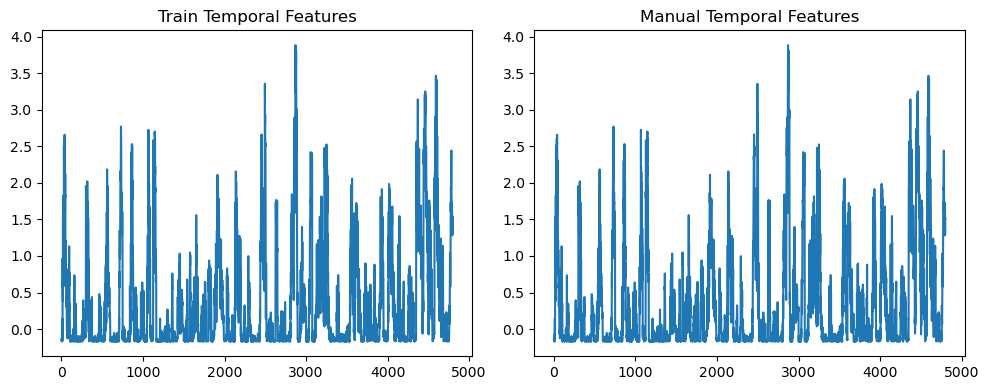

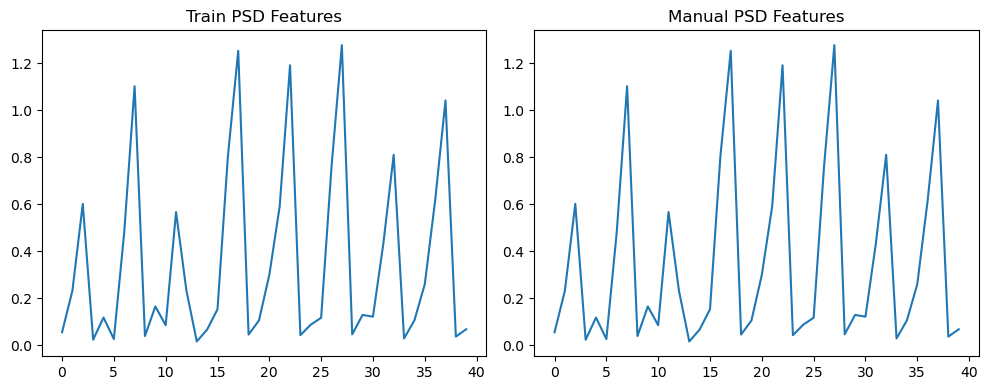


=== Prediction Comparison ===
Train prediction probs: [2.8347864e-07 2.7889894e-06 1.4610528e-07 8.9132409e-06 1.7429224e-05
 2.3706161e-05 1.6747549e-04 4.3964152e-05 6.1787308e-05 4.7517827e-01
 1.3617606e-02 2.1966273e-06 1.2562618e-06 4.1921192e-04 5.8658738e-03
 3.3464380e-02 1.5417208e-06 9.0970079e-06 4.4278763e-03 3.2477041e-03
 4.6034667e-01 1.7634270e-03 1.0426614e-04 1.1379667e-07 5.1393999e-07
 3.5712892e-05 9.4714969e-06 1.1782575e-03]
Manual prediction probs: [2.8347864e-07 2.7889894e-06 1.4610528e-07 8.9132409e-06 1.7429224e-05
 2.3706161e-05 1.6747549e-04 4.3964152e-05 6.1787308e-05 4.7517827e-01
 1.3617606e-02 2.1966273e-06 1.2562618e-06 4.1921192e-04 5.8658738e-03
 3.3464380e-02 1.5417208e-06 9.0970079e-06 4.4278763e-03 3.2477041e-03
 4.6034667e-01 1.7634270e-03 1.0426614e-04 1.1379667e-07 5.1393999e-07
 3.5712892e-05 9.4714969e-06 1.1782575e-03]

=== Feature Differences ===
Temporal features mean difference: 0.0
PSD features mean difference: 0.0

=== Attention Weigh

In [16]:
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
import os
import json
import matplotlib.pyplot as plt
from pathlib import Path

# Device setup
device = (
    torch.device("mps") if torch.backends.mps.is_available()
    else torch.device("cuda") if torch.cuda.is_available()
    else torch.device("cpu")
)

# Load label mappings
with open(f"{DATAFILES_DIR}/label_map.json", 'r') as f:
    label_dict = json.load(f)

# Move model to device
model = model.to(device)

# Reverse label dict
id_to_label_name = {v: k for k, v in label_dict.items()}
index_to_label_id = {i: lid for i, lid in enumerate(sorted(label_dict.values()))}
label_id_to_index = {lid: i for i, lid in index_to_label_id.items()}

# Load and process single CSV
csv_path = "../../frontend/handgestures/apps/main_app/static/main_app/data/tonic/standing/Josh59.csv"

# Find matching training sample
index = -1
for idx, item in enumerate(train_dataset.samples):
    if csv_path.split('/')[-1] in item['path']: 
        index = idx
        break

if index == -1:
    raise ValueError("Could not find matching training sample for verification")

print(f"\nFound matching training sample at index: {index}")

batch_size = train_loader.batch_size
dataset_idx = index // 8  # Example: Find where this index lands in the loader

j = dataset_idx // batch_size
i = dataset_idx % batch_size

# Get the j-th batch (only works if shuffle=False)
for batch_j, (x_batch, y_batch) in enumerate(train_loader):
    if batch_j == j:
        print(f"Dataset index {dataset_idx} is in:")
        print(f"- Batch {j}, position {i}")
        print(f"- Data shape: {x_batch[i].shape}")
        train_sample = x_batch[i]
        train_label = y_batch[i]
        print(f"- Label: {y_batch[i]}")
        break
else:
    print("Batch not found (shuffle=True?)")

# Verification 2: Test with actual training data
print("\n=== Training Sample Verification ===")
# train_sample, train_label = next(iter(train_loader))
train_sample = train_sample.unsqueeze(0).to(device)
train_label = train_label.to(device)

with torch.no_grad():
    model.eval()
    # Run standard forward
    output = model(train_sample)
    predicted_label = torch.argmax(output, 1).item()
    
    # Run debug forward
    debug_output = model.debug_forward(train_sample, verbose=True)
    
    print(f"\nTraining sample prediction: {predicted_label} (should be {train_label.item()})")
    print(f"Input device: {train_sample.device}, Model device: {next(model.parameters()).device}")

# Process the matching file
x1, y1 = train_dataset[index]  # training sample
x1 = x1.unsqueeze(0).to(device)  # Add batch dim and move to device (shape: [1, time_steps, channels, seq_len])

inference = ProcessSingleRawOnly(sample_data=train_dataset.samples[index], device=device)
x2, y2 = inference.process_single_csv()  # inference processing
x2 = x2.to(device)

# Verification 3: Visual comparison
print("\n=== Input Data Verification ===")
print("Train sample shape:", x1.shape)
print("Inference sample shape:", x2.shape)
print(f"Train device: {x1.device}, Inference device: {x2.device}")
diff = (x1 - x2).abs().mean()
print(f"Difference: {diff.item()}")

# Plot first channel comparison - FIXED version
plt.figure(figsize=(12, 4))

# For x1 (training sample) - shape [1, time_steps, channels, seq_len]
plt.plot(x1[0, -1, 0].cpu().numpy(), label='Training sample')  # Last time step, first channel

# For x2 - need to check shape and adjust indexing
if len(x2.shape) == 4:  # Same as x1 [batch, time_steps, channels, seq_len]
    plt.plot(x2[0, -1, 0].cpu().numpy(), label='Inference sample')
elif len(x2.shape) == 3:  # Possibly [batch, channels, seq_len]
    plt.plot(x2[0, 0].cpu().numpy(), label='Inference sample')
elif len(x2.shape) == 2:  # Possibly [channels, seq_len]
    plt.plot(x2[0].cpu().numpy(), label='Inference sample')
else:
    raise ValueError(f"Unexpected input shape for x2: {x2.shape}")

plt.title("First Channel Comparison")
plt.legend()
plt.show()

# Run debug forward on both samples
with torch.no_grad():
    model.eval()
    train_debug = model.debug_forward(x1, verbose=True)
    manual_debug = model.debug_forward(x2, verbose=True)

# Feature comparison plots
def plot_feature_comparison(train_feat, manual_feat, title):
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_feat[0].cpu().numpy().flatten(), label='Train')
    plt.title(f"Train {title}")
    plt.subplot(1, 2, 2)
    plt.plot(manual_feat[0].cpu().numpy().flatten(), label='Manual')
    plt.title(f"Manual {title}")
    plt.tight_layout()
    plt.show()

print("\n=== Feature Comparisons ===")
plot_feature_comparison(train_debug['temporal_features'], 
                      manual_debug['temporal_features'],
                      "Temporal Features")

plot_feature_comparison(train_debug['psd_features'], 
                      manual_debug['psd_features'],
                      "PSD Features")

# Compare predictions
def compare_predictions(train_output, manual_output):
    train_pred = F.softmax(train_output['logits'], dim=1)
    manual_pred = F.softmax(manual_output['logits'], dim=1)
    
    print("\n=== Prediction Comparison ===")
    print(f"Train prediction probs: {train_pred[0].cpu().numpy()}")
    print(f"Manual prediction probs: {manual_pred[0].cpu().numpy()}")
    
    print("\n=== Feature Differences ===")
    print("Temporal features mean difference:", 
          (train_output['temporal_features'].mean() - manual_output['temporal_features'].mean()).item())
    print("PSD features mean difference:", 
          (train_output['psd_features'].mean() - manual_output['psd_features'].mean()).item())
    
    print("\n=== Attention Weights ===")
    print("Train attention:", train_output['attention_weights'][0].item())
    print("Manual attention:", manual_output['attention_weights'][0].item())

compare_predictions(train_debug, manual_debug)

# Run inference
print("\n=== Running Inference ===")
result = inference.predict_from_csv(
    train_dataset.samples[index]['path'], 
    model, 
    label_dict, 
    index_to_label_id, 
    label_id_to_index, 
    id_to_label_name
)

# Print results
print("\n=== Results ===")
print(f"Predicted Label: {result['predicted_label']} (index {result['predicted_index']}, id {result['predicted_label_id']})")
print(f"True Label:     {result['true_label']} (index {result['true_index']}, id {result['true_label_id']})")

print("\nTop Predictions:")
for i, (label, prob) in enumerate(sorted(
    [(k, v) for k, v in result['probabilities'].items()], 
    key=lambda x: -x[1]
)[:5]):
    print(f"{i+1}. {label:20s}: {prob:.4f}")

print("\n=== Label Mappings ===")
print(f"All index_to_label_id keys: {list(index_to_label_id.keys())}")
print(f"All label IDs in id_to_label_name: {list(id_to_label_name.keys())}")
print(f"All label names in label_dict: {list(label_dict.keys())}")

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from pathlib import Path

# Device setup
device = (
    torch.device("mps") if torch.backends.mps.is_available()
    else torch.device("cuda") if torch.cuda.is_available()
    else torch.device("cpu")
)

# Load label mappings
with open(f"{DATAFILES_DIR}/label_map.json", 'r') as f:
    label_dict = json.load(f)

# Move model to device
model = model.to(device)

# Verification 1: Check model weights
print("\n=== Model Verification ===")
print("Model first conv weight mean:", model.feature_extractor['large'][0].weight.mean().item())
print(f"Model device: {next(model.parameters()).device}")

# Reverse label dict
id_to_label_name = {v: k for k, v in label_dict.items()}
index_to_label_id = {i: lid for i, lid in enumerate(sorted(label_dict.values()))}
label_id_to_index = {lid: i for i, lid in index_to_label_id.items()}

# Load and process single CSV
csv_path = "../../frontend/handgestures/apps/main_app/static/main_app/data/tonic/standing/Josh59.csv"

# Find matching training sample
index = -1
for idx, item in enumerate(train_dataset.samples):
    if csv_path.split('/')[-1] in item['path']: 
        index = idx
        break

if index == -1:
    raise ValueError("Could not find matching training sample for verification")

print(f"\nFound matching training sample at index: {index}")

# Verification 2: Test with actual training data
print("\n=== Training Sample Verification ===")
train_sample, train_label = next(iter(train_loader))
train_sample = train_sample.to(device)  # Move to same device as model
train_label = train_label.to(device)

with torch.no_grad():
    model.eval()
    output = model(train_sample[:1])  # Test on first training sample
    predicted_label = torch.argmax(output, 1).item()
    print(f"Training sample prediction: {predicted_label} (should be {train_label[0].item()})")
    print(f"Input device: {train_sample.device}, Model device: {next(model.parameters()).device}")

# Process the matching file
x1, y1 = train_dataset[index]  # training sample
x1 = x1.to(device)  # Move to device

inference = ProcessSingleRawOnly(sample_data=train_dataset.samples[index] ,device=device)  # Pass device to ensure consistency
x2, _ = inference.process_single_csv()  # inference processing (already on device)
x2 = x2.to(device)

# Verification 3: Visual comparison
print("\n=== Input Data Verification ===")
print("Train sample shape:", x1.shape)
print("Inference sample shape:", x2.shape)
print(f"Train device: {x1.device}, Inference device: {x2.device}")
diff = (x1 - x2.squeeze(0)).abs().mean()
print(f"Difference: {diff.item()}")

# # Plot first channel comparison
# plt.figure(figsize=(12, 4))
# plt.plot(x1[0].cpu().numpy(), label='Training sample')
# plt.plot(x2.squeeze(0)[0].cpu().numpy(), label='Inference sample')
# plt.title("First Channel Comparison")
# plt.legend()
# plt.show()

# Run inference
print("\n=== Running Inference ===")
result = inference.predict_from_csv(
    train_dataset.samples[index]['path'], 
    model, 
    label_dict, 
    index_to_label_id, 
    label_id_to_index, 
    id_to_label_name
)

# Print results
print("\n=== Results ===")
print(f"Predicted Label: {result['predicted_label']} (index {result['predicted_index']}, id {result['predicted_label_id']})")
print(f"True Label:     {result['true_label']} (index {result['true_index']}, id {result['true_label_id']})")

print("\nTop Predictions:")
for i, (label, prob) in enumerate(sorted(
    [(k, v) for k, v in result['probabilities'].items()], 
    key=lambda x: -x[1]
)[:5]):
    print(f"{i+1}. {label:20s}: {prob:.4f}")

print("\n=== Label Mappings ===")
print(f"All index_to_label_id keys: {list(index_to_label_id.keys())}")
print(f"All label IDs in id_to_label_name: {list(id_to_label_name.keys())}")
print(f"All label names in label_dict: {list(label_dict.keys())}")

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
import os

# # Load the saved dictionary
# data = torch.load(f"{DATAFILES_DIR}/raw_psd_handgestures_dataset.pt", map_location="cpu", weights_only=False)
# label_dict = data["label_dict"]
with open(f"{DATAFILES_DIR}/label_map.json", 'r') as f:
    label_dict = json.load(f)

# Device setup
device = (
    torch.device("mps") if torch.backends.mps.is_available()
    else torch.device("cuda") if torch.cuda.is_available()
    else torch.device("cpu")
)

# Check if model is loading weights correctly
print("Model first conv weight mean:", model.feature_extractor['large'][0].weight.mean())

# Reverse label dict
id_to_label_name = {v: k for k, v in label_dict.items()}
index_to_label_id = {i: lid for i, lid in enumerate(sorted(label_dict.values()))}
label_id_to_index = {lid: i for i, lid in index_to_label_id.items()}

print("label_dict:", label_dict)
print("index_to_label_id:", index_to_label_id)
print("id_to_label_name:", id_to_label_name)


# Load and process single CSV
csv_path = "../../frontend/handgestures/apps/main_app/static/main_app/data/tonic/standing/Josh59.csv"
# raw_tensor, psd_tensor = process_single_csv_raw_psd(csv_path)  # raw: (1, 8, 8, 600), psd: (1, 5)
inference = ProcessSingleRawOnly()
# result = inference.predict_from_csv(
#     csv_path, model, label_dict, index_to_label_id, label_id_to_index, id_to_label_name
# )

# print(result)

# Find the match in the training data for the inference file
index = -1;
for idx, item in enumerate(train_dataset.samples):
    if csv_path.split('/')[-1] in item['path']: index = idx

print(f'This is the index of the sample in the training data: {index}')
print(train_dataset[index])
print(train_dataset.samples[index])

# Pick same training file
x1, _ = train_dataset[index]  # training
x2 = inference.process_single_csv(train_dataset.samples[index]['path'])  # inference

result = inference.predict_from_csv(
    train_dataset.samples[index]['path'], model, label_dict, index_to_label_id, label_id_to_index, id_to_label_name
)

print("Train sample shape:", x1.shape)
print("Inference sample shape:", x2.shape)
print("Difference:", (x1.to(device) - x2.squeeze(0).to(device)).abs().mean())

# # Send to device
# raw_tensor = raw_tensor.to(device).float()  # (1, 8, 8, 600)
# psd_tensor = psd_tensor.to(device).float()  # (1, 5)

# # Infer true label from path
# label_folder = os.path.basename(os.path.dirname(csv_path)).lower()
# label_name = label_folder.split("_")[0]
# true_label_id = label_dict.get(label_name, None)
# true_idx = label_id_to_index.get(true_label_id, -1)
# true_label_name = label_name if true_label_id is not None else "UNKNOWN"

# # Run inference
# model.to(device)
# model.eval()
# with torch.no_grad():
#     outputs = model(raw_tensor, psd_tensor)  # Adjust if your model takes inputs as a tuple/list
#     probs = F.softmax(outputs, dim=1)
#     pred = torch.argmax(probs, dim=1)

# # Decode prediction
# pred_idx = pred.item()
# pred_label_id = index_to_label_id.get(pred_idx, None)
# pred_label_name = id_to_label_name.get(pred_label_id, "UNKNOWN")

print("Single Sample Inference Result:")
print(f"Predicted Label: {result['predicted_label']} (index {result['predicted_index']}, id {result['predicted_label_id']})")
print(f"True Label:     {result['true_label']} (index {result['true_index']}, id {result['true_label_id']})")

print("\nPer-Class Probabilities:")
for label_name, prob in result['probabilities'].items():
    label_name = f"ID_{label_name}"
    print(f"{label_name:15s}: {prob:.4f}")

print(f"All index_to_label_id keys: {list(index_to_label_id.keys())}")
print(f"All label IDs in id_to_label_name: {list(id_to_label_name.keys())}")
print(f"All label names in label_dict: {list(label_dict.keys())}")

# # Original access still works
# print(result["predicted_label"])
# print(result["probabilities"])

# New diagnostics available
# print("Input stats:", result["input_verification"])

# for idx in range(num_classes):
#     lid = index_to_label_id.get(idx)
#     lname = id_to_label_name.get(lid, "UNKNOWN")
#     print(f"Index {idx} -> Label ID {lid} -> Label Name {lname}")


In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import random
import pandas as pd
import os

# Load the saved dictionary
data = torch.load(f"{DATAFILES_DIR}/cwt_handgestures_6channels_dataset.pt", map_location="cpu", weights_only=False)
label_dict = data["label_dict"]

# Device setup
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

# Reverse label dict
id_to_label_name = {v: k for k, v in label_dict.items()}
index_to_label_id = {i: lid for i, lid in enumerate(sorted(label_dict.values()))}
label_id_to_index = {lid: i for i, lid in index_to_label_id.items()}

# Load and process single CSV
csv_path = "../../frontend/handgestures/apps/main_app/static/main_app/data/Josh59.csv"
cwt_tensor = process_single_csv_cwt(csv_path)  # shape: (1, 127, 127, 6)

# Prepare input tensor
x_single = torch.from_numpy(cwt_tensor).permute(0, 3, 1, 2).float().to(device)  # (1, 6, 127, 127)
x_single = x_single.unsqueeze(1)  # reshape to (1, 1, 6, 127, 127)

# Infer true label from path
label_folder = os.path.basename(os.path.dirname(csv_path)).lower()
label_name = label_folder.split("_")[0]  # Strip variants like '_variant'
true_label_id = label_dict.get(label_name, None)
true_idx = label_id_to_index.get(true_label_id, -1)
true_label_name = label_name if true_label_id is not None else "UNKNOWN"

# Run inference
model.to(device)
model.eval()
with torch.no_grad():
    outputs = model(x_single)
    probs = F.softmax(outputs, dim=1)
    pred = torch.argmax(probs, dim=1)

# Decode prediction
pred_idx = pred.item()
pred_label_id = index_to_label_id.get(pred_idx, None)
pred_label_name = id_to_label_name.get(pred_label_id, "UNKNOWN")

print("Single Sample Inference Result:")
print(f"Predicted Label: {pred_label_name} (index {pred_idx}, id {pred_label_id})")
print(f"True Label:     {true_label_name} (index {true_idx}, id {true_label_id})")

print("\nPer-Class Probabilities:")
for i, p in enumerate(probs[0].cpu().numpy()):
    label_id = index_to_label_id[i]
    label_name = id_to_label_name.get(label_id, f"ID_{label_id}")
    print(f"{label_name:15s}: {p:.4f}")


In [ ]:
import torch.nn.functional as F

# Create reverse dict for id -> name
id_to_label_name = {v: k for k, v in label_dict.items()}

# Device setup
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

# Load dataset
cwt_data = torch.load(f"{DATAFILES_DIR}/cwt_handgestures_6channels_dataset.pt", map_location="cpu", weights_only=False)
x_test = cwt_data["x_test"]
y_test = cwt_data["y_test"]

unique_label_ids = sorted(set(y_test))
index_to_label_id = {idx: label_id for idx, label_id in enumerate(unique_label_ids)}
label_id_to_index = {label_id: idx for idx, label_id in enumerate(unique_label_ids)}
y_test_idx = np.array([label_id_to_index[y] for y in y_test])

perm = np.random.permutation(len(y_test_idx))
x_test = x_test[perm]
y_test_idx = y_test_idx[perm]

x_test_tensor = x_test.permute(0, 3, 1, 2).float()

time_steps = 8
def pad_to_multiple(tensor, multiple, dim=0, pad_value=0):
    length = tensor.size(dim)
    remainder = length % multiple
    if remainder == 0:
        return tensor
    pad_len = multiple - remainder
    pad_shape = list(tensor.shape)
    pad_shape[dim] = pad_len
    pad_tensor = torch.full(pad_shape, pad_value, dtype=tensor.dtype)
    return torch.cat([tensor, pad_tensor], dim=dim)

x_test_tensor = pad_to_multiple(x_test_tensor, time_steps, dim=0)
y_test_idx = np.pad(y_test_idx, (0, x_test_tensor.size(0) - len(y_test_idx)), constant_values=-100)
y_test_tensor = torch.tensor(y_test_idx, dtype=torch.long)

num_batches = x_test_tensor.size(0) // time_steps
x_test_seq = x_test_tensor.view(num_batches, time_steps, 6, 127, 127)
y_test_seq = y_test_tensor.view(num_batches, time_steps)[:, -1]

model.to(device)
model.eval()

sample_idx = random.randint(0, x_test_seq.size(0) - 1)
x_single = x_test_seq[sample_idx:sample_idx+1].to(device)
y_single = y_test_seq[sample_idx:sample_idx+1]

with torch.no_grad():
    outputs = model(x_single)  # logits
    probs = F.softmax(outputs, dim=1)  # probabilities over classes
    pred = torch.argmax(probs, dim=1)

pred_idx = pred.item()
true_idx = y_single.item()
pred_label_id = index_to_label_id.get(pred_idx, None)
true_label_id = index_to_label_id.get(true_idx, None)
pred_label_name = id_to_label_name.get(pred_label_id, "UNKNOWN")
true_label_name = id_to_label_name.get(true_label_id, "UNKNOWN")

print("Single Sample Inference Result:")
print(f"Predicted Label: {pred_label_name} (index {pred_idx}, id {pred_label_id})")
print(f"True Label: {true_label_name} (index {true_idx}, id {true_label_id})")

print("\nPer-Class Probabilities:")
for i, p in enumerate(probs[0].cpu().numpy()):
    label_id = index_to_label_id[i]
    label_name = id_to_label_name.get(label_id, f"ID_{label_id}")
    print(f"{label_name:15s}: {p:.4f}")


## Preprocess HandGesture Dataset

This will run the preprocessing on the individual CSV files that were collected from the
sensor hardware device

In [ ]:
label_map_collapse_4_classifiers = {
    # Tremor (exclude running/falling)
    'tremor_walking': 'tremor',
    'tremor_standing': 'tremor',
    'tremor_sitting': 'tremor',
    'tremor_laying': 'tremor',
    'tremor_stairs': 'tremor',
    'tremor_running': 'tremor',
    'tremor_falling': 'tremor',
    # Postural
    'postural_walking': 'postural',
    'postural_standing': 'postural',
    'postural_sitting': 'postural',
    'postural_laying': 'postural',
    'postural_stairs': 'postural',
    'postural_running': 'postural',
    'postural_falling': 'postural',
    # Normal
    'normal_walking': 'normal',
    'normal_standing': 'normal',
    'normal_sitting': 'normal',
    'normal_laying': 'normal',
    'normal_stairs': 'normal',
    'normal_running': 'normal',
    'normal_falling': 'normal',
    # Tonic
    'tonic_walking': 'tonic',
    'tonic_standing': 'tonic',
    'tonic_sitting': 'tonic',
    'tonic_laying': 'tonic',
    'tonic_stairs': 'tonic',
    'tonic_running': 'tonic',
    'tonic_falling': 'tonic',
}

## Load the data from preprocessing

This will allow us to reload the data if we have already completed the preprocessing step.

In [ ]:
# Load the saved dictionary
data = torch.load(f"{DATAFILES_DIR}/cwt_handgestures_6channels_dataset.pt", map_location="cpu", weights_only=False)  # or 'device' if using GPU/MPS

# Unpack the contents into variables
x_train = data["x_train"]
y_train = data["y_train"]
x_test = data["x_test"]
y_test = data["y_test"]
label_dict = data["label_dict"]

In [ ]:
# Load the dataset
data = torch.load(f"{DATAFILES_DIR}/psd_handgestures_6channels_dataset.pt", weights_only=False)

# Extract variables
psd_train = data["psd_train"]
train_labels = data["train_labels"]
psd_test = data["psd_test"]
test_labels = data["test_labels"]
label_dict = data["label_dict"]

## Visualize preprocessed data

This will let us make sure that we have loaded the data properly, by looking at the data in the file and visualizing it.

In [ ]:
# Choose a random sample index
sample_index = random.randint(0, x_train.shape[0] - 1)

# Plot the CWT images for all channels in that sample
plt.figure(figsize=(12, 6))
for ch in range(x_train.shape[3]):  # Automatically use available channels
    plt.subplot(2, 4, ch + 1)
    plt.imshow(x_train[sample_index, :, :, ch], cmap='viridis')
    plt.title(f'Channel {ch}')
    plt.axis('off')
plt.suptitle(f'CWT for Sample {sample_index}')
plt.tight_layout()
plt.show()

# Machine Learning

This will use Pytorch to do training on the dataset pre-processed into sonographs. This is memory-optimized to ensure that MPS does
not have problems with memory leaking, and ensure that we can maintain a large enough batch size.

If MPS is possible, then that device feature will be used. This will offload much of the training to the graphics cores, but some of
The main processor will still be used for training, especially in the beginning. This is a memory-intensive task, and expect the memory pressure at first to be near 50GB, but it does reduce down to approximately 20GB after dataloading. This will be intensive on any machine that does not have 32GB of memory.

This training will run for ten epochs, to ensure that we can reach a high enough accuracy with the test dataset (validation data)

In [ ]:
# Model definition
class CNNLSTM(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(CNNLSTM, self).__init__()
        input_shape = (127, 127, 6)
        self.cnn = nn.Sequential(
            nn.Conv2d(input_channels, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 63x63

            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 31x31

            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 15x15
        )
        # Infer CNN output size dynamically
        dummy_input = torch.zeros(1, input_channels, input_shape[0], input_shape[1])
        cnn_output_dim = self.cnn(dummy_input).view(1, -1).size(1)

        self.lstm = nn.LSTM(input_size=cnn_output_dim, hidden_size=128,
                            batch_first=True, bidirectional=True)
        self.classifier = nn.Sequential(
            nn.Linear(128 * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        # x shape: (B, T, C, H, W)
        B, T, C, H, W = x.shape
        x = x.view(B * T, C, H, W)  # combine batch and time for CNN
        x = self.cnn(x)
        x = x.view(B, T, -1)  # separate batch and time
        out, _ = self.lstm(x)
        # Use output of last timestep
        return self.classifier(out[:, -1, :])

In [ ]:
# New version of ML Model with CNN based on CWT Sonograms, and LSTM for temporal analysis

# Memory Configuration (must come first)
os.environ['PYTORCH_MPS_HIGH_WATERMARK_RATIO'] = '0.0'
os.environ['PYTORCH_MPS_MAX_CACHE_SIZE'] = '0'

# Memory monitoring function
def print_memory_stats(prefix=""):
    if torch.backends.mps.is_available():
        allocated = torch.mps.current_allocated_memory() / 1e9
        reserved = torch.mps.driver_allocated_memory() / 1e9
        print(f"{prefix} Memory: Alloc={allocated:.2f}GB, Reserved={reserved:.2f}GB")

# Device and seed setup
torch.manual_seed(42)
np.random.seed(42)
# Device setup (check hardware in platform)
if torch.backends.mps.is_available(): device = torch.device("mps")
elif torch.cuda.is_available(): device = torch.device("cuda")
else: device = torch.device("cpu")
    
# Better randomization and memory allocation
if torch.backends.mps.is_available():
    torch.mps.manual_seed(42)
    torch.mps.set_per_process_memory_fraction(1.0)
elif torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.set_per_process_memory_fraction(1.0)

print(f"Using device: {device}")
print_memory_stats("Initial")

# Parameters
input_shape = (127, 127, 6)
batch_size = 16
num_classes = len(label_dict)
epochs = 10
accumulation_steps = 2
time_steps = 8  # number of temporal slices per sample

# Assume x_train, x_test, y_train, y_test are defined elsewhere
# For example, x_train shape: (N, 127, 127, 6)
# y_train shape: (N,)
# Make sure data is torch tensor or numpy array accordingly

# Mapping labels to indices
y_all = np.concatenate([y_train, y_test])
index_to_label = {label: idx for idx, label in enumerate(sorted(set(y_all)))}
y_train_indices = np.array([index_to_label[label.item()] if hasattr(label, 'item') else index_to_label[label] for label in y_train])
y_test_indices = np.array([index_to_label[label.item()] if hasattr(label, 'item') else index_to_label[label] for label in y_test])

def normalize(tensor):
    mean = tensor.mean(dim=(2, 3), keepdim=True)
    std = tensor.std(dim=(2, 3), keepdim=True) + 1e-6
    return (tensor - mean) / std

# x_train_tensor = normalize(torch.tensor(x_train).float().permute(0, 3, 1, 2))  # (N, C, H, W)
# x_test_tensor = normalize(torch.tensor(x_test).float().permute(0, 3, 1, 2))
x_train_tensor = normalize(x_train.detach().clone().float().permute(0, 3, 1, 2))
x_test_tensor = normalize(x_test.detach().clone().float().permute(0, 3, 1, 2))
y_train_tensor = torch.tensor(y_train_indices, dtype=torch.long)
y_test_tensor = torch.tensor(y_test_indices, dtype=torch.long)

def pad_to_multiple(tensor, multiple, dim=0, pad_value=0):
    """
    Pads tensor along dimension `dim` to a size that is a multiple of `multiple`.
    """
    size = tensor.size(dim)
    remainder = size % multiple
    if remainder == 0:
        return tensor  # no padding needed
    padding_size = multiple - remainder
    pad_shape = list(tensor.shape)
    pad_shape[dim] = padding_size
    pad_tensor = torch.full(pad_shape, pad_value, dtype=tensor.dtype, device=tensor.device)
    return torch.cat([tensor, pad_tensor], dim=dim)

# Pad datasets so total samples are divisible by time_steps
x_train_tensor = pad_to_multiple(x_train_tensor, time_steps, dim=0, pad_value=0)
x_test_tensor = pad_to_multiple(x_test_tensor, time_steps, dim=0, pad_value=0)
y_train_tensor = pad_to_multiple(y_train_tensor, time_steps, dim=0, pad_value=-100)  # Use ignore_index -100 for padding labels
y_test_tensor = pad_to_multiple(y_test_tensor, time_steps, dim=0, pad_value=-100)

# Reshape to (batch, time_steps, channels, H, W)
num_train_batches = x_train_tensor.size(0) // time_steps
num_test_batches = x_test_tensor.size(0) // time_steps

x_train_seq = x_train_tensor.view(num_train_batches, time_steps, *input_shape[::-1])  # input_shape[::-1] flips (H,W,C) -> (C,H,W)
y_train_seq = y_train_tensor.view(num_train_batches, time_steps)

x_test_seq = x_test_tensor.view(num_test_batches, time_steps, *input_shape[::-1])
y_test_seq = y_test_tensor.view(num_test_batches, time_steps)

# We only use the label of the last timestep for training/classification
y_train_seq_last = y_train_seq[:, -1]
y_test_seq_last = y_test_seq[:, -1]

model = CNNLSTM(input_channels=6, num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=-100)  # ignore padded labels in loss
optimizer = Adam(model.parameters(), lr=0.001)

train_loader = DataLoader(TensorDataset(x_train_seq, y_train_seq_last), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(x_test_seq, y_test_seq_last), batch_size=batch_size)

history = defaultdict(list)
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    train_loss, correct, total = 0.0, 0, 0
    epoch_start = time()

    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels) / accumulation_steps
        loss.backward()

        if (batch_idx + 1) % accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad(set_to_none=True)

        train_loss += loss.item() * accumulation_steps
        _, predicted = torch.max(outputs.data, 1)
        mask = labels != -100  # only count non-padded labels
        correct += (predicted[mask] == labels[mask]).sum().item()
        total += mask.sum().item()

        if batch_idx % 10 == 0:
            if torch.backends.mps.is_available(): torch.mps.empty_cache()
            if torch.cuda.is_available(): torch.cuda.empty_cache()
            gc.collect()

    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(test_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            val_loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            mask = labels != -100
            val_correct += (predicted[mask] == labels[mask]).sum().item()
            val_total += mask.sum().item()
            if batch_idx % 10 == 0:
                if torch.backends.mps.is_available(): torch.mps.empty_cache()
                elif torch.cuda.is_available(): torch.cuda.empty_cache()
                gc.collect()

    history['train_loss'].append(train_loss / len(train_loader))
    history['train_acc'].append(correct / total if total > 0 else 0)
    history['val_loss'].append(val_loss / len(test_loader))
    history['val_acc'].append(val_correct / val_total if val_total > 0 else 0)

    print(f"Epoch {epoch + 1}/{epochs} - {time() - epoch_start:.1f}s")
    print(f"Train Loss: {history['train_loss'][-1]:.4f} Acc: {history['train_acc'][-1]:.4f}")
    print(f"Val Loss: {history['val_loss'][-1]:.4f} Acc: {history['val_acc'][-1]:.4f}")
    print_memory_stats("Epoch End")
    print()
    
    if torch.backends.mps.is_available(): torch.mps.empty_cache()
    elif torch.cuda.is_available(): torch.cuda.empty_cache()
    gc.collect()
    print()

def safe_evaluate(model, inputs, labels, chunk_size=8):
    model.eval()
    total_loss, correct = 0.0, 0
    with torch.no_grad():
        for i in range(0, inputs.size(0), chunk_size):
            chunk_inputs = inputs[i:i + chunk_size].to(device)
            chunk_labels = labels[i:i + chunk_size].to(device)

            outputs = model(chunk_inputs)
            total_loss += criterion(outputs, chunk_labels).item() * chunk_inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            mask = chunk_labels != -100
            correct += (predicted[mask] == chunk_labels[mask]).sum().item()
            # SAFE cleanup
            del chunk_inputs, chunk_labels, outputs, predicted, mask
            if i % 10 == 0:
                if torch.backends.mps.is_available(): torch.mps.empty_cache()
                elif torch.cuda.is_available(): torch.cuda.empty_cache()
                gc.collect()

    return total_loss / inputs.size(0), correct / inputs.size(0)

train_loss, train_acc = safe_evaluate(model, x_train_seq, y_train_seq_last)
test_loss, test_acc = safe_evaluate(model, x_test_seq, y_test_seq_last)

print('Final Results:')
print(f'Train loss: {train_loss:.4f}, accuracy: {train_acc:.4f}')
print(f'Test loss: {test_loss:.4f}, accuracy: {test_acc:.4f}')
print_memory_stats("Final")

## Save Model

Save the trained model for later use

In [ ]:
# Save the model
torch.save(model.state_dict(), f"{MODELFILES_DIR}/handgestures_trained_6-channel_CNN-LSTM_model_weights_99percent.pt")

# Save the history (loss and accuracy)
df_history = pd.DataFrame(history)
df_history.to_csv(f"{MODELFILES_DIR}/handgestures_6-channel_CNN-LSTM_training_history_99percent.csv", index=False)

## Inspect Size and Shape

We will inspect the size and shape of the data and tensors, so that we can determine what kind of samples we have to train

In [ ]:
print("x_train shape:", x_train.shape)
print("x_train_tensor shape:", x_train_tensor.shape)
print("x_train_tensor stats: mean =", x_train_tensor.mean().item(), "std =", x_train_tensor.std().item())
print("Sample input min/max:", x_train_tensor[0].min().item(), x_train_tensor[0].max().item())

# Validations
---

This will validate that the trained data can properly validate the test data set after training

In [ ]:
# Device setup (check hardware in platform)
if torch.backends.mps.is_available(): device = torch.device("mps")
elif torch.cuda.is_available(): device = torch.device("cuda")
else: device = torch.device("cpu")

model = CNNLSTM(input_channels=6, num_classes=len(label_dict)).to(device)

# 3. Load the saved weights
model.load_state_dict(
    torch.load(f"{MODELFILES_DIR}/handgestures_trained_6-channel_CNN-LSTM_model_weights_99percent.pt",
               map_location=device,
               weights_only=False))

# model.eval()  # Set to evaluation mode

## Random Prediction

Pick a random sample from the HandGestures wavelets and do a prediction

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import random
import pandas as pd
import os

# Load the saved dictionary
data = torch.load(f"{DATAFILES_DIR}/cwt_handgestures_6channels_dataset.pt", map_location="cpu", weights_only=False)
label_dict = data["label_dict"]

# Device setup
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

# Reverse label dict
id_to_label_name = {v: k for k, v in label_dict.items()}
index_to_label_id = {i: lid for i, lid in enumerate(sorted(label_dict.values()))}
label_id_to_index = {lid: i for i, lid in index_to_label_id.items()}

# Load and process single CSV
csv_path = "../../frontend/handgestures/apps/main_app/static/main_app/data/Josh59.csv"
cwt_tensor = process_single_csv_cwt(csv_path)  # shape: (1, 127, 127, 6)

# Prepare input tensor
x_single = torch.from_numpy(cwt_tensor).permute(0, 3, 1, 2).float().to(device)  # (1, 6, 127, 127)
x_single = x_single.unsqueeze(1)  # reshape to (1, 1, 6, 127, 127)

# Infer true label from path
label_folder = os.path.basename(os.path.dirname(csv_path)).lower()
label_name = label_folder.split("_")[0]  # Strip variants like '_variant'
true_label_id = label_dict.get(label_name, None)
true_idx = label_id_to_index.get(true_label_id, -1)
true_label_name = label_name if true_label_id is not None else "UNKNOWN"

# Run inference
model.to(device)
model.eval()
with torch.no_grad():
    outputs = model(x_single)
    probs = F.softmax(outputs, dim=1)
    pred = torch.argmax(probs, dim=1)

# Decode prediction
pred_idx = pred.item()
pred_label_id = index_to_label_id.get(pred_idx, None)
pred_label_name = id_to_label_name.get(pred_label_id, "UNKNOWN")

print("Single Sample Inference Result:")
print(f"Predicted Label: {pred_label_name} (index {pred_idx}, id {pred_label_id})")
print(f"True Label:     {true_label_name} (index {true_idx}, id {true_label_id})")

print("\nPer-Class Probabilities:")
for i, p in enumerate(probs[0].cpu().numpy()):
    label_id = index_to_label_id[i]
    label_name = id_to_label_name.get(label_id, f"ID_{label_id}")
    print(f"{label_name:15s}: {p:.4f}")


In [ ]:
import torch.nn.functional as F

# Create reverse dict for id -> name
id_to_label_name = {v: k for k, v in label_dict.items()}

# Device setup
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

# Load dataset
cwt_data = torch.load(f"{DATAFILES_DIR}/cwt_handgestures_6channels_dataset.pt", map_location="cpu", weights_only=False)
x_test = cwt_data["x_test"]
y_test = cwt_data["y_test"]

unique_label_ids = sorted(set(y_test))
index_to_label_id = {idx: label_id for idx, label_id in enumerate(unique_label_ids)}
label_id_to_index = {label_id: idx for idx, label_id in enumerate(unique_label_ids)}
y_test_idx = np.array([label_id_to_index[y] for y in y_test])

perm = np.random.permutation(len(y_test_idx))
x_test = x_test[perm]
y_test_idx = y_test_idx[perm]

x_test_tensor = x_test.permute(0, 3, 1, 2).float()

time_steps = 8
def pad_to_multiple(tensor, multiple, dim=0, pad_value=0):
    length = tensor.size(dim)
    remainder = length % multiple
    if remainder == 0:
        return tensor
    pad_len = multiple - remainder
    pad_shape = list(tensor.shape)
    pad_shape[dim] = pad_len
    pad_tensor = torch.full(pad_shape, pad_value, dtype=tensor.dtype)
    return torch.cat([tensor, pad_tensor], dim=dim)

x_test_tensor = pad_to_multiple(x_test_tensor, time_steps, dim=0)
y_test_idx = np.pad(y_test_idx, (0, x_test_tensor.size(0) - len(y_test_idx)), constant_values=-100)
y_test_tensor = torch.tensor(y_test_idx, dtype=torch.long)

num_batches = x_test_tensor.size(0) // time_steps
x_test_seq = x_test_tensor.view(num_batches, time_steps, 6, 127, 127)
y_test_seq = y_test_tensor.view(num_batches, time_steps)[:, -1]

model.to(device)
model.eval()

sample_idx = random.randint(0, x_test_seq.size(0) - 1)
x_single = x_test_seq[sample_idx:sample_idx+1].to(device)
y_single = y_test_seq[sample_idx:sample_idx+1]

with torch.no_grad():
    outputs = model(x_single)  # logits
    probs = F.softmax(outputs, dim=1)  # probabilities over classes
    pred = torch.argmax(probs, dim=1)

pred_idx = pred.item()
true_idx = y_single.item()
pred_label_id = index_to_label_id.get(pred_idx, None)
true_label_id = index_to_label_id.get(true_idx, None)
pred_label_name = id_to_label_name.get(pred_label_id, "UNKNOWN")
true_label_name = id_to_label_name.get(true_label_id, "UNKNOWN")

print("Single Sample Inference Result:")
print(f"Predicted Label: {pred_label_name} (index {pred_idx}, id {pred_label_id})")
print(f"True Label: {true_label_name} (index {true_idx}, id {true_label_id})")

print("\nPer-Class Probabilities:")
for i, p in enumerate(probs[0].cpu().numpy()):
    label_id = index_to_label_id[i]
    label_name = id_to_label_name.get(label_id, f"ID_{label_id}")
    print(f"{label_name:15s}: {p:.4f}")


In [ ]:
# Create reverse dict for id -> name
id_to_label_name = {v: k for k, v in label_dict.items()}

# Device setup (check hardware in platform)
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

# Load custom dataset (example)
cwt_data = torch.load(f"{DATAFILES_DIR}/cwt_handgestures_6channels_dataset.pt", map_location="cpu", weights_only=False)
x_test = cwt_data["x_test"]  # shape: (N, 127, 127, 6)
y_test = cwt_data["y_test"]  # shape: (N,)

# Unique sorted label IDs present in y_test (assumes these match model class ordering)
unique_label_ids = sorted(set(y_test))

# Map model class index -> label ID
index_to_label_id = {idx: label_id for idx, label_id in enumerate(unique_label_ids)}

# Convert y_test numeric labels to indices according to unique_label_ids for shuffling & batching
label_id_to_index = {label_id: idx for idx, label_id in enumerate(unique_label_ids)}
y_test_idx = np.array([label_id_to_index[y] for y in y_test])

# Shuffle dataset
perm = np.random.permutation(len(y_test_idx))
x_test = x_test[perm]
y_test_idx = y_test_idx[perm]

# Convert to torch tensor with channels first
x_test_tensor = x_test.permute(0, 3, 1, 2).float()

# Pad samples so total length is multiple of time_steps
time_steps = 8
def pad_to_multiple(tensor, multiple, dim=0, pad_value=0):
    length = tensor.size(dim)
    remainder = length % multiple
    if remainder == 0:
        return tensor
    pad_len = multiple - remainder
    pad_shape = list(tensor.shape)
    pad_shape[dim] = pad_len
    pad_tensor = torch.full(pad_shape, pad_value, dtype=tensor.dtype)
    return torch.cat([tensor, pad_tensor], dim=dim)

x_test_tensor = pad_to_multiple(x_test_tensor, time_steps, dim=0)
y_test_idx = np.pad(y_test_idx, (0, x_test_tensor.size(0) - len(y_test_idx)), constant_values=-100)

y_test_tensor = torch.tensor(y_test_idx, dtype=torch.long)

# Reshape into sequences (B, T, C, H, W)
num_batches = x_test_tensor.size(0) // time_steps
x_test_seq = x_test_tensor.view(num_batches, time_steps, 6, 127, 127)
y_test_seq = y_test_tensor.view(num_batches, time_steps)[:, -1]  # last timestep label

model.to(device)
model.eval()

# Select a single random sample index
sample_idx = random.randint(0, x_test_seq.size(0) - 1)

# Extract the single sample and label, add batch dimension (B=1)
x_single = x_test_seq[sample_idx:sample_idx+1].to(device)  # shape (1, T, C, H, W)
y_single = y_test_seq[sample_idx:sample_idx+1]            # shape (1,)

with torch.no_grad():
    outputs = model(x_single)  # shape (1, num_classes)
    pred = torch.argmax(outputs, dim=1)

pred_idx = pred.item()
true_idx = y_single.item()

# Map indices back to original label IDs
pred_label_id = index_to_label_id.get(pred_idx, None)
true_label_id = index_to_label_id.get(true_idx, None)

# Map label IDs to string names, fallback to UNKNOWN if not found
pred_label_name = id_to_label_name.get(pred_label_id, "UNKNOWN")
true_label_name = id_to_label_name.get(true_label_id, "UNKNOWN")

print("Single Sample Inference Result:")
print(f"Predicted Label: {pred_label_name} (index {pred_idx}, id {pred_label_id})")
print(f"True Label: {true_label_name} (index {true_idx}, id {true_label_id})")

## Prediction Accuracy

Do an evaluation over the entire dataset and make sure the validation accuracy matched the training

In [ ]:
# Device setup (check hardware in platform)
if torch.backends.mps.is_available(): device = torch.device("mps")
elif torch.cuda.is_available(): device = torch.device("cuda")
else: device = torch.device("cpu")

# Load custom dataset (example)
cwt_data = torch.load(f"{DATAFILES_DIR}/cwt_handgestures_6channels_dataset.pt", map_location="cpu", weights_only=False)
x_test = cwt_data["x_test"]  # shape: (N, 127, 127, 6)
y_test = cwt_data["y_test"]  # shape: (N,)

# Assume label_to_index from training or create mapping if needed
label_to_index = {label: idx for idx, label in enumerate(sorted(set(y_test)))}
y_test_idx = np.array([label_to_index[y] for y in y_test])

# Shuffle dataset (optional)
perm = np.random.permutation(len(y_test_idx))
x_test = x_test[perm]
y_test_idx = y_test_idx[perm]

# Convert to torch tensor with channels first
x_test_tensor = x_test.permute(0, 3, 1, 2).float()

# Pad samples so total length is multiple of time_steps
time_steps = 8
def pad_to_multiple(tensor, multiple, dim=0, pad_value=0):
    length = tensor.size(dim)
    remainder = length % multiple
    if remainder == 0:
        return tensor
    pad_len = multiple - remainder
    pad_shape = list(tensor.shape)
    pad_shape[dim] = pad_len
    pad_tensor = torch.full(pad_shape, pad_value, dtype=tensor.dtype)
    return torch.cat([tensor, pad_tensor], dim=dim)

x_test_tensor = pad_to_multiple(x_test_tensor, time_steps, dim=0)
y_test_idx = np.pad(y_test_idx, (0, x_test_tensor.size(0) - len(y_test_idx)), constant_values=-100)

y_test_tensor = torch.tensor(y_test_idx, dtype=torch.long)

# Reshape into sequences (B, T, C, H, W)
num_batches = x_test_tensor.size(0) // time_steps
x_test_seq = x_test_tensor.view(num_batches, time_steps, 6, 127, 127)
y_test_seq = y_test_tensor.view(num_batches, time_steps)[:, -1]  # last timestep label

# --- Memory-optimized inference starts here ---

batch_size = 2  # Adjust batch size for memory limits

def chunkify(tensor, chunk_size, dim=0):
    return [tensor[i:i+chunk_size] for i in range(0, tensor.size(dim), chunk_size)]

x_chunks = chunkify(x_test_seq, batch_size, dim=0)
y_chunks = chunkify(y_test_seq, batch_size, dim=0)

all_preds = []
all_labels = []

model.to(device)
model.eval()

from tqdm import tqdm  # make sure this import is present

with torch.no_grad():
    for x_chunk, y_chunk in tqdm(zip(x_chunks, y_chunks), total=len(x_chunks), desc="Inference"):
        x_chunk = x_chunk.to(device)
        y_chunk = y_chunk.to(device)
        
        outputs = model(x_chunk)  # shape (B, num_classes)
        preds = torch.argmax(outputs, dim=1)
        
        all_preds.append(preds.cpu())
        all_labels.append(y_chunk.cpu())

all_preds = torch.cat(all_preds)
all_labels = torch.cat(all_labels)

mask = all_labels != -100
accuracy = (all_preds[mask] == all_labels[mask]).float().mean().item() * 100

print(f"Final Inference Accuracy: {accuracy:.2f}%")

# Optional diagnostics
print(f"Unique predicted labels: {all_preds.unique().numpy()}")
print(f"Unique true labels: {all_labels[mask].unique().numpy()}")
print(f"Predicted label counts: {torch.bincount(all_preds[mask]).numpy()}")
print(f"True label counts: {torch.bincount(all_labels[mask]).numpy()}")

# Visualizations

Insights that were gathered from the data training and validation work

In [ ]:
# Load history data from training
history = pd.read_csv(f"{MODELFILES_DIR}/handgestures_6-channel_CNN-LSTM_training_history_99percent.csv")

In [ ]:
# Plot training history
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
def compute_roc_auc(model, loader, n_classes):
    all_labels = []
    all_probs = []
    model.eval()
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            probs = F.softmax(outputs, dim=1).cpu().numpy()
            all_probs.append(probs)
            all_labels.append(labels.cpu().numpy())
            torch.mps.empty_cache()

    y_true = np.concatenate(all_labels)
    y_score = np.concatenate(all_probs)

    # One-hot encode the labels
    y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))

    # Compute ROC curve and AUC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Macro-average ROC curve and AUC
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    return fpr, tpr, roc_auc

# Compute and plot ROC-AUC
fpr, tpr, roc_auc = compute_roc_auc(model, test_loader, num_classes)

plt.figure(figsize=(8, 6))
plt.plot(fpr["macro"], tpr["macro"], label=f'Macro-average ROC curve (AUC = {roc_auc["macro"]:.2f})', color='navy', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Macro-average ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()
